In [104]:
#install
!pip install keras_self_attention
!pip install torch
!pip install tensorflow
!pip install -U imbalanced-learn
!pip install matplotlib

In [7]:
# import packages
import pandas as pd
import math
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import keras
from tensorflow.keras.layers import Masking, SimpleRNN, Dense, Embedding, LSTM, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Masking, Input, Permute, Multiply, Lambda
from keras.models import Model
import keras.backend as K
from keras_self_attention import SeqSelfAttention
from keras.optimizers import Adam
from keras import initializers
from keras.regularizers import l2

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# download data
filename = f'/Users/conorc/Swish_Pitch_Project/pitches_folder/pitches'
df = pd.read_csv(filename, dtype={'event3':str,'event4':str})
print(df.columns)

Index(['uid', 'game_pk', 'year', 'date', 'team_id_b', 'team_id_p', 'inning',
       'top', 'at_bat_num', 'pcount_at_bat',
       ...
       'runner7_start', 'runner7_end', 'runner7_event', 'runner7_score',
       'runner7_rbi', 'runner7_earned', 'created_at', 'added_at',
       'modified_at', 'modified_by'],
      dtype='object', length=125)


In [10]:
# converting height into inches
def converted(height):
  feet, inches = map(int, height.split('-'))
  return feet*12+inches
df['b_height'] = df['b_height'].apply(converted)

# data cleaning
df = df.dropna(subset=['pitch_type'])
# remove outliers pitch types and stragetic pitch types such as pitch out and intentional walk
df = df[~df['pitch_type'].isin(['AB','UN', 'PO', 'FO', 'FA', 'EP', 'SC', 'IN'])]
# dropping irrelevant columns
df = df[['game_pk','inning','top','at_bat_num','pcount_at_bat','pcount_pitcher','balls','strikes','fouls','outs','stand','b_height','pitcher_id','p_throws','away_team_runs','home_team_runs','pitch_type','on_1b','on_2b','on_3b']]
# on base encoding
df['on_1b'] = df['on_1b'].apply(lambda x: 0 if pd.isna(x) else 1)
df['on_2b'] = df['on_2b'].apply(lambda x: 0 if pd.isna(x) else 1)
df['on_3b'] = df['on_3b'].apply(lambda x: 0 if pd.isna(x) else 1)
# handedness encoding
df['stand'] = df['stand'].replace({'L':0,'R':1}) #batter
df['p_throws'] = df['p_throws'].replace({'L':0,'R':1}) #pitcher

# one hot encode pitch type
#df = pd.get_dummies(df, columns=['pitch_type'], prefix='ptype')

print(df.columns.tolist())

['game_pk', 'inning', 'top', 'at_bat_num', 'pcount_at_bat', 'pcount_pitcher', 'balls', 'strikes', 'fouls', 'outs', 'stand', 'b_height', 'pitcher_id', 'p_throws', 'away_team_runs', 'home_team_runs', 'pitch_type', 'on_1b', 'on_2b', 'on_3b']


In [11]:
# get first 50 pitchers with > 1000 pitches
value_counts = df['pitcher_id'].value_counts()
print(value_counts)
values_above_threshold = value_counts[value_counts >= 1000]
print(len(values_above_threshold))
pitchers_list = values_above_threshold.index[0::4]
pitchers_list = pitchers_list[12:]
pitchers = df.copy()

print(len(pitchers_list))
print(pitchers_list)


pitcher_id
434378    4272
112020    4122
450351    4093
456034    3776
451596    3763
          ... 
455091      12
477237       9
407832       8
446341       6
430603       5
Name: count, Length: 662, dtype: int64
245
50
Index([518516, 434643, 453344, 150414, 207267, 277417, 457918, 285064, 429780,
       434628, 488846, 112526, 435221, 430904, 448147, 457456, 429781, 400061,
       448694, 435044, 446861, 446399, 475243, 453646, 462136, 150438, 425848,
       346871, 501985, 461325, 150407, 488984, 408061, 434592, 453192, 239795,
       276514, 434678, 445197, 447714, 465629, 453343, 453268, 407908, 150188,
       124604, 519240, 456102, 543070, 346797],
      dtype='int64', name='pitcher_id')


In [12]:
# Turn df into a tensor for RNN newtork

def tensify2(df, max_at_bat, pitch_cols):
  num_pitches = df.shape[0]
  c = 0 # pitch counter
  # ts_df is tensor of shape (sample, pitches in at-bat, features)
  ts_df = np.empty((num_pitches,max_at_bat,df.shape[1]))
  games = df['game_pk'].unique()
  for g in games: # loop through games
    num_at_bats = df.loc[df['game_pk']==g, 'at_bat_num'].max() # number of at-bats in game g
    for n in range(1,num_at_bats+1): # loop through at-bats in game g
      # number of pitches in at-bat n
      try:
        at_bat_len = df.loc[(df['game_pk']==g) & (df['at_bat_num']==n), 'pcount_at_bat'].max()
        start_at_bat = c
        for p in range(0,at_bat_len): # loop through pitches in at-bat n
          new_val = (df.iloc[start_at_bat:(c+1),:]).copy() # info from start of at-bat to current pitch
          new_val.iloc[p,pitch_cols] = -1 # remove current pitch type
          pad = np.zeros((max_at_bat-p-1,df.shape[1])) # calculate appropriate number of zeros
          pad[:] = -1 # turn padding into -1's
          new_val = np.vstack((pad, new_val)) # zero-padding
          ts_df[c] = new_val # add pitch to tensor
          c += 1 # increase pitch counter
      except Exception as e:
        continue
  return ts_df

In [13]:
from collections import Counter
def balance(df):
  most_common = Counter(df['pitch_type']).most_common(1)[0][0]
  second_most_common = Counter(df['pitch_type']).most_common(2)[-1][0]
  most_common_count = (df['pitch_type']==most_common).sum()
  second_most_common_count = (df['pitch_type']==second_most_common).sum()
  to_drop = []
  for ind, row in df.iterrows():
    if (most_common_count <= second_most_common_count):
      break
    else:
      to_drop.append(ind)
      most_common_count -= 1
  return df.drop(to_drop)

In [26]:
# FOR EACH PITCHER, TRAIN AND TEST RNN MODELS, RECORD RESULTS

model_df = pd.DataFrame({'pitchers': pitchers_list}) # create df to store metrics
#create lists to become cols
RNN_accs = []
Attn_accs = []

for pitcher in pitchers_list:

  #create df
  temp_df = pitchers[pitchers['pitcher_id'] == pitcher] # all rows of orig df for given pitcher
  temp_df.reset_index(drop=True, inplace=True) # reset indexing


  # DEFINE CONSTANTS
  num_classes = temp_df['pitch_type'].nunique() # get the number of pitch types seen

  max_at_bat = temp_df['pcount_at_bat'].max() #at bat with most number of pitches thrown in whole dataset
  input_dim = max_at_bat

  # one hot encode pitch types
  temp_df = pd.get_dummies(temp_df, columns=['pitch_type'], prefix='ptype')


  # get the index of the columns containing pitch type info for y indexing
  sel_col = [col for col in temp_df.columns if col.startswith('ptype')]
  pitch_cols = [temp_df.columns.get_loc(col) for col in sel_col]
  print(pitch_cols)

  # test train split, split on whole games so keeps structure, 80-20 split
  ngames = temp_df['game_pk'].unique() # number of unique games
  train_ind = temp_df[temp_df['game_pk'] == ngames[math.ceil(0.8*len(ngames))]].index[0] # 80th % game index

  train = temp_df[:train_ind] # still includes all columns (game_pk and at_bat)
  test = temp_df[train_ind:]
  test.reset_index(drop=True, inplace=True)

  for col in pitch_cols:
    col_name = test.columns[col]
    print(col_name, test[col_name].mean())
  #get y's
  train_y = train.iloc[:, pitch_cols]
  test_y = test.iloc[:, pitch_cols]

  #percent fastball is test set
  print("test pitches", test_y.shape[0])

  # drop information we dont need anymore 'game_pk' etc
  cols_to_keep = [train.columns.get_loc('inning'), train.columns.get_loc('top'),train.columns.get_loc('pcount_pitcher'),
                train.columns.get_loc('balls'),train.columns.get_loc('strikes'),train.columns.get_loc('fouls'),train.columns.get_loc('outs'),
                train.columns.get_loc('stand'),train.columns.get_loc('b_height'),train.columns.get_loc('p_throws'),train.columns.get_loc('away_team_runs'),
                train.columns.get_loc('home_team_runs'),train.columns.get_loc('on_1b'),train.columns.get_loc('on_2b'),train.columns.get_loc('on_3b')]
  cols_to_keep = cols_to_keep + pitch_cols #include cols for pitches seen

  #tensify to get X's
  ts_train_X = tensify2(train, max_at_bat, pitch_cols)
  ts_test_X = tensify2(test, max_at_bat, pitch_cols)

  ts_train_X = ts_train_X[:, :, cols_to_keep]
  ts_test_X = ts_test_X[:, :, cols_to_keep]

  #tranpose to fit into model
  ts_train_X = np.transpose(ts_train_X, (0,2,1))
  ts_test_X = np.transpose(ts_test_X, (0,2,1))

  # Fit RNN2
  RNN2 = Sequential()

  RNN2.add(Masking(mask_value = -1.0, input_shape = (None, input_dim))) # mask 0's, input shape is max_at_bat (sequence_length)
  RNN2.add(SimpleRNN(units = 64, return_sequences=True))
  RNN2.add(SimpleRNN(units=64))
  RNN2.add(Dense(num_classes, activation = 'softmax'))

  RNN2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  RNN2.fit(ts_train_X, train_y, epochs=1, verbose=0)

  # Test RNN2
  RNN2_preds = RNN2.predict(ts_test_X)

  max_index = np.argmax(RNN2_preds, axis=1) # find index of most likely prediction
  one_hot_preds = np.zeros_like(RNN2_preds)
  one_hot_preds[np.arange(one_hot_preds.shape[0]), max_index] = 1 #creates new pred matrix with 1 as most likely, 0 else

  #calculate accuracy for each sub group
  all_accuracy = np.mean(np.equal(test_y, one_hot_preds))
  print("Accuracy: ", all_accuracy)

  correct_predictions = np.sum(np.all(test_y == one_hot_preds, axis=1))
  total_predictions = test_y.shape[0]

  # total acc
  rnn_accuracy = (correct_predictions / total_predictions) * 100
  print("Accuracy:", rnn_accuracy, "%")
  RNN_accs.append(rnn_accuracy) # add to running list



  # Run Attn RNN
  att_RNN = Sequential()
  att_RNN.add(Masking(mask_value = -1.0, input_shape = (None, input_dim))) # mask 0's, input shape is max_at_bat (sequence_length)
  att_RNN.add(SimpleRNN(units = 64, return_sequences=True))
  att_RNN.add(SimpleRNN(units = 64, return_sequences=True))
  att_RNN.add(SeqSelfAttention(attention_activation='tanh'))
  att_RNN.add(GlobalAveragePooling1D())
  att_RNN.add(Dense(num_classes, activation = 'softmax'))
  att_RNN.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

  #record results
  att_RNN.fit(ts_train_X, train_y, epochs=1, verbose=0)

  # Test RNN2
  att_RNN_preds = att_RNN.predict(ts_test_X)

  max_index_att = np.argmax(att_RNN_preds, axis=1) # find index of most likely prediction
  one_hot_preds_att = np.zeros_like(att_RNN_preds)
  one_hot_preds_att[np.arange(one_hot_preds_att.shape[0]), max_index_att] = 1 #creates new pred matrix with 1 as most likely, 0 else

  #calculate accuracy
  all_accuracy2 = np.mean(np.equal(test_y, one_hot_preds_att))
  print("Accuracy: ", all_accuracy2)

  correct_predictions_att = np.sum(np.all(test_y == one_hot_preds_att, axis=1))

  attn_accuracy = (correct_predictions_att / total_predictions) * 100
  print("Accuracy:", attn_accuracy, "%")
  Attn_accs.append(attn_accuracy)

  #add to df
model_df['RNN_acc'] = RNN_accs
model_df['Attn_acc'] = Attn_accs


[19, 20, 21, 22, 23]
ptype_CH 0.09136212624584718
ptype_CU 0.09634551495016612
ptype_FF 0.3289036544850498
ptype_FT 0.15448504983388706
ptype_SL 0.3289036544850498
test pitches 602


KeyboardInterrupt: ignored

In [60]:
# Pitcher A Model Tuning on unbalanced data

pitcher_a_id = 448694

# create df
pitcher_a = pitchers[pitchers['pitcher_id'] == pitcher_a_id] # all rows of cleaned df for pitcher a
pitcher_a.reset_index(drop=True, inplace=True)

# DEFINE CONSTANTS
num_classes = pitcher_a['pitch_type'].nunique() # get the number of pitch types seen

max_at_bat = pitcher_a['pcount_at_bat'].max() #at bat with most number of pitches thrown in whole dataset
input_dim = max_at_bat

# one hot encode pitch types
pitcher_a = pd.get_dummies(pitcher_a, columns=['pitch_type'], prefix='ptype')


# get the index of the columns containing pitch type info for y indexing
sel_col = [col for col in pitcher_a.columns if col.startswith('ptype')]
pitch_cols = [pitcher_a.columns.get_loc(col) for col in sel_col]
print(pitch_cols)

# test train split, split on whole games so keeps structure, 80-20 split
ngames = pitcher_a['game_pk'].unique() # number of unique games
train_ind = pitcher_a[pitcher_a['game_pk'] == ngames[math.ceil(0.7*len(ngames))]].index[0] # 80th % game index
test_ind = pitcher_a[pitcher_a['game_pk'] == ngames[math.ceil(0.85*len(ngames))]].index[0]

train = pitcher_a[:train_ind] # still includes all columns (game_pk and at_bat)
valid = pitcher_a[train_ind:test_ind]
test = pitcher_a[test_ind:]
valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

for col in pitch_cols:
  col_name = test.columns[col]
  print(col_name, test[col_name].mean())
#get y's
train_y = train.iloc[:, pitch_cols]
valid_y = valid.iloc[:, pitch_cols]
test_y = test.iloc[:, pitch_cols]

#percent fastball is test set
print("test pitches", test_y.shape[0])

# drop information we dont need anymore 'game_pk' etc
cols_to_keep = [train.columns.get_loc('inning'), train.columns.get_loc('top'),train.columns.get_loc('pcount_pitcher'),
              train.columns.get_loc('balls'),train.columns.get_loc('strikes'),train.columns.get_loc('fouls'),train.columns.get_loc('outs'),
              train.columns.get_loc('stand'),train.columns.get_loc('b_height'),train.columns.get_loc('p_throws'),train.columns.get_loc('away_team_runs'),
              train.columns.get_loc('home_team_runs'),train.columns.get_loc('on_1b'),train.columns.get_loc('on_2b'),train.columns.get_loc('on_3b')]
cols_to_keep = cols_to_keep + pitch_cols #include cols for pitches seen

#tensify to get X's
ts_train_X = tensify2(train, max_at_bat, pitch_cols)
ts_valid_X = tensify2(valid, max_at_bat, pitch_cols)
ts_test_X = tensify2(test, max_at_bat, pitch_cols)

ts_train_X = ts_train_X[:, :, cols_to_keep]
ts_valid_X = ts_valid_X[:, :, cols_to_keep]
ts_test_X = ts_test_X[:, :, cols_to_keep]

#tranpose to fit into model
ts_train_X = np.transpose(ts_train_X, (0,2,1))
ts_valid_X = np.transpose(ts_valid_X, (0,2,1))
ts_test_X = np.transpose(ts_test_X, (0,2,1))

# create params search

bias = [True, False]
kernel_regval = [0, .001]
recurrent_regval = [0,.001]
units1 = [64, 128]
units2 = [64, 128]
epochs = [20, 50]

# track the best acc
best_acc = 0
best_bias = None
best_krval = None
best_rrval = None
best_u1 = None
best_u2 = None
best_e = None

# For all hyper params
for bias_val in bias:
  for krval in kernel_regval:
    for rrval in recurrent_regval:
      for u1 in units1:
        for u2 in units2:
          for num_e in epochs:

            # Build Attn RNN
            att_RNN = Sequential()
            att_RNN.add(Masking(mask_value = -1.0, input_shape = (None, input_dim))) # mask 0's, input shape is max_at_bat (sequence_length)
            att_RNN.add(SimpleRNN(units = u1, return_sequences=True, use_bias = bias_val,
                                  kernel_regularizer=l2(krval), recurrent_regularizer=l2(rrval)))
            att_RNN.add(SimpleRNN(units = u2, return_sequences=True, use_bias = bias_val,
                                  kernel_regularizer=l2(krval), recurrent_regularizer=l2(rrval)))
            att_RNN.add(SeqSelfAttention(attention_activation='tanh'))
            att_RNN.add(GlobalAveragePooling1D())
            att_RNN.add(Dense(num_classes, activation = 'softmax'))
            att_RNN.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

            # fit attn model
            att_RNN.fit(ts_train_X, train_y, epochs= num_e, verbose=2)

            # Test RNN2
            att_RNN_preds = att_RNN.predict(ts_valid_X)

            max_index_att = np.argmax(att_RNN_preds, axis=1) # find index of most likely prediction
            one_hot_preds_att = np.zeros_like(att_RNN_preds)
            one_hot_preds_att[np.arange(one_hot_preds_att.shape[0]), max_index_att] = 1 #creates new pred matrix with 1 as most likely, 0 else

            #calculate accuracy
            all_accuracy2 = np.mean(np.equal(valid_y, one_hot_preds_att))
            print("Accuracy: ", all_accuracy2)

            correct_predictions_att = np.sum(np.all(valid_y == one_hot_preds_att, axis=1))
            total_predictions = valid_y.shape[0]
            attn_accuracy = (correct_predictions_att / total_predictions) * 100
            print("Accuracy:", attn_accuracy, "%")

            # record best acc
            if attn_accuracy > best_acc:
              # update best params
              best_acc = attn_accuracy
              best_bias = bias_val
              best_krval = krval
              best_rrval = rrval
              best_u1 = u1
              best_u2 = u2
              best_e = num_e  



[19, 20, 21, 22, 23, 24]
ptype_CH 0.1872791519434629
ptype_CU 0.05653710247349823
ptype_FC 0.10600706713780919
ptype_FF 0.24734982332155478
ptype_SI 0.22968197879858657
ptype_SL 0.17314487632508835
test pitches 283


/var/folders/38/kd_zrxks0fbgprr1jgmd1vd00000gn/T/ipykernel_71090/158079992.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  new_val.iloc[p,pitch_cols] = -1 # remove current pitch type


Epoch 1/20


/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.7153 - accuracy: 0.2354 - 1s/epoch - 24ms/step
Epoch 2/20
49/49 - 0s - loss: 1.6853 - accuracy: 0.2527 - 287ms/epoch - 6ms/step
Epoch 3/20
49/49 - 0s - loss: 1.6722 - accuracy: 0.2547 - 351ms/epoch - 7ms/step
Epoch 4/20
49/49 - 0s - loss: 1.6704 - accuracy: 0.2592 - 350ms/epoch - 7ms/step
Epoch 5/20
49/49 - 0s - loss: 1.6606 - accuracy: 0.2656 - 355ms/epoch - 7ms/step
Epoch 6/20
49/49 - 0s - loss: 1.6557 - accuracy: 0.2656 - 346ms/epoch - 7ms/step
Epoch 7/20
49/49 - 0s - loss: 1.6480 - accuracy: 0.2913 - 350ms/epoch - 7ms/step
Epoch 8/20
49/49 - 0s - loss: 1.6451 - accuracy: 0.2746 - 349ms/epoch - 7ms/step
Epoch 9/20
49/49 - 0s - loss: 1.6325 - accuracy: 0.3055 - 352ms/epoch - 7ms/step
Epoch 10/20
49/49 - 0s - loss: 1.6201 - accuracy: 0.3042 - 349ms/epoch - 7ms/step
Epoch 11/20
49/49 - 0s - loss: 1.6083 - accuracy: 0.3145 - 353ms/epoch - 7ms/step
Epoch 12/20
49/49 - 0s - loss: 1.6168 - accuracy: 0.3016 - 348ms/epoch - 7ms/step
Epoch 13/20
49/49 - 0s - loss: 1.5923 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.7219 - accuracy: 0.2373 - 1s/epoch - 23ms/step
Epoch 2/50
49/49 - 0s - loss: 1.6835 - accuracy: 0.2611 - 281ms/epoch - 6ms/step
Epoch 3/50
49/49 - 0s - loss: 1.6798 - accuracy: 0.2669 - 349ms/epoch - 7ms/step
Epoch 4/50
49/49 - 0s - loss: 1.6700 - accuracy: 0.2650 - 349ms/epoch - 7ms/step
Epoch 5/50
49/49 - 0s - loss: 1.6676 - accuracy: 0.2804 - 348ms/epoch - 7ms/step
Epoch 6/50
49/49 - 0s - loss: 1.6678 - accuracy: 0.2624 - 361ms/epoch - 7ms/step
Epoch 7/50
49/49 - 0s - loss: 1.6593 - accuracy: 0.2804 - 344ms/epoch - 7ms/step
Epoch 8/50
49/49 - 0s - loss: 1.6496 - accuracy: 0.2797 - 347ms/epoch - 7ms/step
Epoch 9/50
49/49 - 0s - loss: 1.6478 - accuracy: 0.2894 - 349ms/epoch - 7ms/step
Epoch 10/50
49/49 - 0s - loss: 1.6369 - accuracy: 0.3023 - 361ms/epoch - 7ms/step
Epoch 11/50
49/49 - 0s - loss: 1.6274 - accuracy: 0.3119 - 350ms/epoch - 7ms/step
Epoch 12/50
49/49 - 0s - loss: 1.6171 - accuracy: 0.3093 - 351ms/epoch - 7ms/step
Epoch 13/50
49/49 - 0s - loss: 1.6186 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.7210 - accuracy: 0.2354 - 1s/epoch - 24ms/step
Epoch 2/20
49/49 - 0s - loss: 1.6946 - accuracy: 0.2392 - 356ms/epoch - 7ms/step
Epoch 3/20
49/49 - 0s - loss: 1.6766 - accuracy: 0.2559 - 432ms/epoch - 9ms/step
Epoch 4/20
49/49 - 0s - loss: 1.6745 - accuracy: 0.2605 - 431ms/epoch - 9ms/step
Epoch 5/20
49/49 - 0s - loss: 1.6606 - accuracy: 0.2881 - 429ms/epoch - 9ms/step
Epoch 6/20
49/49 - 0s - loss: 1.6615 - accuracy: 0.2797 - 431ms/epoch - 9ms/step
Epoch 7/20
49/49 - 0s - loss: 1.6443 - accuracy: 0.2887 - 429ms/epoch - 9ms/step
Epoch 8/20
49/49 - 0s - loss: 1.6299 - accuracy: 0.3158 - 431ms/epoch - 9ms/step
Epoch 9/20
49/49 - 0s - loss: 1.6196 - accuracy: 0.3048 - 432ms/epoch - 9ms/step
Epoch 10/20
49/49 - 0s - loss: 1.6144 - accuracy: 0.3145 - 430ms/epoch - 9ms/step
Epoch 11/20
49/49 - 0s - loss: 1.6215 - accuracy: 0.3100 - 430ms/epoch - 9ms/step
Epoch 12/20
49/49 - 0s - loss: 1.5889 - accuracy: 0.3344 - 431ms/epoch - 9ms/step
Epoch 13/20
49/49 - 0s - loss: 1.5868 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.7174 - accuracy: 0.2399 - 1s/epoch - 24ms/step
Epoch 2/50
49/49 - 0s - loss: 1.6890 - accuracy: 0.2489 - 356ms/epoch - 7ms/step
Epoch 3/50
49/49 - 0s - loss: 1.6768 - accuracy: 0.2431 - 429ms/epoch - 9ms/step
Epoch 4/50
49/49 - 0s - loss: 1.6683 - accuracy: 0.2740 - 429ms/epoch - 9ms/step
Epoch 5/50
49/49 - 0s - loss: 1.6532 - accuracy: 0.2765 - 430ms/epoch - 9ms/step
Epoch 6/50
49/49 - 0s - loss: 1.6475 - accuracy: 0.3010 - 430ms/epoch - 9ms/step
Epoch 7/50
49/49 - 0s - loss: 1.6317 - accuracy: 0.3010 - 429ms/epoch - 9ms/step
Epoch 8/50
49/49 - 0s - loss: 1.6142 - accuracy: 0.3125 - 431ms/epoch - 9ms/step
Epoch 9/50
49/49 - 0s - loss: 1.5938 - accuracy: 0.3344 - 430ms/epoch - 9ms/step
Epoch 10/50
49/49 - 0s - loss: 1.5799 - accuracy: 0.3453 - 430ms/epoch - 9ms/step
Epoch 11/50
49/49 - 0s - loss: 1.5690 - accuracy: 0.3408 - 431ms/epoch - 9ms/step
Epoch 12/50
49/49 - 0s - loss: 1.5629 - accuracy: 0.3531 - 432ms/epoch - 9ms/step
Epoch 13/50
49/49 - 0s - loss: 1.5367 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.7162 - accuracy: 0.2424 - 1s/epoch - 23ms/step
Epoch 2/20
49/49 - 0s - loss: 1.6905 - accuracy: 0.2373 - 348ms/epoch - 7ms/step
Epoch 3/20
49/49 - 0s - loss: 1.6745 - accuracy: 0.2585 - 414ms/epoch - 8ms/step
Epoch 4/20
49/49 - 0s - loss: 1.6660 - accuracy: 0.2540 - 414ms/epoch - 8ms/step
Epoch 5/20
49/49 - 0s - loss: 1.6639 - accuracy: 0.2720 - 414ms/epoch - 8ms/step
Epoch 6/20
49/49 - 0s - loss: 1.6518 - accuracy: 0.2855 - 414ms/epoch - 8ms/step
Epoch 7/20
49/49 - 0s - loss: 1.6448 - accuracy: 0.2740 - 415ms/epoch - 8ms/step
Epoch 8/20
49/49 - 0s - loss: 1.6448 - accuracy: 0.2952 - 415ms/epoch - 8ms/step
Epoch 9/20
49/49 - 0s - loss: 1.6354 - accuracy: 0.2984 - 413ms/epoch - 8ms/step
Epoch 10/20
49/49 - 0s - loss: 1.6290 - accuracy: 0.2932 - 413ms/epoch - 8ms/step
Epoch 11/20
49/49 - 0s - loss: 1.6308 - accuracy: 0.3048 - 414ms/epoch - 8ms/step
Epoch 12/20
49/49 - 0s - loss: 1.6136 - accuracy: 0.3177 - 412ms/epoch - 8ms/step
Epoch 13/20
49/49 - 0s - loss: 1.5954 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.7154 - accuracy: 0.2251 - 1s/epoch - 23ms/step
Epoch 2/50
49/49 - 0s - loss: 1.6851 - accuracy: 0.2405 - 352ms/epoch - 7ms/step
Epoch 3/50
49/49 - 0s - loss: 1.6718 - accuracy: 0.2559 - 421ms/epoch - 9ms/step
Epoch 4/50
49/49 - 0s - loss: 1.6653 - accuracy: 0.2701 - 414ms/epoch - 8ms/step
Epoch 5/50
49/49 - 0s - loss: 1.6593 - accuracy: 0.2778 - 416ms/epoch - 8ms/step
Epoch 6/50
49/49 - 0s - loss: 1.6552 - accuracy: 0.2939 - 415ms/epoch - 8ms/step
Epoch 7/50
49/49 - 0s - loss: 1.6441 - accuracy: 0.2900 - 416ms/epoch - 8ms/step
Epoch 8/50
49/49 - 0s - loss: 1.6394 - accuracy: 0.2926 - 413ms/epoch - 8ms/step
Epoch 9/50
49/49 - 0s - loss: 1.6372 - accuracy: 0.2926 - 433ms/epoch - 9ms/step
Epoch 10/50
49/49 - 0s - loss: 1.6243 - accuracy: 0.2958 - 469ms/epoch - 10ms/step
Epoch 11/50
49/49 - 0s - loss: 1.6168 - accuracy: 0.3048 - 417ms/epoch - 9ms/step
Epoch 12/50
49/49 - 0s - loss: 1.6064 - accuracy: 0.3151 - 416ms/epoch - 8ms/step
Epoch 13/50
49/49 - 0s - loss: 1.5961

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.7401 - accuracy: 0.2225 - 1s/epoch - 26ms/step
Epoch 2/20
49/49 - 0s - loss: 1.6860 - accuracy: 0.2720 - 444ms/epoch - 9ms/step
Epoch 3/20
49/49 - 1s - loss: 1.6743 - accuracy: 0.2502 - 520ms/epoch - 11ms/step
Epoch 4/20
49/49 - 1s - loss: 1.6671 - accuracy: 0.2579 - 521ms/epoch - 11ms/step
Epoch 5/20
49/49 - 1s - loss: 1.6614 - accuracy: 0.2714 - 529ms/epoch - 11ms/step
Epoch 6/20
49/49 - 1s - loss: 1.6487 - accuracy: 0.2804 - 520ms/epoch - 11ms/step
Epoch 7/20
49/49 - 1s - loss: 1.6337 - accuracy: 0.3055 - 520ms/epoch - 11ms/step
Epoch 8/20
49/49 - 1s - loss: 1.6273 - accuracy: 0.2932 - 516ms/epoch - 11ms/step
Epoch 9/20
49/49 - 1s - loss: 1.6229 - accuracy: 0.3177 - 521ms/epoch - 11ms/step
Epoch 10/20
49/49 - 1s - loss: 1.6213 - accuracy: 0.2945 - 516ms/epoch - 11ms/step
Epoch 11/20
49/49 - 1s - loss: 1.6024 - accuracy: 0.3190 - 520ms/epoch - 11ms/step
Epoch 12/20
49/49 - 1s - loss: 1.5927 - accuracy: 0.3248 - 525ms/epoch - 11ms/step
Epoch 13/20
49/49 - 1s - los

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.7290 - accuracy: 0.2347 - 1s/epoch - 27ms/step
Epoch 2/50
49/49 - 0s - loss: 1.6929 - accuracy: 0.2489 - 466ms/epoch - 10ms/step
Epoch 3/50
49/49 - 1s - loss: 1.6733 - accuracy: 0.2727 - 555ms/epoch - 11ms/step
Epoch 4/50
49/49 - 1s - loss: 1.6632 - accuracy: 0.2759 - 531ms/epoch - 11ms/step
Epoch 5/50
49/49 - 1s - loss: 1.6649 - accuracy: 0.2553 - 520ms/epoch - 11ms/step
Epoch 6/50
49/49 - 1s - loss: 1.6518 - accuracy: 0.2727 - 533ms/epoch - 11ms/step
Epoch 7/50
49/49 - 1s - loss: 1.6363 - accuracy: 0.2900 - 551ms/epoch - 11ms/step
Epoch 8/50
49/49 - 1s - loss: 1.6291 - accuracy: 0.2939 - 528ms/epoch - 11ms/step
Epoch 9/50
49/49 - 1s - loss: 1.6153 - accuracy: 0.2958 - 537ms/epoch - 11ms/step
Epoch 10/50
49/49 - 1s - loss: 1.5947 - accuracy: 0.3260 - 529ms/epoch - 11ms/step
Epoch 11/50
49/49 - 1s - loss: 1.5949 - accuracy: 0.3190 - 547ms/epoch - 11ms/step
Epoch 12/50
49/49 - 1s - loss: 1.5736 - accuracy: 0.3415 - 536ms/epoch - 11ms/step
Epoch 13/50
49/49 - 1s - lo

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.8516 - accuracy: 0.2206 - 1s/epoch - 22ms/step
Epoch 2/20
49/49 - 0s - loss: 1.8086 - accuracy: 0.2598 - 284ms/epoch - 6ms/step
Epoch 3/20
49/49 - 0s - loss: 1.8007 - accuracy: 0.2527 - 348ms/epoch - 7ms/step
Epoch 4/20
49/49 - 0s - loss: 1.7862 - accuracy: 0.2662 - 348ms/epoch - 7ms/step
Epoch 5/20
49/49 - 0s - loss: 1.7784 - accuracy: 0.2791 - 349ms/epoch - 7ms/step
Epoch 6/20
49/49 - 0s - loss: 1.7651 - accuracy: 0.2881 - 348ms/epoch - 7ms/step
Epoch 7/20
49/49 - 0s - loss: 1.7533 - accuracy: 0.2894 - 346ms/epoch - 7ms/step
Epoch 8/20
49/49 - 0s - loss: 1.7496 - accuracy: 0.2977 - 350ms/epoch - 7ms/step
Epoch 9/20
49/49 - 0s - loss: 1.7319 - accuracy: 0.3010 - 350ms/epoch - 7ms/step
Epoch 10/20
49/49 - 0s - loss: 1.7266 - accuracy: 0.3035 - 348ms/epoch - 7ms/step
Epoch 11/20
49/49 - 0s - loss: 1.7053 - accuracy: 0.3260 - 350ms/epoch - 7ms/step
Epoch 12/20
49/49 - 0s - loss: 1.6942 - accuracy: 0.3299 - 348ms/epoch - 7ms/step
Epoch 13/20
49/49 - 0s - loss: 1.6819 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.8415 - accuracy: 0.2289 - 1s/epoch - 22ms/step
Epoch 2/50
49/49 - 0s - loss: 1.8069 - accuracy: 0.2296 - 286ms/epoch - 6ms/step
Epoch 3/50
49/49 - 0s - loss: 1.7966 - accuracy: 0.2598 - 358ms/epoch - 7ms/step
Epoch 4/50
49/49 - 0s - loss: 1.7821 - accuracy: 0.2752 - 373ms/epoch - 8ms/step
Epoch 5/50
49/49 - 0s - loss: 1.7748 - accuracy: 0.2733 - 365ms/epoch - 7ms/step
Epoch 6/50
49/49 - 0s - loss: 1.7721 - accuracy: 0.2984 - 353ms/epoch - 7ms/step
Epoch 7/50
49/49 - 0s - loss: 1.7551 - accuracy: 0.2939 - 349ms/epoch - 7ms/step
Epoch 8/50
49/49 - 0s - loss: 1.7422 - accuracy: 0.3138 - 349ms/epoch - 7ms/step
Epoch 9/50
49/49 - 0s - loss: 1.7279 - accuracy: 0.3248 - 349ms/epoch - 7ms/step
Epoch 10/50
49/49 - 0s - loss: 1.7263 - accuracy: 0.3177 - 349ms/epoch - 7ms/step
Epoch 11/50
49/49 - 0s - loss: 1.7090 - accuracy: 0.3338 - 350ms/epoch - 7ms/step
Epoch 12/50
49/49 - 0s - loss: 1.6988 - accuracy: 0.3363 - 348ms/epoch - 7ms/step
Epoch 13/50
49/49 - 0s - loss: 1.6982 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.9176 - accuracy: 0.2264 - 1s/epoch - 25ms/step
Epoch 2/20
49/49 - 0s - loss: 1.8769 - accuracy: 0.2399 - 458ms/epoch - 9ms/step
Epoch 3/20
49/49 - 1s - loss: 1.8459 - accuracy: 0.2630 - 504ms/epoch - 10ms/step
Epoch 4/20
49/49 - 0s - loss: 1.8305 - accuracy: 0.2887 - 481ms/epoch - 10ms/step
Epoch 5/20
49/49 - 0s - loss: 1.8205 - accuracy: 0.2894 - 452ms/epoch - 9ms/step
Epoch 6/20
49/49 - 0s - loss: 1.7950 - accuracy: 0.2913 - 437ms/epoch - 9ms/step
Epoch 7/20
49/49 - 0s - loss: 1.7969 - accuracy: 0.2772 - 436ms/epoch - 9ms/step
Epoch 8/20
49/49 - 0s - loss: 1.7792 - accuracy: 0.2849 - 437ms/epoch - 9ms/step
Epoch 9/20
49/49 - 0s - loss: 1.7738 - accuracy: 0.2958 - 437ms/epoch - 9ms/step
Epoch 10/20
49/49 - 0s - loss: 1.7618 - accuracy: 0.2810 - 437ms/epoch - 9ms/step
Epoch 11/20
49/49 - 0s - loss: 1.7439 - accuracy: 0.3113 - 436ms/epoch - 9ms/step
Epoch 12/20
49/49 - 0s - loss: 1.7200 - accuracy: 0.3119 - 435ms/epoch - 9ms/step
Epoch 13/20
49/49 - 0s - loss: 1.699

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.9126 - accuracy: 0.2444 - 1s/epoch - 24ms/step
Epoch 2/50
49/49 - 0s - loss: 1.8674 - accuracy: 0.2476 - 362ms/epoch - 7ms/step
Epoch 3/50
49/49 - 0s - loss: 1.8525 - accuracy: 0.2521 - 434ms/epoch - 9ms/step
Epoch 4/50
49/49 - 0s - loss: 1.8435 - accuracy: 0.2579 - 436ms/epoch - 9ms/step
Epoch 5/50
49/49 - 0s - loss: 1.8142 - accuracy: 0.2868 - 436ms/epoch - 9ms/step
Epoch 6/50
49/49 - 0s - loss: 1.8026 - accuracy: 0.2920 - 435ms/epoch - 9ms/step
Epoch 7/50
49/49 - 0s - loss: 1.7846 - accuracy: 0.2990 - 436ms/epoch - 9ms/step
Epoch 8/50
49/49 - 0s - loss: 1.7567 - accuracy: 0.3338 - 436ms/epoch - 9ms/step
Epoch 9/50
49/49 - 0s - loss: 1.7363 - accuracy: 0.3338 - 436ms/epoch - 9ms/step
Epoch 10/50
49/49 - 0s - loss: 1.7381 - accuracy: 0.3421 - 435ms/epoch - 9ms/step
Epoch 11/50
49/49 - 0s - loss: 1.7160 - accuracy: 0.3350 - 434ms/epoch - 9ms/step
Epoch 12/50
49/49 - 0s - loss: 1.7093 - accuracy: 0.3492 - 430ms/epoch - 9ms/step
Epoch 13/50
49/49 - 0s - loss: 1.6798 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.9074 - accuracy: 0.2322 - 1s/epoch - 24ms/step
Epoch 2/20
49/49 - 0s - loss: 1.8666 - accuracy: 0.2559 - 358ms/epoch - 7ms/step
Epoch 3/20
49/49 - 0s - loss: 1.8549 - accuracy: 0.2450 - 421ms/epoch - 9ms/step
Epoch 4/20
49/49 - 0s - loss: 1.8298 - accuracy: 0.2733 - 421ms/epoch - 9ms/step
Epoch 5/20
49/49 - 0s - loss: 1.8215 - accuracy: 0.2797 - 419ms/epoch - 9ms/step
Epoch 6/20
49/49 - 0s - loss: 1.8030 - accuracy: 0.2720 - 418ms/epoch - 9ms/step
Epoch 7/20
49/49 - 0s - loss: 1.7899 - accuracy: 0.2791 - 428ms/epoch - 9ms/step
Epoch 8/20
49/49 - 0s - loss: 1.7836 - accuracy: 0.2836 - 420ms/epoch - 9ms/step
Epoch 9/20
49/49 - 0s - loss: 1.7658 - accuracy: 0.3003 - 421ms/epoch - 9ms/step
Epoch 10/20
49/49 - 0s - loss: 1.7532 - accuracy: 0.3035 - 421ms/epoch - 9ms/step
Epoch 11/20
49/49 - 0s - loss: 1.7481 - accuracy: 0.3042 - 418ms/epoch - 9ms/step
Epoch 12/20
49/49 - 0s - loss: 1.7253 - accuracy: 0.3164 - 418ms/epoch - 9ms/step
Epoch 13/20
49/49 - 0s - loss: 1.7109 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.9115 - accuracy: 0.2341 - 1s/epoch - 23ms/step
Epoch 2/50
49/49 - 0s - loss: 1.8680 - accuracy: 0.2437 - 350ms/epoch - 7ms/step
Epoch 3/50
49/49 - 0s - loss: 1.8563 - accuracy: 0.2605 - 418ms/epoch - 9ms/step
Epoch 4/50
49/49 - 0s - loss: 1.8420 - accuracy: 0.2675 - 421ms/epoch - 9ms/step
Epoch 5/50
49/49 - 0s - loss: 1.8194 - accuracy: 0.2810 - 423ms/epoch - 9ms/step
Epoch 6/50
49/49 - 0s - loss: 1.8051 - accuracy: 0.2707 - 422ms/epoch - 9ms/step
Epoch 7/50
49/49 - 0s - loss: 1.7919 - accuracy: 0.2836 - 422ms/epoch - 9ms/step
Epoch 8/50
49/49 - 0s - loss: 1.7872 - accuracy: 0.2920 - 416ms/epoch - 8ms/step
Epoch 9/50
49/49 - 0s - loss: 1.7728 - accuracy: 0.2952 - 420ms/epoch - 9ms/step
Epoch 10/50
49/49 - 0s - loss: 1.7609 - accuracy: 0.2971 - 424ms/epoch - 9ms/step
Epoch 11/50
49/49 - 0s - loss: 1.7385 - accuracy: 0.3177 - 422ms/epoch - 9ms/step
Epoch 12/50
49/49 - 0s - loss: 1.7423 - accuracy: 0.3183 - 417ms/epoch - 9ms/step
Epoch 13/50
49/49 - 0s - loss: 1.7251 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.9980 - accuracy: 0.2129 - 1s/epoch - 25ms/step
Epoch 2/20
49/49 - 0s - loss: 1.9409 - accuracy: 0.2450 - 437ms/epoch - 9ms/step
Epoch 3/20
49/49 - 1s - loss: 1.9099 - accuracy: 0.2566 - 525ms/epoch - 11ms/step
Epoch 4/20
49/49 - 1s - loss: 1.8933 - accuracy: 0.2617 - 515ms/epoch - 11ms/step
Epoch 5/20
49/49 - 1s - loss: 1.8810 - accuracy: 0.2598 - 519ms/epoch - 11ms/step
Epoch 6/20
49/49 - 1s - loss: 1.8607 - accuracy: 0.2637 - 512ms/epoch - 10ms/step
Epoch 7/20
49/49 - 1s - loss: 1.8472 - accuracy: 0.2797 - 520ms/epoch - 11ms/step
Epoch 8/20
49/49 - 1s - loss: 1.8271 - accuracy: 0.2842 - 520ms/epoch - 11ms/step
Epoch 9/20
49/49 - 1s - loss: 1.8071 - accuracy: 0.2907 - 524ms/epoch - 11ms/step
Epoch 10/20
49/49 - 1s - loss: 1.7958 - accuracy: 0.2913 - 522ms/epoch - 11ms/step
Epoch 11/20
49/49 - 1s - loss: 1.7813 - accuracy: 0.2952 - 517ms/epoch - 11ms/step
Epoch 12/20
49/49 - 1s - loss: 1.7729 - accuracy: 0.3125 - 516ms/epoch - 11ms/step
Epoch 13/20
49/49 - 1s - los

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.9799 - accuracy: 0.2141 - 1s/epoch - 25ms/step
Epoch 2/50
49/49 - 0s - loss: 1.9260 - accuracy: 0.2514 - 441ms/epoch - 9ms/step
Epoch 3/50
49/49 - 1s - loss: 1.9096 - accuracy: 0.2637 - 517ms/epoch - 11ms/step
Epoch 4/50
49/49 - 1s - loss: 1.8897 - accuracy: 0.2662 - 519ms/epoch - 11ms/step
Epoch 5/50
49/49 - 1s - loss: 1.8702 - accuracy: 0.2650 - 527ms/epoch - 11ms/step
Epoch 6/50
49/49 - 1s - loss: 1.8485 - accuracy: 0.2785 - 518ms/epoch - 11ms/step
Epoch 7/50
49/49 - 1s - loss: 1.8383 - accuracy: 0.2881 - 517ms/epoch - 11ms/step
Epoch 8/50
49/49 - 1s - loss: 1.8111 - accuracy: 0.3035 - 518ms/epoch - 11ms/step
Epoch 9/50
49/49 - 1s - loss: 1.7956 - accuracy: 0.2990 - 516ms/epoch - 11ms/step
Epoch 10/50
49/49 - 1s - loss: 1.7866 - accuracy: 0.2907 - 513ms/epoch - 10ms/step
Epoch 11/50
49/49 - 1s - loss: 1.7715 - accuracy: 0.3029 - 518ms/epoch - 11ms/step
Epoch 12/50
49/49 - 1s - loss: 1.7530 - accuracy: 0.3138 - 516ms/epoch - 11ms/step
Epoch 13/50
49/49 - 1s - los

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.8077 - accuracy: 0.2212 - 1s/epoch - 22ms/step
Epoch 2/20
49/49 - 0s - loss: 1.7596 - accuracy: 0.2579 - 285ms/epoch - 6ms/step
Epoch 3/20
49/49 - 0s - loss: 1.7586 - accuracy: 0.2566 - 349ms/epoch - 7ms/step
Epoch 4/20
49/49 - 0s - loss: 1.7540 - accuracy: 0.2707 - 347ms/epoch - 7ms/step
Epoch 5/20
49/49 - 0s - loss: 1.7498 - accuracy: 0.2592 - 350ms/epoch - 7ms/step
Epoch 6/20
49/49 - 0s - loss: 1.7319 - accuracy: 0.2682 - 350ms/epoch - 7ms/step
Epoch 7/20
49/49 - 0s - loss: 1.7287 - accuracy: 0.2797 - 347ms/epoch - 7ms/step
Epoch 8/20
49/49 - 0s - loss: 1.7232 - accuracy: 0.2765 - 350ms/epoch - 7ms/step
Epoch 9/20
49/49 - 0s - loss: 1.7143 - accuracy: 0.2772 - 346ms/epoch - 7ms/step
Epoch 10/20
49/49 - 0s - loss: 1.7117 - accuracy: 0.2868 - 359ms/epoch - 7ms/step
Epoch 11/20
49/49 - 0s - loss: 1.7100 - accuracy: 0.2875 - 350ms/epoch - 7ms/step
Epoch 12/20
49/49 - 0s - loss: 1.6950 - accuracy: 0.2997 - 350ms/epoch - 7ms/step
Epoch 13/20
49/49 - 0s - loss: 1.6858 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.7970 - accuracy: 0.2244 - 1s/epoch - 23ms/step
Epoch 2/50
49/49 - 0s - loss: 1.7670 - accuracy: 0.2469 - 282ms/epoch - 6ms/step
Epoch 3/50
49/49 - 0s - loss: 1.7511 - accuracy: 0.2714 - 351ms/epoch - 7ms/step
Epoch 4/50
49/49 - 0s - loss: 1.7437 - accuracy: 0.2675 - 367ms/epoch - 7ms/step
Epoch 5/50
49/49 - 0s - loss: 1.7357 - accuracy: 0.2650 - 357ms/epoch - 7ms/step
Epoch 6/50
49/49 - 0s - loss: 1.7263 - accuracy: 0.2810 - 356ms/epoch - 7ms/step
Epoch 7/50
49/49 - 0s - loss: 1.7229 - accuracy: 0.2971 - 346ms/epoch - 7ms/step
Epoch 8/50
49/49 - 0s - loss: 1.7058 - accuracy: 0.3029 - 349ms/epoch - 7ms/step
Epoch 9/50
49/49 - 0s - loss: 1.6970 - accuracy: 0.3048 - 348ms/epoch - 7ms/step
Epoch 10/50
49/49 - 0s - loss: 1.6851 - accuracy: 0.3196 - 345ms/epoch - 7ms/step
Epoch 11/50
49/49 - 0s - loss: 1.6772 - accuracy: 0.3119 - 346ms/epoch - 7ms/step
Epoch 12/50
49/49 - 0s - loss: 1.6636 - accuracy: 0.3338 - 346ms/epoch - 7ms/step
Epoch 13/50
49/49 - 0s - loss: 1.6439 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.8150 - accuracy: 0.2457 - 1s/epoch - 24ms/step
Epoch 2/20
49/49 - 0s - loss: 1.7842 - accuracy: 0.2566 - 357ms/epoch - 7ms/step
Epoch 3/20
49/49 - 0s - loss: 1.7722 - accuracy: 0.2662 - 435ms/epoch - 9ms/step
Epoch 4/20
49/49 - 0s - loss: 1.7627 - accuracy: 0.2624 - 437ms/epoch - 9ms/step
Epoch 5/20
49/49 - 0s - loss: 1.7539 - accuracy: 0.2733 - 435ms/epoch - 9ms/step
Epoch 6/20
49/49 - 0s - loss: 1.7470 - accuracy: 0.2675 - 434ms/epoch - 9ms/step
Epoch 7/20
49/49 - 0s - loss: 1.7292 - accuracy: 0.2939 - 435ms/epoch - 9ms/step
Epoch 8/20
49/49 - 0s - loss: 1.7171 - accuracy: 0.3048 - 436ms/epoch - 9ms/step
Epoch 9/20
49/49 - 0s - loss: 1.7123 - accuracy: 0.3125 - 435ms/epoch - 9ms/step
Epoch 10/20
49/49 - 0s - loss: 1.7070 - accuracy: 0.2810 - 438ms/epoch - 9ms/step
Epoch 11/20
49/49 - 0s - loss: 1.6883 - accuracy: 0.3145 - 446ms/epoch - 9ms/step
Epoch 12/20
49/49 - 0s - loss: 1.6674 - accuracy: 0.3331 - 434ms/epoch - 9ms/step
Epoch 13/20
49/49 - 0s - loss: 1.6806 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.8201 - accuracy: 0.2540 - 1s/epoch - 24ms/step
Epoch 2/50
49/49 - 0s - loss: 1.7937 - accuracy: 0.2495 - 360ms/epoch - 7ms/step
Epoch 3/50
49/49 - 0s - loss: 1.7711 - accuracy: 0.2605 - 435ms/epoch - 9ms/step
Epoch 4/50
49/49 - 0s - loss: 1.7718 - accuracy: 0.2502 - 434ms/epoch - 9ms/step
Epoch 5/50
49/49 - 0s - loss: 1.7485 - accuracy: 0.2875 - 433ms/epoch - 9ms/step
Epoch 6/50
49/49 - 0s - loss: 1.7399 - accuracy: 0.2797 - 437ms/epoch - 9ms/step
Epoch 7/50
49/49 - 0s - loss: 1.7352 - accuracy: 0.2752 - 456ms/epoch - 9ms/step
Epoch 8/50
49/49 - 0s - loss: 1.7238 - accuracy: 0.2932 - 436ms/epoch - 9ms/step
Epoch 9/50
49/49 - 0s - loss: 1.7218 - accuracy: 0.2862 - 436ms/epoch - 9ms/step
Epoch 10/50
49/49 - 0s - loss: 1.6993 - accuracy: 0.3016 - 440ms/epoch - 9ms/step
Epoch 11/50
49/49 - 0s - loss: 1.6902 - accuracy: 0.3003 - 451ms/epoch - 9ms/step
Epoch 12/50
49/49 - 0s - loss: 1.6928 - accuracy: 0.3023 - 439ms/epoch - 9ms/step
Epoch 13/50
49/49 - 0s - loss: 1.6713 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.8217 - accuracy: 0.2225 - 1s/epoch - 24ms/step
Epoch 2/20
49/49 - 0s - loss: 1.7832 - accuracy: 0.2521 - 354ms/epoch - 7ms/step
Epoch 3/20
49/49 - 0s - loss: 1.7717 - accuracy: 0.2611 - 417ms/epoch - 9ms/step
Epoch 4/20
49/49 - 0s - loss: 1.7677 - accuracy: 0.2624 - 416ms/epoch - 8ms/step
Epoch 5/20
49/49 - 0s - loss: 1.7497 - accuracy: 0.2752 - 419ms/epoch - 9ms/step
Epoch 6/20
49/49 - 0s - loss: 1.7387 - accuracy: 0.2797 - 428ms/epoch - 9ms/step
Epoch 7/20
49/49 - 0s - loss: 1.7295 - accuracy: 0.2849 - 416ms/epoch - 8ms/step
Epoch 8/20
49/49 - 0s - loss: 1.7238 - accuracy: 0.2926 - 418ms/epoch - 9ms/step
Epoch 9/20
49/49 - 0s - loss: 1.7212 - accuracy: 0.2945 - 420ms/epoch - 9ms/step
Epoch 10/20
49/49 - 0s - loss: 1.7078 - accuracy: 0.2817 - 417ms/epoch - 9ms/step
Epoch 11/20
49/49 - 0s - loss: 1.7099 - accuracy: 0.2900 - 420ms/epoch - 9ms/step
Epoch 12/20
49/49 - 0s - loss: 1.6872 - accuracy: 0.3196 - 416ms/epoch - 8ms/step
Epoch 13/20
49/49 - 0s - loss: 1.6727 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.8275 - accuracy: 0.2193 - 1s/epoch - 24ms/step
Epoch 2/50
49/49 - 0s - loss: 1.7832 - accuracy: 0.2572 - 357ms/epoch - 7ms/step
Epoch 3/50
49/49 - 0s - loss: 1.7813 - accuracy: 0.2611 - 427ms/epoch - 9ms/step
Epoch 4/50
49/49 - 0s - loss: 1.7675 - accuracy: 0.2695 - 426ms/epoch - 9ms/step
Epoch 5/50
49/49 - 0s - loss: 1.7535 - accuracy: 0.2791 - 427ms/epoch - 9ms/step
Epoch 6/50
49/49 - 0s - loss: 1.7478 - accuracy: 0.2585 - 425ms/epoch - 9ms/step
Epoch 7/50
49/49 - 0s - loss: 1.7354 - accuracy: 0.2868 - 425ms/epoch - 9ms/step
Epoch 8/50
49/49 - 0s - loss: 1.7331 - accuracy: 0.2759 - 428ms/epoch - 9ms/step
Epoch 9/50
49/49 - 0s - loss: 1.7194 - accuracy: 0.2913 - 420ms/epoch - 9ms/step
Epoch 10/50
49/49 - 0s - loss: 1.7114 - accuracy: 0.2958 - 424ms/epoch - 9ms/step
Epoch 11/50
49/49 - 0s - loss: 1.7122 - accuracy: 0.2656 - 422ms/epoch - 9ms/step
Epoch 12/50
49/49 - 0s - loss: 1.6943 - accuracy: 0.2971 - 421ms/epoch - 9ms/step
Epoch 13/50
49/49 - 0s - loss: 1.6917 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.8722 - accuracy: 0.2412 - 1s/epoch - 26ms/step
Epoch 2/20
49/49 - 0s - loss: 1.8305 - accuracy: 0.2566 - 443ms/epoch - 9ms/step
Epoch 3/20
49/49 - 1s - loss: 1.8086 - accuracy: 0.2547 - 519ms/epoch - 11ms/step
Epoch 4/20
49/49 - 1s - loss: 1.7917 - accuracy: 0.2637 - 521ms/epoch - 11ms/step
Epoch 5/20
49/49 - 1s - loss: 1.7871 - accuracy: 0.2669 - 519ms/epoch - 11ms/step
Epoch 6/20
49/49 - 1s - loss: 1.7644 - accuracy: 0.2823 - 523ms/epoch - 11ms/step
Epoch 7/20
49/49 - 1s - loss: 1.7599 - accuracy: 0.2707 - 523ms/epoch - 11ms/step
Epoch 8/20
49/49 - 1s - loss: 1.7460 - accuracy: 0.2900 - 527ms/epoch - 11ms/step
Epoch 9/20
49/49 - 1s - loss: 1.7345 - accuracy: 0.3016 - 520ms/epoch - 11ms/step
Epoch 10/20
49/49 - 1s - loss: 1.7200 - accuracy: 0.3061 - 520ms/epoch - 11ms/step
Epoch 11/20
49/49 - 1s - loss: 1.7048 - accuracy: 0.3164 - 517ms/epoch - 11ms/step
Epoch 12/20
49/49 - 1s - loss: 1.6965 - accuracy: 0.3119 - 519ms/epoch - 11ms/step
Epoch 13/20
49/49 - 1s - los

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.8827 - accuracy: 0.2161 - 1s/epoch - 25ms/step
Epoch 2/50
49/49 - 0s - loss: 1.8318 - accuracy: 0.2514 - 455ms/epoch - 9ms/step
Epoch 3/50
49/49 - 1s - loss: 1.8313 - accuracy: 0.2347 - 528ms/epoch - 11ms/step
Epoch 4/50
49/49 - 1s - loss: 1.7989 - accuracy: 0.2759 - 522ms/epoch - 11ms/step
Epoch 5/50
49/49 - 1s - loss: 1.7875 - accuracy: 0.2765 - 525ms/epoch - 11ms/step
Epoch 6/50
49/49 - 1s - loss: 1.7675 - accuracy: 0.2965 - 529ms/epoch - 11ms/step
Epoch 7/50
49/49 - 1s - loss: 1.7653 - accuracy: 0.2836 - 530ms/epoch - 11ms/step
Epoch 8/50
49/49 - 1s - loss: 1.7468 - accuracy: 0.2875 - 521ms/epoch - 11ms/step
Epoch 9/50
49/49 - 1s - loss: 1.7320 - accuracy: 0.3035 - 526ms/epoch - 11ms/step
Epoch 10/50
49/49 - 1s - loss: 1.7246 - accuracy: 0.2939 - 534ms/epoch - 11ms/step
Epoch 11/50
49/49 - 1s - loss: 1.7166 - accuracy: 0.3093 - 536ms/epoch - 11ms/step
Epoch 12/50
49/49 - 1s - loss: 1.6974 - accuracy: 0.3190 - 529ms/epoch - 11ms/step
Epoch 13/50
49/49 - 1s - los

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.9145 - accuracy: 0.2309 - 1s/epoch - 23ms/step
Epoch 2/20
49/49 - 0s - loss: 1.8814 - accuracy: 0.2489 - 292ms/epoch - 6ms/step
Epoch 3/20
49/49 - 0s - loss: 1.8720 - accuracy: 0.2624 - 357ms/epoch - 7ms/step
Epoch 4/20
49/49 - 0s - loss: 1.8614 - accuracy: 0.2469 - 355ms/epoch - 7ms/step
Epoch 5/20
49/49 - 0s - loss: 1.8567 - accuracy: 0.2579 - 349ms/epoch - 7ms/step
Epoch 6/20
49/49 - 0s - loss: 1.8363 - accuracy: 0.2643 - 354ms/epoch - 7ms/step
Epoch 7/20
49/49 - 0s - loss: 1.8263 - accuracy: 0.2759 - 352ms/epoch - 7ms/step
Epoch 8/20
49/49 - 0s - loss: 1.8208 - accuracy: 0.2778 - 354ms/epoch - 7ms/step
Epoch 9/20
49/49 - 0s - loss: 1.8152 - accuracy: 0.2913 - 353ms/epoch - 7ms/step
Epoch 10/20
49/49 - 0s - loss: 1.8027 - accuracy: 0.2823 - 351ms/epoch - 7ms/step
Epoch 11/20
49/49 - 0s - loss: 1.7970 - accuracy: 0.2804 - 355ms/epoch - 7ms/step
Epoch 12/20
49/49 - 0s - loss: 1.7942 - accuracy: 0.2830 - 358ms/epoch - 7ms/step
Epoch 13/20
49/49 - 0s - loss: 1.7864 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.9207 - accuracy: 0.2347 - 1s/epoch - 22ms/step
Epoch 2/50
49/49 - 0s - loss: 1.8819 - accuracy: 0.2540 - 284ms/epoch - 6ms/step
Epoch 3/50
49/49 - 0s - loss: 1.8754 - accuracy: 0.2534 - 356ms/epoch - 7ms/step
Epoch 4/50
49/49 - 0s - loss: 1.8603 - accuracy: 0.2701 - 356ms/epoch - 7ms/step
Epoch 5/50
49/49 - 0s - loss: 1.8529 - accuracy: 0.2746 - 362ms/epoch - 7ms/step
Epoch 6/50
49/49 - 0s - loss: 1.8430 - accuracy: 0.2624 - 358ms/epoch - 7ms/step
Epoch 7/50
49/49 - 0s - loss: 1.8314 - accuracy: 0.2791 - 358ms/epoch - 7ms/step
Epoch 8/50
49/49 - 0s - loss: 1.8187 - accuracy: 0.2765 - 356ms/epoch - 7ms/step
Epoch 9/50
49/49 - 0s - loss: 1.8119 - accuracy: 0.2823 - 359ms/epoch - 7ms/step
Epoch 10/50
49/49 - 0s - loss: 1.8047 - accuracy: 0.2952 - 355ms/epoch - 7ms/step
Epoch 11/50
49/49 - 0s - loss: 1.7905 - accuracy: 0.2932 - 358ms/epoch - 7ms/step
Epoch 12/50
49/49 - 0s - loss: 1.7838 - accuracy: 0.2990 - 354ms/epoch - 7ms/step
Epoch 13/50
49/49 - 0s - loss: 1.7725 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 2.0289 - accuracy: 0.2277 - 1s/epoch - 24ms/step
Epoch 2/20
49/49 - 0s - loss: 1.9652 - accuracy: 0.2444 - 372ms/epoch - 8ms/step
Epoch 3/20
49/49 - 0s - loss: 1.9441 - accuracy: 0.2675 - 455ms/epoch - 9ms/step
Epoch 4/20
49/49 - 0s - loss: 1.9262 - accuracy: 0.2630 - 459ms/epoch - 9ms/step
Epoch 5/20
49/49 - 0s - loss: 1.9062 - accuracy: 0.2862 - 455ms/epoch - 9ms/step
Epoch 6/20
49/49 - 0s - loss: 1.8913 - accuracy: 0.2862 - 452ms/epoch - 9ms/step
Epoch 7/20
49/49 - 0s - loss: 1.8798 - accuracy: 0.2714 - 456ms/epoch - 9ms/step
Epoch 8/20
49/49 - 0s - loss: 1.8594 - accuracy: 0.2926 - 444ms/epoch - 9ms/step
Epoch 9/20
49/49 - 0s - loss: 1.8533 - accuracy: 0.3016 - 448ms/epoch - 9ms/step
Epoch 10/20
49/49 - 0s - loss: 1.8470 - accuracy: 0.2881 - 447ms/epoch - 9ms/step
Epoch 11/20
49/49 - 0s - loss: 1.8146 - accuracy: 0.3048 - 451ms/epoch - 9ms/step
Epoch 12/20
49/49 - 0s - loss: 1.7951 - accuracy: 0.3145 - 450ms/epoch - 9ms/step
Epoch 13/20
49/49 - 0s - loss: 1.7798 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 2.0096 - accuracy: 0.2450 - 1s/epoch - 24ms/step
Epoch 2/50
49/49 - 0s - loss: 1.9645 - accuracy: 0.2469 - 367ms/epoch - 7ms/step
Epoch 3/50
49/49 - 0s - loss: 1.9431 - accuracy: 0.2637 - 441ms/epoch - 9ms/step
Epoch 4/50
49/49 - 0s - loss: 1.9226 - accuracy: 0.2733 - 446ms/epoch - 9ms/step
Epoch 5/50
49/49 - 0s - loss: 1.9173 - accuracy: 0.2707 - 444ms/epoch - 9ms/step
Epoch 6/50
49/49 - 0s - loss: 1.8908 - accuracy: 0.2810 - 446ms/epoch - 9ms/step
Epoch 7/50
49/49 - 0s - loss: 1.8640 - accuracy: 0.3190 - 438ms/epoch - 9ms/step
Epoch 8/50
49/49 - 0s - loss: 1.8634 - accuracy: 0.2907 - 440ms/epoch - 9ms/step
Epoch 9/50
49/49 - 0s - loss: 1.8352 - accuracy: 0.3203 - 443ms/epoch - 9ms/step
Epoch 10/50
49/49 - 0s - loss: 1.8131 - accuracy: 0.3350 - 441ms/epoch - 9ms/step
Epoch 11/50
49/49 - 0s - loss: 1.8062 - accuracy: 0.3228 - 441ms/epoch - 9ms/step
Epoch 12/50
49/49 - 0s - loss: 1.7950 - accuracy: 0.3061 - 443ms/epoch - 9ms/step
Epoch 13/50
49/49 - 0s - loss: 1.7726 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 2.0107 - accuracy: 0.2457 - 1s/epoch - 24ms/step
Epoch 2/20
49/49 - 0s - loss: 1.9773 - accuracy: 0.2508 - 357ms/epoch - 7ms/step
Epoch 3/20
49/49 - 0s - loss: 1.9536 - accuracy: 0.2682 - 427ms/epoch - 9ms/step
Epoch 4/20
49/49 - 0s - loss: 1.9334 - accuracy: 0.2553 - 426ms/epoch - 9ms/step
Epoch 5/20
49/49 - 0s - loss: 1.9148 - accuracy: 0.2849 - 426ms/epoch - 9ms/step
Epoch 6/20
49/49 - 0s - loss: 1.8964 - accuracy: 0.2817 - 427ms/epoch - 9ms/step
Epoch 7/20
49/49 - 0s - loss: 1.8891 - accuracy: 0.2849 - 424ms/epoch - 9ms/step
Epoch 8/20
49/49 - 0s - loss: 1.8627 - accuracy: 0.2926 - 424ms/epoch - 9ms/step
Epoch 9/20
49/49 - 0s - loss: 1.8554 - accuracy: 0.2984 - 424ms/epoch - 9ms/step
Epoch 10/20
49/49 - 0s - loss: 1.8272 - accuracy: 0.3228 - 424ms/epoch - 9ms/step
Epoch 11/20
49/49 - 0s - loss: 1.8251 - accuracy: 0.3170 - 420ms/epoch - 9ms/step
Epoch 12/20
49/49 - 0s - loss: 1.8069 - accuracy: 0.3164 - 421ms/epoch - 9ms/step
Epoch 13/20
49/49 - 0s - loss: 1.7899 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 2.0081 - accuracy: 0.2315 - 1s/epoch - 24ms/step
Epoch 2/50
49/49 - 0s - loss: 1.9761 - accuracy: 0.2424 - 362ms/epoch - 7ms/step
Epoch 3/50
49/49 - 0s - loss: 1.9609 - accuracy: 0.2514 - 429ms/epoch - 9ms/step
Epoch 4/50
49/49 - 0s - loss: 1.9298 - accuracy: 0.2585 - 427ms/epoch - 9ms/step
Epoch 5/50
49/49 - 0s - loss: 1.9142 - accuracy: 0.2598 - 429ms/epoch - 9ms/step
Epoch 6/50
49/49 - 0s - loss: 1.8905 - accuracy: 0.2849 - 427ms/epoch - 9ms/step
Epoch 7/50
49/49 - 0s - loss: 1.8810 - accuracy: 0.2855 - 428ms/epoch - 9ms/step
Epoch 8/50
49/49 - 0s - loss: 1.8713 - accuracy: 0.2907 - 428ms/epoch - 9ms/step
Epoch 9/50
49/49 - 0s - loss: 1.8614 - accuracy: 0.2759 - 430ms/epoch - 9ms/step
Epoch 10/50
49/49 - 0s - loss: 1.8420 - accuracy: 0.2939 - 433ms/epoch - 9ms/step
Epoch 11/50
49/49 - 0s - loss: 1.8210 - accuracy: 0.3113 - 433ms/epoch - 9ms/step
Epoch 12/50
49/49 - 0s - loss: 1.8083 - accuracy: 0.3151 - 430ms/epoch - 9ms/step
Epoch 13/50
49/49 - 0s - loss: 1.7954 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 2.1094 - accuracy: 0.2463 - 1s/epoch - 25ms/step
Epoch 2/20
49/49 - 0s - loss: 2.0635 - accuracy: 0.2354 - 444ms/epoch - 9ms/step
Epoch 3/20
49/49 - 1s - loss: 2.0308 - accuracy: 0.2585 - 532ms/epoch - 11ms/step
Epoch 4/20
49/49 - 1s - loss: 2.0016 - accuracy: 0.2746 - 535ms/epoch - 11ms/step
Epoch 5/20
49/49 - 1s - loss: 1.9840 - accuracy: 0.2650 - 526ms/epoch - 11ms/step
Epoch 6/20
49/49 - 1s - loss: 1.9605 - accuracy: 0.2675 - 528ms/epoch - 11ms/step
Epoch 7/20
49/49 - 1s - loss: 1.9342 - accuracy: 0.2727 - 529ms/epoch - 11ms/step
Epoch 8/20
49/49 - 1s - loss: 1.9091 - accuracy: 0.2804 - 529ms/epoch - 11ms/step
Epoch 9/20
49/49 - 1s - loss: 1.9005 - accuracy: 0.2804 - 530ms/epoch - 11ms/step
Epoch 10/20
49/49 - 1s - loss: 1.8693 - accuracy: 0.2875 - 526ms/epoch - 11ms/step
Epoch 11/20
49/49 - 1s - loss: 1.8494 - accuracy: 0.3080 - 531ms/epoch - 11ms/step
Epoch 12/20
49/49 - 1s - loss: 1.8361 - accuracy: 0.3068 - 537ms/epoch - 11ms/step
Epoch 13/20
49/49 - 1s - los

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 2.1298 - accuracy: 0.2334 - 1s/epoch - 25ms/step
Epoch 2/50
49/49 - 0s - loss: 2.0730 - accuracy: 0.2463 - 464ms/epoch - 9ms/step
Epoch 3/50
49/49 - 1s - loss: 2.0428 - accuracy: 0.2559 - 537ms/epoch - 11ms/step
Epoch 4/50
49/49 - 1s - loss: 2.0207 - accuracy: 0.2752 - 533ms/epoch - 11ms/step
Epoch 5/50
49/49 - 1s - loss: 2.0079 - accuracy: 0.2592 - 534ms/epoch - 11ms/step
Epoch 6/50
49/49 - 1s - loss: 1.9786 - accuracy: 0.2727 - 536ms/epoch - 11ms/step
Epoch 7/50
49/49 - 1s - loss: 1.9472 - accuracy: 0.2920 - 539ms/epoch - 11ms/step
Epoch 8/50
49/49 - 1s - loss: 1.9292 - accuracy: 0.2875 - 537ms/epoch - 11ms/step
Epoch 9/50
49/49 - 1s - loss: 1.9153 - accuracy: 0.2997 - 535ms/epoch - 11ms/step
Epoch 10/50
49/49 - 1s - loss: 1.8998 - accuracy: 0.2920 - 538ms/epoch - 11ms/step
Epoch 11/50
49/49 - 1s - loss: 1.8731 - accuracy: 0.2965 - 542ms/epoch - 11ms/step
Epoch 12/50
49/49 - 1s - loss: 1.8609 - accuracy: 0.3125 - 538ms/epoch - 11ms/step
Epoch 13/50
49/49 - 1s - los

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.7205 - accuracy: 0.2302 - 1s/epoch - 22ms/step
Epoch 2/20
49/49 - 0s - loss: 1.6789 - accuracy: 0.2566 - 280ms/epoch - 6ms/step
Epoch 3/20
49/49 - 0s - loss: 1.6743 - accuracy: 0.2592 - 349ms/epoch - 7ms/step
Epoch 4/20
49/49 - 0s - loss: 1.6727 - accuracy: 0.2534 - 348ms/epoch - 7ms/step
Epoch 5/20
49/49 - 0s - loss: 1.6648 - accuracy: 0.2611 - 345ms/epoch - 7ms/step
Epoch 6/20
49/49 - 0s - loss: 1.6582 - accuracy: 0.2701 - 347ms/epoch - 7ms/step
Epoch 7/20
49/49 - 0s - loss: 1.6512 - accuracy: 0.2926 - 347ms/epoch - 7ms/step
Epoch 8/20
49/49 - 0s - loss: 1.6483 - accuracy: 0.2849 - 345ms/epoch - 7ms/step
Epoch 9/20
49/49 - 0s - loss: 1.6437 - accuracy: 0.2913 - 349ms/epoch - 7ms/step
Epoch 10/20
49/49 - 0s - loss: 1.6287 - accuracy: 0.2894 - 346ms/epoch - 7ms/step
Epoch 11/20
49/49 - 0s - loss: 1.6236 - accuracy: 0.3151 - 347ms/epoch - 7ms/step
Epoch 12/20
49/49 - 0s - loss: 1.6253 - accuracy: 0.3023 - 346ms/epoch - 7ms/step
Epoch 13/20
49/49 - 0s - loss: 1.6104 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.7193 - accuracy: 0.2347 - 1s/epoch - 21ms/step
Epoch 2/50
49/49 - 0s - loss: 1.6840 - accuracy: 0.2482 - 283ms/epoch - 6ms/step
Epoch 3/50
49/49 - 0s - loss: 1.6799 - accuracy: 0.2592 - 353ms/epoch - 7ms/step
Epoch 4/50
49/49 - 0s - loss: 1.6714 - accuracy: 0.2643 - 347ms/epoch - 7ms/step
Epoch 5/50
49/49 - 0s - loss: 1.6621 - accuracy: 0.2656 - 350ms/epoch - 7ms/step
Epoch 6/50
49/49 - 0s - loss: 1.6563 - accuracy: 0.2720 - 353ms/epoch - 7ms/step
Epoch 7/50
49/49 - 0s - loss: 1.6514 - accuracy: 0.2849 - 347ms/epoch - 7ms/step
Epoch 8/50
49/49 - 0s - loss: 1.6500 - accuracy: 0.2862 - 348ms/epoch - 7ms/step
Epoch 9/50
49/49 - 0s - loss: 1.6497 - accuracy: 0.2836 - 354ms/epoch - 7ms/step
Epoch 10/50
49/49 - 0s - loss: 1.6437 - accuracy: 0.2920 - 349ms/epoch - 7ms/step
Epoch 11/50
49/49 - 0s - loss: 1.6369 - accuracy: 0.2900 - 349ms/epoch - 7ms/step
Epoch 12/50
49/49 - 0s - loss: 1.6306 - accuracy: 0.2958 - 347ms/epoch - 7ms/step
Epoch 13/50
49/49 - 0s - loss: 1.6311 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.7290 - accuracy: 0.2315 - 1s/epoch - 23ms/step
Epoch 2/20
49/49 - 0s - loss: 1.6885 - accuracy: 0.2457 - 360ms/epoch - 7ms/step
Epoch 3/20
49/49 - 0s - loss: 1.6783 - accuracy: 0.2656 - 440ms/epoch - 9ms/step
Epoch 4/20
49/49 - 0s - loss: 1.6738 - accuracy: 0.2650 - 440ms/epoch - 9ms/step
Epoch 5/20
49/49 - 0s - loss: 1.6748 - accuracy: 0.2701 - 439ms/epoch - 9ms/step
Epoch 6/20
49/49 - 0s - loss: 1.6602 - accuracy: 0.2695 - 440ms/epoch - 9ms/step
Epoch 7/20
49/49 - 0s - loss: 1.6556 - accuracy: 0.2920 - 439ms/epoch - 9ms/step
Epoch 8/20
49/49 - 0s - loss: 1.6401 - accuracy: 0.3048 - 439ms/epoch - 9ms/step
Epoch 9/20
49/49 - 0s - loss: 1.6361 - accuracy: 0.2920 - 436ms/epoch - 9ms/step
Epoch 10/20
49/49 - 0s - loss: 1.6245 - accuracy: 0.2990 - 438ms/epoch - 9ms/step
Epoch 11/20
49/49 - 0s - loss: 1.6265 - accuracy: 0.2984 - 440ms/epoch - 9ms/step
Epoch 12/20
49/49 - 0s - loss: 1.6175 - accuracy: 0.3106 - 437ms/epoch - 9ms/step
Epoch 13/20
49/49 - 0s - loss: 1.5917 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.7228 - accuracy: 0.2373 - 1s/epoch - 23ms/step
Epoch 2/50
49/49 - 0s - loss: 1.6885 - accuracy: 0.2354 - 366ms/epoch - 7ms/step
Epoch 3/50
49/49 - 0s - loss: 1.6776 - accuracy: 0.2617 - 437ms/epoch - 9ms/step
Epoch 4/50
49/49 - 0s - loss: 1.6636 - accuracy: 0.2733 - 441ms/epoch - 9ms/step
Epoch 5/50
49/49 - 0s - loss: 1.6576 - accuracy: 0.2778 - 444ms/epoch - 9ms/step
Epoch 6/50
49/49 - 0s - loss: 1.6512 - accuracy: 0.2907 - 442ms/epoch - 9ms/step
Epoch 7/50
49/49 - 0s - loss: 1.6365 - accuracy: 0.2997 - 437ms/epoch - 9ms/step
Epoch 8/50
49/49 - 0s - loss: 1.6294 - accuracy: 0.2958 - 441ms/epoch - 9ms/step
Epoch 9/50
49/49 - 0s - loss: 1.6216 - accuracy: 0.2984 - 442ms/epoch - 9ms/step
Epoch 10/50
49/49 - 0s - loss: 1.6218 - accuracy: 0.3087 - 441ms/epoch - 9ms/step
Epoch 11/50
49/49 - 0s - loss: 1.5981 - accuracy: 0.3299 - 443ms/epoch - 9ms/step
Epoch 12/50
49/49 - 0s - loss: 1.5944 - accuracy: 0.3299 - 439ms/epoch - 9ms/step
Epoch 13/50
49/49 - 0s - loss: 1.5787 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.7140 - accuracy: 0.2469 - 1s/epoch - 23ms/step
Epoch 2/20
49/49 - 0s - loss: 1.6833 - accuracy: 0.2682 - 356ms/epoch - 7ms/step
Epoch 3/20
49/49 - 0s - loss: 1.6713 - accuracy: 0.2553 - 424ms/epoch - 9ms/step
Epoch 4/20
49/49 - 0s - loss: 1.6752 - accuracy: 0.2508 - 425ms/epoch - 9ms/step
Epoch 5/20
49/49 - 0s - loss: 1.6606 - accuracy: 0.2765 - 427ms/epoch - 9ms/step
Epoch 6/20
49/49 - 0s - loss: 1.6598 - accuracy: 0.2881 - 428ms/epoch - 9ms/step
Epoch 7/20
49/49 - 0s - loss: 1.6483 - accuracy: 0.2952 - 430ms/epoch - 9ms/step
Epoch 8/20
49/49 - 0s - loss: 1.6572 - accuracy: 0.2740 - 428ms/epoch - 9ms/step
Epoch 9/20
49/49 - 0s - loss: 1.6275 - accuracy: 0.3087 - 430ms/epoch - 9ms/step
Epoch 10/20
49/49 - 0s - loss: 1.6209 - accuracy: 0.3003 - 438ms/epoch - 9ms/step
Epoch 11/20
49/49 - 0s - loss: 1.6246 - accuracy: 0.3100 - 426ms/epoch - 9ms/step
Epoch 12/20
49/49 - 0s - loss: 1.6065 - accuracy: 0.3068 - 426ms/epoch - 9ms/step
Epoch 13/20
49/49 - 0s - loss: 1.5965 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.7175 - accuracy: 0.2341 - 1s/epoch - 23ms/step
Epoch 2/50
49/49 - 0s - loss: 1.6879 - accuracy: 0.2354 - 353ms/epoch - 7ms/step
Epoch 3/50
49/49 - 0s - loss: 1.6808 - accuracy: 0.2521 - 418ms/epoch - 9ms/step
Epoch 4/50
49/49 - 0s - loss: 1.6671 - accuracy: 0.2746 - 423ms/epoch - 9ms/step
Epoch 5/50
49/49 - 0s - loss: 1.6642 - accuracy: 0.2785 - 430ms/epoch - 9ms/step
Epoch 6/50
49/49 - 0s - loss: 1.6590 - accuracy: 0.2849 - 416ms/epoch - 8ms/step
Epoch 7/50
49/49 - 0s - loss: 1.6518 - accuracy: 0.2752 - 421ms/epoch - 9ms/step
Epoch 8/50
49/49 - 0s - loss: 1.6491 - accuracy: 0.2881 - 422ms/epoch - 9ms/step
Epoch 9/50
49/49 - 0s - loss: 1.6379 - accuracy: 0.2868 - 417ms/epoch - 9ms/step
Epoch 10/50
49/49 - 0s - loss: 1.6350 - accuracy: 0.3061 - 414ms/epoch - 8ms/step
Epoch 11/50
49/49 - 0s - loss: 1.6176 - accuracy: 0.3087 - 418ms/epoch - 9ms/step
Epoch 12/50
49/49 - 0s - loss: 1.6234 - accuracy: 0.3055 - 418ms/epoch - 9ms/step
Epoch 13/50
49/49 - 0s - loss: 1.6065 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.7486 - accuracy: 0.2129 - 1s/epoch - 25ms/step
Epoch 2/20
49/49 - 0s - loss: 1.6930 - accuracy: 0.2502 - 444ms/epoch - 9ms/step
Epoch 3/20
49/49 - 1s - loss: 1.6732 - accuracy: 0.2643 - 523ms/epoch - 11ms/step
Epoch 4/20
49/49 - 1s - loss: 1.6704 - accuracy: 0.2624 - 528ms/epoch - 11ms/step
Epoch 5/20
49/49 - 1s - loss: 1.6596 - accuracy: 0.2765 - 539ms/epoch - 11ms/step
Epoch 6/20
49/49 - 1s - loss: 1.6556 - accuracy: 0.2746 - 532ms/epoch - 11ms/step
Epoch 7/20
49/49 - 1s - loss: 1.6507 - accuracy: 0.2785 - 524ms/epoch - 11ms/step
Epoch 8/20
49/49 - 1s - loss: 1.6388 - accuracy: 0.2920 - 523ms/epoch - 11ms/step
Epoch 9/20
49/49 - 1s - loss: 1.6239 - accuracy: 0.3035 - 525ms/epoch - 11ms/step
Epoch 10/20
49/49 - 1s - loss: 1.6193 - accuracy: 0.3055 - 523ms/epoch - 11ms/step
Epoch 11/20
49/49 - 1s - loss: 1.6167 - accuracy: 0.3164 - 519ms/epoch - 11ms/step
Epoch 12/20
49/49 - 1s - loss: 1.5917 - accuracy: 0.3087 - 523ms/epoch - 11ms/step
Epoch 13/20
49/49 - 1s - los

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.7234 - accuracy: 0.2379 - 1s/epoch - 25ms/step
Epoch 2/50
49/49 - 0s - loss: 1.6849 - accuracy: 0.2572 - 445ms/epoch - 9ms/step
Epoch 3/50
49/49 - 1s - loss: 1.6695 - accuracy: 0.2662 - 522ms/epoch - 11ms/step
Epoch 4/50
49/49 - 1s - loss: 1.6722 - accuracy: 0.2643 - 517ms/epoch - 11ms/step
Epoch 5/50
49/49 - 1s - loss: 1.6590 - accuracy: 0.2707 - 516ms/epoch - 11ms/step
Epoch 6/50
49/49 - 1s - loss: 1.6439 - accuracy: 0.2817 - 513ms/epoch - 10ms/step
Epoch 7/50
49/49 - 1s - loss: 1.6355 - accuracy: 0.3003 - 515ms/epoch - 11ms/step
Epoch 8/50
49/49 - 1s - loss: 1.6320 - accuracy: 0.2868 - 514ms/epoch - 10ms/step
Epoch 9/50
49/49 - 1s - loss: 1.6111 - accuracy: 0.3177 - 510ms/epoch - 10ms/step
Epoch 10/50
49/49 - 1s - loss: 1.5999 - accuracy: 0.3312 - 513ms/epoch - 10ms/step
Epoch 11/50
49/49 - 1s - loss: 1.5912 - accuracy: 0.3196 - 524ms/epoch - 11ms/step
Epoch 12/50
49/49 - 1s - loss: 1.5724 - accuracy: 0.3505 - 520ms/epoch - 11ms/step
Epoch 13/50
49/49 - 1s - los

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.8414 - accuracy: 0.2334 - 1s/epoch - 22ms/step
Epoch 2/20
49/49 - 0s - loss: 1.8074 - accuracy: 0.2450 - 278ms/epoch - 6ms/step
Epoch 3/20
49/49 - 0s - loss: 1.7973 - accuracy: 0.2598 - 343ms/epoch - 7ms/step
Epoch 4/20
49/49 - 0s - loss: 1.7890 - accuracy: 0.2624 - 343ms/epoch - 7ms/step
Epoch 5/20
49/49 - 0s - loss: 1.7761 - accuracy: 0.2669 - 342ms/epoch - 7ms/step
Epoch 6/20
49/49 - 0s - loss: 1.7718 - accuracy: 0.2662 - 343ms/epoch - 7ms/step
Epoch 7/20
49/49 - 0s - loss: 1.7612 - accuracy: 0.2932 - 340ms/epoch - 7ms/step
Epoch 8/20
49/49 - 0s - loss: 1.7555 - accuracy: 0.2952 - 342ms/epoch - 7ms/step
Epoch 9/20
49/49 - 0s - loss: 1.7546 - accuracy: 0.2643 - 341ms/epoch - 7ms/step
Epoch 10/20
49/49 - 0s - loss: 1.7388 - accuracy: 0.2920 - 343ms/epoch - 7ms/step
Epoch 11/20
49/49 - 0s - loss: 1.7344 - accuracy: 0.2958 - 343ms/epoch - 7ms/step
Epoch 12/20
49/49 - 0s - loss: 1.7266 - accuracy: 0.2720 - 346ms/epoch - 7ms/step
Epoch 13/20
49/49 - 0s - loss: 1.7244 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.8583 - accuracy: 0.2090 - 1s/epoch - 22ms/step
Epoch 2/50
49/49 - 0s - loss: 1.8055 - accuracy: 0.2431 - 283ms/epoch - 6ms/step
Epoch 3/50
49/49 - 0s - loss: 1.7980 - accuracy: 0.2611 - 341ms/epoch - 7ms/step
Epoch 4/50
49/49 - 0s - loss: 1.7802 - accuracy: 0.2527 - 346ms/epoch - 7ms/step
Epoch 5/50
49/49 - 0s - loss: 1.7766 - accuracy: 0.2682 - 343ms/epoch - 7ms/step
Epoch 6/50
49/49 - 0s - loss: 1.7621 - accuracy: 0.2830 - 346ms/epoch - 7ms/step
Epoch 7/50
49/49 - 0s - loss: 1.7539 - accuracy: 0.2746 - 350ms/epoch - 7ms/step
Epoch 8/50
49/49 - 0s - loss: 1.7452 - accuracy: 0.2868 - 344ms/epoch - 7ms/step
Epoch 9/50
49/49 - 0s - loss: 1.7281 - accuracy: 0.3035 - 346ms/epoch - 7ms/step
Epoch 10/50
49/49 - 0s - loss: 1.7192 - accuracy: 0.3003 - 343ms/epoch - 7ms/step
Epoch 11/50
49/49 - 0s - loss: 1.7243 - accuracy: 0.2932 - 347ms/epoch - 7ms/step
Epoch 12/50
49/49 - 0s - loss: 1.7195 - accuracy: 0.3068 - 348ms/epoch - 7ms/step
Epoch 13/50
49/49 - 0s - loss: 1.6987 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.9110 - accuracy: 0.2283 - 1s/epoch - 23ms/step
Epoch 2/20
49/49 - 0s - loss: 1.8832 - accuracy: 0.2334 - 354ms/epoch - 7ms/step
Epoch 3/20
49/49 - 0s - loss: 1.8561 - accuracy: 0.2572 - 431ms/epoch - 9ms/step
Epoch 4/20
49/49 - 0s - loss: 1.8433 - accuracy: 0.2695 - 436ms/epoch - 9ms/step
Epoch 5/20
49/49 - 0s - loss: 1.8284 - accuracy: 0.2765 - 451ms/epoch - 9ms/step
Epoch 6/20
49/49 - 0s - loss: 1.8141 - accuracy: 0.2765 - 433ms/epoch - 9ms/step
Epoch 7/20
49/49 - 0s - loss: 1.8091 - accuracy: 0.2720 - 430ms/epoch - 9ms/step
Epoch 8/20
49/49 - 0s - loss: 1.7857 - accuracy: 0.2810 - 429ms/epoch - 9ms/step
Epoch 9/20
49/49 - 0s - loss: 1.7750 - accuracy: 0.2849 - 439ms/epoch - 9ms/step
Epoch 10/20
49/49 - 0s - loss: 1.7701 - accuracy: 0.2997 - 435ms/epoch - 9ms/step
Epoch 11/20
49/49 - 0s - loss: 1.7542 - accuracy: 0.2823 - 429ms/epoch - 9ms/step
Epoch 12/20
49/49 - 0s - loss: 1.7478 - accuracy: 0.3035 - 429ms/epoch - 9ms/step
Epoch 13/20
49/49 - 0s - loss: 1.7294 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.9138 - accuracy: 0.2206 - 1s/epoch - 23ms/step
Epoch 2/50
49/49 - 0s - loss: 1.8797 - accuracy: 0.2469 - 355ms/epoch - 7ms/step
Epoch 3/50
49/49 - 0s - loss: 1.8490 - accuracy: 0.2495 - 428ms/epoch - 9ms/step
Epoch 4/50
49/49 - 0s - loss: 1.8456 - accuracy: 0.2617 - 432ms/epoch - 9ms/step
Epoch 5/50
49/49 - 0s - loss: 1.8283 - accuracy: 0.2643 - 430ms/epoch - 9ms/step
Epoch 6/50
49/49 - 0s - loss: 1.8182 - accuracy: 0.2624 - 441ms/epoch - 9ms/step
Epoch 7/50
49/49 - 0s - loss: 1.8020 - accuracy: 0.2926 - 430ms/epoch - 9ms/step
Epoch 8/50
49/49 - 0s - loss: 1.7887 - accuracy: 0.2958 - 429ms/epoch - 9ms/step
Epoch 9/50
49/49 - 0s - loss: 1.7654 - accuracy: 0.3061 - 432ms/epoch - 9ms/step
Epoch 10/50
49/49 - 0s - loss: 1.7505 - accuracy: 0.3100 - 432ms/epoch - 9ms/step
Epoch 11/50
49/49 - 0s - loss: 1.7442 - accuracy: 0.3087 - 428ms/epoch - 9ms/step
Epoch 12/50
49/49 - 0s - loss: 1.7349 - accuracy: 0.3228 - 427ms/epoch - 9ms/step
Epoch 13/50
49/49 - 0s - loss: 1.7101 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.9215 - accuracy: 0.2341 - 1s/epoch - 23ms/step
Epoch 2/20
49/49 - 0s - loss: 1.8734 - accuracy: 0.2514 - 351ms/epoch - 7ms/step
Epoch 3/20
49/49 - 0s - loss: 1.8575 - accuracy: 0.2675 - 416ms/epoch - 8ms/step
Epoch 4/20
49/49 - 0s - loss: 1.8390 - accuracy: 0.2791 - 418ms/epoch - 9ms/step
Epoch 5/20
49/49 - 0s - loss: 1.8247 - accuracy: 0.2508 - 415ms/epoch - 8ms/step
Epoch 6/20
49/49 - 0s - loss: 1.8145 - accuracy: 0.2579 - 414ms/epoch - 8ms/step
Epoch 7/20
49/49 - 0s - loss: 1.8032 - accuracy: 0.2778 - 414ms/epoch - 8ms/step
Epoch 8/20
49/49 - 0s - loss: 1.7933 - accuracy: 0.2830 - 427ms/epoch - 9ms/step
Epoch 9/20
49/49 - 0s - loss: 1.7797 - accuracy: 0.2772 - 417ms/epoch - 9ms/step
Epoch 10/20
49/49 - 0s - loss: 1.7655 - accuracy: 0.2862 - 422ms/epoch - 9ms/step
Epoch 11/20
49/49 - 0s - loss: 1.7484 - accuracy: 0.2977 - 421ms/epoch - 9ms/step
Epoch 12/20
49/49 - 0s - loss: 1.7457 - accuracy: 0.2997 - 414ms/epoch - 8ms/step
Epoch 13/20
49/49 - 0s - loss: 1.7336 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.9109 - accuracy: 0.2219 - 1s/epoch - 23ms/step
Epoch 2/50
49/49 - 0s - loss: 1.8710 - accuracy: 0.2521 - 354ms/epoch - 7ms/step
Epoch 3/50
49/49 - 0s - loss: 1.8504 - accuracy: 0.2656 - 421ms/epoch - 9ms/step
Epoch 4/50
49/49 - 0s - loss: 1.8353 - accuracy: 0.2746 - 416ms/epoch - 8ms/step
Epoch 5/50
49/49 - 0s - loss: 1.8279 - accuracy: 0.2514 - 419ms/epoch - 9ms/step
Epoch 6/50
49/49 - 0s - loss: 1.8113 - accuracy: 0.2765 - 431ms/epoch - 9ms/step
Epoch 7/50
49/49 - 0s - loss: 1.7974 - accuracy: 0.2817 - 423ms/epoch - 9ms/step
Epoch 8/50
49/49 - 0s - loss: 1.7815 - accuracy: 0.2958 - 418ms/epoch - 9ms/step
Epoch 9/50
49/49 - 0s - loss: 1.7770 - accuracy: 0.2862 - 416ms/epoch - 8ms/step
Epoch 10/50
49/49 - 0s - loss: 1.7656 - accuracy: 0.3023 - 422ms/epoch - 9ms/step
Epoch 11/50
49/49 - 0s - loss: 1.7497 - accuracy: 0.3016 - 423ms/epoch - 9ms/step
Epoch 12/50
49/49 - 0s - loss: 1.7502 - accuracy: 0.3048 - 419ms/epoch - 9ms/step
Epoch 13/50
49/49 - 0s - loss: 1.7340 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.9786 - accuracy: 0.2418 - 1s/epoch - 25ms/step
Epoch 2/20
49/49 - 0s - loss: 1.9310 - accuracy: 0.2495 - 433ms/epoch - 9ms/step
Epoch 3/20
49/49 - 1s - loss: 1.9018 - accuracy: 0.2566 - 512ms/epoch - 10ms/step
Epoch 4/20
49/49 - 1s - loss: 1.8804 - accuracy: 0.2765 - 518ms/epoch - 11ms/step
Epoch 5/20
49/49 - 1s - loss: 1.8723 - accuracy: 0.2752 - 525ms/epoch - 11ms/step
Epoch 6/20
49/49 - 1s - loss: 1.8415 - accuracy: 0.2958 - 532ms/epoch - 11ms/step
Epoch 7/20
49/49 - 1s - loss: 1.8181 - accuracy: 0.2984 - 524ms/epoch - 11ms/step
Epoch 8/20
49/49 - 1s - loss: 1.8003 - accuracy: 0.3183 - 515ms/epoch - 11ms/step
Epoch 9/20
49/49 - 1s - loss: 1.7950 - accuracy: 0.3003 - 513ms/epoch - 10ms/step
Epoch 10/20
49/49 - 1s - loss: 1.7710 - accuracy: 0.3267 - 520ms/epoch - 11ms/step
Epoch 11/20
49/49 - 1s - loss: 1.7511 - accuracy: 0.3280 - 517ms/epoch - 11ms/step
Epoch 12/20
49/49 - 1s - loss: 1.7310 - accuracy: 0.3158 - 515ms/epoch - 11ms/step
Epoch 13/20
49/49 - 1s - los

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.9784 - accuracy: 0.2283 - 1s/epoch - 26ms/step
Epoch 2/50
49/49 - 0s - loss: 1.9337 - accuracy: 0.2547 - 438ms/epoch - 9ms/step
Epoch 3/50
49/49 - 1s - loss: 1.9078 - accuracy: 0.2605 - 515ms/epoch - 11ms/step
Epoch 4/50
49/49 - 1s - loss: 1.8859 - accuracy: 0.2598 - 510ms/epoch - 10ms/step
Epoch 5/50
49/49 - 1s - loss: 1.8645 - accuracy: 0.2759 - 518ms/epoch - 11ms/step
Epoch 6/50
49/49 - 1s - loss: 1.8467 - accuracy: 0.2791 - 512ms/epoch - 10ms/step
Epoch 7/50
49/49 - 1s - loss: 1.8356 - accuracy: 0.2894 - 513ms/epoch - 10ms/step
Epoch 8/50
49/49 - 1s - loss: 1.8208 - accuracy: 0.2797 - 512ms/epoch - 10ms/step
Epoch 9/50
49/49 - 1s - loss: 1.7965 - accuracy: 0.2958 - 514ms/epoch - 10ms/step
Epoch 10/50
49/49 - 1s - loss: 1.7827 - accuracy: 0.3080 - 512ms/epoch - 10ms/step
Epoch 11/50
49/49 - 1s - loss: 1.7659 - accuracy: 0.3080 - 510ms/epoch - 10ms/step
Epoch 12/50
49/49 - 1s - loss: 1.7535 - accuracy: 0.3113 - 503ms/epoch - 10ms/step
Epoch 13/50
49/49 - 1s - los

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.8006 - accuracy: 0.2379 - 1s/epoch - 22ms/step
Epoch 2/20
49/49 - 0s - loss: 1.7621 - accuracy: 0.2540 - 278ms/epoch - 6ms/step
Epoch 3/20
49/49 - 0s - loss: 1.7478 - accuracy: 0.2637 - 345ms/epoch - 7ms/step
Epoch 4/20
49/49 - 0s - loss: 1.7490 - accuracy: 0.2688 - 343ms/epoch - 7ms/step
Epoch 5/20
49/49 - 0s - loss: 1.7452 - accuracy: 0.2682 - 340ms/epoch - 7ms/step
Epoch 6/20
49/49 - 0s - loss: 1.7367 - accuracy: 0.2675 - 352ms/epoch - 7ms/step
Epoch 7/20
49/49 - 0s - loss: 1.7244 - accuracy: 0.2939 - 343ms/epoch - 7ms/step
Epoch 8/20
49/49 - 0s - loss: 1.7187 - accuracy: 0.3023 - 344ms/epoch - 7ms/step
Epoch 9/20
49/49 - 0s - loss: 1.7117 - accuracy: 0.2875 - 343ms/epoch - 7ms/step
Epoch 10/20
49/49 - 0s - loss: 1.7081 - accuracy: 0.2913 - 342ms/epoch - 7ms/step
Epoch 11/20
49/49 - 0s - loss: 1.7025 - accuracy: 0.2977 - 343ms/epoch - 7ms/step
Epoch 12/20
49/49 - 0s - loss: 1.6866 - accuracy: 0.3260 - 343ms/epoch - 7ms/step
Epoch 13/20
49/49 - 0s - loss: 1.6746 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.8090 - accuracy: 0.2251 - 1s/epoch - 22ms/step
Epoch 2/50
49/49 - 0s - loss: 1.7583 - accuracy: 0.2379 - 276ms/epoch - 6ms/step
Epoch 3/50
49/49 - 0s - loss: 1.7608 - accuracy: 0.2559 - 349ms/epoch - 7ms/step
Epoch 4/50
49/49 - 0s - loss: 1.7433 - accuracy: 0.2637 - 343ms/epoch - 7ms/step
Epoch 5/50
49/49 - 0s - loss: 1.7358 - accuracy: 0.2746 - 343ms/epoch - 7ms/step
Epoch 6/50
49/49 - 0s - loss: 1.7347 - accuracy: 0.2707 - 343ms/epoch - 7ms/step
Epoch 7/50
49/49 - 0s - loss: 1.7245 - accuracy: 0.2785 - 343ms/epoch - 7ms/step
Epoch 8/50
49/49 - 0s - loss: 1.7151 - accuracy: 0.2823 - 343ms/epoch - 7ms/step
Epoch 9/50
49/49 - 0s - loss: 1.7091 - accuracy: 0.3010 - 342ms/epoch - 7ms/step
Epoch 10/50
49/49 - 0s - loss: 1.6980 - accuracy: 0.2932 - 342ms/epoch - 7ms/step
Epoch 11/50
49/49 - 0s - loss: 1.6923 - accuracy: 0.3016 - 344ms/epoch - 7ms/step
Epoch 12/50
49/49 - 0s - loss: 1.6871 - accuracy: 0.3164 - 341ms/epoch - 7ms/step
Epoch 13/50
49/49 - 0s - loss: 1.6793 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.8281 - accuracy: 0.2232 - 1s/epoch - 23ms/step
Epoch 2/20
49/49 - 0s - loss: 1.7935 - accuracy: 0.2495 - 354ms/epoch - 7ms/step
Epoch 3/20
49/49 - 0s - loss: 1.7709 - accuracy: 0.2656 - 429ms/epoch - 9ms/step
Epoch 4/20
49/49 - 0s - loss: 1.7671 - accuracy: 0.2630 - 435ms/epoch - 9ms/step
Epoch 5/20
49/49 - 0s - loss: 1.7526 - accuracy: 0.2707 - 432ms/epoch - 9ms/step
Epoch 6/20
49/49 - 0s - loss: 1.7489 - accuracy: 0.2823 - 433ms/epoch - 9ms/step
Epoch 7/20
49/49 - 0s - loss: 1.7351 - accuracy: 0.2965 - 433ms/epoch - 9ms/step
Epoch 8/20
49/49 - 0s - loss: 1.7366 - accuracy: 0.2817 - 433ms/epoch - 9ms/step
Epoch 9/20
49/49 - 0s - loss: 1.7176 - accuracy: 0.2881 - 440ms/epoch - 9ms/step
Epoch 10/20
49/49 - 0s - loss: 1.7019 - accuracy: 0.2952 - 434ms/epoch - 9ms/step
Epoch 11/20
49/49 - 0s - loss: 1.6837 - accuracy: 0.3100 - 430ms/epoch - 9ms/step
Epoch 12/20
49/49 - 0s - loss: 1.6794 - accuracy: 0.3241 - 430ms/epoch - 9ms/step
Epoch 13/20
49/49 - 0s - loss: 1.6592 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.8279 - accuracy: 0.2289 - 1s/epoch - 23ms/step
Epoch 2/50
49/49 - 0s - loss: 1.7847 - accuracy: 0.2508 - 359ms/epoch - 7ms/step
Epoch 3/50
49/49 - 0s - loss: 1.7798 - accuracy: 0.2495 - 432ms/epoch - 9ms/step
Epoch 4/50
49/49 - 0s - loss: 1.7703 - accuracy: 0.2444 - 429ms/epoch - 9ms/step
Epoch 5/50
49/49 - 0s - loss: 1.7520 - accuracy: 0.2830 - 430ms/epoch - 9ms/step
Epoch 6/50
49/49 - 0s - loss: 1.7393 - accuracy: 0.2765 - 429ms/epoch - 9ms/step
Epoch 7/50
49/49 - 0s - loss: 1.7363 - accuracy: 0.2785 - 431ms/epoch - 9ms/step
Epoch 8/50
49/49 - 0s - loss: 1.7233 - accuracy: 0.2894 - 432ms/epoch - 9ms/step
Epoch 9/50
49/49 - 0s - loss: 1.7110 - accuracy: 0.3029 - 438ms/epoch - 9ms/step
Epoch 10/50
49/49 - 0s - loss: 1.6966 - accuracy: 0.3158 - 435ms/epoch - 9ms/step
Epoch 11/50
49/49 - 0s - loss: 1.6843 - accuracy: 0.3286 - 433ms/epoch - 9ms/step
Epoch 12/50
49/49 - 0s - loss: 1.6778 - accuracy: 0.3357 - 434ms/epoch - 9ms/step
Epoch 13/50
49/49 - 0s - loss: 1.6535 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.8296 - accuracy: 0.2367 - 1s/epoch - 23ms/step
Epoch 2/20
49/49 - 0s - loss: 1.7839 - accuracy: 0.2431 - 353ms/epoch - 7ms/step
Epoch 3/20
49/49 - 0s - loss: 1.7670 - accuracy: 0.2720 - 417ms/epoch - 9ms/step
Epoch 4/20
49/49 - 0s - loss: 1.7571 - accuracy: 0.2682 - 415ms/epoch - 8ms/step
Epoch 5/20
49/49 - 0s - loss: 1.7418 - accuracy: 0.2759 - 413ms/epoch - 8ms/step
Epoch 6/20
49/49 - 0s - loss: 1.7334 - accuracy: 0.2791 - 414ms/epoch - 8ms/step
Epoch 7/20
49/49 - 0s - loss: 1.7218 - accuracy: 0.3055 - 415ms/epoch - 8ms/step
Epoch 8/20
49/49 - 0s - loss: 1.7212 - accuracy: 0.2958 - 416ms/epoch - 8ms/step
Epoch 9/20
49/49 - 0s - loss: 1.6923 - accuracy: 0.3087 - 414ms/epoch - 8ms/step
Epoch 10/20
49/49 - 0s - loss: 1.6829 - accuracy: 0.3164 - 412ms/epoch - 8ms/step
Epoch 11/20
49/49 - 0s - loss: 1.6654 - accuracy: 0.3441 - 415ms/epoch - 8ms/step
Epoch 12/20
49/49 - 0s - loss: 1.6473 - accuracy: 0.3473 - 414ms/epoch - 8ms/step
Epoch 13/20
49/49 - 0s - loss: 1.6477 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.8278 - accuracy: 0.2296 - 1s/epoch - 24ms/step
Epoch 2/50
49/49 - 0s - loss: 1.7943 - accuracy: 0.2322 - 351ms/epoch - 7ms/step
Epoch 3/50
49/49 - 0s - loss: 1.7691 - accuracy: 0.2637 - 422ms/epoch - 9ms/step
Epoch 4/50
49/49 - 0s - loss: 1.7590 - accuracy: 0.2733 - 438ms/epoch - 9ms/step
Epoch 5/50
49/49 - 0s - loss: 1.7477 - accuracy: 0.2752 - 439ms/epoch - 9ms/step
Epoch 6/50
49/49 - 0s - loss: 1.7386 - accuracy: 0.2785 - 440ms/epoch - 9ms/step
Epoch 7/50
49/49 - 0s - loss: 1.7335 - accuracy: 0.2830 - 422ms/epoch - 9ms/step
Epoch 8/50
49/49 - 0s - loss: 1.7123 - accuracy: 0.2926 - 439ms/epoch - 9ms/step
Epoch 9/50
49/49 - 0s - loss: 1.7119 - accuracy: 0.2939 - 428ms/epoch - 9ms/step
Epoch 10/50
49/49 - 0s - loss: 1.6988 - accuracy: 0.3093 - 411ms/epoch - 8ms/step
Epoch 11/50
49/49 - 0s - loss: 1.6887 - accuracy: 0.3170 - 419ms/epoch - 9ms/step
Epoch 12/50
49/49 - 0s - loss: 1.6884 - accuracy: 0.3267 - 414ms/epoch - 8ms/step
Epoch 13/50
49/49 - 0s - loss: 1.6804 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.8781 - accuracy: 0.2341 - 1s/epoch - 25ms/step
Epoch 2/20
49/49 - 0s - loss: 1.8213 - accuracy: 0.2707 - 438ms/epoch - 9ms/step
Epoch 3/20
49/49 - 1s - loss: 1.8100 - accuracy: 0.2566 - 512ms/epoch - 10ms/step
Epoch 4/20
49/49 - 1s - loss: 1.8011 - accuracy: 0.2617 - 512ms/epoch - 10ms/step
Epoch 5/20
49/49 - 1s - loss: 1.7835 - accuracy: 0.2656 - 510ms/epoch - 10ms/step
Epoch 6/20
49/49 - 1s - loss: 1.7749 - accuracy: 0.2823 - 510ms/epoch - 10ms/step
Epoch 7/20
49/49 - 1s - loss: 1.7681 - accuracy: 0.2817 - 520ms/epoch - 11ms/step
Epoch 8/20
49/49 - 1s - loss: 1.7496 - accuracy: 0.2797 - 512ms/epoch - 10ms/step
Epoch 9/20
49/49 - 1s - loss: 1.7477 - accuracy: 0.2733 - 511ms/epoch - 10ms/step
Epoch 10/20
49/49 - 1s - loss: 1.7316 - accuracy: 0.2939 - 510ms/epoch - 10ms/step
Epoch 11/20
49/49 - 1s - loss: 1.7100 - accuracy: 0.2939 - 513ms/epoch - 10ms/step
Epoch 12/20
49/49 - 1s - loss: 1.6969 - accuracy: 0.3138 - 511ms/epoch - 10ms/step
Epoch 13/20
49/49 - 1s - los

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.8637 - accuracy: 0.2379 - 1s/epoch - 25ms/step
Epoch 2/50
49/49 - 0s - loss: 1.8181 - accuracy: 0.2733 - 440ms/epoch - 9ms/step
Epoch 3/50
49/49 - 1s - loss: 1.8095 - accuracy: 0.2656 - 514ms/epoch - 10ms/step
Epoch 4/50
49/49 - 1s - loss: 1.8021 - accuracy: 0.2675 - 514ms/epoch - 10ms/step
Epoch 5/50
49/49 - 1s - loss: 1.7888 - accuracy: 0.2611 - 514ms/epoch - 10ms/step
Epoch 6/50
49/49 - 1s - loss: 1.7796 - accuracy: 0.2746 - 519ms/epoch - 11ms/step
Epoch 7/50
49/49 - 1s - loss: 1.7640 - accuracy: 0.2932 - 515ms/epoch - 11ms/step
Epoch 8/50
49/49 - 1s - loss: 1.7569 - accuracy: 0.2765 - 520ms/epoch - 11ms/step
Epoch 9/50
49/49 - 1s - loss: 1.7339 - accuracy: 0.2965 - 513ms/epoch - 10ms/step
Epoch 10/50
49/49 - 1s - loss: 1.7254 - accuracy: 0.3068 - 511ms/epoch - 10ms/step
Epoch 11/50
49/49 - 1s - loss: 1.7153 - accuracy: 0.3138 - 510ms/epoch - 10ms/step
Epoch 12/50
49/49 - 1s - loss: 1.6869 - accuracy: 0.3280 - 511ms/epoch - 10ms/step
Epoch 13/50
49/49 - 1s - los

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.9215 - accuracy: 0.2482 - 1s/epoch - 22ms/step
Epoch 2/20
49/49 - 0s - loss: 1.8852 - accuracy: 0.2662 - 278ms/epoch - 6ms/step
Epoch 3/20
49/49 - 0s - loss: 1.8716 - accuracy: 0.2650 - 343ms/epoch - 7ms/step
Epoch 4/20
49/49 - 0s - loss: 1.8633 - accuracy: 0.2695 - 341ms/epoch - 7ms/step
Epoch 5/20
49/49 - 0s - loss: 1.8528 - accuracy: 0.2617 - 342ms/epoch - 7ms/step
Epoch 6/20
49/49 - 0s - loss: 1.8385 - accuracy: 0.2785 - 341ms/epoch - 7ms/step
Epoch 7/20
49/49 - 0s - loss: 1.8365 - accuracy: 0.2778 - 340ms/epoch - 7ms/step
Epoch 8/20
49/49 - 0s - loss: 1.8252 - accuracy: 0.2823 - 342ms/epoch - 7ms/step
Epoch 9/20
49/49 - 0s - loss: 1.8187 - accuracy: 0.2791 - 342ms/epoch - 7ms/step
Epoch 10/20
49/49 - 0s - loss: 1.8006 - accuracy: 0.2939 - 340ms/epoch - 7ms/step
Epoch 11/20
49/49 - 0s - loss: 1.7974 - accuracy: 0.2971 - 340ms/epoch - 7ms/step
Epoch 12/20
49/49 - 0s - loss: 1.7801 - accuracy: 0.3074 - 341ms/epoch - 7ms/step
Epoch 13/20
49/49 - 0s - loss: 1.7662 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.9294 - accuracy: 0.2167 - 1s/epoch - 22ms/step
Epoch 2/50
49/49 - 0s - loss: 1.8898 - accuracy: 0.2572 - 278ms/epoch - 6ms/step
Epoch 3/50
49/49 - 0s - loss: 1.8734 - accuracy: 0.2617 - 342ms/epoch - 7ms/step
Epoch 4/50
49/49 - 0s - loss: 1.8594 - accuracy: 0.2656 - 341ms/epoch - 7ms/step
Epoch 5/50
49/49 - 0s - loss: 1.8572 - accuracy: 0.2527 - 341ms/epoch - 7ms/step
Epoch 6/50
49/49 - 0s - loss: 1.8439 - accuracy: 0.2617 - 341ms/epoch - 7ms/step
Epoch 7/50
49/49 - 0s - loss: 1.8294 - accuracy: 0.2772 - 344ms/epoch - 7ms/step
Epoch 8/50
49/49 - 0s - loss: 1.8189 - accuracy: 0.2836 - 341ms/epoch - 7ms/step
Epoch 9/50
49/49 - 0s - loss: 1.8232 - accuracy: 0.2797 - 341ms/epoch - 7ms/step
Epoch 10/50
49/49 - 0s - loss: 1.7995 - accuracy: 0.2984 - 343ms/epoch - 7ms/step
Epoch 11/50
49/49 - 0s - loss: 1.7990 - accuracy: 0.2823 - 342ms/epoch - 7ms/step
Epoch 12/50
49/49 - 0s - loss: 1.7780 - accuracy: 0.2894 - 342ms/epoch - 7ms/step
Epoch 13/50
49/49 - 0s - loss: 1.7752 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 2.0147 - accuracy: 0.2277 - 1s/epoch - 23ms/step
Epoch 2/20
49/49 - 0s - loss: 1.9624 - accuracy: 0.2695 - 347ms/epoch - 7ms/step
Epoch 3/20
49/49 - 0s - loss: 1.9496 - accuracy: 0.2514 - 428ms/epoch - 9ms/step
Epoch 4/20
49/49 - 0s - loss: 1.9400 - accuracy: 0.2572 - 430ms/epoch - 9ms/step
Epoch 5/20
49/49 - 0s - loss: 1.9194 - accuracy: 0.2605 - 433ms/epoch - 9ms/step
Epoch 6/20
49/49 - 0s - loss: 1.9055 - accuracy: 0.2611 - 464ms/epoch - 9ms/step
Epoch 7/20
49/49 - 0s - loss: 1.8914 - accuracy: 0.2707 - 456ms/epoch - 9ms/step
Epoch 8/20
49/49 - 0s - loss: 1.8735 - accuracy: 0.2900 - 429ms/epoch - 9ms/step
Epoch 9/20
49/49 - 0s - loss: 1.8521 - accuracy: 0.2894 - 430ms/epoch - 9ms/step
Epoch 10/20
49/49 - 0s - loss: 1.8242 - accuracy: 0.3087 - 431ms/epoch - 9ms/step
Epoch 11/20
49/49 - 0s - loss: 1.8092 - accuracy: 0.3177 - 430ms/epoch - 9ms/step
Epoch 12/20
49/49 - 0s - loss: 1.8037 - accuracy: 0.3325 - 432ms/epoch - 9ms/step
Epoch 13/20
49/49 - 0s - loss: 1.7883 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 2.0208 - accuracy: 0.2379 - 1s/epoch - 25ms/step
Epoch 2/50
49/49 - 0s - loss: 1.9696 - accuracy: 0.2502 - 362ms/epoch - 7ms/step
Epoch 3/50
49/49 - 0s - loss: 1.9494 - accuracy: 0.2688 - 432ms/epoch - 9ms/step
Epoch 4/50
49/49 - 0s - loss: 1.9320 - accuracy: 0.2579 - 435ms/epoch - 9ms/step
Epoch 5/50
49/49 - 0s - loss: 1.9172 - accuracy: 0.2765 - 434ms/epoch - 9ms/step
Epoch 6/50
49/49 - 0s - loss: 1.8956 - accuracy: 0.2514 - 455ms/epoch - 9ms/step
Epoch 7/50
49/49 - 0s - loss: 1.8910 - accuracy: 0.2836 - 433ms/epoch - 9ms/step
Epoch 8/50
49/49 - 0s - loss: 1.8720 - accuracy: 0.2797 - 430ms/epoch - 9ms/step
Epoch 9/50
49/49 - 0s - loss: 1.8515 - accuracy: 0.2907 - 444ms/epoch - 9ms/step
Epoch 10/50
49/49 - 0s - loss: 1.8395 - accuracy: 0.3042 - 452ms/epoch - 9ms/step
Epoch 11/50
49/49 - 0s - loss: 1.8124 - accuracy: 0.3177 - 450ms/epoch - 9ms/step
Epoch 12/50
49/49 - 0s - loss: 1.8110 - accuracy: 0.2920 - 445ms/epoch - 9ms/step
Epoch 13/50
49/49 - 0s - loss: 1.7899 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 2.0255 - accuracy: 0.2367 - 1s/epoch - 24ms/step
Epoch 2/20
49/49 - 0s - loss: 1.9666 - accuracy: 0.2495 - 353ms/epoch - 7ms/step
Epoch 3/20
49/49 - 0s - loss: 1.9504 - accuracy: 0.2624 - 459ms/epoch - 9ms/step
Epoch 4/20
49/49 - 0s - loss: 1.9315 - accuracy: 0.2791 - 417ms/epoch - 9ms/step
Epoch 5/20
49/49 - 0s - loss: 1.9122 - accuracy: 0.2836 - 423ms/epoch - 9ms/step
Epoch 6/20
49/49 - 0s - loss: 1.8920 - accuracy: 0.3010 - 418ms/epoch - 9ms/step
Epoch 7/20
49/49 - 0s - loss: 1.8783 - accuracy: 0.2971 - 419ms/epoch - 9ms/step
Epoch 8/20
49/49 - 0s - loss: 1.8592 - accuracy: 0.3068 - 416ms/epoch - 8ms/step
Epoch 9/20
49/49 - 0s - loss: 1.8568 - accuracy: 0.2939 - 416ms/epoch - 8ms/step
Epoch 10/20
49/49 - 0s - loss: 1.8419 - accuracy: 0.3055 - 417ms/epoch - 9ms/step
Epoch 11/20
49/49 - 0s - loss: 1.8294 - accuracy: 0.3087 - 415ms/epoch - 8ms/step
Epoch 12/20
49/49 - 0s - loss: 1.8139 - accuracy: 0.3203 - 416ms/epoch - 8ms/step
Epoch 13/20
49/49 - 0s - loss: 1.8006 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 2.0273 - accuracy: 0.2412 - 1s/epoch - 24ms/step
Epoch 2/50
49/49 - 0s - loss: 1.9723 - accuracy: 0.2617 - 352ms/epoch - 7ms/step
Epoch 3/50
49/49 - 0s - loss: 1.9568 - accuracy: 0.2482 - 417ms/epoch - 9ms/step
Epoch 4/50
49/49 - 0s - loss: 1.9477 - accuracy: 0.2572 - 419ms/epoch - 9ms/step
Epoch 5/50
49/49 - 0s - loss: 1.9240 - accuracy: 0.2695 - 417ms/epoch - 9ms/step
Epoch 6/50
49/49 - 0s - loss: 1.9088 - accuracy: 0.2637 - 415ms/epoch - 8ms/step
Epoch 7/50
49/49 - 0s - loss: 1.8955 - accuracy: 0.2842 - 415ms/epoch - 8ms/step
Epoch 8/50
49/49 - 0s - loss: 1.8835 - accuracy: 0.2733 - 416ms/epoch - 8ms/step
Epoch 9/50
49/49 - 0s - loss: 1.8654 - accuracy: 0.3035 - 419ms/epoch - 9ms/step
Epoch 10/50
49/49 - 0s - loss: 1.8572 - accuracy: 0.2842 - 415ms/epoch - 8ms/step
Epoch 11/50
49/49 - 0s - loss: 1.8408 - accuracy: 0.2894 - 420ms/epoch - 9ms/step
Epoch 12/50
49/49 - 0s - loss: 1.8311 - accuracy: 0.2765 - 422ms/epoch - 9ms/step
Epoch 13/50
49/49 - 0s - loss: 1.8183 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 2.1283 - accuracy: 0.2251 - 1s/epoch - 26ms/step
Epoch 2/20
49/49 - 0s - loss: 2.0717 - accuracy: 0.2392 - 456ms/epoch - 9ms/step
Epoch 3/20
49/49 - 1s - loss: 2.0456 - accuracy: 0.2566 - 535ms/epoch - 11ms/step
Epoch 4/20
49/49 - 1s - loss: 2.0137 - accuracy: 0.2656 - 527ms/epoch - 11ms/step
Epoch 5/20
49/49 - 1s - loss: 1.9949 - accuracy: 0.2740 - 522ms/epoch - 11ms/step
Epoch 6/20
49/49 - 1s - loss: 1.9716 - accuracy: 0.2862 - 515ms/epoch - 11ms/step
Epoch 7/20
49/49 - 1s - loss: 1.9571 - accuracy: 0.2675 - 512ms/epoch - 10ms/step
Epoch 8/20
49/49 - 1s - loss: 1.9336 - accuracy: 0.2868 - 514ms/epoch - 10ms/step
Epoch 9/20
49/49 - 1s - loss: 1.9069 - accuracy: 0.2849 - 514ms/epoch - 10ms/step
Epoch 10/20
49/49 - 1s - loss: 1.8920 - accuracy: 0.3068 - 512ms/epoch - 10ms/step
Epoch 11/20
49/49 - 1s - loss: 1.8665 - accuracy: 0.3145 - 514ms/epoch - 10ms/step
Epoch 12/20
49/49 - 1s - loss: 1.8536 - accuracy: 0.3209 - 516ms/epoch - 11ms/step
Epoch 13/20
49/49 - 1s - los

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 2.1204 - accuracy: 0.2270 - 1s/epoch - 25ms/step
Epoch 2/50
49/49 - 0s - loss: 2.0693 - accuracy: 0.2328 - 435ms/epoch - 9ms/step
Epoch 3/50
49/49 - 1s - loss: 2.0416 - accuracy: 0.2637 - 514ms/epoch - 10ms/step
Epoch 4/50
49/49 - 1s - loss: 2.0116 - accuracy: 0.2701 - 521ms/epoch - 11ms/step
Epoch 5/50
49/49 - 1s - loss: 1.9880 - accuracy: 0.2572 - 533ms/epoch - 11ms/step
Epoch 6/50
49/49 - 1s - loss: 1.9675 - accuracy: 0.2611 - 528ms/epoch - 11ms/step
Epoch 7/50
49/49 - 1s - loss: 1.9467 - accuracy: 0.2862 - 510ms/epoch - 10ms/step
Epoch 8/50
49/49 - 1s - loss: 1.9210 - accuracy: 0.2965 - 510ms/epoch - 10ms/step
Epoch 9/50
49/49 - 1s - loss: 1.8980 - accuracy: 0.2926 - 510ms/epoch - 10ms/step
Epoch 10/50
49/49 - 1s - loss: 1.8959 - accuracy: 0.2605 - 511ms/epoch - 10ms/step
Epoch 11/50
49/49 - 1s - loss: 1.8643 - accuracy: 0.3132 - 512ms/epoch - 10ms/step
Epoch 12/50
49/49 - 1s - loss: 1.8514 - accuracy: 0.3010 - 513ms/epoch - 10ms/step
Epoch 13/50
49/49 - 1s - los

In [61]:
print(best_acc)
print(best_bias)
print(best_krval)
print(best_rrval)
print(best_u1)
print(best_u2)
print(best_e)
pa_best_acc = best_acc
pa_best_bias = best_bias
pa_best_krval = best_krval
pa_best_rrval = best_rrval
pa_best_u1 = best_u1
pa_best_u2 = best_u2
pa_best_e = best_e
pa_best_bal = best_bal

37.22397476340694
False
0.001
0.001
128
64
50


In [65]:
# Build Attn RNN
att_RNN = Sequential()
att_RNN.add(Masking(mask_value = -1.0, input_shape = (None, input_dim))) # mask 0's, input shape is max_at_bat (sequence_length)
att_RNN.add(SimpleRNN(units = pa_best_u1, return_sequences=True, use_bias = pa_best_bias,
                      kernel_regularizer=l2(pa_best_krval), recurrent_regularizer=l2(pa_best_rrval)))
att_RNN.add(SimpleRNN(units = pa_best_u2, return_sequences=True, use_bias = pa_best_bias,
                      kernel_regularizer=l2(pa_best_krval), recurrent_regularizer=l2(pa_best_rrval)))
att_RNN.add(SeqSelfAttention(attention_activation='tanh'))
att_RNN.add(GlobalAveragePooling1D())
att_RNN.add(Dense(num_classes, activation = 'softmax'))
att_RNN.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# fit attn model
att_RNN.fit(ts_train_X, train_y, epochs= pa_best_e, verbose=2)# evaluate model on test set



att_RNN_preds = att_RNN.predict(ts_test_X)

max_index_att = np.argmax(att_RNN_preds, axis=1) # find index of most likely prediction
one_hot_preds_att = np.zeros_like(att_RNN_preds)
one_hot_preds_att[np.arange(one_hot_preds_att.shape[0]), max_index_att] = 1 #creates new pred matrix with 1 as most likely, 0 else

#calculate accuracy
all_accuracy2 = np.mean(np.equal(test_y, one_hot_preds_att))
print("Accuracy: ", all_accuracy2)

correct_predictions_att = np.sum(np.all(test_y == one_hot_preds_att, axis=1))
total_predictions = test_y.shape[0]
attn_accuracy = (correct_predictions_att / total_predictions) * 100
print("Accuracy:", attn_accuracy, "%")

Epoch 1/50


/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 2.0108 - accuracy: 0.2264 - 1s/epoch - 25ms/step
Epoch 2/50
49/49 - 0s - loss: 1.9751 - accuracy: 0.2572 - 354ms/epoch - 7ms/step
Epoch 3/50
49/49 - 0s - loss: 1.9519 - accuracy: 0.2592 - 418ms/epoch - 9ms/step
Epoch 4/50
49/49 - 0s - loss: 1.9303 - accuracy: 0.2688 - 419ms/epoch - 9ms/step
Epoch 5/50
49/49 - 0s - loss: 1.9122 - accuracy: 0.2656 - 418ms/epoch - 9ms/step
Epoch 6/50
49/49 - 0s - loss: 1.8945 - accuracy: 0.2675 - 419ms/epoch - 9ms/step
Epoch 7/50
49/49 - 0s - loss: 1.8792 - accuracy: 0.2823 - 419ms/epoch - 9ms/step
Epoch 8/50
49/49 - 0s - loss: 1.8632 - accuracy: 0.2920 - 420ms/epoch - 9ms/step
Epoch 9/50
49/49 - 0s - loss: 1.8569 - accuracy: 0.2797 - 421ms/epoch - 9ms/step
Epoch 10/50
49/49 - 0s - loss: 1.8404 - accuracy: 0.2977 - 418ms/epoch - 9ms/step
Epoch 11/50
49/49 - 0s - loss: 1.8288 - accuracy: 0.3010 - 423ms/epoch - 9ms/step
Epoch 12/50
49/49 - 0s - loss: 1.8164 - accuracy: 0.2887 - 418ms/epoch - 9ms/step
Epoch 13/50
49/49 - 0s - loss: 1.7952 

In [34]:
# balancing functions
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

def unif_dist(df):
  min_count = df['pitch_type'].value_counts().min()
  df_copy = df.copy().groupby('pitch_type').apply(lambda x: x.sample(min_count)).reset_index(drop=True)
  return df_copy.sample(frac=1, random_state=42)

def oversampled(df):
  ros = RandomOverSampler(sampling_strategy='auto')
  x_resampled, pitch_type = ros.fit_resample(df.copy().drop(columns=['pitch_type']), df.copy()['pitch_type'])
  return pd.concat([x_resampled, pitch_type], axis=1)

def undersampled(df):
  rus = RandomOverSampler(sampling_strategy='auto')
  x_resampled, pitch_type = rus.fit_resample(df.copy().drop(columns=['pitch_type']), df.copy()['pitch_type'])
  return pd.concat([x_resampled, pitch_type], axis=1)

def weighted_loss(df):
  return df.copy()


In [40]:
# Tuning for each pitcher A for each balancing type
bal_funcs = [unif_dist, oversampled, undersampled]

for bal in bal_funcs:
    pitcher_a = pitchers[pitchers['pitcher_id'] == pitcher_a_id] # all rows of cleaned df for pitcher a
    pitcher_a.reset_index(drop=True, inplace=True)
    
    # get splits
    train = pitcher_a[:train_ind] # still includes all columns (game_pk and at_bat)
    valid = pitcher_a[train_ind:test_ind]
    test = pitcher_a[test_ind:]
    valid.reset_index(drop=True, inplace=True)
    test.reset_index(drop=True, inplace=True)
    
    # balance
    train = bal(train)
    # dummies
    train = pd.get_dummies(train, columns=['pitch_type'], prefix='ptype')
    valid = pd.get_dummies(valid, columns=['pitch_type'], prefix='ptype')
    test = pd.get_dummies(test, columns=['pitch_type'], prefix='ptype')
    print(train.shape)
    # get the index of the columns containing pitch type info for y indexing
    sel_col = [col for col in train.columns if col.startswith('ptype')]
    pitch_cols = [train.columns.get_loc(col) for col in sel_col]
    print(pitch_cols)
    
    for col in pitch_cols:
      col_name = test.columns[col]
      print(col_name, test[col_name].mean())
        
    #get y's
    train_y = train.iloc[:, pitch_cols]
    valid_y = valid.iloc[:, pitch_cols]
    test_y = test.iloc[:, pitch_cols]

    #percent fastball is test set
    print("test pitches", valid_y.shape[0])

    # drop information we dont need anymore 'game_pk' etc
    cols_to_keep = [train.columns.get_loc('inning'), train.columns.get_loc('top'),train.columns.get_loc('pcount_pitcher'),
                  train.columns.get_loc('balls'),train.columns.get_loc('strikes'),train.columns.get_loc('fouls'),train.columns.get_loc('outs'),
                  train.columns.get_loc('stand'),train.columns.get_loc('b_height'),train.columns.get_loc('p_throws'),train.columns.get_loc('away_team_runs'),
                  train.columns.get_loc('home_team_runs'),train.columns.get_loc('on_1b'),train.columns.get_loc('on_2b'),train.columns.get_loc('on_3b')]
    cols_to_keep = cols_to_keep + pitch_cols #include cols for pitches seen

    #tensify to get X's
    ts_train_X = tensify2(train, max_at_bat, pitch_cols)
    ts_valid_X = tensify2(valid, max_at_bat, pitch_cols)
    ts_test_X = tensify2(test, max_at_bat, pitch_cols)

    ts_train_X = ts_train_X[:, :, cols_to_keep]
    ts_valid_X = ts_valid_X[:, :, cols_to_keep]
    ts_test_X = ts_test_X[:, :, cols_to_keep]

    #tranpose to fit into model
    ts_train_X = np.transpose(ts_train_X, (0,2,1))
    ts_valid_X = np.transpose(ts_valid_X, (0,2,1))
    ts_test_X = np.transpose(ts_test_X, (0,2,1))

    # create params search

    bias = [True, False]
    kernel_regval = [0, .001]
    recurrent_regval = [0, .001]
    units1 = [64, 128]
    units2 = [64, 128]
    epochs = [20, 50]

    # track the best acc
    best_acc = 0
    best_bias = None
    best_krval = None
    best_rrval = None
    best_u1 = None
    best_u2 = None
    best_e = None
    best_bal = None
    model_num = 1
    
    # For all hyper params
    for bias_val in bias:
      for krval in kernel_regval:
        for rrval in recurrent_regval:
          for u1 in units1:
            for u2 in units2:
              for num_e in epochs:

                # Build Attn RNN
                att_RNN = Sequential()
                att_RNN.add(Masking(mask_value = -1.0, input_shape = (None, input_dim))) # mask 0's, input shape is max_at_bat (sequence_length)
                att_RNN.add(SimpleRNN(units = u1, return_sequences=True, use_bias = bias_val,
                                      kernel_regularizer=l2(krval), recurrent_regularizer=l2(rrval)))
                att_RNN.add(SimpleRNN(units = u2, return_sequences=True, use_bias = bias_val,
                                      kernel_regularizer=l2(krval), recurrent_regularizer=l2(rrval)))
                att_RNN.add(SeqSelfAttention(attention_activation='tanh'))
                att_RNN.add(GlobalAveragePooling1D())
                att_RNN.add(Dense(num_classes, activation = 'softmax'))
                att_RNN.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

                # fit attn model
                att_RNN.fit(ts_train_X, train_y, epochs= num_e, verbose=2)

                # Test RNN2
                att_RNN_preds = att_RNN.predict(ts_valid_X)

                max_index_att = np.argmax(att_RNN_preds, axis=1) # find index of most likely prediction
                one_hot_preds_att = np.zeros_like(att_RNN_preds)
                one_hot_preds_att[np.arange(one_hot_preds_att.shape[0]), max_index_att] = 1 #creates new pred matrix with 1 as most likely, 0 else

                #calculate accuracy
                all_accuracy2 = np.mean(np.equal(valid_y, one_hot_preds_att))
                print("Accuracy: ", all_accuracy2)

                correct_predictions_att = np.sum(np.all(valid_y == one_hot_preds_att, axis=1))
                total_predictions = valid_y.shape[0]
                attn_accuracy = (correct_predictions_att / total_predictions) * 100
                print("Accuracy:", attn_accuracy, "%")

                # record best acc
                if attn_accuracy > best_acc:
                  # update best params
                  best_acc = attn_accuracy
                  best_bias = bias_val
                  best_krval = krval
                  best_rrval = rrval
                  best_u1 = u1
                  best_u2 = u2
                  best_e = num_e
                  best_bal = bal
                    
                print(model_num)
                model_num += 1


(360, 25)
[19, 20, 21, 22, 23, 24]
ptype_CH 0.1872791519434629
ptype_CU 0.05653710247349823
ptype_FC 0.10600706713780919
ptype_FF 0.24734982332155478
ptype_SI 0.22968197879858657
ptype_SL 0.17314487632508835
test pitches 317


/var/folders/38/kd_zrxks0fbgprr1jgmd1vd00000gn/T/ipykernel_71090/158079992.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  new_val.iloc[p,pitch_cols] = -1 # remove current pitch type


Epoch 1/20


/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 1.8468 - accuracy: 0.2139 - 939ms/epoch - 78ms/step
Epoch 2/20
12/12 - 0s - loss: 1.7821 - accuracy: 0.2222 - 70ms/epoch - 6ms/step
Epoch 3/20
12/12 - 0s - loss: 1.7619 - accuracy: 0.2167 - 70ms/epoch - 6ms/step
Epoch 4/20
12/12 - 0s - loss: 1.7485 - accuracy: 0.2472 - 67ms/epoch - 6ms/step
Epoch 5/20
12/12 - 0s - loss: 1.7362 - accuracy: 0.2389 - 65ms/epoch - 5ms/step
Epoch 6/20
12/12 - 0s - loss: 1.7455 - accuracy: 0.2639 - 68ms/epoch - 6ms/step
Epoch 7/20
12/12 - 0s - loss: 1.7341 - accuracy: 0.2556 - 69ms/epoch - 6ms/step
Epoch 8/20
12/12 - 0s - loss: 1.7151 - accuracy: 0.2806 - 75ms/epoch - 6ms/step
Epoch 9/20
12/12 - 0s - loss: 1.7046 - accuracy: 0.2972 - 86ms/epoch - 7ms/step
Epoch 10/20
12/12 - 0s - loss: 1.6944 - accuracy: 0.2861 - 84ms/epoch - 7ms/step
Epoch 11/20
12/12 - 0s - loss: 1.6909 - accuracy: 0.2889 - 85ms/epoch - 7ms/step
Epoch 12/20
12/12 - 0s - loss: 1.6829 - accuracy: 0.3028 - 86ms/epoch - 7ms/step
Epoch 13/20
12/12 - 0s - loss: 1.6727 - accura

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 1.8564 - accuracy: 0.1444 - 896ms/epoch - 75ms/step
Epoch 2/50
12/12 - 0s - loss: 1.7917 - accuracy: 0.2083 - 68ms/epoch - 6ms/step
Epoch 3/50
12/12 - 0s - loss: 1.7690 - accuracy: 0.2028 - 69ms/epoch - 6ms/step
Epoch 4/50
12/12 - 0s - loss: 1.7646 - accuracy: 0.2417 - 67ms/epoch - 6ms/step
Epoch 5/50
12/12 - 0s - loss: 1.7493 - accuracy: 0.2417 - 75ms/epoch - 6ms/step
Epoch 6/50
12/12 - 0s - loss: 1.7344 - accuracy: 0.2556 - 68ms/epoch - 6ms/step
Epoch 7/50
12/12 - 0s - loss: 1.7207 - accuracy: 0.2833 - 68ms/epoch - 6ms/step
Epoch 8/50
12/12 - 0s - loss: 1.7179 - accuracy: 0.2889 - 73ms/epoch - 6ms/step
Epoch 9/50
12/12 - 0s - loss: 1.7206 - accuracy: 0.2583 - 86ms/epoch - 7ms/step
Epoch 10/50
12/12 - 0s - loss: 1.6913 - accuracy: 0.3139 - 86ms/epoch - 7ms/step
Epoch 11/50
12/12 - 0s - loss: 1.6956 - accuracy: 0.2694 - 86ms/epoch - 7ms/step
Epoch 12/50
12/12 - 0s - loss: 1.6742 - accuracy: 0.3278 - 85ms/epoch - 7ms/step
Epoch 13/50
12/12 - 0s - loss: 1.6620 - accura

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 1.8489 - accuracy: 0.1861 - 903ms/epoch - 75ms/step
Epoch 2/20
12/12 - 0s - loss: 1.7909 - accuracy: 0.2000 - 85ms/epoch - 7ms/step
Epoch 3/20
12/12 - 0s - loss: 1.7688 - accuracy: 0.2194 - 85ms/epoch - 7ms/step
Epoch 4/20
12/12 - 0s - loss: 1.7512 - accuracy: 0.2361 - 85ms/epoch - 7ms/step
Epoch 5/20
12/12 - 0s - loss: 1.7347 - accuracy: 0.2361 - 84ms/epoch - 7ms/step
Epoch 6/20
12/12 - 0s - loss: 1.7237 - accuracy: 0.2639 - 87ms/epoch - 7ms/step
Epoch 7/20
12/12 - 0s - loss: 1.7323 - accuracy: 0.2139 - 86ms/epoch - 7ms/step
Epoch 8/20
12/12 - 0s - loss: 1.7055 - accuracy: 0.2750 - 91ms/epoch - 8ms/step
Epoch 9/20
12/12 - 0s - loss: 1.6904 - accuracy: 0.2611 - 105ms/epoch - 9ms/step
Epoch 10/20
12/12 - 0s - loss: 1.6794 - accuracy: 0.2750 - 105ms/epoch - 9ms/step
Epoch 11/20
12/12 - 0s - loss: 1.6607 - accuracy: 0.3278 - 106ms/epoch - 9ms/step
Epoch 12/20
12/12 - 0s - loss: 1.6465 - accuracy: 0.3167 - 105ms/epoch - 9ms/step
Epoch 13/20
12/12 - 0s - loss: 1.6280 - ac

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 1.8699 - accuracy: 0.1611 - 884ms/epoch - 74ms/step
Epoch 2/50
12/12 - 0s - loss: 1.7973 - accuracy: 0.1889 - 84ms/epoch - 7ms/step
Epoch 3/50
12/12 - 0s - loss: 1.7613 - accuracy: 0.2222 - 85ms/epoch - 7ms/step
Epoch 4/50
12/12 - 0s - loss: 1.7452 - accuracy: 0.2361 - 85ms/epoch - 7ms/step
Epoch 5/50
12/12 - 0s - loss: 1.7391 - accuracy: 0.2472 - 85ms/epoch - 7ms/step
Epoch 6/50
12/12 - 0s - loss: 1.7189 - accuracy: 0.2667 - 86ms/epoch - 7ms/step
Epoch 7/50
12/12 - 0s - loss: 1.7178 - accuracy: 0.2667 - 84ms/epoch - 7ms/step
Epoch 8/50
12/12 - 0s - loss: 1.6878 - accuracy: 0.2722 - 91ms/epoch - 8ms/step
Epoch 9/50
12/12 - 0s - loss: 1.6544 - accuracy: 0.3000 - 106ms/epoch - 9ms/step
Epoch 10/50
12/12 - 0s - loss: 1.6476 - accuracy: 0.3028 - 106ms/epoch - 9ms/step
Epoch 11/50
12/12 - 0s - loss: 1.6359 - accuracy: 0.3139 - 105ms/epoch - 9ms/step
Epoch 12/50
12/12 - 0s - loss: 1.6068 - accuracy: 0.3250 - 105ms/epoch - 9ms/step
Epoch 13/50
12/12 - 0s - loss: 1.6090 - ac

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 1.8552 - accuracy: 0.1806 - 891ms/epoch - 74ms/step
Epoch 2/20
12/12 - 0s - loss: 1.7980 - accuracy: 0.1972 - 86ms/epoch - 7ms/step
Epoch 3/20
12/12 - 0s - loss: 1.7583 - accuracy: 0.2278 - 85ms/epoch - 7ms/step
Epoch 4/20
12/12 - 0s - loss: 1.7457 - accuracy: 0.2667 - 85ms/epoch - 7ms/step
Epoch 5/20
12/12 - 0s - loss: 1.7428 - accuracy: 0.2528 - 85ms/epoch - 7ms/step
Epoch 6/20
12/12 - 0s - loss: 1.7161 - accuracy: 0.2667 - 85ms/epoch - 7ms/step
Epoch 7/20
12/12 - 0s - loss: 1.6969 - accuracy: 0.2806 - 84ms/epoch - 7ms/step
Epoch 8/20
12/12 - 0s - loss: 1.6915 - accuracy: 0.2833 - 89ms/epoch - 7ms/step
Epoch 9/20
12/12 - 0s - loss: 1.6689 - accuracy: 0.2889 - 102ms/epoch - 9ms/step
Epoch 10/20
12/12 - 0s - loss: 1.6656 - accuracy: 0.2889 - 103ms/epoch - 9ms/step
Epoch 11/20
12/12 - 0s - loss: 1.6546 - accuracy: 0.2944 - 103ms/epoch - 9ms/step
Epoch 12/20
12/12 - 0s - loss: 1.6547 - accuracy: 0.3139 - 108ms/epoch - 9ms/step
Epoch 13/20
12/12 - 0s - loss: 1.6580 - ac

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 1.8561 - accuracy: 0.1639 - 899ms/epoch - 75ms/step
Epoch 2/50
12/12 - 0s - loss: 1.7702 - accuracy: 0.2361 - 86ms/epoch - 7ms/step
Epoch 3/50
12/12 - 0s - loss: 1.7529 - accuracy: 0.2472 - 85ms/epoch - 7ms/step
Epoch 4/50
12/12 - 0s - loss: 1.7415 - accuracy: 0.2389 - 85ms/epoch - 7ms/step
Epoch 5/50
12/12 - 0s - loss: 1.7434 - accuracy: 0.2250 - 85ms/epoch - 7ms/step
Epoch 6/50
12/12 - 0s - loss: 1.7059 - accuracy: 0.2889 - 86ms/epoch - 7ms/step
Epoch 7/50
12/12 - 0s - loss: 1.6905 - accuracy: 0.2750 - 86ms/epoch - 7ms/step
Epoch 8/50
12/12 - 0s - loss: 1.6779 - accuracy: 0.3139 - 90ms/epoch - 7ms/step
Epoch 9/50
12/12 - 0s - loss: 1.6749 - accuracy: 0.2861 - 104ms/epoch - 9ms/step
Epoch 10/50
12/12 - 0s - loss: 1.6460 - accuracy: 0.3139 - 104ms/epoch - 9ms/step
Epoch 11/50
12/12 - 0s - loss: 1.6324 - accuracy: 0.3306 - 103ms/epoch - 9ms/step
Epoch 12/50
12/12 - 0s - loss: 1.6310 - accuracy: 0.3306 - 102ms/epoch - 9ms/step
Epoch 13/50
12/12 - 0s - loss: 1.6040 - ac

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 1.8829 - accuracy: 0.1750 - 917ms/epoch - 76ms/step
Epoch 2/20
12/12 - 0s - loss: 1.8016 - accuracy: 0.1972 - 105ms/epoch - 9ms/step
Epoch 3/20
12/12 - 0s - loss: 1.7832 - accuracy: 0.2222 - 106ms/epoch - 9ms/step
Epoch 4/20
12/12 - 0s - loss: 1.7407 - accuracy: 0.2250 - 104ms/epoch - 9ms/step
Epoch 5/20
12/12 - 0s - loss: 1.7265 - accuracy: 0.2500 - 106ms/epoch - 9ms/step
Epoch 6/20
12/12 - 0s - loss: 1.7095 - accuracy: 0.2528 - 106ms/epoch - 9ms/step
Epoch 7/20
12/12 - 0s - loss: 1.6869 - accuracy: 0.3056 - 105ms/epoch - 9ms/step
Epoch 8/20
12/12 - 0s - loss: 1.6659 - accuracy: 0.2917 - 109ms/epoch - 9ms/step
Epoch 9/20
12/12 - 0s - loss: 1.6579 - accuracy: 0.2667 - 126ms/epoch - 11ms/step
Epoch 10/20
12/12 - 0s - loss: 1.6253 - accuracy: 0.3222 - 127ms/epoch - 11ms/step
Epoch 11/20
12/12 - 0s - loss: 1.6015 - accuracy: 0.3333 - 127ms/epoch - 11ms/step
Epoch 12/20
12/12 - 0s - loss: 1.5698 - accuracy: 0.3500 - 128ms/epoch - 11ms/step
Epoch 13/20
12/12 - 0s - loss: 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 1.8620 - accuracy: 0.1750 - 898ms/epoch - 75ms/step
Epoch 2/50
12/12 - 0s - loss: 1.7865 - accuracy: 0.2056 - 113ms/epoch - 9ms/step
Epoch 3/50
12/12 - 0s - loss: 1.7400 - accuracy: 0.2472 - 105ms/epoch - 9ms/step
Epoch 4/50
12/12 - 0s - loss: 1.7213 - accuracy: 0.2583 - 106ms/epoch - 9ms/step
Epoch 5/50
12/12 - 0s - loss: 1.7240 - accuracy: 0.2583 - 103ms/epoch - 9ms/step
Epoch 6/50
12/12 - 0s - loss: 1.6865 - accuracy: 0.2944 - 103ms/epoch - 9ms/step
Epoch 7/50
12/12 - 0s - loss: 1.6706 - accuracy: 0.2750 - 103ms/epoch - 9ms/step
Epoch 8/50
12/12 - 0s - loss: 1.6375 - accuracy: 0.3111 - 109ms/epoch - 9ms/step
Epoch 9/50
12/12 - 0s - loss: 1.6302 - accuracy: 0.3167 - 127ms/epoch - 11ms/step
Epoch 10/50
12/12 - 0s - loss: 1.6137 - accuracy: 0.3556 - 125ms/epoch - 10ms/step
Epoch 11/50
12/12 - 0s - loss: 1.5845 - accuracy: 0.3250 - 125ms/epoch - 10ms/step
Epoch 12/50
12/12 - 0s - loss: 1.5769 - accuracy: 0.3583 - 125ms/epoch - 10ms/step
Epoch 13/50
12/12 - 0s - loss: 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 1.9964 - accuracy: 0.1583 - 874ms/epoch - 73ms/step
Epoch 2/20
12/12 - 0s - loss: 1.9176 - accuracy: 0.2111 - 67ms/epoch - 6ms/step
Epoch 3/20
12/12 - 0s - loss: 1.9004 - accuracy: 0.2111 - 67ms/epoch - 6ms/step
Epoch 4/20
12/12 - 0s - loss: 1.8775 - accuracy: 0.2500 - 68ms/epoch - 6ms/step
Epoch 5/20
12/12 - 0s - loss: 1.8758 - accuracy: 0.2500 - 67ms/epoch - 6ms/step
Epoch 6/20
12/12 - 0s - loss: 1.8577 - accuracy: 0.2528 - 68ms/epoch - 6ms/step
Epoch 7/20
12/12 - 0s - loss: 1.8402 - accuracy: 0.2722 - 68ms/epoch - 6ms/step
Epoch 8/20
12/12 - 0s - loss: 1.8316 - accuracy: 0.2806 - 73ms/epoch - 6ms/step
Epoch 9/20
12/12 - 0s - loss: 1.8216 - accuracy: 0.2528 - 86ms/epoch - 7ms/step
Epoch 10/20
12/12 - 0s - loss: 1.8100 - accuracy: 0.2917 - 89ms/epoch - 7ms/step
Epoch 11/20
12/12 - 0s - loss: 1.8034 - accuracy: 0.2833 - 85ms/epoch - 7ms/step
Epoch 12/20
12/12 - 0s - loss: 1.7827 - accuracy: 0.3000 - 86ms/epoch - 7ms/step
Epoch 13/20
12/12 - 0s - loss: 1.7778 - accura

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 1.9561 - accuracy: 0.1667 - 874ms/epoch - 73ms/step
Epoch 2/50
12/12 - 0s - loss: 1.9067 - accuracy: 0.2083 - 67ms/epoch - 6ms/step
Epoch 3/50
12/12 - 0s - loss: 1.8826 - accuracy: 0.2222 - 69ms/epoch - 6ms/step
Epoch 4/50
12/12 - 0s - loss: 1.8787 - accuracy: 0.2417 - 68ms/epoch - 6ms/step
Epoch 5/50
12/12 - 0s - loss: 1.8592 - accuracy: 0.2694 - 67ms/epoch - 6ms/step
Epoch 6/50
12/12 - 0s - loss: 1.8605 - accuracy: 0.2444 - 68ms/epoch - 6ms/step
Epoch 7/50
12/12 - 0s - loss: 1.8481 - accuracy: 0.2500 - 68ms/epoch - 6ms/step
Epoch 8/50
12/12 - 0s - loss: 1.8364 - accuracy: 0.2861 - 73ms/epoch - 6ms/step
Epoch 9/50
12/12 - 0s - loss: 1.8178 - accuracy: 0.2917 - 86ms/epoch - 7ms/step
Epoch 10/50
12/12 - 0s - loss: 1.8132 - accuracy: 0.2917 - 86ms/epoch - 7ms/step
Epoch 11/50
12/12 - 0s - loss: 1.8059 - accuracy: 0.3028 - 85ms/epoch - 7ms/step
Epoch 12/50
12/12 - 0s - loss: 1.8037 - accuracy: 0.3111 - 85ms/epoch - 7ms/step
Epoch 13/50
12/12 - 0s - loss: 1.7866 - accura

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 2.0802 - accuracy: 0.1278 - 880ms/epoch - 73ms/step
Epoch 2/20
12/12 - 0s - loss: 1.9983 - accuracy: 0.1889 - 87ms/epoch - 7ms/step
Epoch 3/20
12/12 - 0s - loss: 1.9611 - accuracy: 0.2167 - 85ms/epoch - 7ms/step
Epoch 4/20
12/12 - 0s - loss: 1.9603 - accuracy: 0.2000 - 87ms/epoch - 7ms/step
Epoch 5/20
12/12 - 0s - loss: 1.9391 - accuracy: 0.2528 - 87ms/epoch - 7ms/step
Epoch 6/20
12/12 - 0s - loss: 1.9400 - accuracy: 0.2528 - 86ms/epoch - 7ms/step
Epoch 7/20
12/12 - 0s - loss: 1.9136 - accuracy: 0.2444 - 85ms/epoch - 7ms/step
Epoch 8/20
12/12 - 0s - loss: 1.9097 - accuracy: 0.2417 - 92ms/epoch - 8ms/step
Epoch 9/20
12/12 - 0s - loss: 1.9057 - accuracy: 0.2667 - 107ms/epoch - 9ms/step
Epoch 10/20
12/12 - 0s - loss: 1.8857 - accuracy: 0.2611 - 106ms/epoch - 9ms/step
Epoch 11/20
12/12 - 0s - loss: 1.8636 - accuracy: 0.2833 - 107ms/epoch - 9ms/step
Epoch 12/20
12/12 - 0s - loss: 1.8674 - accuracy: 0.2667 - 106ms/epoch - 9ms/step
Epoch 13/20
12/12 - 0s - loss: 1.8560 - ac

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 2.0561 - accuracy: 0.1722 - 898ms/epoch - 75ms/step
Epoch 2/50
12/12 - 0s - loss: 1.9904 - accuracy: 0.1972 - 86ms/epoch - 7ms/step
Epoch 3/50
12/12 - 0s - loss: 1.9397 - accuracy: 0.2417 - 87ms/epoch - 7ms/step
Epoch 4/50
12/12 - 0s - loss: 1.9294 - accuracy: 0.2361 - 87ms/epoch - 7ms/step
Epoch 5/50
12/12 - 0s - loss: 1.9023 - accuracy: 0.2750 - 87ms/epoch - 7ms/step
Epoch 6/50
12/12 - 0s - loss: 1.8804 - accuracy: 0.2944 - 84ms/epoch - 7ms/step
Epoch 7/50
12/12 - 0s - loss: 1.8747 - accuracy: 0.2972 - 88ms/epoch - 7ms/step
Epoch 8/50
12/12 - 0s - loss: 1.8756 - accuracy: 0.2806 - 92ms/epoch - 8ms/step
Epoch 9/50
12/12 - 0s - loss: 1.8627 - accuracy: 0.2833 - 108ms/epoch - 9ms/step
Epoch 10/50
12/12 - 0s - loss: 1.8318 - accuracy: 0.3083 - 108ms/epoch - 9ms/step
Epoch 11/50
12/12 - 0s - loss: 1.8189 - accuracy: 0.3056 - 107ms/epoch - 9ms/step
Epoch 12/50
12/12 - 0s - loss: 1.8150 - accuracy: 0.2861 - 107ms/epoch - 9ms/step
Epoch 13/50
12/12 - 0s - loss: 1.7975 - ac

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 2.0341 - accuracy: 0.1694 - 913ms/epoch - 76ms/step
Epoch 2/20
12/12 - 0s - loss: 1.9712 - accuracy: 0.2028 - 84ms/epoch - 7ms/step
Epoch 3/20
12/12 - 0s - loss: 1.9347 - accuracy: 0.2611 - 86ms/epoch - 7ms/step
Epoch 4/20
12/12 - 0s - loss: 1.9218 - accuracy: 0.2639 - 85ms/epoch - 7ms/step
Epoch 5/20
12/12 - 0s - loss: 1.9179 - accuracy: 0.2417 - 85ms/epoch - 7ms/step
Epoch 6/20
12/12 - 0s - loss: 1.8866 - accuracy: 0.2694 - 87ms/epoch - 7ms/step
Epoch 7/20
12/12 - 0s - loss: 1.8578 - accuracy: 0.3056 - 84ms/epoch - 7ms/step
Epoch 8/20
12/12 - 0s - loss: 1.8512 - accuracy: 0.2861 - 91ms/epoch - 8ms/step
Epoch 9/20
12/12 - 0s - loss: 1.8500 - accuracy: 0.2861 - 104ms/epoch - 9ms/step
Epoch 10/20
12/12 - 0s - loss: 1.8144 - accuracy: 0.3417 - 103ms/epoch - 9ms/step
Epoch 11/20
12/12 - 0s - loss: 1.8035 - accuracy: 0.3333 - 104ms/epoch - 9ms/step
Epoch 12/20
12/12 - 0s - loss: 1.8022 - accuracy: 0.3361 - 104ms/epoch - 9ms/step
Epoch 13/20
12/12 - 0s - loss: 1.7619 - ac

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 2.0694 - accuracy: 0.1556 - 917ms/epoch - 76ms/step
Epoch 2/50
12/12 - 0s - loss: 1.9671 - accuracy: 0.2167 - 84ms/epoch - 7ms/step
Epoch 3/50
12/12 - 0s - loss: 1.9481 - accuracy: 0.2222 - 85ms/epoch - 7ms/step
Epoch 4/50
12/12 - 0s - loss: 1.9227 - accuracy: 0.2389 - 86ms/epoch - 7ms/step
Epoch 5/50
12/12 - 0s - loss: 1.9208 - accuracy: 0.2361 - 84ms/epoch - 7ms/step
Epoch 6/50
12/12 - 0s - loss: 1.8974 - accuracy: 0.2528 - 87ms/epoch - 7ms/step
Epoch 7/50
12/12 - 0s - loss: 1.9051 - accuracy: 0.2778 - 84ms/epoch - 7ms/step
Epoch 8/50
12/12 - 0s - loss: 1.8793 - accuracy: 0.2639 - 88ms/epoch - 7ms/step
Epoch 9/50
12/12 - 0s - loss: 1.8544 - accuracy: 0.2833 - 102ms/epoch - 8ms/step
Epoch 10/50
12/12 - 0s - loss: 1.8367 - accuracy: 0.3250 - 102ms/epoch - 9ms/step
Epoch 11/50
12/12 - 0s - loss: 1.8227 - accuracy: 0.3139 - 103ms/epoch - 9ms/step
Epoch 12/50
12/12 - 0s - loss: 1.8007 - accuracy: 0.3472 - 101ms/epoch - 8ms/step
Epoch 13/50
12/12 - 0s - loss: 1.7886 - ac

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 2.1311 - accuracy: 0.1694 - 926ms/epoch - 77ms/step
Epoch 2/20
12/12 - 0s - loss: 2.0344 - accuracy: 0.2083 - 109ms/epoch - 9ms/step
Epoch 3/20
12/12 - 0s - loss: 2.0094 - accuracy: 0.2444 - 108ms/epoch - 9ms/step
Epoch 4/20
12/12 - 0s - loss: 1.9928 - accuracy: 0.2583 - 105ms/epoch - 9ms/step
Epoch 5/20
12/12 - 0s - loss: 1.9687 - accuracy: 0.2556 - 104ms/epoch - 9ms/step
Epoch 6/20
12/12 - 0s - loss: 1.9384 - accuracy: 0.2778 - 102ms/epoch - 9ms/step
Epoch 7/20
12/12 - 0s - loss: 1.9420 - accuracy: 0.2722 - 111ms/epoch - 9ms/step
Epoch 8/20
12/12 - 0s - loss: 1.9213 - accuracy: 0.2861 - 120ms/epoch - 10ms/step
Epoch 9/20
12/12 - 0s - loss: 1.8950 - accuracy: 0.3194 - 127ms/epoch - 11ms/step
Epoch 10/20
12/12 - 0s - loss: 1.8601 - accuracy: 0.3444 - 126ms/epoch - 10ms/step
Epoch 11/20
12/12 - 0s - loss: 1.8329 - accuracy: 0.3361 - 126ms/epoch - 10ms/step
Epoch 12/20
12/12 - 0s - loss: 1.7964 - accuracy: 0.3917 - 126ms/epoch - 11ms/step
Epoch 13/20
12/12 - 0s - loss:

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 2.1094 - accuracy: 0.1694 - 899ms/epoch - 75ms/step
Epoch 2/50
12/12 - 0s - loss: 2.0407 - accuracy: 0.2250 - 104ms/epoch - 9ms/step
Epoch 3/50
12/12 - 0s - loss: 2.0253 - accuracy: 0.2056 - 100ms/epoch - 8ms/step
Epoch 4/50
12/12 - 0s - loss: 1.9981 - accuracy: 0.2278 - 104ms/epoch - 9ms/step
Epoch 5/50
12/12 - 0s - loss: 1.9888 - accuracy: 0.2667 - 104ms/epoch - 9ms/step
Epoch 6/50
12/12 - 0s - loss: 1.9555 - accuracy: 0.2639 - 105ms/epoch - 9ms/step
Epoch 7/50
12/12 - 0s - loss: 1.9343 - accuracy: 0.2556 - 102ms/epoch - 8ms/step
Epoch 8/50
12/12 - 0s - loss: 1.9351 - accuracy: 0.2861 - 107ms/epoch - 9ms/step
Epoch 9/50
12/12 - 0s - loss: 1.9169 - accuracy: 0.2778 - 126ms/epoch - 10ms/step
Epoch 10/50
12/12 - 0s - loss: 1.8972 - accuracy: 0.3472 - 124ms/epoch - 10ms/step
Epoch 11/50
12/12 - 0s - loss: 1.8676 - accuracy: 0.3528 - 124ms/epoch - 10ms/step
Epoch 12/50
12/12 - 0s - loss: 1.8694 - accuracy: 0.3083 - 124ms/epoch - 10ms/step
Epoch 13/50
12/12 - 0s - loss: 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 1.9209 - accuracy: 0.1806 - 880ms/epoch - 73ms/step
Epoch 2/20
12/12 - 0s - loss: 1.8601 - accuracy: 0.2306 - 67ms/epoch - 6ms/step
Epoch 3/20
12/12 - 0s - loss: 1.8400 - accuracy: 0.2139 - 67ms/epoch - 6ms/step
Epoch 4/20
12/12 - 0s - loss: 1.8395 - accuracy: 0.2278 - 67ms/epoch - 6ms/step
Epoch 5/20
12/12 - 0s - loss: 1.8229 - accuracy: 0.2417 - 68ms/epoch - 6ms/step
Epoch 6/20
12/12 - 0s - loss: 1.8243 - accuracy: 0.2500 - 69ms/epoch - 6ms/step
Epoch 7/20
12/12 - 0s - loss: 1.8122 - accuracy: 0.2667 - 67ms/epoch - 6ms/step
Epoch 8/20
12/12 - 0s - loss: 1.8080 - accuracy: 0.2694 - 72ms/epoch - 6ms/step
Epoch 9/20
12/12 - 0s - loss: 1.7861 - accuracy: 0.2611 - 86ms/epoch - 7ms/step
Epoch 10/20
12/12 - 0s - loss: 1.7981 - accuracy: 0.2306 - 86ms/epoch - 7ms/step
Epoch 11/20
12/12 - 0s - loss: 1.7874 - accuracy: 0.2694 - 87ms/epoch - 7ms/step
Epoch 12/20
12/12 - 0s - loss: 1.7709 - accuracy: 0.2833 - 86ms/epoch - 7ms/step
Epoch 13/20
12/12 - 0s - loss: 1.7652 - accura

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 1.9513 - accuracy: 0.1667 - 876ms/epoch - 73ms/step
Epoch 2/50
12/12 - 0s - loss: 1.8734 - accuracy: 0.1778 - 68ms/epoch - 6ms/step
Epoch 3/50
12/12 - 0s - loss: 1.8437 - accuracy: 0.2167 - 67ms/epoch - 6ms/step
Epoch 4/50
12/12 - 0s - loss: 1.8198 - accuracy: 0.2278 - 67ms/epoch - 6ms/step
Epoch 5/50
12/12 - 0s - loss: 1.8194 - accuracy: 0.2389 - 67ms/epoch - 6ms/step
Epoch 6/50
12/12 - 0s - loss: 1.8082 - accuracy: 0.2750 - 67ms/epoch - 6ms/step
Epoch 7/50
12/12 - 0s - loss: 1.7894 - accuracy: 0.2861 - 68ms/epoch - 6ms/step
Epoch 8/50
12/12 - 0s - loss: 1.7826 - accuracy: 0.2861 - 72ms/epoch - 6ms/step
Epoch 9/50
12/12 - 0s - loss: 1.7717 - accuracy: 0.2806 - 87ms/epoch - 7ms/step
Epoch 10/50
12/12 - 0s - loss: 1.7652 - accuracy: 0.3139 - 86ms/epoch - 7ms/step
Epoch 11/50
12/12 - 0s - loss: 1.7579 - accuracy: 0.3000 - 86ms/epoch - 7ms/step
Epoch 12/50
12/12 - 0s - loss: 1.7415 - accuracy: 0.3083 - 85ms/epoch - 7ms/step
Epoch 13/50
12/12 - 0s - loss: 1.7356 - accura

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 1.9649 - accuracy: 0.1278 - 888ms/epoch - 74ms/step
Epoch 2/20
12/12 - 0s - loss: 1.8719 - accuracy: 0.2250 - 87ms/epoch - 7ms/step
Epoch 3/20
12/12 - 0s - loss: 1.8786 - accuracy: 0.2278 - 86ms/epoch - 7ms/step
Epoch 4/20
12/12 - 0s - loss: 1.8498 - accuracy: 0.2417 - 85ms/epoch - 7ms/step
Epoch 5/20
12/12 - 0s - loss: 1.8236 - accuracy: 0.2639 - 86ms/epoch - 7ms/step
Epoch 6/20
12/12 - 0s - loss: 1.8012 - accuracy: 0.2889 - 86ms/epoch - 7ms/step
Epoch 7/20
12/12 - 0s - loss: 1.7940 - accuracy: 0.3028 - 86ms/epoch - 7ms/step
Epoch 8/20
12/12 - 0s - loss: 1.7700 - accuracy: 0.2861 - 94ms/epoch - 8ms/step
Epoch 9/20
12/12 - 0s - loss: 1.7539 - accuracy: 0.3167 - 107ms/epoch - 9ms/step
Epoch 10/20
12/12 - 0s - loss: 1.7443 - accuracy: 0.3250 - 106ms/epoch - 9ms/step
Epoch 11/20
12/12 - 0s - loss: 1.7402 - accuracy: 0.3333 - 107ms/epoch - 9ms/step
Epoch 12/20
12/12 - 0s - loss: 1.6974 - accuracy: 0.3667 - 107ms/epoch - 9ms/step
Epoch 13/20
12/12 - 0s - loss: 1.7106 - ac

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 1.9635 - accuracy: 0.1361 - 892ms/epoch - 74ms/step
Epoch 2/50
12/12 - 0s - loss: 1.8876 - accuracy: 0.2194 - 86ms/epoch - 7ms/step
Epoch 3/50
12/12 - 0s - loss: 1.8597 - accuracy: 0.2361 - 89ms/epoch - 7ms/step
Epoch 4/50
12/12 - 0s - loss: 1.8373 - accuracy: 0.2389 - 87ms/epoch - 7ms/step
Epoch 5/50
12/12 - 0s - loss: 1.8326 - accuracy: 0.2444 - 87ms/epoch - 7ms/step
Epoch 6/50
12/12 - 0s - loss: 1.8166 - accuracy: 0.2417 - 86ms/epoch - 7ms/step
Epoch 7/50
12/12 - 0s - loss: 1.8208 - accuracy: 0.2667 - 85ms/epoch - 7ms/step
Epoch 8/50
12/12 - 0s - loss: 1.8005 - accuracy: 0.2972 - 90ms/epoch - 8ms/step
Epoch 9/50
12/12 - 0s - loss: 1.7925 - accuracy: 0.2667 - 107ms/epoch - 9ms/step
Epoch 10/50
12/12 - 0s - loss: 1.7600 - accuracy: 0.3167 - 106ms/epoch - 9ms/step
Epoch 11/50
12/12 - 0s - loss: 1.7434 - accuracy: 0.3000 - 108ms/epoch - 9ms/step
Epoch 12/50
12/12 - 0s - loss: 1.7292 - accuracy: 0.3194 - 107ms/epoch - 9ms/step
Epoch 13/50
12/12 - 0s - loss: 1.7145 - ac

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 1.9881 - accuracy: 0.1167 - 889ms/epoch - 74ms/step
Epoch 2/20
12/12 - 0s - loss: 1.8912 - accuracy: 0.2028 - 85ms/epoch - 7ms/step
Epoch 3/20
12/12 - 0s - loss: 1.8718 - accuracy: 0.2333 - 85ms/epoch - 7ms/step
Epoch 4/20
12/12 - 0s - loss: 1.8576 - accuracy: 0.2472 - 85ms/epoch - 7ms/step
Epoch 5/20
12/12 - 0s - loss: 1.8578 - accuracy: 0.2333 - 83ms/epoch - 7ms/step
Epoch 6/20
12/12 - 0s - loss: 1.8374 - accuracy: 0.2722 - 84ms/epoch - 7ms/step
Epoch 7/20
12/12 - 0s - loss: 1.8240 - accuracy: 0.2694 - 84ms/epoch - 7ms/step
Epoch 8/20
12/12 - 0s - loss: 1.8033 - accuracy: 0.2833 - 90ms/epoch - 8ms/step
Epoch 9/20
12/12 - 0s - loss: 1.7887 - accuracy: 0.3139 - 102ms/epoch - 9ms/step
Epoch 10/20
12/12 - 0s - loss: 1.7856 - accuracy: 0.2750 - 102ms/epoch - 8ms/step
Epoch 11/20
12/12 - 0s - loss: 1.7580 - accuracy: 0.3000 - 101ms/epoch - 8ms/step
Epoch 12/20
12/12 - 0s - loss: 1.7407 - accuracy: 0.3278 - 102ms/epoch - 8ms/step
Epoch 13/20
12/12 - 0s - loss: 1.7126 - ac

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 1.9254 - accuracy: 0.1972 - 892ms/epoch - 74ms/step
Epoch 2/50
12/12 - 0s - loss: 1.8919 - accuracy: 0.2028 - 86ms/epoch - 7ms/step
Epoch 3/50
12/12 - 0s - loss: 1.8617 - accuracy: 0.2250 - 86ms/epoch - 7ms/step
Epoch 4/50
12/12 - 0s - loss: 1.8540 - accuracy: 0.2500 - 84ms/epoch - 7ms/step
Epoch 5/50
12/12 - 0s - loss: 1.8655 - accuracy: 0.2361 - 87ms/epoch - 7ms/step
Epoch 6/50
12/12 - 0s - loss: 1.8471 - accuracy: 0.2222 - 86ms/epoch - 7ms/step
Epoch 7/50
12/12 - 0s - loss: 1.8314 - accuracy: 0.2667 - 87ms/epoch - 7ms/step
Epoch 8/50
12/12 - 0s - loss: 1.8114 - accuracy: 0.2889 - 90ms/epoch - 7ms/step
Epoch 9/50
12/12 - 0s - loss: 1.7890 - accuracy: 0.2833 - 103ms/epoch - 9ms/step
Epoch 10/50
12/12 - 0s - loss: 1.7912 - accuracy: 0.2917 - 103ms/epoch - 9ms/step
Epoch 11/50
12/12 - 0s - loss: 1.7732 - accuracy: 0.2639 - 102ms/epoch - 9ms/step
Epoch 12/50
12/12 - 0s - loss: 1.7713 - accuracy: 0.3083 - 102ms/epoch - 9ms/step
Epoch 13/50
12/12 - 0s - loss: 1.7542 - ac

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 2.0013 - accuracy: 0.1944 - 905ms/epoch - 75ms/step
Epoch 2/20
12/12 - 0s - loss: 1.9048 - accuracy: 0.2222 - 105ms/epoch - 9ms/step
Epoch 3/20
12/12 - 0s - loss: 1.8872 - accuracy: 0.2556 - 104ms/epoch - 9ms/step
Epoch 4/20
12/12 - 0s - loss: 1.8730 - accuracy: 0.2556 - 106ms/epoch - 9ms/step
Epoch 5/20
12/12 - 0s - loss: 1.8589 - accuracy: 0.2556 - 103ms/epoch - 9ms/step
Epoch 6/20
12/12 - 0s - loss: 1.8363 - accuracy: 0.2722 - 105ms/epoch - 9ms/step
Epoch 7/20
12/12 - 0s - loss: 1.8038 - accuracy: 0.2889 - 107ms/epoch - 9ms/step
Epoch 8/20
12/12 - 0s - loss: 1.8165 - accuracy: 0.3194 - 111ms/epoch - 9ms/step
Epoch 9/20
12/12 - 0s - loss: 1.8292 - accuracy: 0.2667 - 128ms/epoch - 11ms/step
Epoch 10/20
12/12 - 0s - loss: 1.8074 - accuracy: 0.2917 - 126ms/epoch - 11ms/step
Epoch 11/20
12/12 - 0s - loss: 1.7691 - accuracy: 0.3472 - 127ms/epoch - 11ms/step
Epoch 12/20
12/12 - 0s - loss: 1.7324 - accuracy: 0.3444 - 126ms/epoch - 11ms/step
Epoch 13/20
12/12 - 0s - loss: 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 2.0343 - accuracy: 0.1528 - 954ms/epoch - 80ms/step
Epoch 2/50
12/12 - 0s - loss: 1.9457 - accuracy: 0.1917 - 102ms/epoch - 9ms/step
Epoch 3/50
12/12 - 0s - loss: 1.9171 - accuracy: 0.2167 - 105ms/epoch - 9ms/step
Epoch 4/50
12/12 - 0s - loss: 1.9147 - accuracy: 0.2389 - 102ms/epoch - 9ms/step
Epoch 5/50
12/12 - 0s - loss: 1.8847 - accuracy: 0.2611 - 104ms/epoch - 9ms/step
Epoch 6/50
12/12 - 0s - loss: 1.8634 - accuracy: 0.2278 - 104ms/epoch - 9ms/step
Epoch 7/50
12/12 - 0s - loss: 1.8440 - accuracy: 0.2944 - 104ms/epoch - 9ms/step
Epoch 8/50
12/12 - 0s - loss: 1.8488 - accuracy: 0.2583 - 109ms/epoch - 9ms/step
Epoch 9/50
12/12 - 0s - loss: 1.8130 - accuracy: 0.3000 - 126ms/epoch - 11ms/step
Epoch 10/50
12/12 - 0s - loss: 1.7964 - accuracy: 0.3167 - 127ms/epoch - 11ms/step
Epoch 11/50
12/12 - 0s - loss: 1.7754 - accuracy: 0.3444 - 127ms/epoch - 11ms/step
Epoch 12/50
12/12 - 0s - loss: 1.7550 - accuracy: 0.3528 - 126ms/epoch - 10ms/step
Epoch 13/50
12/12 - 0s - loss: 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 2.0425 - accuracy: 0.1639 - 872ms/epoch - 73ms/step
Epoch 2/20
12/12 - 0s - loss: 1.9953 - accuracy: 0.2000 - 67ms/epoch - 6ms/step
Epoch 3/20
12/12 - 0s - loss: 1.9770 - accuracy: 0.2139 - 67ms/epoch - 6ms/step
Epoch 4/20
12/12 - 0s - loss: 1.9631 - accuracy: 0.2306 - 66ms/epoch - 6ms/step
Epoch 5/20
12/12 - 0s - loss: 1.9473 - accuracy: 0.2472 - 68ms/epoch - 6ms/step
Epoch 6/20
12/12 - 0s - loss: 1.9386 - accuracy: 0.2500 - 68ms/epoch - 6ms/step
Epoch 7/20
12/12 - 0s - loss: 1.9250 - accuracy: 0.2750 - 68ms/epoch - 6ms/step
Epoch 8/20
12/12 - 0s - loss: 1.9164 - accuracy: 0.2861 - 73ms/epoch - 6ms/step
Epoch 9/20
12/12 - 0s - loss: 1.9114 - accuracy: 0.2611 - 85ms/epoch - 7ms/step
Epoch 10/20
12/12 - 0s - loss: 1.9032 - accuracy: 0.2889 - 85ms/epoch - 7ms/step
Epoch 11/20
12/12 - 0s - loss: 1.9023 - accuracy: 0.2722 - 85ms/epoch - 7ms/step
Epoch 12/20
12/12 - 0s - loss: 1.8921 - accuracy: 0.3056 - 85ms/epoch - 7ms/step
Epoch 13/20
12/12 - 0s - loss: 1.8767 - accura

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 2.0673 - accuracy: 0.1500 - 870ms/epoch - 72ms/step
Epoch 2/50
12/12 - 0s - loss: 1.9809 - accuracy: 0.2194 - 67ms/epoch - 6ms/step
Epoch 3/50
12/12 - 0s - loss: 1.9677 - accuracy: 0.2111 - 66ms/epoch - 5ms/step
Epoch 4/50
12/12 - 0s - loss: 1.9522 - accuracy: 0.2417 - 66ms/epoch - 6ms/step
Epoch 5/50
12/12 - 0s - loss: 1.9415 - accuracy: 0.2444 - 65ms/epoch - 5ms/step
Epoch 6/50
12/12 - 0s - loss: 1.9215 - accuracy: 0.2528 - 67ms/epoch - 6ms/step
Epoch 7/50
12/12 - 0s - loss: 1.9131 - accuracy: 0.2694 - 66ms/epoch - 6ms/step
Epoch 8/50
12/12 - 0s - loss: 1.8957 - accuracy: 0.2639 - 73ms/epoch - 6ms/step
Epoch 9/50
12/12 - 0s - loss: 1.8838 - accuracy: 0.2806 - 84ms/epoch - 7ms/step
Epoch 10/50
12/12 - 0s - loss: 1.8737 - accuracy: 0.3333 - 85ms/epoch - 7ms/step
Epoch 11/50
12/12 - 0s - loss: 1.8641 - accuracy: 0.2889 - 84ms/epoch - 7ms/step
Epoch 12/50
12/12 - 0s - loss: 1.8470 - accuracy: 0.3389 - 85ms/epoch - 7ms/step
Epoch 13/50
12/12 - 0s - loss: 1.8260 - accura

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 2.1558 - accuracy: 0.1639 - 892ms/epoch - 74ms/step
Epoch 2/20
12/12 - 0s - loss: 2.0915 - accuracy: 0.2000 - 86ms/epoch - 7ms/step
Epoch 3/20
12/12 - 0s - loss: 2.0561 - accuracy: 0.2222 - 88ms/epoch - 7ms/step
Epoch 4/20
12/12 - 0s - loss: 2.0157 - accuracy: 0.2556 - 88ms/epoch - 7ms/step
Epoch 5/20
12/12 - 0s - loss: 2.0206 - accuracy: 0.2639 - 86ms/epoch - 7ms/step
Epoch 6/20
12/12 - 0s - loss: 2.0266 - accuracy: 0.2528 - 87ms/epoch - 7ms/step
Epoch 7/20
12/12 - 0s - loss: 1.9902 - accuracy: 0.2694 - 88ms/epoch - 7ms/step
Epoch 8/20
12/12 - 0s - loss: 1.9897 - accuracy: 0.2750 - 90ms/epoch - 8ms/step
Epoch 9/20
12/12 - 0s - loss: 1.9545 - accuracy: 0.2889 - 107ms/epoch - 9ms/step
Epoch 10/20
12/12 - 0s - loss: 1.9591 - accuracy: 0.2806 - 106ms/epoch - 9ms/step
Epoch 11/20
12/12 - 0s - loss: 1.9534 - accuracy: 0.2944 - 106ms/epoch - 9ms/step
Epoch 12/20
12/12 - 0s - loss: 1.9219 - accuracy: 0.3056 - 106ms/epoch - 9ms/step
Epoch 13/20
12/12 - 0s - loss: 1.9250 - ac

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 2.1619 - accuracy: 0.1583 - 898ms/epoch - 75ms/step
Epoch 2/50
12/12 - 0s - loss: 2.0717 - accuracy: 0.2111 - 86ms/epoch - 7ms/step
Epoch 3/50
12/12 - 0s - loss: 2.0472 - accuracy: 0.2444 - 85ms/epoch - 7ms/step
Epoch 4/50
12/12 - 0s - loss: 2.0301 - accuracy: 0.2417 - 85ms/epoch - 7ms/step
Epoch 5/50
12/12 - 0s - loss: 2.0083 - accuracy: 0.2806 - 83ms/epoch - 7ms/step
Epoch 6/50
12/12 - 0s - loss: 1.9996 - accuracy: 0.2583 - 84ms/epoch - 7ms/step
Epoch 7/50
12/12 - 0s - loss: 1.9850 - accuracy: 0.2944 - 83ms/epoch - 7ms/step
Epoch 8/50
12/12 - 0s - loss: 1.9760 - accuracy: 0.3083 - 90ms/epoch - 7ms/step
Epoch 9/50
12/12 - 0s - loss: 1.9524 - accuracy: 0.2833 - 104ms/epoch - 9ms/step
Epoch 10/50
12/12 - 0s - loss: 1.9484 - accuracy: 0.2833 - 104ms/epoch - 9ms/step
Epoch 11/50
12/12 - 0s - loss: 1.9515 - accuracy: 0.2833 - 105ms/epoch - 9ms/step
Epoch 12/50
12/12 - 0s - loss: 1.9277 - accuracy: 0.3222 - 104ms/epoch - 9ms/step
Epoch 13/50
12/12 - 0s - loss: 1.9111 - ac

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 2.1457 - accuracy: 0.2000 - 896ms/epoch - 75ms/step
Epoch 2/20
12/12 - 0s - loss: 2.0811 - accuracy: 0.2028 - 86ms/epoch - 7ms/step
Epoch 3/20
12/12 - 0s - loss: 2.0486 - accuracy: 0.2361 - 87ms/epoch - 7ms/step
Epoch 4/20
12/12 - 0s - loss: 2.0214 - accuracy: 0.2444 - 84ms/epoch - 7ms/step
Epoch 5/20
12/12 - 0s - loss: 2.0042 - accuracy: 0.2667 - 86ms/epoch - 7ms/step
Epoch 6/20
12/12 - 0s - loss: 1.9837 - accuracy: 0.2944 - 86ms/epoch - 7ms/step
Epoch 7/20
12/12 - 0s - loss: 1.9735 - accuracy: 0.2778 - 87ms/epoch - 7ms/step
Epoch 8/20
12/12 - 0s - loss: 1.9539 - accuracy: 0.3222 - 90ms/epoch - 8ms/step
Epoch 9/20
12/12 - 0s - loss: 1.9316 - accuracy: 0.3111 - 105ms/epoch - 9ms/step
Epoch 10/20
12/12 - 0s - loss: 1.9207 - accuracy: 0.3278 - 103ms/epoch - 9ms/step
Epoch 11/20
12/12 - 0s - loss: 1.9250 - accuracy: 0.3167 - 104ms/epoch - 9ms/step
Epoch 12/20
12/12 - 0s - loss: 1.8969 - accuracy: 0.3389 - 103ms/epoch - 9ms/step
Epoch 13/20
12/12 - 0s - loss: 1.8764 - ac

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 2.1612 - accuracy: 0.1639 - 897ms/epoch - 75ms/step
Epoch 2/50
12/12 - 0s - loss: 2.0773 - accuracy: 0.2194 - 85ms/epoch - 7ms/step
Epoch 3/50
12/12 - 0s - loss: 2.0488 - accuracy: 0.2389 - 84ms/epoch - 7ms/step
Epoch 4/50
12/12 - 0s - loss: 2.0239 - accuracy: 0.2528 - 84ms/epoch - 7ms/step
Epoch 5/50
12/12 - 0s - loss: 2.0098 - accuracy: 0.2444 - 83ms/epoch - 7ms/step
Epoch 6/50
12/12 - 0s - loss: 2.0059 - accuracy: 0.2528 - 85ms/epoch - 7ms/step
Epoch 7/50
12/12 - 0s - loss: 1.9968 - accuracy: 0.2556 - 84ms/epoch - 7ms/step
Epoch 8/50
12/12 - 0s - loss: 1.9696 - accuracy: 0.2861 - 89ms/epoch - 7ms/step
Epoch 9/50
12/12 - 0s - loss: 1.9641 - accuracy: 0.2861 - 102ms/epoch - 8ms/step
Epoch 10/50
12/12 - 0s - loss: 1.9397 - accuracy: 0.2972 - 102ms/epoch - 8ms/step
Epoch 11/50
12/12 - 0s - loss: 1.9364 - accuracy: 0.3000 - 102ms/epoch - 9ms/step
Epoch 12/50
12/12 - 0s - loss: 1.9195 - accuracy: 0.3278 - 105ms/epoch - 9ms/step
Epoch 13/50
12/12 - 0s - loss: 1.9026 - ac

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 2.2335 - accuracy: 0.1972 - 906ms/epoch - 75ms/step
Epoch 2/20
12/12 - 0s - loss: 2.2067 - accuracy: 0.1917 - 106ms/epoch - 9ms/step
Epoch 3/20
12/12 - 0s - loss: 2.1567 - accuracy: 0.2528 - 103ms/epoch - 9ms/step
Epoch 4/20
12/12 - 0s - loss: 2.1559 - accuracy: 0.2333 - 106ms/epoch - 9ms/step
Epoch 5/20
12/12 - 0s - loss: 2.1389 - accuracy: 0.2500 - 106ms/epoch - 9ms/step
Epoch 6/20
12/12 - 0s - loss: 2.1228 - accuracy: 0.2528 - 105ms/epoch - 9ms/step
Epoch 7/20
12/12 - 0s - loss: 2.0810 - accuracy: 0.2750 - 105ms/epoch - 9ms/step
Epoch 8/20
12/12 - 0s - loss: 2.0744 - accuracy: 0.3000 - 112ms/epoch - 9ms/step
Epoch 9/20
12/12 - 0s - loss: 2.0629 - accuracy: 0.2611 - 127ms/epoch - 11ms/step
Epoch 10/20
12/12 - 0s - loss: 2.0342 - accuracy: 0.2944 - 127ms/epoch - 11ms/step
Epoch 11/20
12/12 - 0s - loss: 2.0172 - accuracy: 0.3222 - 127ms/epoch - 11ms/step
Epoch 12/20
12/12 - 0s - loss: 1.9916 - accuracy: 0.3389 - 126ms/epoch - 11ms/step
Epoch 13/20
12/12 - 0s - loss: 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 2.2894 - accuracy: 0.1750 - 913ms/epoch - 76ms/step
Epoch 2/50
12/12 - 0s - loss: 2.2499 - accuracy: 0.2139 - 107ms/epoch - 9ms/step
Epoch 3/50
12/12 - 0s - loss: 2.1804 - accuracy: 0.2250 - 104ms/epoch - 9ms/step
Epoch 4/50
12/12 - 0s - loss: 2.1457 - accuracy: 0.2361 - 105ms/epoch - 9ms/step
Epoch 5/50
12/12 - 0s - loss: 2.1168 - accuracy: 0.2472 - 107ms/epoch - 9ms/step
Epoch 6/50
12/12 - 0s - loss: 2.0901 - accuracy: 0.2778 - 105ms/epoch - 9ms/step
Epoch 7/50
12/12 - 0s - loss: 2.0734 - accuracy: 0.2639 - 105ms/epoch - 9ms/step
Epoch 8/50
12/12 - 0s - loss: 2.0737 - accuracy: 0.2833 - 110ms/epoch - 9ms/step
Epoch 9/50
12/12 - 0s - loss: 2.0617 - accuracy: 0.2972 - 126ms/epoch - 11ms/step
Epoch 10/50
12/12 - 0s - loss: 2.0573 - accuracy: 0.2750 - 126ms/epoch - 11ms/step
Epoch 11/50
12/12 - 0s - loss: 2.0303 - accuracy: 0.3056 - 127ms/epoch - 11ms/step
Epoch 12/50
12/12 - 0s - loss: 1.9974 - accuracy: 0.3417 - 127ms/epoch - 11ms/step
Epoch 13/50
12/12 - 0s - loss: 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 1.8472 - accuracy: 0.1361 - 856ms/epoch - 71ms/step
Epoch 2/20
12/12 - 0s - loss: 1.8083 - accuracy: 0.1972 - 68ms/epoch - 6ms/step
Epoch 3/20
12/12 - 0s - loss: 1.7788 - accuracy: 0.1944 - 67ms/epoch - 6ms/step
Epoch 4/20
12/12 - 0s - loss: 1.7606 - accuracy: 0.2250 - 65ms/epoch - 5ms/step
Epoch 5/20
12/12 - 0s - loss: 1.7506 - accuracy: 0.2500 - 67ms/epoch - 6ms/step
Epoch 6/20
12/12 - 0s - loss: 1.7385 - accuracy: 0.2694 - 65ms/epoch - 5ms/step
Epoch 7/20
12/12 - 0s - loss: 1.7326 - accuracy: 0.2528 - 66ms/epoch - 6ms/step
Epoch 8/20
12/12 - 0s - loss: 1.7215 - accuracy: 0.2806 - 71ms/epoch - 6ms/step
Epoch 9/20
12/12 - 0s - loss: 1.7052 - accuracy: 0.2889 - 85ms/epoch - 7ms/step
Epoch 10/20
12/12 - 0s - loss: 1.7054 - accuracy: 0.2556 - 85ms/epoch - 7ms/step
Epoch 11/20
12/12 - 0s - loss: 1.7060 - accuracy: 0.2639 - 85ms/epoch - 7ms/step
Epoch 12/20
12/12 - 0s - loss: 1.6790 - accuracy: 0.3083 - 86ms/epoch - 7ms/step
Epoch 13/20
12/12 - 0s - loss: 1.6752 - accura

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 1.8813 - accuracy: 0.1444 - 855ms/epoch - 71ms/step
Epoch 2/50
12/12 - 0s - loss: 1.8123 - accuracy: 0.1944 - 67ms/epoch - 6ms/step
Epoch 3/50
12/12 - 0s - loss: 1.7735 - accuracy: 0.1889 - 67ms/epoch - 6ms/step
Epoch 4/50
12/12 - 0s - loss: 1.7608 - accuracy: 0.2306 - 65ms/epoch - 5ms/step
Epoch 5/50
12/12 - 0s - loss: 1.7575 - accuracy: 0.2222 - 66ms/epoch - 6ms/step
Epoch 6/50
12/12 - 0s - loss: 1.7349 - accuracy: 0.2333 - 66ms/epoch - 5ms/step
Epoch 7/50
12/12 - 0s - loss: 1.7243 - accuracy: 0.2583 - 66ms/epoch - 6ms/step
Epoch 8/50
12/12 - 0s - loss: 1.7077 - accuracy: 0.2667 - 73ms/epoch - 6ms/step
Epoch 9/50
12/12 - 0s - loss: 1.7074 - accuracy: 0.2667 - 85ms/epoch - 7ms/step
Epoch 10/50
12/12 - 0s - loss: 1.7164 - accuracy: 0.2694 - 84ms/epoch - 7ms/step
Epoch 11/50
12/12 - 0s - loss: 1.6873 - accuracy: 0.2778 - 85ms/epoch - 7ms/step
Epoch 12/50
12/12 - 0s - loss: 1.6666 - accuracy: 0.2972 - 85ms/epoch - 7ms/step
Epoch 13/50
12/12 - 0s - loss: 1.6660 - accura

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 1.8698 - accuracy: 0.1333 - 871ms/epoch - 73ms/step
Epoch 2/20
12/12 - 0s - loss: 1.8006 - accuracy: 0.1861 - 85ms/epoch - 7ms/step
Epoch 3/20
12/12 - 0s - loss: 1.7656 - accuracy: 0.2222 - 84ms/epoch - 7ms/step
Epoch 4/20
12/12 - 0s - loss: 1.7404 - accuracy: 0.2722 - 85ms/epoch - 7ms/step
Epoch 5/20
12/12 - 0s - loss: 1.7376 - accuracy: 0.2722 - 85ms/epoch - 7ms/step
Epoch 6/20
12/12 - 0s - loss: 1.7141 - accuracy: 0.2639 - 84ms/epoch - 7ms/step
Epoch 7/20
12/12 - 0s - loss: 1.7224 - accuracy: 0.2361 - 85ms/epoch - 7ms/step
Epoch 8/20
12/12 - 0s - loss: 1.7053 - accuracy: 0.2667 - 92ms/epoch - 8ms/step
Epoch 9/20
12/12 - 0s - loss: 1.6906 - accuracy: 0.2806 - 105ms/epoch - 9ms/step
Epoch 10/20
12/12 - 0s - loss: 1.6593 - accuracy: 0.3028 - 105ms/epoch - 9ms/step
Epoch 11/20
12/12 - 0s - loss: 1.6554 - accuracy: 0.3028 - 106ms/epoch - 9ms/step
Epoch 12/20
12/12 - 0s - loss: 1.6212 - accuracy: 0.3167 - 105ms/epoch - 9ms/step
Epoch 13/20
12/12 - 0s - loss: 1.5890 - ac

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 1.8774 - accuracy: 0.1194 - 866ms/epoch - 72ms/step
Epoch 2/50
12/12 - 0s - loss: 1.8036 - accuracy: 0.2056 - 85ms/epoch - 7ms/step
Epoch 3/50
12/12 - 0s - loss: 1.7629 - accuracy: 0.2167 - 85ms/epoch - 7ms/step
Epoch 4/50
12/12 - 0s - loss: 1.7468 - accuracy: 0.2417 - 85ms/epoch - 7ms/step
Epoch 5/50
12/12 - 0s - loss: 1.7272 - accuracy: 0.2361 - 87ms/epoch - 7ms/step
Epoch 6/50
12/12 - 0s - loss: 1.7189 - accuracy: 0.2528 - 86ms/epoch - 7ms/step
Epoch 7/50
12/12 - 0s - loss: 1.7039 - accuracy: 0.2528 - 85ms/epoch - 7ms/step
Epoch 8/50
12/12 - 0s - loss: 1.6841 - accuracy: 0.3000 - 92ms/epoch - 8ms/step
Epoch 9/50
12/12 - 0s - loss: 1.6744 - accuracy: 0.3139 - 106ms/epoch - 9ms/step
Epoch 10/50
12/12 - 0s - loss: 1.6374 - accuracy: 0.3528 - 105ms/epoch - 9ms/step
Epoch 11/50
12/12 - 0s - loss: 1.6320 - accuracy: 0.3222 - 105ms/epoch - 9ms/step
Epoch 12/50
12/12 - 0s - loss: 1.6135 - accuracy: 0.3139 - 106ms/epoch - 9ms/step
Epoch 13/50
12/12 - 0s - loss: 1.5935 - ac

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 1.8427 - accuracy: 0.1944 - 864ms/epoch - 72ms/step
Epoch 2/20
12/12 - 0s - loss: 1.7826 - accuracy: 0.1917 - 84ms/epoch - 7ms/step
Epoch 3/20
12/12 - 0s - loss: 1.7498 - accuracy: 0.2472 - 85ms/epoch - 7ms/step
Epoch 4/20
12/12 - 0s - loss: 1.7223 - accuracy: 0.2250 - 85ms/epoch - 7ms/step
Epoch 5/20
12/12 - 0s - loss: 1.7311 - accuracy: 0.2500 - 85ms/epoch - 7ms/step
Epoch 6/20
12/12 - 0s - loss: 1.7149 - accuracy: 0.2556 - 84ms/epoch - 7ms/step
Epoch 7/20
12/12 - 0s - loss: 1.6928 - accuracy: 0.2861 - 85ms/epoch - 7ms/step
Epoch 8/20
12/12 - 0s - loss: 1.6727 - accuracy: 0.2750 - 88ms/epoch - 7ms/step
Epoch 9/20
12/12 - 0s - loss: 1.6536 - accuracy: 0.3250 - 103ms/epoch - 9ms/step
Epoch 10/20
12/12 - 0s - loss: 1.6406 - accuracy: 0.3194 - 103ms/epoch - 9ms/step
Epoch 11/20
12/12 - 0s - loss: 1.6273 - accuracy: 0.3361 - 103ms/epoch - 9ms/step
Epoch 12/20
12/12 - 0s - loss: 1.6268 - accuracy: 0.3194 - 103ms/epoch - 9ms/step
Epoch 13/20
12/12 - 0s - loss: 1.6213 - ac

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 1.8819 - accuracy: 0.1500 - 864ms/epoch - 72ms/step
Epoch 2/50
12/12 - 0s - loss: 1.7760 - accuracy: 0.2389 - 83ms/epoch - 7ms/step
Epoch 3/50
12/12 - 0s - loss: 1.7492 - accuracy: 0.2472 - 82ms/epoch - 7ms/step
Epoch 4/50
12/12 - 0s - loss: 1.7380 - accuracy: 0.2500 - 84ms/epoch - 7ms/step
Epoch 5/50
12/12 - 0s - loss: 1.7484 - accuracy: 0.2500 - 85ms/epoch - 7ms/step
Epoch 6/50
12/12 - 0s - loss: 1.7106 - accuracy: 0.2917 - 83ms/epoch - 7ms/step
Epoch 7/50
12/12 - 0s - loss: 1.6968 - accuracy: 0.2694 - 84ms/epoch - 7ms/step
Epoch 8/50
12/12 - 0s - loss: 1.6854 - accuracy: 0.2944 - 89ms/epoch - 7ms/step
Epoch 9/50
12/12 - 0s - loss: 1.6729 - accuracy: 0.3111 - 102ms/epoch - 9ms/step
Epoch 10/50
12/12 - 0s - loss: 1.6617 - accuracy: 0.3139 - 103ms/epoch - 9ms/step
Epoch 11/50
12/12 - 0s - loss: 1.6484 - accuracy: 0.3194 - 102ms/epoch - 9ms/step
Epoch 12/50
12/12 - 0s - loss: 1.6123 - accuracy: 0.3556 - 103ms/epoch - 9ms/step
Epoch 13/50
12/12 - 0s - loss: 1.6059 - ac

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 1.9126 - accuracy: 0.1806 - 884ms/epoch - 74ms/step
Epoch 2/20
12/12 - 0s - loss: 1.7864 - accuracy: 0.1889 - 105ms/epoch - 9ms/step
Epoch 3/20
12/12 - 0s - loss: 1.7546 - accuracy: 0.2694 - 104ms/epoch - 9ms/step
Epoch 4/20
12/12 - 0s - loss: 1.7291 - accuracy: 0.2444 - 104ms/epoch - 9ms/step
Epoch 5/20
12/12 - 0s - loss: 1.7346 - accuracy: 0.2639 - 103ms/epoch - 9ms/step
Epoch 6/20
12/12 - 0s - loss: 1.7060 - accuracy: 0.2667 - 104ms/epoch - 9ms/step
Epoch 7/20
12/12 - 0s - loss: 1.6829 - accuracy: 0.2972 - 105ms/epoch - 9ms/step
Epoch 8/20
12/12 - 0s - loss: 1.6684 - accuracy: 0.2972 - 110ms/epoch - 9ms/step
Epoch 9/20
12/12 - 0s - loss: 1.6574 - accuracy: 0.3194 - 125ms/epoch - 10ms/step
Epoch 10/20
12/12 - 0s - loss: 1.6266 - accuracy: 0.3250 - 126ms/epoch - 10ms/step
Epoch 11/20
12/12 - 0s - loss: 1.6160 - accuracy: 0.3389 - 126ms/epoch - 10ms/step
Epoch 12/20
12/12 - 0s - loss: 1.6090 - accuracy: 0.3194 - 121ms/epoch - 10ms/step
Epoch 13/20
12/12 - 0s - loss: 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 1.8946 - accuracy: 0.1472 - 884ms/epoch - 74ms/step
Epoch 2/50
12/12 - 0s - loss: 1.7875 - accuracy: 0.2167 - 105ms/epoch - 9ms/step
Epoch 3/50
12/12 - 0s - loss: 1.7633 - accuracy: 0.2250 - 103ms/epoch - 9ms/step
Epoch 4/50
12/12 - 0s - loss: 1.7437 - accuracy: 0.2528 - 105ms/epoch - 9ms/step
Epoch 5/50
12/12 - 0s - loss: 1.7290 - accuracy: 0.2250 - 105ms/epoch - 9ms/step
Epoch 6/50
12/12 - 0s - loss: 1.6944 - accuracy: 0.2833 - 105ms/epoch - 9ms/step
Epoch 7/50
12/12 - 0s - loss: 1.6856 - accuracy: 0.2528 - 102ms/epoch - 9ms/step
Epoch 8/50
12/12 - 0s - loss: 1.6610 - accuracy: 0.2972 - 108ms/epoch - 9ms/step
Epoch 9/50
12/12 - 0s - loss: 1.6233 - accuracy: 0.3306 - 126ms/epoch - 11ms/step
Epoch 10/50
12/12 - 0s - loss: 1.6385 - accuracy: 0.3028 - 124ms/epoch - 10ms/step
Epoch 11/50
12/12 - 0s - loss: 1.5952 - accuracy: 0.3694 - 126ms/epoch - 10ms/step
Epoch 12/50
12/12 - 0s - loss: 1.5710 - accuracy: 0.3861 - 125ms/epoch - 10ms/step
Epoch 13/50
12/12 - 0s - loss: 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 1.9799 - accuracy: 0.1444 - 856ms/epoch - 71ms/step
Epoch 2/20
12/12 - 0s - loss: 1.9136 - accuracy: 0.2111 - 68ms/epoch - 6ms/step
Epoch 3/20
12/12 - 0s - loss: 1.8866 - accuracy: 0.1944 - 66ms/epoch - 6ms/step
Epoch 4/20
12/12 - 0s - loss: 1.8691 - accuracy: 0.2528 - 67ms/epoch - 6ms/step
Epoch 5/20
12/12 - 0s - loss: 1.8655 - accuracy: 0.2528 - 66ms/epoch - 6ms/step
Epoch 6/20
12/12 - 0s - loss: 1.8571 - accuracy: 0.2667 - 66ms/epoch - 6ms/step
Epoch 7/20
12/12 - 0s - loss: 1.8367 - accuracy: 0.2806 - 67ms/epoch - 6ms/step
Epoch 8/20
12/12 - 0s - loss: 1.8280 - accuracy: 0.2889 - 72ms/epoch - 6ms/step
Epoch 9/20
12/12 - 0s - loss: 1.8108 - accuracy: 0.3028 - 84ms/epoch - 7ms/step
Epoch 10/20
12/12 - 0s - loss: 1.8009 - accuracy: 0.2944 - 85ms/epoch - 7ms/step
Epoch 11/20
12/12 - 0s - loss: 1.7973 - accuracy: 0.3194 - 85ms/epoch - 7ms/step
Epoch 12/20
12/12 - 0s - loss: 1.7792 - accuracy: 0.3306 - 85ms/epoch - 7ms/step
Epoch 13/20
12/12 - 0s - loss: 1.7976 - accura

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 2.0018 - accuracy: 0.1639 - 851ms/epoch - 71ms/step
Epoch 2/50
12/12 - 0s - loss: 1.9109 - accuracy: 0.2056 - 67ms/epoch - 6ms/step
Epoch 3/50
12/12 - 0s - loss: 1.8891 - accuracy: 0.2111 - 66ms/epoch - 5ms/step
Epoch 4/50
12/12 - 0s - loss: 1.8792 - accuracy: 0.2389 - 66ms/epoch - 6ms/step
Epoch 5/50
12/12 - 0s - loss: 1.8688 - accuracy: 0.2611 - 66ms/epoch - 6ms/step
Epoch 6/50
12/12 - 0s - loss: 1.8566 - accuracy: 0.2806 - 67ms/epoch - 6ms/step
Epoch 7/50
12/12 - 0s - loss: 1.8473 - accuracy: 0.3000 - 66ms/epoch - 6ms/step
Epoch 8/50
12/12 - 0s - loss: 1.8452 - accuracy: 0.3083 - 72ms/epoch - 6ms/step
Epoch 9/50
12/12 - 0s - loss: 1.8263 - accuracy: 0.2889 - 85ms/epoch - 7ms/step
Epoch 10/50
12/12 - 0s - loss: 1.8186 - accuracy: 0.3222 - 84ms/epoch - 7ms/step
Epoch 11/50
12/12 - 0s - loss: 1.7989 - accuracy: 0.3083 - 84ms/epoch - 7ms/step
Epoch 12/50
12/12 - 0s - loss: 1.8263 - accuracy: 0.2972 - 84ms/epoch - 7ms/step
Epoch 13/50
12/12 - 0s - loss: 1.7893 - accura

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 2.0478 - accuracy: 0.1750 - 866ms/epoch - 72ms/step
Epoch 2/20
12/12 - 0s - loss: 2.0145 - accuracy: 0.1639 - 86ms/epoch - 7ms/step
Epoch 3/20
12/12 - 0s - loss: 1.9552 - accuracy: 0.2111 - 86ms/epoch - 7ms/step
Epoch 4/20
12/12 - 0s - loss: 1.9289 - accuracy: 0.2222 - 85ms/epoch - 7ms/step
Epoch 5/20
12/12 - 0s - loss: 1.9221 - accuracy: 0.2389 - 86ms/epoch - 7ms/step
Epoch 6/20
12/12 - 0s - loss: 1.9058 - accuracy: 0.2778 - 85ms/epoch - 7ms/step
Epoch 7/20
12/12 - 0s - loss: 1.8845 - accuracy: 0.2722 - 86ms/epoch - 7ms/step
Epoch 8/20
12/12 - 0s - loss: 1.8803 - accuracy: 0.2750 - 91ms/epoch - 8ms/step
Epoch 9/20
12/12 - 0s - loss: 1.8622 - accuracy: 0.3167 - 106ms/epoch - 9ms/step
Epoch 10/20
12/12 - 0s - loss: 1.8414 - accuracy: 0.3139 - 107ms/epoch - 9ms/step
Epoch 11/20
12/12 - 0s - loss: 1.8363 - accuracy: 0.3250 - 106ms/epoch - 9ms/step
Epoch 12/20
12/12 - 0s - loss: 1.8226 - accuracy: 0.3139 - 106ms/epoch - 9ms/step
Epoch 13/20
12/12 - 0s - loss: 1.8057 - ac

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 2.0607 - accuracy: 0.1778 - 894ms/epoch - 75ms/step
Epoch 2/50
12/12 - 0s - loss: 2.0037 - accuracy: 0.2139 - 88ms/epoch - 7ms/step
Epoch 3/50
12/12 - 0s - loss: 1.9558 - accuracy: 0.2333 - 87ms/epoch - 7ms/step
Epoch 4/50
12/12 - 0s - loss: 1.9514 - accuracy: 0.2250 - 85ms/epoch - 7ms/step
Epoch 5/50
12/12 - 0s - loss: 1.9277 - accuracy: 0.2667 - 87ms/epoch - 7ms/step
Epoch 6/50
12/12 - 0s - loss: 1.9019 - accuracy: 0.2639 - 85ms/epoch - 7ms/step
Epoch 7/50
12/12 - 0s - loss: 1.8893 - accuracy: 0.2694 - 87ms/epoch - 7ms/step
Epoch 8/50
12/12 - 0s - loss: 1.8770 - accuracy: 0.2917 - 92ms/epoch - 8ms/step
Epoch 9/50
12/12 - 0s - loss: 1.8608 - accuracy: 0.2917 - 110ms/epoch - 9ms/step
Epoch 10/50
12/12 - 0s - loss: 1.8422 - accuracy: 0.2972 - 105ms/epoch - 9ms/step
Epoch 11/50
12/12 - 0s - loss: 1.8332 - accuracy: 0.2917 - 107ms/epoch - 9ms/step
Epoch 12/50
12/12 - 0s - loss: 1.8067 - accuracy: 0.3306 - 105ms/epoch - 9ms/step
Epoch 13/50
12/12 - 0s - loss: 1.7848 - ac

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 2.0549 - accuracy: 0.1361 - 866ms/epoch - 72ms/step
Epoch 2/20
12/12 - 0s - loss: 1.9745 - accuracy: 0.2056 - 85ms/epoch - 7ms/step
Epoch 3/20
12/12 - 0s - loss: 1.9621 - accuracy: 0.2083 - 86ms/epoch - 7ms/step
Epoch 4/20
12/12 - 0s - loss: 1.9081 - accuracy: 0.2750 - 84ms/epoch - 7ms/step
Epoch 5/20
12/12 - 0s - loss: 1.9137 - accuracy: 0.2750 - 85ms/epoch - 7ms/step
Epoch 6/20
12/12 - 0s - loss: 1.8812 - accuracy: 0.2833 - 84ms/epoch - 7ms/step
Epoch 7/20
12/12 - 0s - loss: 1.8853 - accuracy: 0.2889 - 84ms/epoch - 7ms/step
Epoch 8/20
12/12 - 0s - loss: 1.8723 - accuracy: 0.2861 - 89ms/epoch - 7ms/step
Epoch 9/20
12/12 - 0s - loss: 1.8448 - accuracy: 0.3056 - 104ms/epoch - 9ms/step
Epoch 10/20
12/12 - 0s - loss: 1.8314 - accuracy: 0.3111 - 103ms/epoch - 9ms/step
Epoch 11/20
12/12 - 0s - loss: 1.8408 - accuracy: 0.2861 - 102ms/epoch - 9ms/step
Epoch 12/20
12/12 - 0s - loss: 1.8166 - accuracy: 0.3444 - 102ms/epoch - 9ms/step
Epoch 13/20
12/12 - 0s - loss: 1.7927 - ac

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 2.0550 - accuracy: 0.1639 - 871ms/epoch - 73ms/step
Epoch 2/50
12/12 - 0s - loss: 1.9900 - accuracy: 0.2333 - 84ms/epoch - 7ms/step
Epoch 3/50
12/12 - 0s - loss: 1.9441 - accuracy: 0.2278 - 84ms/epoch - 7ms/step
Epoch 4/50
12/12 - 0s - loss: 1.9208 - accuracy: 0.2556 - 85ms/epoch - 7ms/step
Epoch 5/50
12/12 - 0s - loss: 1.9167 - accuracy: 0.2528 - 85ms/epoch - 7ms/step
Epoch 6/50
12/12 - 0s - loss: 1.9057 - accuracy: 0.2806 - 86ms/epoch - 7ms/step
Epoch 7/50
12/12 - 0s - loss: 1.8826 - accuracy: 0.2972 - 84ms/epoch - 7ms/step
Epoch 8/50
12/12 - 0s - loss: 1.8562 - accuracy: 0.3083 - 89ms/epoch - 7ms/step
Epoch 9/50
12/12 - 0s - loss: 1.8517 - accuracy: 0.2972 - 104ms/epoch - 9ms/step
Epoch 10/50
12/12 - 0s - loss: 1.8548 - accuracy: 0.2861 - 103ms/epoch - 9ms/step
Epoch 11/50
12/12 - 0s - loss: 1.8215 - accuracy: 0.3056 - 102ms/epoch - 8ms/step
Epoch 12/50
12/12 - 0s - loss: 1.8054 - accuracy: 0.3056 - 102ms/epoch - 9ms/step
Epoch 13/50
12/12 - 0s - loss: 1.8063 - ac

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 5s - loss: 2.1277 - accuracy: 0.1500 - 5s/epoch - 439ms/step
Epoch 2/20
12/12 - 0s - loss: 2.0496 - accuracy: 0.2278 - 105ms/epoch - 9ms/step
Epoch 3/20
12/12 - 0s - loss: 2.0175 - accuracy: 0.1944 - 107ms/epoch - 9ms/step
Epoch 4/20
12/12 - 0s - loss: 1.9829 - accuracy: 0.2694 - 104ms/epoch - 9ms/step
Epoch 5/20
12/12 - 0s - loss: 1.9719 - accuracy: 0.2583 - 104ms/epoch - 9ms/step
Epoch 6/20
12/12 - 0s - loss: 1.9658 - accuracy: 0.2556 - 104ms/epoch - 9ms/step
Epoch 7/20
12/12 - 0s - loss: 1.9279 - accuracy: 0.3028 - 103ms/epoch - 9ms/step
Epoch 8/20
12/12 - 0s - loss: 1.8952 - accuracy: 0.3000 - 108ms/epoch - 9ms/step
Epoch 9/20
12/12 - 0s - loss: 1.8981 - accuracy: 0.2972 - 123ms/epoch - 10ms/step
Epoch 10/20
12/12 - 0s - loss: 1.8534 - accuracy: 0.3361 - 124ms/epoch - 10ms/step
Epoch 11/20
12/12 - 0s - loss: 1.8321 - accuracy: 0.3611 - 123ms/epoch - 10ms/step
Epoch 12/20
12/12 - 0s - loss: 1.8479 - accuracy: 0.3111 - 123ms/epoch - 10ms/step
Epoch 13/20
12/12 - 0s - loss: 1.

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 2.1473 - accuracy: 0.1639 - 895ms/epoch - 75ms/step
Epoch 2/50
12/12 - 0s - loss: 2.0453 - accuracy: 0.2028 - 105ms/epoch - 9ms/step
Epoch 3/50
12/12 - 0s - loss: 2.0208 - accuracy: 0.2500 - 104ms/epoch - 9ms/step
Epoch 4/50
12/12 - 0s - loss: 1.9748 - accuracy: 0.2472 - 104ms/epoch - 9ms/step
Epoch 5/50
12/12 - 0s - loss: 1.9520 - accuracy: 0.2778 - 106ms/epoch - 9ms/step
Epoch 6/50
12/12 - 0s - loss: 1.9463 - accuracy: 0.2667 - 105ms/epoch - 9ms/step
Epoch 7/50
12/12 - 0s - loss: 1.9441 - accuracy: 0.2750 - 105ms/epoch - 9ms/step
Epoch 8/50
12/12 - 0s - loss: 1.9194 - accuracy: 0.2417 - 109ms/epoch - 9ms/step
Epoch 9/50
12/12 - 0s - loss: 1.9008 - accuracy: 0.2861 - 126ms/epoch - 10ms/step
Epoch 10/50
12/12 - 0s - loss: 1.8665 - accuracy: 0.3278 - 124ms/epoch - 10ms/step
Epoch 11/50
12/12 - 0s - loss: 1.8592 - accuracy: 0.3139 - 125ms/epoch - 10ms/step
Epoch 12/50
12/12 - 0s - loss: 1.8315 - accuracy: 0.3861 - 124ms/epoch - 10ms/step
Epoch 13/50
12/12 - 0s - loss: 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 1.9177 - accuracy: 0.1639 - 861ms/epoch - 72ms/step
Epoch 2/20
12/12 - 0s - loss: 1.8626 - accuracy: 0.2139 - 66ms/epoch - 6ms/step
Epoch 3/20
12/12 - 0s - loss: 1.8387 - accuracy: 0.2417 - 66ms/epoch - 5ms/step
Epoch 4/20
12/12 - 0s - loss: 1.8295 - accuracy: 0.2056 - 67ms/epoch - 6ms/step
Epoch 5/20
12/12 - 0s - loss: 1.8176 - accuracy: 0.2389 - 68ms/epoch - 6ms/step
Epoch 6/20
12/12 - 0s - loss: 1.8039 - accuracy: 0.2583 - 68ms/epoch - 6ms/step
Epoch 7/20
12/12 - 0s - loss: 1.7986 - accuracy: 0.2667 - 67ms/epoch - 6ms/step
Epoch 8/20
12/12 - 0s - loss: 1.7885 - accuracy: 0.2694 - 74ms/epoch - 6ms/step
Epoch 9/20
12/12 - 0s - loss: 1.7938 - accuracy: 0.2472 - 86ms/epoch - 7ms/step
Epoch 10/20
12/12 - 0s - loss: 1.7668 - accuracy: 0.2861 - 86ms/epoch - 7ms/step
Epoch 11/20
12/12 - 0s - loss: 1.7450 - accuracy: 0.3000 - 85ms/epoch - 7ms/step
Epoch 12/20
12/12 - 0s - loss: 1.7476 - accuracy: 0.2861 - 84ms/epoch - 7ms/step
Epoch 13/20
12/12 - 0s - loss: 1.7306 - accura

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 1.9522 - accuracy: 0.1389 - 867ms/epoch - 72ms/step
Epoch 2/50
12/12 - 0s - loss: 1.8725 - accuracy: 0.2000 - 66ms/epoch - 6ms/step
Epoch 3/50
12/12 - 0s - loss: 1.8580 - accuracy: 0.2083 - 67ms/epoch - 6ms/step
Epoch 4/50
12/12 - 0s - loss: 1.8385 - accuracy: 0.2361 - 67ms/epoch - 6ms/step
Epoch 5/50
12/12 - 0s - loss: 1.8310 - accuracy: 0.2444 - 71ms/epoch - 6ms/step
Epoch 6/50
12/12 - 0s - loss: 1.8091 - accuracy: 0.2611 - 68ms/epoch - 6ms/step
Epoch 7/50
12/12 - 0s - loss: 1.7997 - accuracy: 0.2667 - 67ms/epoch - 6ms/step
Epoch 8/50
12/12 - 0s - loss: 1.8029 - accuracy: 0.2556 - 72ms/epoch - 6ms/step
Epoch 9/50
12/12 - 0s - loss: 1.7799 - accuracy: 0.2750 - 84ms/epoch - 7ms/step
Epoch 10/50
12/12 - 0s - loss: 1.7584 - accuracy: 0.2972 - 83ms/epoch - 7ms/step
Epoch 11/50
12/12 - 0s - loss: 1.7581 - accuracy: 0.3083 - 83ms/epoch - 7ms/step
Epoch 12/50
12/12 - 0s - loss: 1.7321 - accuracy: 0.3278 - 84ms/epoch - 7ms/step
Epoch 13/50
12/12 - 0s - loss: 1.7205 - accura

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 1.9407 - accuracy: 0.1694 - 886ms/epoch - 74ms/step
Epoch 2/20
12/12 - 0s - loss: 1.8837 - accuracy: 0.2056 - 87ms/epoch - 7ms/step
Epoch 3/20
12/12 - 0s - loss: 1.8570 - accuracy: 0.2556 - 86ms/epoch - 7ms/step
Epoch 4/20
12/12 - 0s - loss: 1.8366 - accuracy: 0.2611 - 87ms/epoch - 7ms/step
Epoch 5/20
12/12 - 0s - loss: 1.8466 - accuracy: 0.2667 - 85ms/epoch - 7ms/step
Epoch 6/20
12/12 - 0s - loss: 1.8154 - accuracy: 0.2694 - 87ms/epoch - 7ms/step
Epoch 7/20
12/12 - 0s - loss: 1.8138 - accuracy: 0.2722 - 86ms/epoch - 7ms/step
Epoch 8/20
12/12 - 0s - loss: 1.8067 - accuracy: 0.2694 - 91ms/epoch - 8ms/step
Epoch 9/20
12/12 - 0s - loss: 1.8058 - accuracy: 0.2750 - 107ms/epoch - 9ms/step
Epoch 10/20
12/12 - 0s - loss: 1.7812 - accuracy: 0.3000 - 107ms/epoch - 9ms/step
Epoch 11/20
12/12 - 0s - loss: 1.7785 - accuracy: 0.2833 - 106ms/epoch - 9ms/step
Epoch 12/20
12/12 - 0s - loss: 1.7440 - accuracy: 0.3556 - 105ms/epoch - 9ms/step
Epoch 13/20
12/12 - 0s - loss: 1.7263 - ac

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 1.9500 - accuracy: 0.1889 - 950ms/epoch - 79ms/step
Epoch 2/50
12/12 - 0s - loss: 1.8875 - accuracy: 0.2083 - 86ms/epoch - 7ms/step
Epoch 3/50
12/12 - 0s - loss: 1.8648 - accuracy: 0.2417 - 86ms/epoch - 7ms/step
Epoch 4/50
12/12 - 0s - loss: 1.8581 - accuracy: 0.2361 - 86ms/epoch - 7ms/step
Epoch 5/50
12/12 - 0s - loss: 1.8414 - accuracy: 0.2694 - 86ms/epoch - 7ms/step
Epoch 6/50
12/12 - 0s - loss: 1.8289 - accuracy: 0.2528 - 86ms/epoch - 7ms/step
Epoch 7/50
12/12 - 0s - loss: 1.8040 - accuracy: 0.2778 - 85ms/epoch - 7ms/step
Epoch 8/50
12/12 - 0s - loss: 1.8058 - accuracy: 0.2833 - 91ms/epoch - 8ms/step
Epoch 9/50
12/12 - 0s - loss: 1.7782 - accuracy: 0.2889 - 105ms/epoch - 9ms/step
Epoch 10/50
12/12 - 0s - loss: 1.7634 - accuracy: 0.3028 - 105ms/epoch - 9ms/step
Epoch 11/50
12/12 - 0s - loss: 1.7441 - accuracy: 0.3250 - 106ms/epoch - 9ms/step
Epoch 12/50
12/12 - 0s - loss: 1.7417 - accuracy: 0.3139 - 106ms/epoch - 9ms/step
Epoch 13/50
12/12 - 0s - loss: 1.7366 - ac

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 1.9712 - accuracy: 0.1556 - 878ms/epoch - 73ms/step
Epoch 2/20
12/12 - 0s - loss: 1.8935 - accuracy: 0.2194 - 83ms/epoch - 7ms/step
Epoch 3/20
12/12 - 0s - loss: 1.8609 - accuracy: 0.2250 - 84ms/epoch - 7ms/step
Epoch 4/20
12/12 - 0s - loss: 1.8480 - accuracy: 0.2778 - 85ms/epoch - 7ms/step
Epoch 5/20
12/12 - 0s - loss: 1.8202 - accuracy: 0.2639 - 84ms/epoch - 7ms/step
Epoch 6/20
12/12 - 0s - loss: 1.8186 - accuracy: 0.2389 - 83ms/epoch - 7ms/step
Epoch 7/20
12/12 - 0s - loss: 1.7980 - accuracy: 0.2944 - 85ms/epoch - 7ms/step
Epoch 8/20
12/12 - 0s - loss: 1.7772 - accuracy: 0.3000 - 88ms/epoch - 7ms/step
Epoch 9/20
12/12 - 0s - loss: 1.7791 - accuracy: 0.2750 - 101ms/epoch - 8ms/step
Epoch 10/20
12/12 - 0s - loss: 1.7738 - accuracy: 0.2861 - 101ms/epoch - 8ms/step
Epoch 11/20
12/12 - 0s - loss: 1.7533 - accuracy: 0.3167 - 101ms/epoch - 8ms/step
Epoch 12/20
12/12 - 0s - loss: 1.7335 - accuracy: 0.3361 - 100ms/epoch - 8ms/step
Epoch 13/20
12/12 - 0s - loss: 1.7261 - ac

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 1.9815 - accuracy: 0.1389 - 870ms/epoch - 72ms/step
Epoch 2/50
12/12 - 0s - loss: 1.9154 - accuracy: 0.2028 - 84ms/epoch - 7ms/step
Epoch 3/50
12/12 - 0s - loss: 1.8509 - accuracy: 0.2667 - 83ms/epoch - 7ms/step
Epoch 4/50
12/12 - 0s - loss: 1.8337 - accuracy: 0.2472 - 84ms/epoch - 7ms/step
Epoch 5/50
12/12 - 0s - loss: 1.8099 - accuracy: 0.3028 - 84ms/epoch - 7ms/step
Epoch 6/50
12/12 - 0s - loss: 1.7994 - accuracy: 0.2722 - 82ms/epoch - 7ms/step
Epoch 7/50
12/12 - 0s - loss: 1.7825 - accuracy: 0.2972 - 83ms/epoch - 7ms/step
Epoch 8/50
12/12 - 0s - loss: 1.7682 - accuracy: 0.2972 - 88ms/epoch - 7ms/step
Epoch 9/50
12/12 - 0s - loss: 1.7697 - accuracy: 0.3194 - 101ms/epoch - 8ms/step
Epoch 10/50
12/12 - 0s - loss: 1.7472 - accuracy: 0.3139 - 100ms/epoch - 8ms/step
Epoch 11/50
12/12 - 0s - loss: 1.7459 - accuracy: 0.3472 - 101ms/epoch - 8ms/step
Epoch 12/50
12/12 - 0s - loss: 1.7399 - accuracy: 0.3167 - 101ms/epoch - 8ms/step
Epoch 13/50
12/12 - 0s - loss: 1.7048 - ac

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 2.0210 - accuracy: 0.1333 - 878ms/epoch - 73ms/step
Epoch 2/20
12/12 - 0s - loss: 1.9277 - accuracy: 0.1778 - 101ms/epoch - 8ms/step
Epoch 3/20
12/12 - 0s - loss: 1.8996 - accuracy: 0.2167 - 102ms/epoch - 9ms/step
Epoch 4/20
12/12 - 0s - loss: 1.8827 - accuracy: 0.2278 - 101ms/epoch - 8ms/step
Epoch 5/20
12/12 - 0s - loss: 1.8805 - accuracy: 0.2556 - 101ms/epoch - 8ms/step
Epoch 6/20
12/12 - 0s - loss: 1.8563 - accuracy: 0.2556 - 101ms/epoch - 8ms/step
Epoch 7/20
12/12 - 0s - loss: 1.8280 - accuracy: 0.2944 - 103ms/epoch - 9ms/step
Epoch 8/20
12/12 - 0s - loss: 1.8285 - accuracy: 0.2694 - 107ms/epoch - 9ms/step
Epoch 9/20
12/12 - 0s - loss: 1.8135 - accuracy: 0.2917 - 124ms/epoch - 10ms/step
Epoch 10/20
12/12 - 0s - loss: 1.7833 - accuracy: 0.2917 - 123ms/epoch - 10ms/step
Epoch 11/20
12/12 - 0s - loss: 1.7693 - accuracy: 0.3333 - 122ms/epoch - 10ms/step
Epoch 12/20
12/12 - 0s - loss: 1.7494 - accuracy: 0.3528 - 123ms/epoch - 10ms/step
Epoch 13/20
12/12 - 0s - loss: 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 2.0120 - accuracy: 0.1833 - 880ms/epoch - 73ms/step
Epoch 2/50
12/12 - 0s - loss: 1.9544 - accuracy: 0.1833 - 103ms/epoch - 9ms/step
Epoch 3/50
12/12 - 0s - loss: 1.8934 - accuracy: 0.2694 - 102ms/epoch - 9ms/step
Epoch 4/50
12/12 - 0s - loss: 1.8884 - accuracy: 0.2528 - 105ms/epoch - 9ms/step
Epoch 5/50
12/12 - 0s - loss: 1.8670 - accuracy: 0.2583 - 104ms/epoch - 9ms/step
Epoch 6/50
12/12 - 0s - loss: 1.8400 - accuracy: 0.2750 - 104ms/epoch - 9ms/step
Epoch 7/50
12/12 - 0s - loss: 1.8223 - accuracy: 0.3028 - 103ms/epoch - 9ms/step
Epoch 8/50
12/12 - 0s - loss: 1.7990 - accuracy: 0.3194 - 108ms/epoch - 9ms/step
Epoch 9/50
12/12 - 0s - loss: 1.7867 - accuracy: 0.3194 - 123ms/epoch - 10ms/step
Epoch 10/50
12/12 - 0s - loss: 1.7787 - accuracy: 0.3111 - 124ms/epoch - 10ms/step
Epoch 11/50
12/12 - 0s - loss: 1.7780 - accuracy: 0.3028 - 124ms/epoch - 10ms/step
Epoch 12/50
12/12 - 0s - loss: 1.7441 - accuracy: 0.3417 - 123ms/epoch - 10ms/step
Epoch 13/50
12/12 - 0s - loss: 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 2.0624 - accuracy: 0.1361 - 848ms/epoch - 71ms/step
Epoch 2/20
12/12 - 0s - loss: 1.9818 - accuracy: 0.2222 - 66ms/epoch - 6ms/step
Epoch 3/20
12/12 - 0s - loss: 1.9751 - accuracy: 0.2278 - 66ms/epoch - 6ms/step
Epoch 4/20
12/12 - 0s - loss: 1.9658 - accuracy: 0.2417 - 65ms/epoch - 5ms/step
Epoch 5/20
12/12 - 0s - loss: 1.9690 - accuracy: 0.2194 - 66ms/epoch - 5ms/step
Epoch 6/20
12/12 - 0s - loss: 1.9371 - accuracy: 0.2333 - 65ms/epoch - 5ms/step
Epoch 7/20
12/12 - 0s - loss: 1.9180 - accuracy: 0.2694 - 67ms/epoch - 6ms/step
Epoch 8/20
12/12 - 0s - loss: 1.9204 - accuracy: 0.2556 - 71ms/epoch - 6ms/step
Epoch 9/20
12/12 - 0s - loss: 1.9079 - accuracy: 0.2667 - 84ms/epoch - 7ms/step
Epoch 10/20
12/12 - 0s - loss: 1.8988 - accuracy: 0.2750 - 84ms/epoch - 7ms/step
Epoch 11/20
12/12 - 0s - loss: 1.8891 - accuracy: 0.2722 - 83ms/epoch - 7ms/step
Epoch 12/20
12/12 - 0s - loss: 1.8837 - accuracy: 0.2806 - 84ms/epoch - 7ms/step
Epoch 13/20
12/12 - 0s - loss: 1.8812 - accura

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 2.0482 - accuracy: 0.1750 - 852ms/epoch - 71ms/step
Epoch 2/50
12/12 - 0s - loss: 1.9925 - accuracy: 0.2167 - 66ms/epoch - 5ms/step
Epoch 3/50
12/12 - 0s - loss: 1.9657 - accuracy: 0.2472 - 65ms/epoch - 5ms/step
Epoch 4/50
12/12 - 0s - loss: 1.9511 - accuracy: 0.2250 - 67ms/epoch - 6ms/step
Epoch 5/50
12/12 - 0s - loss: 1.9417 - accuracy: 0.2806 - 66ms/epoch - 6ms/step
Epoch 6/50
12/12 - 0s - loss: 1.9255 - accuracy: 0.2750 - 66ms/epoch - 6ms/step
Epoch 7/50
12/12 - 0s - loss: 1.9226 - accuracy: 0.2583 - 66ms/epoch - 6ms/step
Epoch 8/50
12/12 - 0s - loss: 1.9153 - accuracy: 0.2639 - 71ms/epoch - 6ms/step
Epoch 9/50
12/12 - 0s - loss: 1.8948 - accuracy: 0.2861 - 83ms/epoch - 7ms/step
Epoch 10/50
12/12 - 0s - loss: 1.8905 - accuracy: 0.2750 - 84ms/epoch - 7ms/step
Epoch 11/50
12/12 - 0s - loss: 1.8697 - accuracy: 0.3472 - 84ms/epoch - 7ms/step
Epoch 12/50
12/12 - 0s - loss: 1.8631 - accuracy: 0.2944 - 84ms/epoch - 7ms/step
Epoch 13/50
12/12 - 0s - loss: 1.8512 - accura

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 2.1526 - accuracy: 0.1528 - 863ms/epoch - 72ms/step
Epoch 2/20
12/12 - 0s - loss: 2.0752 - accuracy: 0.1944 - 84ms/epoch - 7ms/step
Epoch 3/20
12/12 - 0s - loss: 2.0389 - accuracy: 0.2444 - 85ms/epoch - 7ms/step
Epoch 4/20
12/12 - 0s - loss: 2.0271 - accuracy: 0.2472 - 84ms/epoch - 7ms/step
Epoch 5/20
12/12 - 0s - loss: 2.0039 - accuracy: 0.2306 - 83ms/epoch - 7ms/step
Epoch 6/20
12/12 - 0s - loss: 1.9944 - accuracy: 0.2500 - 85ms/epoch - 7ms/step
Epoch 7/20
12/12 - 0s - loss: 1.9890 - accuracy: 0.2722 - 85ms/epoch - 7ms/step
Epoch 8/20
12/12 - 0s - loss: 1.9599 - accuracy: 0.2694 - 89ms/epoch - 7ms/step
Epoch 9/20
12/12 - 0s - loss: 1.9653 - accuracy: 0.2833 - 104ms/epoch - 9ms/step
Epoch 10/20
12/12 - 0s - loss: 1.9349 - accuracy: 0.3139 - 103ms/epoch - 9ms/step
Epoch 11/20
12/12 - 0s - loss: 1.9051 - accuracy: 0.3417 - 104ms/epoch - 9ms/step
Epoch 12/20
12/12 - 0s - loss: 1.8771 - accuracy: 0.3333 - 103ms/epoch - 9ms/step
Epoch 13/20
12/12 - 0s - loss: 1.8793 - ac

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 2.1958 - accuracy: 0.1583 - 867ms/epoch - 72ms/step
Epoch 2/50
12/12 - 0s - loss: 2.0937 - accuracy: 0.2056 - 84ms/epoch - 7ms/step
Epoch 3/50
12/12 - 0s - loss: 2.0701 - accuracy: 0.2111 - 85ms/epoch - 7ms/step
Epoch 4/50
12/12 - 0s - loss: 2.0470 - accuracy: 0.2306 - 84ms/epoch - 7ms/step
Epoch 5/50
12/12 - 0s - loss: 2.0380 - accuracy: 0.2389 - 84ms/epoch - 7ms/step
Epoch 6/50
12/12 - 0s - loss: 2.0217 - accuracy: 0.2750 - 85ms/epoch - 7ms/step
Epoch 7/50
12/12 - 0s - loss: 2.0032 - accuracy: 0.2500 - 86ms/epoch - 7ms/step
Epoch 8/50
12/12 - 0s - loss: 1.9895 - accuracy: 0.2806 - 90ms/epoch - 8ms/step
Epoch 9/50
12/12 - 0s - loss: 2.0119 - accuracy: 0.2556 - 104ms/epoch - 9ms/step
Epoch 10/50
12/12 - 0s - loss: 1.9994 - accuracy: 0.2472 - 104ms/epoch - 9ms/step
Epoch 11/50
12/12 - 0s - loss: 1.9592 - accuracy: 0.2917 - 103ms/epoch - 9ms/step
Epoch 12/50
12/12 - 0s - loss: 1.9444 - accuracy: 0.2667 - 103ms/epoch - 9ms/step
Epoch 13/50
12/12 - 0s - loss: 1.9352 - ac

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 2.1605 - accuracy: 0.1722 - 879ms/epoch - 73ms/step
Epoch 2/20
12/12 - 0s - loss: 2.1106 - accuracy: 0.2083 - 85ms/epoch - 7ms/step
Epoch 3/20
12/12 - 0s - loss: 2.0572 - accuracy: 0.2389 - 84ms/epoch - 7ms/step
Epoch 4/20
12/12 - 0s - loss: 2.0439 - accuracy: 0.2556 - 84ms/epoch - 7ms/step
Epoch 5/20
12/12 - 0s - loss: 2.0270 - accuracy: 0.2694 - 86ms/epoch - 7ms/step
Epoch 6/20
12/12 - 0s - loss: 2.0109 - accuracy: 0.2750 - 84ms/epoch - 7ms/step
Epoch 7/20
12/12 - 0s - loss: 1.9829 - accuracy: 0.2972 - 85ms/epoch - 7ms/step
Epoch 8/20
12/12 - 0s - loss: 1.9773 - accuracy: 0.2778 - 88ms/epoch - 7ms/step
Epoch 9/20
12/12 - 0s - loss: 1.9661 - accuracy: 0.2889 - 101ms/epoch - 8ms/step
Epoch 10/20
12/12 - 0s - loss: 1.9769 - accuracy: 0.3000 - 101ms/epoch - 8ms/step
Epoch 11/20
12/12 - 0s - loss: 1.9554 - accuracy: 0.3167 - 102ms/epoch - 8ms/step
Epoch 12/20
12/12 - 0s - loss: 1.9330 - accuracy: 0.3111 - 100ms/epoch - 8ms/step
Epoch 13/20
12/12 - 0s - loss: 1.9076 - ac

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 2.1614 - accuracy: 0.1417 - 887ms/epoch - 74ms/step
Epoch 2/50
12/12 - 0s - loss: 2.0736 - accuracy: 0.2222 - 84ms/epoch - 7ms/step
Epoch 3/50
12/12 - 0s - loss: 2.0533 - accuracy: 0.2222 - 85ms/epoch - 7ms/step
Epoch 4/50
12/12 - 0s - loss: 2.0313 - accuracy: 0.2444 - 84ms/epoch - 7ms/step
Epoch 5/50
12/12 - 0s - loss: 2.0295 - accuracy: 0.2667 - 84ms/epoch - 7ms/step
Epoch 6/50
12/12 - 0s - loss: 2.0005 - accuracy: 0.2750 - 84ms/epoch - 7ms/step
Epoch 7/50
12/12 - 0s - loss: 1.9888 - accuracy: 0.2667 - 84ms/epoch - 7ms/step
Epoch 8/50
12/12 - 0s - loss: 1.9802 - accuracy: 0.2972 - 88ms/epoch - 7ms/step
Epoch 9/50
12/12 - 0s - loss: 1.9764 - accuracy: 0.2861 - 103ms/epoch - 9ms/step
Epoch 10/50
12/12 - 0s - loss: 1.9626 - accuracy: 0.3111 - 101ms/epoch - 8ms/step
Epoch 11/50
12/12 - 0s - loss: 1.9484 - accuracy: 0.3333 - 102ms/epoch - 8ms/step
Epoch 12/50
12/12 - 0s - loss: 1.9299 - accuracy: 0.3500 - 102ms/epoch - 8ms/step
Epoch 13/50
12/12 - 0s - loss: 1.9195 - ac

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 2.2759 - accuracy: 0.1833 - 915ms/epoch - 76ms/step
Epoch 2/20
12/12 - 0s - loss: 2.1886 - accuracy: 0.2361 - 103ms/epoch - 9ms/step
Epoch 3/20
12/12 - 0s - loss: 2.1529 - accuracy: 0.2278 - 103ms/epoch - 9ms/step
Epoch 4/20
12/12 - 0s - loss: 2.1223 - accuracy: 0.2639 - 102ms/epoch - 8ms/step
Epoch 5/20
12/12 - 0s - loss: 2.1008 - accuracy: 0.2694 - 103ms/epoch - 9ms/step
Epoch 6/20
12/12 - 0s - loss: 2.0876 - accuracy: 0.2611 - 102ms/epoch - 8ms/step
Epoch 7/20
12/12 - 0s - loss: 2.0852 - accuracy: 0.2833 - 104ms/epoch - 9ms/step
Epoch 8/20
12/12 - 0s - loss: 2.0707 - accuracy: 0.2861 - 107ms/epoch - 9ms/step
Epoch 9/20
12/12 - 0s - loss: 2.0298 - accuracy: 0.3306 - 123ms/epoch - 10ms/step
Epoch 10/20
12/12 - 0s - loss: 2.0255 - accuracy: 0.2972 - 122ms/epoch - 10ms/step
Epoch 11/20
12/12 - 0s - loss: 2.0362 - accuracy: 0.3083 - 121ms/epoch - 10ms/step
Epoch 12/20
12/12 - 0s - loss: 1.9880 - accuracy: 0.3333 - 122ms/epoch - 10ms/step
Epoch 13/20
12/12 - 0s - loss: 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


12/12 - 1s - loss: 2.3065 - accuracy: 0.1917 - 890ms/epoch - 74ms/step
Epoch 2/50
12/12 - 0s - loss: 2.1604 - accuracy: 0.2306 - 101ms/epoch - 8ms/step
Epoch 3/50
12/12 - 0s - loss: 2.1650 - accuracy: 0.2389 - 102ms/epoch - 8ms/step
Epoch 4/50
12/12 - 0s - loss: 2.1373 - accuracy: 0.2444 - 102ms/epoch - 8ms/step
Epoch 5/50
12/12 - 0s - loss: 2.1316 - accuracy: 0.2306 - 102ms/epoch - 8ms/step
Epoch 6/50
12/12 - 0s - loss: 2.0920 - accuracy: 0.2500 - 103ms/epoch - 9ms/step
Epoch 7/50
12/12 - 0s - loss: 2.0838 - accuracy: 0.2694 - 101ms/epoch - 8ms/step
Epoch 8/50
12/12 - 0s - loss: 2.0507 - accuracy: 0.3167 - 106ms/epoch - 9ms/step
Epoch 9/50
12/12 - 0s - loss: 2.0586 - accuracy: 0.2833 - 123ms/epoch - 10ms/step
Epoch 10/50
12/12 - 0s - loss: 2.0379 - accuracy: 0.3222 - 122ms/epoch - 10ms/step
Epoch 11/50
12/12 - 0s - loss: 2.0403 - accuracy: 0.2972 - 122ms/epoch - 10ms/step
Epoch 12/50
12/12 - 0s - loss: 2.0089 - accuracy: 0.3111 - 122ms/epoch - 10ms/step
Epoch 13/50
12/12 - 0s - loss: 

/Users/conorc/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/conorc/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/conorc/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/conorc/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_spar

Epoch 1/20


/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.6104 - accuracy: 0.2791 - 1s/epoch - 18ms/step
Epoch 2/20
66/66 - 0s - loss: 1.5433 - accuracy: 0.3242 - 421ms/epoch - 6ms/step
Epoch 3/20
66/66 - 0s - loss: 1.5282 - accuracy: 0.3247 - 458ms/epoch - 7ms/step
Epoch 4/20
66/66 - 0s - loss: 1.5257 - accuracy: 0.3242 - 458ms/epoch - 7ms/step
Epoch 5/20
66/66 - 0s - loss: 1.5249 - accuracy: 0.3314 - 458ms/epoch - 7ms/step
Epoch 6/20
66/66 - 0s - loss: 1.5175 - accuracy: 0.3367 - 455ms/epoch - 7ms/step
Epoch 7/20
66/66 - 0s - loss: 1.5146 - accuracy: 0.3300 - 457ms/epoch - 7ms/step
Epoch 8/20
66/66 - 0s - loss: 1.5032 - accuracy: 0.3434 - 467ms/epoch - 7ms/step
Epoch 9/20
66/66 - 0s - loss: 1.5055 - accuracy: 0.3415 - 467ms/epoch - 7ms/step
Epoch 10/20
66/66 - 0s - loss: 1.4983 - accuracy: 0.3458 - 460ms/epoch - 7ms/step
Epoch 11/20
66/66 - 0s - loss: 1.4852 - accuracy: 0.3698 - 464ms/epoch - 7ms/step
Epoch 12/20
66/66 - 0s - loss: 1.4719 - accuracy: 0.3967 - 468ms/epoch - 7ms/step
Epoch 13/20
66/66 - 0s - loss: 1.4773 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.5890 - accuracy: 0.3084 - 1s/epoch - 18ms/step
Epoch 2/50
66/66 - 0s - loss: 1.5414 - accuracy: 0.3266 - 430ms/epoch - 7ms/step
Epoch 3/50
66/66 - 0s - loss: 1.5350 - accuracy: 0.3012 - 469ms/epoch - 7ms/step
Epoch 4/50
66/66 - 0s - loss: 1.5367 - accuracy: 0.3132 - 463ms/epoch - 7ms/step
Epoch 5/50
66/66 - 0s - loss: 1.5270 - accuracy: 0.3372 - 467ms/epoch - 7ms/step
Epoch 6/50
66/66 - 0s - loss: 1.5125 - accuracy: 0.3391 - 467ms/epoch - 7ms/step
Epoch 7/50
66/66 - 0s - loss: 1.5077 - accuracy: 0.3401 - 465ms/epoch - 7ms/step
Epoch 8/50
66/66 - 0s - loss: 1.5142 - accuracy: 0.3305 - 466ms/epoch - 7ms/step
Epoch 9/50
66/66 - 0s - loss: 1.5045 - accuracy: 0.3415 - 465ms/epoch - 7ms/step
Epoch 10/50
66/66 - 0s - loss: 1.4997 - accuracy: 0.3559 - 468ms/epoch - 7ms/step
Epoch 11/50
66/66 - 0s - loss: 1.4873 - accuracy: 0.3703 - 464ms/epoch - 7ms/step
Epoch 12/50
66/66 - 0s - loss: 1.4786 - accuracy: 0.3847 - 460ms/epoch - 7ms/step
Epoch 13/50
66/66 - 0s - loss: 1.4834 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.6042 - accuracy: 0.2858 - 1s/epoch - 19ms/step
Epoch 2/20
66/66 - 1s - loss: 1.5465 - accuracy: 0.3117 - 539ms/epoch - 8ms/step
Epoch 3/20
66/66 - 1s - loss: 1.5399 - accuracy: 0.3141 - 588ms/epoch - 9ms/step
Epoch 4/20
66/66 - 1s - loss: 1.5322 - accuracy: 0.3007 - 585ms/epoch - 9ms/step
Epoch 5/20
66/66 - 1s - loss: 1.5254 - accuracy: 0.3261 - 589ms/epoch - 9ms/step
Epoch 6/20
66/66 - 1s - loss: 1.5210 - accuracy: 0.3391 - 584ms/epoch - 9ms/step
Epoch 7/20
66/66 - 1s - loss: 1.5061 - accuracy: 0.3521 - 583ms/epoch - 9ms/step
Epoch 8/20
66/66 - 1s - loss: 1.4972 - accuracy: 0.3540 - 585ms/epoch - 9ms/step
Epoch 9/20
66/66 - 1s - loss: 1.4894 - accuracy: 0.3626 - 585ms/epoch - 9ms/step
Epoch 10/20
66/66 - 1s - loss: 1.4736 - accuracy: 0.3650 - 586ms/epoch - 9ms/step
Epoch 11/20
66/66 - 1s - loss: 1.4759 - accuracy: 0.3809 - 583ms/epoch - 9ms/step
Epoch 12/20
66/66 - 1s - loss: 1.4661 - accuracy: 0.3881 - 587ms/epoch - 9ms/step
Epoch 13/20
66/66 - 1s - loss: 1.4639 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.6001 - accuracy: 0.2882 - 1s/epoch - 20ms/step
Epoch 2/50
66/66 - 1s - loss: 1.5357 - accuracy: 0.3266 - 540ms/epoch - 8ms/step
Epoch 3/50
66/66 - 1s - loss: 1.5450 - accuracy: 0.3122 - 586ms/epoch - 9ms/step
Epoch 4/50
66/66 - 1s - loss: 1.5250 - accuracy: 0.3141 - 586ms/epoch - 9ms/step
Epoch 5/50
66/66 - 1s - loss: 1.5244 - accuracy: 0.3401 - 586ms/epoch - 9ms/step
Epoch 6/50
66/66 - 1s - loss: 1.5235 - accuracy: 0.3247 - 587ms/epoch - 9ms/step
Epoch 7/50
66/66 - 1s - loss: 1.5138 - accuracy: 0.3473 - 587ms/epoch - 9ms/step
Epoch 8/50
66/66 - 1s - loss: 1.5058 - accuracy: 0.3425 - 588ms/epoch - 9ms/step
Epoch 9/50
66/66 - 1s - loss: 1.4930 - accuracy: 0.3593 - 587ms/epoch - 9ms/step
Epoch 10/50
66/66 - 1s - loss: 1.4850 - accuracy: 0.3588 - 585ms/epoch - 9ms/step
Epoch 11/50
66/66 - 1s - loss: 1.4759 - accuracy: 0.3785 - 586ms/epoch - 9ms/step
Epoch 12/50
66/66 - 1s - loss: 1.4757 - accuracy: 0.3770 - 584ms/epoch - 9ms/step
Epoch 13/50
66/66 - 1s - loss: 1.4634 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.5927 - accuracy: 0.3031 - 1s/epoch - 21ms/step
Epoch 2/20
66/66 - 1s - loss: 1.5317 - accuracy: 0.3218 - 528ms/epoch - 8ms/step
Epoch 3/20
66/66 - 1s - loss: 1.5311 - accuracy: 0.3290 - 566ms/epoch - 9ms/step
Epoch 4/20
66/66 - 1s - loss: 1.5242 - accuracy: 0.3348 - 588ms/epoch - 9ms/step
Epoch 5/20
66/66 - 1s - loss: 1.5240 - accuracy: 0.3319 - 568ms/epoch - 9ms/step
Epoch 6/20
66/66 - 1s - loss: 1.5115 - accuracy: 0.3319 - 565ms/epoch - 9ms/step
Epoch 7/20
66/66 - 1s - loss: 1.5152 - accuracy: 0.3386 - 564ms/epoch - 9ms/step
Epoch 8/20
66/66 - 1s - loss: 1.5016 - accuracy: 0.3468 - 573ms/epoch - 9ms/step
Epoch 9/20
66/66 - 1s - loss: 1.4983 - accuracy: 0.3516 - 577ms/epoch - 9ms/step
Epoch 10/20
66/66 - 1s - loss: 1.4921 - accuracy: 0.3569 - 567ms/epoch - 9ms/step
Epoch 11/20
66/66 - 1s - loss: 1.4895 - accuracy: 0.3641 - 566ms/epoch - 9ms/step
Epoch 12/20
66/66 - 1s - loss: 1.4921 - accuracy: 0.3617 - 580ms/epoch - 9ms/step
Epoch 13/20
66/66 - 1s - loss: 1.4889 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.5831 - accuracy: 0.2992 - 1s/epoch - 20ms/step
Epoch 2/50
66/66 - 1s - loss: 1.5330 - accuracy: 0.3357 - 528ms/epoch - 8ms/step
Epoch 3/50
66/66 - 1s - loss: 1.5260 - accuracy: 0.3285 - 565ms/epoch - 9ms/step
Epoch 4/50
66/66 - 1s - loss: 1.5219 - accuracy: 0.3271 - 569ms/epoch - 9ms/step
Epoch 5/50
66/66 - 1s - loss: 1.5264 - accuracy: 0.3357 - 583ms/epoch - 9ms/step
Epoch 6/50
66/66 - 1s - loss: 1.5118 - accuracy: 0.3439 - 563ms/epoch - 9ms/step
Epoch 7/50
66/66 - 1s - loss: 1.5035 - accuracy: 0.3497 - 565ms/epoch - 9ms/step
Epoch 8/50
66/66 - 1s - loss: 1.5045 - accuracy: 0.3333 - 572ms/epoch - 9ms/step
Epoch 9/50
66/66 - 1s - loss: 1.4977 - accuracy: 0.3463 - 577ms/epoch - 9ms/step
Epoch 10/50
66/66 - 1s - loss: 1.5006 - accuracy: 0.3593 - 567ms/epoch - 9ms/step
Epoch 11/50
66/66 - 1s - loss: 1.4895 - accuracy: 0.3516 - 570ms/epoch - 9ms/step
Epoch 12/50
66/66 - 1s - loss: 1.4969 - accuracy: 0.3607 - 583ms/epoch - 9ms/step
Epoch 13/50
66/66 - 1s - loss: 1.4908 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.5834 - accuracy: 0.3036 - 1s/epoch - 22ms/step
Epoch 2/20
66/66 - 1s - loss: 1.5478 - accuracy: 0.3199 - 652ms/epoch - 10ms/step
Epoch 3/20
66/66 - 1s - loss: 1.5367 - accuracy: 0.3338 - 705ms/epoch - 11ms/step
Epoch 4/20
66/66 - 1s - loss: 1.5267 - accuracy: 0.3276 - 689ms/epoch - 10ms/step
Epoch 5/20
66/66 - 1s - loss: 1.5307 - accuracy: 0.3223 - 700ms/epoch - 11ms/step
Epoch 6/20
66/66 - 1s - loss: 1.5137 - accuracy: 0.3497 - 706ms/epoch - 11ms/step
Epoch 7/20
66/66 - 1s - loss: 1.5154 - accuracy: 0.3305 - 694ms/epoch - 11ms/step
Epoch 8/20
66/66 - 1s - loss: 1.5086 - accuracy: 0.3492 - 694ms/epoch - 11ms/step
Epoch 9/20
66/66 - 1s - loss: 1.4948 - accuracy: 0.3607 - 698ms/epoch - 11ms/step
Epoch 10/20
66/66 - 1s - loss: 1.4999 - accuracy: 0.3646 - 698ms/epoch - 11ms/step
Epoch 11/20
66/66 - 1s - loss: 1.4861 - accuracy: 0.3674 - 691ms/epoch - 10ms/step
Epoch 12/20
66/66 - 1s - loss: 1.4901 - accuracy: 0.3612 - 701ms/epoch - 11ms/step
Epoch 13/20
66/66 - 1s - lo

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.5899 - accuracy: 0.3026 - 1s/epoch - 21ms/step
Epoch 2/50
66/66 - 1s - loss: 1.5410 - accuracy: 0.3252 - 658ms/epoch - 10ms/step
Epoch 3/50
66/66 - 1s - loss: 1.5455 - accuracy: 0.3156 - 702ms/epoch - 11ms/step
Epoch 4/50
66/66 - 1s - loss: 1.5321 - accuracy: 0.3309 - 694ms/epoch - 11ms/step
Epoch 5/50
66/66 - 1s - loss: 1.5154 - accuracy: 0.3535 - 712ms/epoch - 11ms/step
Epoch 6/50
66/66 - 1s - loss: 1.5236 - accuracy: 0.3261 - 692ms/epoch - 10ms/step
Epoch 7/50
66/66 - 1s - loss: 1.5107 - accuracy: 0.3473 - 700ms/epoch - 11ms/step
Epoch 8/50
66/66 - 1s - loss: 1.5088 - accuracy: 0.3425 - 697ms/epoch - 11ms/step
Epoch 9/50
66/66 - 1s - loss: 1.4972 - accuracy: 0.3545 - 692ms/epoch - 10ms/step
Epoch 10/50
66/66 - 1s - loss: 1.5007 - accuracy: 0.3449 - 702ms/epoch - 11ms/step
Epoch 11/50
66/66 - 1s - loss: 1.4889 - accuracy: 0.3670 - 695ms/epoch - 11ms/step
Epoch 12/50
66/66 - 1s - loss: 1.4816 - accuracy: 0.3650 - 704ms/epoch - 11ms/step
Epoch 13/50
66/66 - 1s - lo

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.7064 - accuracy: 0.2978 - 1s/epoch - 18ms/step
Epoch 2/20
66/66 - 0s - loss: 1.6549 - accuracy: 0.3305 - 430ms/epoch - 7ms/step
Epoch 3/20
66/66 - 0s - loss: 1.6439 - accuracy: 0.3247 - 468ms/epoch - 7ms/step
Epoch 4/20
66/66 - 0s - loss: 1.6379 - accuracy: 0.3295 - 475ms/epoch - 7ms/step
Epoch 5/20
66/66 - 0s - loss: 1.6252 - accuracy: 0.3353 - 480ms/epoch - 7ms/step
Epoch 6/20
66/66 - 0s - loss: 1.6140 - accuracy: 0.3381 - 475ms/epoch - 7ms/step
Epoch 7/20
66/66 - 0s - loss: 1.6144 - accuracy: 0.3429 - 472ms/epoch - 7ms/step
Epoch 8/20
66/66 - 0s - loss: 1.5947 - accuracy: 0.3540 - 484ms/epoch - 7ms/step
Epoch 9/20
66/66 - 0s - loss: 1.5875 - accuracy: 0.3410 - 472ms/epoch - 7ms/step
Epoch 10/20
66/66 - 0s - loss: 1.5872 - accuracy: 0.3617 - 468ms/epoch - 7ms/step
Epoch 11/20
66/66 - 0s - loss: 1.5772 - accuracy: 0.3564 - 471ms/epoch - 7ms/step
Epoch 12/20
66/66 - 0s - loss: 1.5713 - accuracy: 0.3540 - 487ms/epoch - 7ms/step
Epoch 13/20
66/66 - 0s - loss: 1.5656 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.7245 - accuracy: 0.3050 - 1s/epoch - 18ms/step
Epoch 2/50
66/66 - 0s - loss: 1.6641 - accuracy: 0.3122 - 437ms/epoch - 7ms/step
Epoch 3/50
66/66 - 0s - loss: 1.6536 - accuracy: 0.3146 - 483ms/epoch - 7ms/step
Epoch 4/50
66/66 - 0s - loss: 1.6375 - accuracy: 0.3199 - 479ms/epoch - 7ms/step
Epoch 5/50
66/66 - 0s - loss: 1.6244 - accuracy: 0.3372 - 475ms/epoch - 7ms/step
Epoch 6/50
66/66 - 0s - loss: 1.6268 - accuracy: 0.3232 - 474ms/epoch - 7ms/step
Epoch 7/50
66/66 - 0s - loss: 1.6065 - accuracy: 0.3535 - 476ms/epoch - 7ms/step
Epoch 8/50
66/66 - 0s - loss: 1.5970 - accuracy: 0.3535 - 478ms/epoch - 7ms/step
Epoch 9/50
66/66 - 0s - loss: 1.6025 - accuracy: 0.3525 - 481ms/epoch - 7ms/step
Epoch 10/50
66/66 - 0s - loss: 1.5861 - accuracy: 0.3554 - 471ms/epoch - 7ms/step
Epoch 11/50
66/66 - 0s - loss: 1.5844 - accuracy: 0.3622 - 472ms/epoch - 7ms/step
Epoch 12/50
66/66 - 0s - loss: 1.5745 - accuracy: 0.3525 - 482ms/epoch - 7ms/step
Epoch 13/50
66/66 - 0s - loss: 1.5721 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.7796 - accuracy: 0.3122 - 1s/epoch - 20ms/step
Epoch 2/20
66/66 - 1s - loss: 1.7263 - accuracy: 0.3256 - 556ms/epoch - 8ms/step
Epoch 3/20
66/66 - 1s - loss: 1.7123 - accuracy: 0.3151 - 611ms/epoch - 9ms/step
Epoch 4/20
66/66 - 1s - loss: 1.6868 - accuracy: 0.3237 - 590ms/epoch - 9ms/step
Epoch 5/20
66/66 - 1s - loss: 1.6694 - accuracy: 0.3362 - 592ms/epoch - 9ms/step
Epoch 6/20
66/66 - 1s - loss: 1.6556 - accuracy: 0.3367 - 604ms/epoch - 9ms/step
Epoch 7/20
66/66 - 1s - loss: 1.6545 - accuracy: 0.3329 - 601ms/epoch - 9ms/step
Epoch 8/20
66/66 - 1s - loss: 1.6363 - accuracy: 0.3401 - 590ms/epoch - 9ms/step
Epoch 9/20
66/66 - 1s - loss: 1.6267 - accuracy: 0.3506 - 591ms/epoch - 9ms/step
Epoch 10/20
66/66 - 1s - loss: 1.6163 - accuracy: 0.3516 - 600ms/epoch - 9ms/step
Epoch 11/20
66/66 - 1s - loss: 1.6032 - accuracy: 0.3578 - 592ms/epoch - 9ms/step
Epoch 12/20
66/66 - 1s - loss: 1.5782 - accuracy: 0.3761 - 590ms/epoch - 9ms/step
Epoch 13/20
66/66 - 1s - loss: 1.5682 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.7959 - accuracy: 0.2997 - 1s/epoch - 20ms/step
Epoch 2/50
66/66 - 1s - loss: 1.7157 - accuracy: 0.3223 - 551ms/epoch - 8ms/step
Epoch 3/50
66/66 - 1s - loss: 1.7056 - accuracy: 0.3223 - 602ms/epoch - 9ms/step
Epoch 4/50
66/66 - 1s - loss: 1.6861 - accuracy: 0.3295 - 603ms/epoch - 9ms/step
Epoch 5/50
66/66 - 1s - loss: 1.6837 - accuracy: 0.3276 - 595ms/epoch - 9ms/step
Epoch 6/50
66/66 - 1s - loss: 1.6603 - accuracy: 0.3377 - 607ms/epoch - 9ms/step
Epoch 7/50
66/66 - 1s - loss: 1.6496 - accuracy: 0.3377 - 615ms/epoch - 9ms/step
Epoch 8/50
66/66 - 1s - loss: 1.6372 - accuracy: 0.3357 - 592ms/epoch - 9ms/step
Epoch 9/50
66/66 - 1s - loss: 1.6232 - accuracy: 0.3434 - 594ms/epoch - 9ms/step
Epoch 10/50
66/66 - 1s - loss: 1.6181 - accuracy: 0.3578 - 611ms/epoch - 9ms/step
Epoch 11/50
66/66 - 1s - loss: 1.6052 - accuracy: 0.3468 - 598ms/epoch - 9ms/step
Epoch 12/50
66/66 - 1s - loss: 1.5895 - accuracy: 0.3650 - 594ms/epoch - 9ms/step
Epoch 13/50
66/66 - 1s - loss: 1.5760 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.7863 - accuracy: 0.3050 - 1s/epoch - 19ms/step
Epoch 2/20
66/66 - 1s - loss: 1.7221 - accuracy: 0.3199 - 542ms/epoch - 8ms/step
Epoch 3/20
66/66 - 1s - loss: 1.7019 - accuracy: 0.3271 - 590ms/epoch - 9ms/step
Epoch 4/20
66/66 - 1s - loss: 1.6809 - accuracy: 0.3309 - 573ms/epoch - 9ms/step
Epoch 5/20
66/66 - 1s - loss: 1.6687 - accuracy: 0.3381 - 575ms/epoch - 9ms/step
Epoch 6/20
66/66 - 1s - loss: 1.6556 - accuracy: 0.3381 - 588ms/epoch - 9ms/step
Epoch 7/20
66/66 - 1s - loss: 1.6458 - accuracy: 0.3420 - 581ms/epoch - 9ms/step
Epoch 8/20
66/66 - 1s - loss: 1.6244 - accuracy: 0.3501 - 619ms/epoch - 9ms/step
Epoch 9/20
66/66 - 1s - loss: 1.6234 - accuracy: 0.3492 - 582ms/epoch - 9ms/step
Epoch 10/20
66/66 - 1s - loss: 1.6050 - accuracy: 0.3549 - 596ms/epoch - 9ms/step
Epoch 11/20
66/66 - 1s - loss: 1.5956 - accuracy: 0.3458 - 581ms/epoch - 9ms/step
Epoch 12/20
66/66 - 1s - loss: 1.5991 - accuracy: 0.3377 - 574ms/epoch - 9ms/step
Epoch 13/20
66/66 - 1s - loss: 1.5767 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.7724 - accuracy: 0.3146 - 1s/epoch - 20ms/step
Epoch 2/50
66/66 - 1s - loss: 1.7211 - accuracy: 0.3285 - 526ms/epoch - 8ms/step
Epoch 3/50
66/66 - 1s - loss: 1.7021 - accuracy: 0.3175 - 587ms/epoch - 9ms/step
Epoch 4/50
66/66 - 1s - loss: 1.6808 - accuracy: 0.3305 - 581ms/epoch - 9ms/step
Epoch 5/50
66/66 - 1s - loss: 1.6672 - accuracy: 0.3434 - 565ms/epoch - 9ms/step
Epoch 6/50
66/66 - 1s - loss: 1.6574 - accuracy: 0.3338 - 565ms/epoch - 9ms/step
Epoch 7/50
66/66 - 1s - loss: 1.6369 - accuracy: 0.3545 - 580ms/epoch - 9ms/step
Epoch 8/50
66/66 - 1s - loss: 1.6286 - accuracy: 0.3487 - 577ms/epoch - 9ms/step
Epoch 9/50
66/66 - 1s - loss: 1.6163 - accuracy: 0.3458 - 566ms/epoch - 9ms/step
Epoch 10/50
66/66 - 1s - loss: 1.6068 - accuracy: 0.3463 - 564ms/epoch - 9ms/step
Epoch 11/50
66/66 - 1s - loss: 1.6011 - accuracy: 0.3357 - 579ms/epoch - 9ms/step
Epoch 12/50
66/66 - 1s - loss: 1.5876 - accuracy: 0.3511 - 572ms/epoch - 9ms/step
Epoch 13/50
66/66 - 1s - loss: 1.5824 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.8302 - accuracy: 0.3165 - 1s/epoch - 21ms/step
Epoch 2/20
66/66 - 1s - loss: 1.7786 - accuracy: 0.3160 - 687ms/epoch - 10ms/step
Epoch 3/20
66/66 - 1s - loss: 1.7498 - accuracy: 0.3319 - 716ms/epoch - 11ms/step
Epoch 4/20
66/66 - 1s - loss: 1.7303 - accuracy: 0.3261 - 709ms/epoch - 11ms/step
Epoch 5/20
66/66 - 1s - loss: 1.7178 - accuracy: 0.3401 - 718ms/epoch - 11ms/step
Epoch 6/20
66/66 - 1s - loss: 1.6959 - accuracy: 0.3338 - 720ms/epoch - 11ms/step
Epoch 7/20
66/66 - 1s - loss: 1.6772 - accuracy: 0.3655 - 709ms/epoch - 11ms/step
Epoch 8/20
66/66 - 1s - loss: 1.6566 - accuracy: 0.3689 - 721ms/epoch - 11ms/step
Epoch 9/20
66/66 - 1s - loss: 1.6461 - accuracy: 0.3598 - 713ms/epoch - 11ms/step
Epoch 10/20
66/66 - 1s - loss: 1.6297 - accuracy: 0.3660 - 707ms/epoch - 11ms/step
Epoch 11/20
66/66 - 1s - loss: 1.6206 - accuracy: 0.3674 - 719ms/epoch - 11ms/step
Epoch 12/20
66/66 - 1s - loss: 1.6156 - accuracy: 0.3694 - 714ms/epoch - 11ms/step
Epoch 13/20
66/66 - 1s - lo

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.8486 - accuracy: 0.2906 - 1s/epoch - 21ms/step
Epoch 2/50
66/66 - 1s - loss: 1.7746 - accuracy: 0.3232 - 670ms/epoch - 10ms/step
Epoch 3/50
66/66 - 1s - loss: 1.7529 - accuracy: 0.3237 - 705ms/epoch - 11ms/step
Epoch 4/50
66/66 - 1s - loss: 1.7297 - accuracy: 0.3377 - 718ms/epoch - 11ms/step
Epoch 5/50
66/66 - 1s - loss: 1.7085 - accuracy: 0.3357 - 712ms/epoch - 11ms/step
Epoch 6/50
66/66 - 1s - loss: 1.6841 - accuracy: 0.3511 - 704ms/epoch - 11ms/step
Epoch 7/50
66/66 - 1s - loss: 1.6743 - accuracy: 0.3444 - 719ms/epoch - 11ms/step
Epoch 8/50
66/66 - 1s - loss: 1.6584 - accuracy: 0.3434 - 716ms/epoch - 11ms/step
Epoch 9/50
66/66 - 1s - loss: 1.6398 - accuracy: 0.3497 - 704ms/epoch - 11ms/step
Epoch 10/50
66/66 - 1s - loss: 1.6206 - accuracy: 0.3670 - 711ms/epoch - 11ms/step
Epoch 11/50
66/66 - 1s - loss: 1.6128 - accuracy: 0.3516 - 722ms/epoch - 11ms/step
Epoch 12/50
66/66 - 1s - loss: 1.6037 - accuracy: 0.3641 - 706ms/epoch - 11ms/step
Epoch 13/50
66/66 - 1s - lo

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.6724 - accuracy: 0.3016 - 1s/epoch - 18ms/step
Epoch 2/20
66/66 - 0s - loss: 1.6224 - accuracy: 0.3204 - 444ms/epoch - 7ms/step
Epoch 3/20
66/66 - 0s - loss: 1.6081 - accuracy: 0.3305 - 490ms/epoch - 7ms/step
Epoch 4/20
66/66 - 0s - loss: 1.5981 - accuracy: 0.3305 - 479ms/epoch - 7ms/step
Epoch 5/20
66/66 - 0s - loss: 1.5933 - accuracy: 0.3333 - 473ms/epoch - 7ms/step
Epoch 6/20
66/66 - 0s - loss: 1.5896 - accuracy: 0.3343 - 471ms/epoch - 7ms/step
Epoch 7/20
66/66 - 0s - loss: 1.5782 - accuracy: 0.3487 - 489ms/epoch - 7ms/step
Epoch 8/20
66/66 - 0s - loss: 1.5836 - accuracy: 0.3343 - 489ms/epoch - 7ms/step
Epoch 9/20
66/66 - 0s - loss: 1.5689 - accuracy: 0.3554 - 473ms/epoch - 7ms/step
Epoch 10/20
66/66 - 0s - loss: 1.5695 - accuracy: 0.3449 - 476ms/epoch - 7ms/step
Epoch 11/20
66/66 - 0s - loss: 1.5561 - accuracy: 0.3573 - 483ms/epoch - 7ms/step
Epoch 12/20
66/66 - 0s - loss: 1.5494 - accuracy: 0.3492 - 489ms/epoch - 7ms/step
Epoch 13/20
66/66 - 0s - loss: 1.5461 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.6876 - accuracy: 0.2997 - 1s/epoch - 18ms/step
Epoch 2/50
66/66 - 0s - loss: 1.6104 - accuracy: 0.3276 - 429ms/epoch - 6ms/step
Epoch 3/50
66/66 - 0s - loss: 1.6055 - accuracy: 0.3290 - 485ms/epoch - 7ms/step
Epoch 4/50
66/66 - 0s - loss: 1.5916 - accuracy: 0.3285 - 481ms/epoch - 7ms/step
Epoch 5/50
66/66 - 0s - loss: 1.5954 - accuracy: 0.3401 - 464ms/epoch - 7ms/step
Epoch 6/50
66/66 - 0s - loss: 1.5823 - accuracy: 0.3516 - 466ms/epoch - 7ms/step
Epoch 7/50
66/66 - 0s - loss: 1.5727 - accuracy: 0.3458 - 472ms/epoch - 7ms/step
Epoch 8/50
66/66 - 0s - loss: 1.5684 - accuracy: 0.3525 - 483ms/epoch - 7ms/step
Epoch 9/50
66/66 - 0s - loss: 1.5593 - accuracy: 0.3525 - 468ms/epoch - 7ms/step
Epoch 10/50
66/66 - 0s - loss: 1.5554 - accuracy: 0.3636 - 467ms/epoch - 7ms/step
Epoch 11/50
66/66 - 0s - loss: 1.5516 - accuracy: 0.3521 - 473ms/epoch - 7ms/step
Epoch 12/50
66/66 - 0s - loss: 1.5424 - accuracy: 0.3665 - 483ms/epoch - 7ms/step
Epoch 13/50
66/66 - 0s - loss: 1.5430 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 2s - loss: 1.7042 - accuracy: 0.3084 - 2s/epoch - 29ms/step
Epoch 2/20
66/66 - 1s - loss: 1.6425 - accuracy: 0.3127 - 526ms/epoch - 8ms/step
Epoch 3/20
66/66 - 1s - loss: 1.6257 - accuracy: 0.3256 - 579ms/epoch - 9ms/step
Epoch 4/20
66/66 - 1s - loss: 1.6179 - accuracy: 0.3175 - 578ms/epoch - 9ms/step
Epoch 5/20
66/66 - 1s - loss: 1.5975 - accuracy: 0.3391 - 581ms/epoch - 9ms/step
Epoch 6/20
66/66 - 1s - loss: 1.6010 - accuracy: 0.3362 - 588ms/epoch - 9ms/step
Epoch 7/20
66/66 - 1s - loss: 1.5877 - accuracy: 0.3511 - 589ms/epoch - 9ms/step
Epoch 8/20
66/66 - 1s - loss: 1.5780 - accuracy: 0.3573 - 576ms/epoch - 9ms/step
Epoch 9/20
66/66 - 1s - loss: 1.5674 - accuracy: 0.3660 - 580ms/epoch - 9ms/step
Epoch 10/20
66/66 - 1s - loss: 1.5630 - accuracy: 0.3521 - 592ms/epoch - 9ms/step
Epoch 11/20
66/66 - 1s - loss: 1.5466 - accuracy: 0.3852 - 590ms/epoch - 9ms/step
Epoch 12/20
66/66 - 1s - loss: 1.5318 - accuracy: 0.3814 - 581ms/epoch - 9ms/step
Epoch 13/20
66/66 - 1s - loss: 1.5218 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.6866 - accuracy: 0.3127 - 1s/epoch - 20ms/step
Epoch 2/50
66/66 - 1s - loss: 1.6427 - accuracy: 0.3170 - 552ms/epoch - 8ms/step
Epoch 3/50
66/66 - 1s - loss: 1.6304 - accuracy: 0.3343 - 585ms/epoch - 9ms/step
Epoch 4/50
66/66 - 1s - loss: 1.6164 - accuracy: 0.3377 - 585ms/epoch - 9ms/step
Epoch 5/50
66/66 - 1s - loss: 1.6059 - accuracy: 0.3391 - 601ms/epoch - 9ms/step
Epoch 6/50
66/66 - 1s - loss: 1.6011 - accuracy: 0.3429 - 586ms/epoch - 9ms/step
Epoch 7/50
66/66 - 1s - loss: 1.5916 - accuracy: 0.3372 - 584ms/epoch - 9ms/step
Epoch 8/50
66/66 - 1s - loss: 1.5686 - accuracy: 0.3588 - 587ms/epoch - 9ms/step
Epoch 9/50
66/66 - 1s - loss: 1.5694 - accuracy: 0.3617 - 598ms/epoch - 9ms/step
Epoch 10/50
66/66 - 1s - loss: 1.5602 - accuracy: 0.3650 - 591ms/epoch - 9ms/step
Epoch 11/50
66/66 - 1s - loss: 1.5463 - accuracy: 0.3766 - 589ms/epoch - 9ms/step
Epoch 12/50
66/66 - 1s - loss: 1.5392 - accuracy: 0.3785 - 590ms/epoch - 9ms/step
Epoch 13/50
66/66 - 1s - loss: 1.5252 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.6957 - accuracy: 0.3074 - 1s/epoch - 19ms/step
Epoch 2/20
66/66 - 1s - loss: 1.6450 - accuracy: 0.3295 - 521ms/epoch - 8ms/step
Epoch 3/20
66/66 - 1s - loss: 1.6291 - accuracy: 0.3156 - 557ms/epoch - 8ms/step
Epoch 4/20
66/66 - 1s - loss: 1.6135 - accuracy: 0.3324 - 559ms/epoch - 8ms/step
Epoch 5/20
66/66 - 1s - loss: 1.6106 - accuracy: 0.3232 - 560ms/epoch - 8ms/step
Epoch 6/20
66/66 - 43s - loss: 1.6053 - accuracy: 0.3117 - 43s/epoch - 656ms/step
Epoch 7/20
66/66 - 1s - loss: 1.5914 - accuracy: 0.3444 - 539ms/epoch - 8ms/step
Epoch 8/20
66/66 - 1s - loss: 1.5917 - accuracy: 0.3386 - 538ms/epoch - 8ms/step
Epoch 9/20
66/66 - 1s - loss: 1.5788 - accuracy: 0.3420 - 545ms/epoch - 8ms/step
Epoch 10/20
66/66 - 1s - loss: 1.5783 - accuracy: 0.3444 - 551ms/epoch - 8ms/step
Epoch 11/20
66/66 - 1s - loss: 1.5717 - accuracy: 0.3506 - 551ms/epoch - 8ms/step
Epoch 12/20
66/66 - 1s - loss: 1.5655 - accuracy: 0.3573 - 556ms/epoch - 8ms/step
Epoch 13/20
66/66 - 1s - loss: 1.5513

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.6915 - accuracy: 0.3060 - 1s/epoch - 19ms/step
Epoch 2/50
66/66 - 1s - loss: 1.6269 - accuracy: 0.3242 - 517ms/epoch - 8ms/step
Epoch 3/50
66/66 - 1s - loss: 1.6214 - accuracy: 0.3324 - 549ms/epoch - 8ms/step
Epoch 4/50
66/66 - 1s - loss: 1.6261 - accuracy: 0.3194 - 554ms/epoch - 8ms/step
Epoch 5/50
66/66 - 1s - loss: 1.6127 - accuracy: 0.3295 - 560ms/epoch - 8ms/step
Epoch 6/50
66/66 - 1s - loss: 1.5973 - accuracy: 0.3391 - 557ms/epoch - 8ms/step
Epoch 7/50
66/66 - 1s - loss: 1.5852 - accuracy: 0.3415 - 559ms/epoch - 8ms/step
Epoch 8/50
66/66 - 1s - loss: 1.5782 - accuracy: 0.3473 - 556ms/epoch - 8ms/step
Epoch 9/50
66/66 - 1s - loss: 1.5750 - accuracy: 0.3434 - 557ms/epoch - 8ms/step
Epoch 10/50
66/66 - 1s - loss: 1.5705 - accuracy: 0.3468 - 558ms/epoch - 8ms/step
Epoch 11/50
66/66 - 1s - loss: 1.5628 - accuracy: 0.3530 - 558ms/epoch - 8ms/step
Epoch 12/50
66/66 - 1s - loss: 1.5532 - accuracy: 0.3540 - 561ms/epoch - 9ms/step
Epoch 13/50
66/66 - 1s - loss: 1.5392 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.7288 - accuracy: 0.2930 - 1s/epoch - 21ms/step
Epoch 2/20
66/66 - 1s - loss: 1.6862 - accuracy: 0.3175 - 646ms/epoch - 10ms/step
Epoch 3/20
66/66 - 1s - loss: 1.6677 - accuracy: 0.3247 - 692ms/epoch - 10ms/step
Epoch 4/20
66/66 - 1s - loss: 1.6626 - accuracy: 0.3343 - 695ms/epoch - 11ms/step
Epoch 5/20
66/66 - 1s - loss: 1.6316 - accuracy: 0.3357 - 692ms/epoch - 10ms/step
Epoch 6/20
66/66 - 1s - loss: 1.6227 - accuracy: 0.3463 - 691ms/epoch - 10ms/step
Epoch 7/20
66/66 - 1s - loss: 1.6137 - accuracy: 0.3444 - 693ms/epoch - 10ms/step
Epoch 8/20
66/66 - 1s - loss: 1.5970 - accuracy: 0.3482 - 693ms/epoch - 11ms/step
Epoch 9/20
66/66 - 1s - loss: 1.5841 - accuracy: 0.3516 - 692ms/epoch - 10ms/step
Epoch 10/20
66/66 - 1s - loss: 1.5763 - accuracy: 0.3530 - 693ms/epoch - 10ms/step
Epoch 11/20
66/66 - 1s - loss: 1.5744 - accuracy: 0.3405 - 694ms/epoch - 11ms/step
Epoch 12/20
66/66 - 1s - loss: 1.5523 - accuracy: 0.3785 - 691ms/epoch - 10ms/step
Epoch 13/20
66/66 - 82s - l

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.7358 - accuracy: 0.3156 - 1s/epoch - 21ms/step
Epoch 2/50
66/66 - 1s - loss: 1.6879 - accuracy: 0.3146 - 645ms/epoch - 10ms/step
Epoch 3/50
66/66 - 1s - loss: 1.6596 - accuracy: 0.3276 - 692ms/epoch - 10ms/step
Epoch 4/50
66/66 - 1s - loss: 1.6439 - accuracy: 0.3285 - 691ms/epoch - 10ms/step
Epoch 5/50
66/66 - 1s - loss: 1.6338 - accuracy: 0.3391 - 695ms/epoch - 11ms/step
Epoch 6/50
66/66 - 1s - loss: 1.6296 - accuracy: 0.3280 - 688ms/epoch - 10ms/step
Epoch 7/50
66/66 - 1s - loss: 1.6051 - accuracy: 0.3521 - 685ms/epoch - 10ms/step
Epoch 8/50
66/66 - 1s - loss: 1.5986 - accuracy: 0.3410 - 693ms/epoch - 10ms/step
Epoch 9/50
66/66 - 1s - loss: 1.5834 - accuracy: 0.3468 - 689ms/epoch - 10ms/step
Epoch 10/50
66/66 - 1s - loss: 1.5750 - accuracy: 0.3665 - 687ms/epoch - 10ms/step
Epoch 11/50
66/66 - 1s - loss: 1.5738 - accuracy: 0.3492 - 689ms/epoch - 10ms/step
Epoch 12/50
66/66 - 1s - loss: 1.5467 - accuracy: 0.3794 - 691ms/epoch - 10ms/step
Epoch 13/50
66/66 - 1s - lo

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.7965 - accuracy: 0.3136 - 1s/epoch - 18ms/step
Epoch 2/20
66/66 - 0s - loss: 1.7415 - accuracy: 0.3252 - 427ms/epoch - 6ms/step
Epoch 3/20
66/66 - 0s - loss: 1.7299 - accuracy: 0.3175 - 465ms/epoch - 7ms/step
Epoch 4/20
66/66 - 0s - loss: 1.7111 - accuracy: 0.3252 - 466ms/epoch - 7ms/step
Epoch 5/20
66/66 - 0s - loss: 1.7031 - accuracy: 0.3377 - 466ms/epoch - 7ms/step
Epoch 6/20
66/66 - 0s - loss: 1.6986 - accuracy: 0.3295 - 467ms/epoch - 7ms/step
Epoch 7/20
66/66 - 0s - loss: 1.6810 - accuracy: 0.3386 - 465ms/epoch - 7ms/step
Epoch 8/20
66/66 - 0s - loss: 1.6799 - accuracy: 0.3444 - 464ms/epoch - 7ms/step
Epoch 9/20
66/66 - 0s - loss: 1.6647 - accuracy: 0.3429 - 465ms/epoch - 7ms/step
Epoch 10/20
66/66 - 0s - loss: 1.6688 - accuracy: 0.3357 - 465ms/epoch - 7ms/step
Epoch 11/20
66/66 - 9s - loss: 1.6553 - accuracy: 0.3516 - 9s/epoch - 143ms/step
Epoch 12/20
66/66 - 0s - loss: 1.6450 - accuracy: 0.3449 - 465ms/epoch - 7ms/step
Epoch 13/20
66/66 - 0s - loss: 1.6357 -

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.7908 - accuracy: 0.3170 - 1s/epoch - 18ms/step
Epoch 2/50
66/66 - 0s - loss: 1.7413 - accuracy: 0.3170 - 423ms/epoch - 6ms/step
Epoch 3/50
66/66 - 0s - loss: 1.7292 - accuracy: 0.3189 - 462ms/epoch - 7ms/step
Epoch 4/50
66/66 - 0s - loss: 1.7146 - accuracy: 0.3232 - 461ms/epoch - 7ms/step
Epoch 5/50
66/66 - 0s - loss: 1.7058 - accuracy: 0.3309 - 462ms/epoch - 7ms/step
Epoch 6/50
66/66 - 0s - loss: 1.6941 - accuracy: 0.3415 - 460ms/epoch - 7ms/step
Epoch 7/50
66/66 - 0s - loss: 1.6850 - accuracy: 0.3463 - 459ms/epoch - 7ms/step
Epoch 8/50
66/66 - 0s - loss: 1.6742 - accuracy: 0.3420 - 463ms/epoch - 7ms/step
Epoch 9/50
66/66 - 0s - loss: 1.6680 - accuracy: 0.3492 - 460ms/epoch - 7ms/step
Epoch 10/50
66/66 - 0s - loss: 1.6600 - accuracy: 0.3401 - 461ms/epoch - 7ms/step
Epoch 11/50
66/66 - 0s - loss: 1.6556 - accuracy: 0.3458 - 458ms/epoch - 7ms/step
Epoch 12/50
66/66 - 0s - loss: 1.6474 - accuracy: 0.3549 - 462ms/epoch - 7ms/step
Epoch 13/50
66/66 - 0s - loss: 1.6436 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.8897 - accuracy: 0.3031 - 1s/epoch - 19ms/step
Epoch 2/20
66/66 - 1s - loss: 1.8358 - accuracy: 0.3098 - 538ms/epoch - 8ms/step
Epoch 3/20
66/66 - 1s - loss: 1.8025 - accuracy: 0.3189 - 575ms/epoch - 9ms/step
Epoch 4/20
66/66 - 1s - loss: 1.7873 - accuracy: 0.3194 - 579ms/epoch - 9ms/step
Epoch 5/20
66/66 - 1s - loss: 1.7627 - accuracy: 0.3266 - 582ms/epoch - 9ms/step
Epoch 6/20
66/66 - 1s - loss: 1.7631 - accuracy: 0.3405 - 584ms/epoch - 9ms/step
Epoch 7/20
66/66 - 1s - loss: 1.7329 - accuracy: 0.3362 - 583ms/epoch - 9ms/step
Epoch 8/20
66/66 - 1s - loss: 1.7162 - accuracy: 0.3415 - 582ms/epoch - 9ms/step
Epoch 9/20
66/66 - 1s - loss: 1.7045 - accuracy: 0.3501 - 612ms/epoch - 9ms/step
Epoch 10/20
66/66 - 1s - loss: 1.6948 - accuracy: 0.3492 - 607ms/epoch - 9ms/step
Epoch 11/20
66/66 - 1s - loss: 1.6800 - accuracy: 0.3463 - 584ms/epoch - 9ms/step
Epoch 12/20
66/66 - 1s - loss: 1.6636 - accuracy: 0.3497 - 582ms/epoch - 9ms/step
Epoch 13/20
66/66 - 1s - loss: 1.6633 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.8880 - accuracy: 0.2949 - 1s/epoch - 20ms/step
Epoch 2/50
66/66 - 1s - loss: 1.8235 - accuracy: 0.3117 - 536ms/epoch - 8ms/step
Epoch 3/50
66/66 - 1s - loss: 1.8030 - accuracy: 0.3333 - 578ms/epoch - 9ms/step
Epoch 4/50
66/66 - 1s - loss: 1.7847 - accuracy: 0.3300 - 585ms/epoch - 9ms/step
Epoch 5/50
66/66 - 1s - loss: 1.7648 - accuracy: 0.3314 - 578ms/epoch - 9ms/step
Epoch 6/50
66/66 - 1s - loss: 1.7503 - accuracy: 0.3309 - 578ms/epoch - 9ms/step
Epoch 7/50
66/66 - 1s - loss: 1.7328 - accuracy: 0.3439 - 577ms/epoch - 9ms/step
Epoch 8/50
66/66 - 1s - loss: 1.7133 - accuracy: 0.3305 - 578ms/epoch - 9ms/step
Epoch 9/50
66/66 - 14s - loss: 1.6952 - accuracy: 0.3415 - 14s/epoch - 208ms/step
Epoch 10/50
66/66 - 1s - loss: 1.6799 - accuracy: 0.3530 - 561ms/epoch - 9ms/step
Epoch 11/50
66/66 - 1s - loss: 1.6724 - accuracy: 0.3492 - 561ms/epoch - 9ms/step
Epoch 12/50
66/66 - 1s - loss: 1.6653 - accuracy: 0.3540 - 565ms/epoch - 9ms/step
Epoch 13/50
66/66 - 1s - loss: 1.6524

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.8741 - accuracy: 0.3040 - 1s/epoch - 19ms/step
Epoch 2/20
66/66 - 1s - loss: 1.8242 - accuracy: 0.3146 - 527ms/epoch - 8ms/step
Epoch 3/20
66/66 - 1s - loss: 1.7974 - accuracy: 0.3357 - 556ms/epoch - 8ms/step
Epoch 4/20
66/66 - 1s - loss: 1.7795 - accuracy: 0.3295 - 557ms/epoch - 8ms/step
Epoch 5/20
66/66 - 1s - loss: 1.7562 - accuracy: 0.3405 - 553ms/epoch - 8ms/step
Epoch 6/20
66/66 - 1s - loss: 1.7458 - accuracy: 0.3218 - 554ms/epoch - 8ms/step
Epoch 7/20
66/66 - 1s - loss: 1.7232 - accuracy: 0.3453 - 566ms/epoch - 9ms/step
Epoch 8/20
66/66 - 1s - loss: 1.7066 - accuracy: 0.3396 - 555ms/epoch - 8ms/step
Epoch 9/20
66/66 - 1s - loss: 1.6949 - accuracy: 0.3405 - 555ms/epoch - 8ms/step
Epoch 10/20
66/66 - 1s - loss: 1.6831 - accuracy: 0.3458 - 557ms/epoch - 8ms/step
Epoch 11/20
66/66 - 1s - loss: 1.6778 - accuracy: 0.3501 - 546ms/epoch - 8ms/step
Epoch 12/20
66/66 - 1s - loss: 1.6633 - accuracy: 0.3487 - 553ms/epoch - 8ms/step
Epoch 13/20
66/66 - 1s - loss: 1.6543 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.8769 - accuracy: 0.3016 - 1s/epoch - 19ms/step
Epoch 2/50
66/66 - 1s - loss: 1.8206 - accuracy: 0.3151 - 527ms/epoch - 8ms/step
Epoch 3/50
66/66 - 1s - loss: 1.7962 - accuracy: 0.3151 - 564ms/epoch - 9ms/step
Epoch 4/50
66/66 - 1s - loss: 1.7814 - accuracy: 0.3256 - 566ms/epoch - 9ms/step
Epoch 5/50
66/66 - 1s - loss: 1.7559 - accuracy: 0.3357 - 563ms/epoch - 9ms/step
Epoch 6/50
66/66 - 1s - loss: 1.7422 - accuracy: 0.3256 - 565ms/epoch - 9ms/step
Epoch 7/50
66/66 - 1s - loss: 1.7276 - accuracy: 0.3381 - 565ms/epoch - 9ms/step
Epoch 8/50
66/66 - 1s - loss: 1.7069 - accuracy: 0.3348 - 564ms/epoch - 9ms/step
Epoch 9/50
66/66 - 1s - loss: 1.6954 - accuracy: 0.3396 - 562ms/epoch - 9ms/step
Epoch 10/50
66/66 - 1s - loss: 1.6862 - accuracy: 0.3305 - 564ms/epoch - 9ms/step
Epoch 11/50
66/66 - 1s - loss: 1.6753 - accuracy: 0.3343 - 567ms/epoch - 9ms/step
Epoch 12/50
66/66 - 1s - loss: 1.6564 - accuracy: 0.3545 - 564ms/epoch - 9ms/step
Epoch 13/50
66/66 - 1s - loss: 1.6517 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.9990 - accuracy: 0.3175 - 1s/epoch - 21ms/step
Epoch 2/20
66/66 - 1s - loss: 1.9229 - accuracy: 0.3213 - 688ms/epoch - 10ms/step
Epoch 3/20
66/66 - 1s - loss: 1.8871 - accuracy: 0.3266 - 693ms/epoch - 11ms/step
Epoch 4/20
66/66 - 1s - loss: 1.8609 - accuracy: 0.3122 - 694ms/epoch - 11ms/step
Epoch 5/20
66/66 - 1s - loss: 1.8259 - accuracy: 0.3223 - 690ms/epoch - 10ms/step
Epoch 6/20
66/66 - 1s - loss: 1.7958 - accuracy: 0.3300 - 691ms/epoch - 10ms/step
Epoch 7/20
66/66 - 1s - loss: 1.7657 - accuracy: 0.3410 - 692ms/epoch - 10ms/step
Epoch 8/20
66/66 - 1s - loss: 1.7525 - accuracy: 0.3391 - 693ms/epoch - 10ms/step
Epoch 9/20
66/66 - 1s - loss: 1.7280 - accuracy: 0.3434 - 694ms/epoch - 11ms/step
Epoch 10/20
66/66 - 1s - loss: 1.7093 - accuracy: 0.3458 - 694ms/epoch - 11ms/step
Epoch 11/20
66/66 - 1s - loss: 1.6900 - accuracy: 0.3593 - 694ms/epoch - 11ms/step
Epoch 12/20
66/66 - 1s - loss: 1.6741 - accuracy: 0.3516 - 694ms/epoch - 11ms/step
Epoch 13/20
66/66 - 1s - lo

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.9963 - accuracy: 0.3261 - 1s/epoch - 21ms/step
Epoch 2/50
66/66 - 1s - loss: 1.9217 - accuracy: 0.3103 - 652ms/epoch - 10ms/step
Epoch 3/50
66/66 - 1s - loss: 1.8916 - accuracy: 0.3223 - 699ms/epoch - 11ms/step
Epoch 4/50
66/66 - 1s - loss: 1.8529 - accuracy: 0.3338 - 700ms/epoch - 11ms/step
Epoch 5/50
66/66 - 1s - loss: 1.8252 - accuracy: 0.3425 - 701ms/epoch - 11ms/step
Epoch 6/50
66/66 - 1s - loss: 1.7943 - accuracy: 0.3252 - 698ms/epoch - 11ms/step
Epoch 7/50
66/66 - 1s - loss: 1.7778 - accuracy: 0.3463 - 707ms/epoch - 11ms/step
Epoch 8/50
66/66 - 1s - loss: 1.7567 - accuracy: 0.3381 - 703ms/epoch - 11ms/step
Epoch 9/50
66/66 - 1s - loss: 1.7287 - accuracy: 0.3583 - 717ms/epoch - 11ms/step
Epoch 10/50
66/66 - 1s - loss: 1.7139 - accuracy: 0.3434 - 701ms/epoch - 11ms/step
Epoch 11/50
66/66 - 1s - loss: 1.6979 - accuracy: 0.3511 - 705ms/epoch - 11ms/step
Epoch 12/50
66/66 - 1s - loss: 1.6798 - accuracy: 0.3482 - 702ms/epoch - 11ms/step
Epoch 13/50
66/66 - 1s - lo

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.7323 - accuracy: 0.3036 - 1s/epoch - 17ms/step
Epoch 2/20
66/66 - 0s - loss: 1.6983 - accuracy: 0.3261 - 417ms/epoch - 6ms/step
Epoch 3/20
66/66 - 0s - loss: 1.6849 - accuracy: 0.3367 - 454ms/epoch - 7ms/step
Epoch 4/20
66/66 - 0s - loss: 1.6721 - accuracy: 0.3353 - 455ms/epoch - 7ms/step
Epoch 5/20
66/66 - 0s - loss: 1.6536 - accuracy: 0.3401 - 454ms/epoch - 7ms/step
Epoch 6/20
66/66 - 0s - loss: 1.6451 - accuracy: 0.3449 - 455ms/epoch - 7ms/step
Epoch 7/20
66/66 - 0s - loss: 1.6377 - accuracy: 0.3343 - 455ms/epoch - 7ms/step
Epoch 8/20
66/66 - 0s - loss: 1.6216 - accuracy: 0.3492 - 455ms/epoch - 7ms/step
Epoch 9/20
66/66 - 0s - loss: 1.6092 - accuracy: 0.3545 - 454ms/epoch - 7ms/step
Epoch 10/20
66/66 - 0s - loss: 1.6007 - accuracy: 0.3636 - 452ms/epoch - 7ms/step
Epoch 11/20
66/66 - 0s - loss: 1.5934 - accuracy: 0.3521 - 453ms/epoch - 7ms/step
Epoch 12/20
66/66 - 0s - loss: 1.5817 - accuracy: 0.3598 - 454ms/epoch - 7ms/step
Epoch 13/20
66/66 - 0s - loss: 1.5654 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.7218 - accuracy: 0.3098 - 1s/epoch - 17ms/step
Epoch 2/50
66/66 - 0s - loss: 1.6988 - accuracy: 0.3165 - 416ms/epoch - 6ms/step
Epoch 3/50
66/66 - 0s - loss: 1.6812 - accuracy: 0.3228 - 454ms/epoch - 7ms/step
Epoch 4/50
66/66 - 0s - loss: 1.6727 - accuracy: 0.3396 - 455ms/epoch - 7ms/step
Epoch 5/50
66/66 - 0s - loss: 1.6558 - accuracy: 0.3429 - 454ms/epoch - 7ms/step
Epoch 6/50
66/66 - 0s - loss: 1.6495 - accuracy: 0.3329 - 453ms/epoch - 7ms/step
Epoch 7/50
66/66 - 0s - loss: 1.6423 - accuracy: 0.3362 - 454ms/epoch - 7ms/step
Epoch 8/50
66/66 - 0s - loss: 1.6305 - accuracy: 0.3377 - 453ms/epoch - 7ms/step
Epoch 9/50
66/66 - 0s - loss: 1.6125 - accuracy: 0.3617 - 454ms/epoch - 7ms/step
Epoch 10/50
66/66 - 0s - loss: 1.6023 - accuracy: 0.3564 - 451ms/epoch - 7ms/step
Epoch 11/50
66/66 - 0s - loss: 1.5954 - accuracy: 0.3636 - 453ms/epoch - 7ms/step
Epoch 12/50
66/66 - 0s - loss: 1.5836 - accuracy: 0.3665 - 452ms/epoch - 7ms/step
Epoch 13/50
66/66 - 0s - loss: 1.5756 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.7386 - accuracy: 0.2978 - 1s/epoch - 19ms/step
Epoch 2/20
66/66 - 1s - loss: 1.7067 - accuracy: 0.3319 - 527ms/epoch - 8ms/step
Epoch 3/20
66/66 - 1s - loss: 1.6877 - accuracy: 0.3300 - 575ms/epoch - 9ms/step
Epoch 4/20
66/66 - 1s - loss: 1.6687 - accuracy: 0.3367 - 566ms/epoch - 9ms/step
Epoch 5/20
66/66 - 1s - loss: 1.6544 - accuracy: 0.3391 - 575ms/epoch - 9ms/step
Epoch 6/20
66/66 - 1s - loss: 1.6382 - accuracy: 0.3497 - 596ms/epoch - 9ms/step
Epoch 7/20
66/66 - 1s - loss: 1.6238 - accuracy: 0.3588 - 576ms/epoch - 9ms/step
Epoch 8/20
66/66 - 1s - loss: 1.6127 - accuracy: 0.3617 - 573ms/epoch - 9ms/step
Epoch 9/20
66/66 - 1s - loss: 1.6019 - accuracy: 0.3665 - 578ms/epoch - 9ms/step
Epoch 10/20
66/66 - 1s - loss: 1.5889 - accuracy: 0.3636 - 576ms/epoch - 9ms/step
Epoch 11/20
66/66 - 1s - loss: 1.5670 - accuracy: 0.3780 - 576ms/epoch - 9ms/step
Epoch 12/20
66/66 - 1s - loss: 1.5472 - accuracy: 0.4006 - 575ms/epoch - 9ms/step
Epoch 13/20
66/66 - 1s - loss: 1.5519 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.7328 - accuracy: 0.3040 - 1s/epoch - 19ms/step
Epoch 2/50
66/66 - 1s - loss: 1.7038 - accuracy: 0.3305 - 533ms/epoch - 8ms/step
Epoch 3/50
66/66 - 1s - loss: 1.6800 - accuracy: 0.3362 - 576ms/epoch - 9ms/step
Epoch 4/50
66/66 - 1s - loss: 1.6638 - accuracy: 0.3348 - 574ms/epoch - 9ms/step
Epoch 5/50
66/66 - 1s - loss: 1.6497 - accuracy: 0.3396 - 578ms/epoch - 9ms/step
Epoch 6/50
66/66 - 1s - loss: 1.6397 - accuracy: 0.3396 - 573ms/epoch - 9ms/step
Epoch 7/50
66/66 - 1s - loss: 1.6276 - accuracy: 0.3588 - 576ms/epoch - 9ms/step
Epoch 8/50
66/66 - 1s - loss: 1.6136 - accuracy: 0.3511 - 575ms/epoch - 9ms/step
Epoch 9/50
66/66 - 1s - loss: 1.6012 - accuracy: 0.3583 - 576ms/epoch - 9ms/step
Epoch 10/50
66/66 - 1s - loss: 1.5892 - accuracy: 0.3650 - 574ms/epoch - 9ms/step
Epoch 11/50
66/66 - 1s - loss: 1.5662 - accuracy: 0.3847 - 576ms/epoch - 9ms/step
Epoch 12/50
66/66 - 1s - loss: 1.5613 - accuracy: 0.3790 - 577ms/epoch - 9ms/step
Epoch 13/50
66/66 - 1s - loss: 1.5383 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.7241 - accuracy: 0.3295 - 1s/epoch - 19ms/step
Epoch 2/20
66/66 - 1s - loss: 1.6956 - accuracy: 0.3266 - 516ms/epoch - 8ms/step
Epoch 3/20
66/66 - 1s - loss: 1.6817 - accuracy: 0.3280 - 555ms/epoch - 8ms/step
Epoch 4/20
66/66 - 1s - loss: 1.6632 - accuracy: 0.3458 - 565ms/epoch - 9ms/step
Epoch 5/20
66/66 - 1s - loss: 1.6546 - accuracy: 0.3386 - 586ms/epoch - 9ms/step
Epoch 6/20
66/66 - 1s - loss: 1.6432 - accuracy: 0.3357 - 581ms/epoch - 9ms/step
Epoch 7/20
66/66 - 1s - loss: 1.6283 - accuracy: 0.3434 - 563ms/epoch - 9ms/step
Epoch 8/20
66/66 - 1s - loss: 1.6167 - accuracy: 0.3650 - 559ms/epoch - 8ms/step
Epoch 9/20
66/66 - 1s - loss: 1.6060 - accuracy: 0.3540 - 551ms/epoch - 8ms/step
Epoch 10/20
66/66 - 1s - loss: 1.5997 - accuracy: 0.3598 - 556ms/epoch - 8ms/step
Epoch 11/20
66/66 - 1s - loss: 1.5853 - accuracy: 0.3617 - 554ms/epoch - 8ms/step
Epoch 12/20
66/66 - 1s - loss: 1.5688 - accuracy: 0.3689 - 555ms/epoch - 8ms/step
Epoch 13/20
66/66 - 1s - loss: 1.5586 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.7374 - accuracy: 0.2954 - 1s/epoch - 19ms/step
Epoch 2/50
66/66 - 1s - loss: 1.6971 - accuracy: 0.3271 - 535ms/epoch - 8ms/step
Epoch 3/50
66/66 - 1s - loss: 1.6954 - accuracy: 0.3271 - 562ms/epoch - 9ms/step
Epoch 4/50
66/66 - 1s - loss: 1.6746 - accuracy: 0.3295 - 562ms/epoch - 9ms/step
Epoch 5/50
66/66 - 1s - loss: 1.6647 - accuracy: 0.3261 - 559ms/epoch - 8ms/step
Epoch 6/50
66/66 - 1s - loss: 1.6495 - accuracy: 0.3415 - 548ms/epoch - 8ms/step
Epoch 7/50
66/66 - 1s - loss: 1.6348 - accuracy: 0.3415 - 564ms/epoch - 9ms/step
Epoch 8/50
66/66 - 1s - loss: 1.6264 - accuracy: 0.3612 - 561ms/epoch - 9ms/step
Epoch 9/50
66/66 - 1s - loss: 1.6180 - accuracy: 0.3545 - 559ms/epoch - 8ms/step
Epoch 10/50
66/66 - 1s - loss: 1.5951 - accuracy: 0.3588 - 559ms/epoch - 8ms/step
Epoch 11/50
66/66 - 1s - loss: 1.5942 - accuracy: 0.3631 - 567ms/epoch - 9ms/step
Epoch 12/50
66/66 - 1s - loss: 1.5779 - accuracy: 0.3593 - 557ms/epoch - 8ms/step
Epoch 13/50
66/66 - 1s - loss: 1.5668 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.7359 - accuracy: 0.2920 - 1s/epoch - 20ms/step
Epoch 2/20
66/66 - 1s - loss: 1.7081 - accuracy: 0.3108 - 633ms/epoch - 10ms/step
Epoch 3/20
66/66 - 1s - loss: 1.6829 - accuracy: 0.3391 - 678ms/epoch - 10ms/step
Epoch 4/20
66/66 - 75s - loss: 1.6747 - accuracy: 0.3280 - 75s/epoch - 1s/step
Epoch 5/20
66/66 - 1s - loss: 1.6622 - accuracy: 0.3497 - 677ms/epoch - 10ms/step
Epoch 6/20
66/66 - 1s - loss: 1.6456 - accuracy: 0.3545 - 671ms/epoch - 10ms/step
Epoch 7/20
66/66 - 1s - loss: 1.6369 - accuracy: 0.3497 - 688ms/epoch - 10ms/step
Epoch 8/20
66/66 - 1s - loss: 1.6186 - accuracy: 0.3521 - 693ms/epoch - 10ms/step
Epoch 9/20
66/66 - 1s - loss: 1.6128 - accuracy: 0.3549 - 694ms/epoch - 11ms/step
Epoch 10/20
66/66 - 1s - loss: 1.5979 - accuracy: 0.3631 - 695ms/epoch - 11ms/step
Epoch 11/20
66/66 - 1s - loss: 1.5836 - accuracy: 0.3698 - 693ms/epoch - 10ms/step
Epoch 12/20
66/66 - 1s - loss: 1.5680 - accuracy: 0.3732 - 694ms/epoch - 11ms/step
Epoch 13/20
66/66 - 1s - loss:

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.7387 - accuracy: 0.3012 - 1s/epoch - 20ms/step
Epoch 2/50
66/66 - 1s - loss: 1.7030 - accuracy: 0.3103 - 636ms/epoch - 10ms/step
Epoch 3/50
66/66 - 1s - loss: 1.6932 - accuracy: 0.3151 - 685ms/epoch - 10ms/step
Epoch 4/50
66/66 - 1s - loss: 1.6743 - accuracy: 0.3324 - 682ms/epoch - 10ms/step
Epoch 5/50
66/66 - 1s - loss: 1.6645 - accuracy: 0.3525 - 682ms/epoch - 10ms/step
Epoch 6/50
66/66 - 1s - loss: 1.6437 - accuracy: 0.3453 - 681ms/epoch - 10ms/step
Epoch 7/50
66/66 - 1s - loss: 1.6250 - accuracy: 0.3602 - 681ms/epoch - 10ms/step
Epoch 8/50
66/66 - 1s - loss: 1.6120 - accuracy: 0.3583 - 690ms/epoch - 10ms/step
Epoch 9/50
66/66 - 1s - loss: 1.6038 - accuracy: 0.3554 - 685ms/epoch - 10ms/step
Epoch 10/50
66/66 - 1s - loss: 1.5918 - accuracy: 0.3549 - 697ms/epoch - 11ms/step
Epoch 11/50
66/66 - 1s - loss: 1.5781 - accuracy: 0.3689 - 681ms/epoch - 10ms/step
Epoch 12/50
66/66 - 1s - loss: 1.5588 - accuracy: 0.3876 - 681ms/epoch - 10ms/step
Epoch 13/50
66/66 - 1s - lo

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.8523 - accuracy: 0.2939 - 1s/epoch - 20ms/step
Epoch 2/20
66/66 - 0s - loss: 1.8184 - accuracy: 0.3266 - 420ms/epoch - 6ms/step
Epoch 3/20
66/66 - 0s - loss: 1.7938 - accuracy: 0.3357 - 458ms/epoch - 7ms/step
Epoch 4/20
66/66 - 0s - loss: 1.7753 - accuracy: 0.3300 - 460ms/epoch - 7ms/step
Epoch 5/20
66/66 - 472s - loss: 1.7551 - accuracy: 0.3516 - 472s/epoch - 7s/step
Epoch 6/20
66/66 - 0s - loss: 1.7365 - accuracy: 0.3458 - 455ms/epoch - 7ms/step
Epoch 7/20
66/66 - 0s - loss: 1.7263 - accuracy: 0.3578 - 480ms/epoch - 7ms/step
Epoch 8/20
66/66 - 0s - loss: 1.7048 - accuracy: 0.3612 - 454ms/epoch - 7ms/step
Epoch 9/20
66/66 - 0s - loss: 1.6861 - accuracy: 0.3766 - 459ms/epoch - 7ms/step
Epoch 10/20
66/66 - 0s - loss: 1.6758 - accuracy: 0.3785 - 455ms/epoch - 7ms/step
Epoch 11/20
66/66 - 0s - loss: 1.6587 - accuracy: 0.3689 - 473ms/epoch - 7ms/step
Epoch 12/20
66/66 - 0s - loss: 1.6366 - accuracy: 0.3929 - 472ms/epoch - 7ms/step
Epoch 13/20
66/66 - 0s - loss: 1.6306 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.8684 - accuracy: 0.2824 - 1s/epoch - 18ms/step
Epoch 2/50
66/66 - 0s - loss: 1.8187 - accuracy: 0.3276 - 415ms/epoch - 6ms/step
Epoch 3/50
66/66 - 0s - loss: 1.8006 - accuracy: 0.3348 - 465ms/epoch - 7ms/step
Epoch 4/50
66/66 - 0s - loss: 1.7816 - accuracy: 0.3391 - 466ms/epoch - 7ms/step
Epoch 5/50
66/66 - 0s - loss: 1.7598 - accuracy: 0.3429 - 475ms/epoch - 7ms/step
Epoch 6/50
66/66 - 0s - loss: 1.7504 - accuracy: 0.3280 - 453ms/epoch - 7ms/step
Epoch 7/50
66/66 - 0s - loss: 1.7339 - accuracy: 0.3468 - 458ms/epoch - 7ms/step
Epoch 8/50
66/66 - 0s - loss: 1.7159 - accuracy: 0.3453 - 466ms/epoch - 7ms/step
Epoch 9/50
66/66 - 0s - loss: 1.7019 - accuracy: 0.3377 - 466ms/epoch - 7ms/step
Epoch 10/50
66/66 - 0s - loss: 1.6894 - accuracy: 0.3549 - 464ms/epoch - 7ms/step
Epoch 11/50
66/66 - 0s - loss: 1.6780 - accuracy: 0.3578 - 455ms/epoch - 7ms/step
Epoch 12/50
66/66 - 0s - loss: 1.6609 - accuracy: 0.3583 - 454ms/epoch - 7ms/step
Epoch 13/50
66/66 - 0s - loss: 1.6572 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.9291 - accuracy: 0.2771 - 1s/epoch - 19ms/step
Epoch 2/20
66/66 - 1s - loss: 1.8847 - accuracy: 0.3280 - 544ms/epoch - 8ms/step
Epoch 3/20
66/66 - 1s - loss: 1.8537 - accuracy: 0.3247 - 592ms/epoch - 9ms/step
Epoch 4/20
66/66 - 1s - loss: 1.8277 - accuracy: 0.3348 - 570ms/epoch - 9ms/step
Epoch 5/20
66/66 - 1s - loss: 1.8076 - accuracy: 0.3256 - 604ms/epoch - 9ms/step
Epoch 6/20
66/66 - 1s - loss: 1.7857 - accuracy: 0.3338 - 615ms/epoch - 9ms/step
Epoch 7/20
66/66 - 1s - loss: 1.7822 - accuracy: 0.3348 - 593ms/epoch - 9ms/step
Epoch 8/20
66/66 - 1s - loss: 1.7559 - accuracy: 0.3338 - 573ms/epoch - 9ms/step
Epoch 9/20
66/66 - 1s - loss: 1.7197 - accuracy: 0.3559 - 598ms/epoch - 9ms/step
Epoch 10/20
66/66 - 1s - loss: 1.7042 - accuracy: 0.3521 - 606ms/epoch - 9ms/step
Epoch 11/20
66/66 - 1s - loss: 1.6847 - accuracy: 0.3674 - 592ms/epoch - 9ms/step
Epoch 12/20
66/66 - 1s - loss: 1.6696 - accuracy: 0.3799 - 634ms/epoch - 10ms/step
Epoch 13/20
66/66 - 1s - loss: 1.6549

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.9244 - accuracy: 0.3069 - 1s/epoch - 19ms/step
Epoch 2/50
66/66 - 1s - loss: 1.8757 - accuracy: 0.3300 - 536ms/epoch - 8ms/step
Epoch 3/50
66/66 - 1s - loss: 1.8577 - accuracy: 0.3252 - 594ms/epoch - 9ms/step
Epoch 4/50
66/66 - 1s - loss: 1.8348 - accuracy: 0.3280 - 585ms/epoch - 9ms/step
Epoch 5/50
66/66 - 1s - loss: 1.7974 - accuracy: 0.3487 - 572ms/epoch - 9ms/step
Epoch 6/50
66/66 - 1s - loss: 1.7821 - accuracy: 0.3444 - 589ms/epoch - 9ms/step
Epoch 7/50
66/66 - 1s - loss: 1.7606 - accuracy: 0.3511 - 586ms/epoch - 9ms/step
Epoch 8/50
66/66 - 1s - loss: 1.7514 - accuracy: 0.3434 - 595ms/epoch - 9ms/step
Epoch 9/50
66/66 - 1s - loss: 1.7209 - accuracy: 0.3453 - 571ms/epoch - 9ms/step
Epoch 10/50
66/66 - 1s - loss: 1.7120 - accuracy: 0.3449 - 579ms/epoch - 9ms/step
Epoch 11/50
66/66 - 1s - loss: 1.7011 - accuracy: 0.3540 - 598ms/epoch - 9ms/step
Epoch 12/50
66/66 - 1s - loss: 1.6820 - accuracy: 0.3588 - 584ms/epoch - 9ms/step
Epoch 13/50
66/66 - 1s - loss: 1.6612 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.9258 - accuracy: 0.2867 - 1s/epoch - 19ms/step
Epoch 2/20
66/66 - 1s - loss: 1.8738 - accuracy: 0.3305 - 521ms/epoch - 8ms/step
Epoch 3/20
66/66 - 1s - loss: 1.8534 - accuracy: 0.3280 - 553ms/epoch - 8ms/step
Epoch 4/20
66/66 - 1s - loss: 1.8232 - accuracy: 0.3458 - 567ms/epoch - 9ms/step
Epoch 5/20
66/66 - 1s - loss: 1.7972 - accuracy: 0.3453 - 575ms/epoch - 9ms/step
Epoch 6/20
66/66 - 1s - loss: 1.7769 - accuracy: 0.3511 - 569ms/epoch - 9ms/step
Epoch 7/20
66/66 - 1s - loss: 1.7541 - accuracy: 0.3569 - 554ms/epoch - 8ms/step
Epoch 8/20
66/66 - 1s - loss: 1.7357 - accuracy: 0.3473 - 572ms/epoch - 9ms/step
Epoch 9/20
66/66 - 1s - loss: 1.7176 - accuracy: 0.3617 - 572ms/epoch - 9ms/step
Epoch 10/20
66/66 - 1s - loss: 1.7046 - accuracy: 0.3569 - 555ms/epoch - 8ms/step
Epoch 11/20
66/66 - 1s - loss: 1.6815 - accuracy: 0.3660 - 565ms/epoch - 9ms/step
Epoch 12/20
66/66 - 1s - loss: 1.6634 - accuracy: 0.3794 - 575ms/epoch - 9ms/step
Epoch 13/20
66/66 - 1s - loss: 1.6458 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.9162 - accuracy: 0.3064 - 1s/epoch - 19ms/step
Epoch 2/50
66/66 - 1s - loss: 1.8781 - accuracy: 0.3223 - 514ms/epoch - 8ms/step
Epoch 3/50
66/66 - 1s - loss: 1.8500 - accuracy: 0.3237 - 562ms/epoch - 9ms/step
Epoch 4/50
66/66 - 1s - loss: 1.8254 - accuracy: 0.3199 - 579ms/epoch - 9ms/step
Epoch 5/50
66/66 - 1s - loss: 1.8014 - accuracy: 0.3300 - 577ms/epoch - 9ms/step
Epoch 6/50
66/66 - 1s - loss: 1.7789 - accuracy: 0.3391 - 555ms/epoch - 8ms/step
Epoch 7/50
66/66 - 1s - loss: 1.7562 - accuracy: 0.3401 - 567ms/epoch - 9ms/step
Epoch 8/50
66/66 - 1s - loss: 1.7456 - accuracy: 0.3353 - 579ms/epoch - 9ms/step
Epoch 9/50
66/66 - 1s - loss: 1.7215 - accuracy: 0.3290 - 557ms/epoch - 8ms/step
Epoch 10/50
66/66 - 1s - loss: 1.7124 - accuracy: 0.3396 - 562ms/epoch - 9ms/step
Epoch 11/50
66/66 - 1s - loss: 1.6863 - accuracy: 0.3525 - 570ms/epoch - 9ms/step
Epoch 12/50
66/66 - 1s - loss: 1.6794 - accuracy: 0.3458 - 577ms/epoch - 9ms/step
Epoch 13/50
66/66 - 1s - loss: 1.6627 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.9967 - accuracy: 0.2805 - 1s/epoch - 20ms/step
Epoch 2/20
66/66 - 1s - loss: 1.9455 - accuracy: 0.3194 - 653ms/epoch - 10ms/step
Epoch 3/20
66/66 - 1s - loss: 1.8995 - accuracy: 0.3295 - 705ms/epoch - 11ms/step
Epoch 4/20
66/66 - 1s - loss: 1.8692 - accuracy: 0.3353 - 683ms/epoch - 10ms/step
Epoch 5/20
66/66 - 1s - loss: 1.8382 - accuracy: 0.3247 - 700ms/epoch - 11ms/step
Epoch 6/20
66/66 - 1s - loss: 1.8042 - accuracy: 0.3362 - 709ms/epoch - 11ms/step
Epoch 7/20
66/66 - 1s - loss: 1.7759 - accuracy: 0.3583 - 685ms/epoch - 10ms/step
Epoch 8/20
66/66 - 1s - loss: 1.7482 - accuracy: 0.3602 - 696ms/epoch - 11ms/step
Epoch 9/20
66/66 - 1s - loss: 1.7286 - accuracy: 0.3511 - 714ms/epoch - 11ms/step
Epoch 10/20
66/66 - 1s - loss: 1.7014 - accuracy: 0.3646 - 686ms/epoch - 10ms/step
Epoch 11/20
66/66 - 1s - loss: 1.6841 - accuracy: 0.3727 - 693ms/epoch - 10ms/step
Epoch 12/20
66/66 - 1s - loss: 1.6698 - accuracy: 0.3612 - 706ms/epoch - 11ms/step
Epoch 13/20
66/66 - 1s - lo

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.9964 - accuracy: 0.2992 - 1s/epoch - 21ms/step
Epoch 2/50
66/66 - 1s - loss: 1.9345 - accuracy: 0.3228 - 640ms/epoch - 10ms/step
Epoch 3/50
66/66 - 1s - loss: 1.8978 - accuracy: 0.3396 - 705ms/epoch - 11ms/step
Epoch 4/50
66/66 - 1s - loss: 1.8581 - accuracy: 0.3444 - 691ms/epoch - 10ms/step
Epoch 5/50
66/66 - 1s - loss: 1.8348 - accuracy: 0.3434 - 688ms/epoch - 10ms/step
Epoch 6/50
66/66 - 1s - loss: 1.7987 - accuracy: 0.3506 - 707ms/epoch - 11ms/step
Epoch 7/50
66/66 - 1s - loss: 1.7667 - accuracy: 0.3698 - 685ms/epoch - 10ms/step
Epoch 8/50
66/66 - 1s - loss: 1.7465 - accuracy: 0.3530 - 692ms/epoch - 10ms/step
Epoch 9/50
66/66 - 1s - loss: 1.7315 - accuracy: 0.3588 - 702ms/epoch - 11ms/step
Epoch 10/50
66/66 - 1s - loss: 1.7114 - accuracy: 0.3598 - 681ms/epoch - 10ms/step
Epoch 11/50
66/66 - 1s - loss: 1.6716 - accuracy: 0.3857 - 681ms/epoch - 10ms/step
Epoch 12/50
66/66 - 1s - loss: 1.6630 - accuracy: 0.3727 - 677ms/epoch - 10ms/step
Epoch 13/50
66/66 - 1s - lo

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.8275 - accuracy: 0.2915 - 1s/epoch - 17ms/step
Epoch 2/20
66/66 - 0s - loss: 1.7803 - accuracy: 0.3314 - 419ms/epoch - 6ms/step
Epoch 3/20
66/66 - 0s - loss: 1.7595 - accuracy: 0.3276 - 457ms/epoch - 7ms/step
Epoch 4/20
66/66 - 0s - loss: 1.7467 - accuracy: 0.3319 - 456ms/epoch - 7ms/step
Epoch 5/20
66/66 - 0s - loss: 1.7295 - accuracy: 0.3338 - 458ms/epoch - 7ms/step
Epoch 6/20
66/66 - 0s - loss: 1.7150 - accuracy: 0.3381 - 458ms/epoch - 7ms/step
Epoch 7/20
66/66 - 0s - loss: 1.7010 - accuracy: 0.3434 - 461ms/epoch - 7ms/step
Epoch 8/20
66/66 - 0s - loss: 1.6828 - accuracy: 0.3569 - 491ms/epoch - 7ms/step
Epoch 9/20
66/66 - 0s - loss: 1.6685 - accuracy: 0.3559 - 458ms/epoch - 7ms/step
Epoch 10/20
66/66 - 0s - loss: 1.6608 - accuracy: 0.3559 - 455ms/epoch - 7ms/step
Epoch 11/20
66/66 - 0s - loss: 1.6562 - accuracy: 0.3636 - 458ms/epoch - 7ms/step
Epoch 12/20
66/66 - 0s - loss: 1.6372 - accuracy: 0.3718 - 452ms/epoch - 7ms/step
Epoch 13/20
66/66 - 0s - loss: 1.6297 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.8259 - accuracy: 0.2757 - 1s/epoch - 17ms/step
Epoch 2/50
66/66 - 0s - loss: 1.7856 - accuracy: 0.3247 - 408ms/epoch - 6ms/step
Epoch 3/50
66/66 - 0s - loss: 1.7605 - accuracy: 0.3396 - 449ms/epoch - 7ms/step
Epoch 4/50
66/66 - 0s - loss: 1.7503 - accuracy: 0.3314 - 447ms/epoch - 7ms/step
Epoch 5/50
66/66 - 0s - loss: 1.7299 - accuracy: 0.3429 - 447ms/epoch - 7ms/step
Epoch 6/50
66/66 - 0s - loss: 1.7145 - accuracy: 0.3439 - 447ms/epoch - 7ms/step
Epoch 7/50
66/66 - 0s - loss: 1.7030 - accuracy: 0.3549 - 447ms/epoch - 7ms/step
Epoch 8/50
66/66 - 0s - loss: 1.6834 - accuracy: 0.3612 - 447ms/epoch - 7ms/step
Epoch 9/50
66/66 - 0s - loss: 1.6817 - accuracy: 0.3516 - 447ms/epoch - 7ms/step
Epoch 10/50
66/66 - 0s - loss: 1.6575 - accuracy: 0.3573 - 447ms/epoch - 7ms/step
Epoch 11/50
66/66 - 0s - loss: 1.6478 - accuracy: 0.3818 - 447ms/epoch - 7ms/step
Epoch 12/50
66/66 - 0s - loss: 1.6242 - accuracy: 0.3958 - 447ms/epoch - 7ms/step
Epoch 13/50
66/66 - 0s - loss: 1.6157 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.8402 - accuracy: 0.3007 - 1s/epoch - 19ms/step
Epoch 2/20
66/66 - 1s - loss: 1.8045 - accuracy: 0.3136 - 528ms/epoch - 8ms/step
Epoch 3/20
66/66 - 1s - loss: 1.7758 - accuracy: 0.3261 - 571ms/epoch - 9ms/step
Epoch 4/20
66/66 - 1s - loss: 1.7577 - accuracy: 0.3305 - 565ms/epoch - 9ms/step
Epoch 5/20
66/66 - 1s - loss: 1.7433 - accuracy: 0.3300 - 564ms/epoch - 9ms/step
Epoch 6/20
66/66 - 1s - loss: 1.7270 - accuracy: 0.3396 - 564ms/epoch - 9ms/step
Epoch 7/20
66/66 - 1s - loss: 1.7088 - accuracy: 0.3405 - 565ms/epoch - 9ms/step
Epoch 8/20
66/66 - 1s - loss: 1.6983 - accuracy: 0.3362 - 561ms/epoch - 8ms/step
Epoch 9/20
66/66 - 1s - loss: 1.6807 - accuracy: 0.3425 - 562ms/epoch - 9ms/step
Epoch 10/20
66/66 - 1s - loss: 1.6616 - accuracy: 0.3583 - 561ms/epoch - 9ms/step
Epoch 11/20
66/66 - 1s - loss: 1.6464 - accuracy: 0.3622 - 558ms/epoch - 8ms/step
Epoch 12/20
66/66 - 1s - loss: 1.6314 - accuracy: 0.3766 - 560ms/epoch - 8ms/step
Epoch 13/20
66/66 - 1s - loss: 1.6144 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.8371 - accuracy: 0.2752 - 1s/epoch - 19ms/step
Epoch 2/50
66/66 - 1s - loss: 1.8065 - accuracy: 0.3218 - 521ms/epoch - 8ms/step
Epoch 3/50
66/66 - 1s - loss: 1.7811 - accuracy: 0.3266 - 563ms/epoch - 9ms/step
Epoch 4/50
66/66 - 1s - loss: 1.7637 - accuracy: 0.3324 - 572ms/epoch - 9ms/step
Epoch 5/50
66/66 - 1s - loss: 1.7388 - accuracy: 0.3434 - 564ms/epoch - 9ms/step
Epoch 6/50
66/66 - 1s - loss: 1.7219 - accuracy: 0.3415 - 564ms/epoch - 9ms/step
Epoch 7/50
66/66 - 1s - loss: 1.7157 - accuracy: 0.3405 - 564ms/epoch - 9ms/step
Epoch 8/50
66/66 - 1s - loss: 1.7013 - accuracy: 0.3439 - 563ms/epoch - 9ms/step
Epoch 9/50
66/66 - 1s - loss: 1.6805 - accuracy: 0.3598 - 565ms/epoch - 9ms/step
Epoch 10/50
66/66 - 1s - loss: 1.6706 - accuracy: 0.3578 - 564ms/epoch - 9ms/step
Epoch 11/50
66/66 - 1s - loss: 1.6548 - accuracy: 0.3569 - 573ms/epoch - 9ms/step
Epoch 12/50
66/66 - 1s - loss: 1.6327 - accuracy: 0.3785 - 565ms/epoch - 9ms/step
Epoch 13/50
66/66 - 1s - loss: 1.6149 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.8468 - accuracy: 0.3031 - 1s/epoch - 19ms/step
Epoch 2/20
66/66 - 1s - loss: 1.7985 - accuracy: 0.3300 - 510ms/epoch - 8ms/step
Epoch 3/20
66/66 - 1s - loss: 1.7777 - accuracy: 0.3290 - 548ms/epoch - 8ms/step
Epoch 4/20
66/66 - 1s - loss: 1.7603 - accuracy: 0.3280 - 548ms/epoch - 8ms/step
Epoch 5/20
66/66 - 1s - loss: 1.7463 - accuracy: 0.3295 - 550ms/epoch - 8ms/step
Epoch 6/20
66/66 - 1s - loss: 1.7284 - accuracy: 0.3434 - 549ms/epoch - 8ms/step
Epoch 7/20
66/66 - 1s - loss: 1.7144 - accuracy: 0.3367 - 549ms/epoch - 8ms/step
Epoch 8/20
66/66 - 1s - loss: 1.6958 - accuracy: 0.3516 - 549ms/epoch - 8ms/step
Epoch 9/20
66/66 - 1s - loss: 1.6830 - accuracy: 0.3525 - 550ms/epoch - 8ms/step
Epoch 10/20
66/66 - 1s - loss: 1.6715 - accuracy: 0.3593 - 550ms/epoch - 8ms/step
Epoch 11/20
66/66 - 1s - loss: 1.6522 - accuracy: 0.3626 - 554ms/epoch - 8ms/step
Epoch 12/20
66/66 - 1s - loss: 1.6513 - accuracy: 0.3573 - 552ms/epoch - 8ms/step
Epoch 13/20
66/66 - 1s - loss: 1.6295 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.8314 - accuracy: 0.3112 - 1s/epoch - 19ms/step
Epoch 2/50
66/66 - 1s - loss: 1.8101 - accuracy: 0.3218 - 511ms/epoch - 8ms/step
Epoch 3/50
66/66 - 1s - loss: 1.7785 - accuracy: 0.3295 - 551ms/epoch - 8ms/step
Epoch 4/50
66/66 - 1s - loss: 1.7610 - accuracy: 0.3353 - 551ms/epoch - 8ms/step
Epoch 5/50
66/66 - 1s - loss: 1.7521 - accuracy: 0.3348 - 551ms/epoch - 8ms/step
Epoch 6/50
66/66 - 1s - loss: 1.7377 - accuracy: 0.3319 - 551ms/epoch - 8ms/step
Epoch 7/50
66/66 - 1s - loss: 1.7112 - accuracy: 0.3372 - 549ms/epoch - 8ms/step
Epoch 8/50
66/66 - 1s - loss: 1.7012 - accuracy: 0.3381 - 548ms/epoch - 8ms/step
Epoch 9/50
66/66 - 1s - loss: 1.6923 - accuracy: 0.3381 - 551ms/epoch - 8ms/step
Epoch 10/50
66/66 - 1s - loss: 1.6787 - accuracy: 0.3410 - 547ms/epoch - 8ms/step
Epoch 11/50
66/66 - 1s - loss: 1.6591 - accuracy: 0.3348 - 551ms/epoch - 8ms/step
Epoch 12/50
66/66 - 1s - loss: 1.6490 - accuracy: 0.3535 - 549ms/epoch - 8ms/step
Epoch 13/50
66/66 - 1s - loss: 1.6468 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.8947 - accuracy: 0.2915 - 1s/epoch - 20ms/step
Epoch 2/20
66/66 - 1s - loss: 1.8395 - accuracy: 0.3242 - 640ms/epoch - 10ms/step
Epoch 3/20
66/66 - 1s - loss: 1.8114 - accuracy: 0.3280 - 683ms/epoch - 10ms/step
Epoch 4/20
66/66 - 1s - loss: 1.7917 - accuracy: 0.3237 - 681ms/epoch - 10ms/step
Epoch 5/20
66/66 - 1s - loss: 1.7742 - accuracy: 0.3386 - 681ms/epoch - 10ms/step
Epoch 6/20
66/66 - 1s - loss: 1.7540 - accuracy: 0.3314 - 682ms/epoch - 10ms/step
Epoch 7/20
66/66 - 1s - loss: 1.7338 - accuracy: 0.3372 - 682ms/epoch - 10ms/step
Epoch 8/20
66/66 - 1s - loss: 1.7205 - accuracy: 0.3410 - 680ms/epoch - 10ms/step
Epoch 9/20
66/66 - 1s - loss: 1.7034 - accuracy: 0.3381 - 679ms/epoch - 10ms/step
Epoch 10/20
66/66 - 1s - loss: 1.6827 - accuracy: 0.3660 - 680ms/epoch - 10ms/step
Epoch 11/20
66/66 - 1s - loss: 1.6643 - accuracy: 0.3564 - 681ms/epoch - 10ms/step
Epoch 12/20
66/66 - 1s - loss: 1.6542 - accuracy: 0.3554 - 676ms/epoch - 10ms/step
Epoch 13/20
66/66 - 1s - lo

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.8801 - accuracy: 0.2925 - 1s/epoch - 22ms/step
Epoch 2/50
66/66 - 1s - loss: 1.8449 - accuracy: 0.3213 - 651ms/epoch - 10ms/step
Epoch 3/50
66/66 - 1s - loss: 1.8148 - accuracy: 0.3184 - 697ms/epoch - 11ms/step
Epoch 4/50
66/66 - 1s - loss: 1.7951 - accuracy: 0.3295 - 696ms/epoch - 11ms/step
Epoch 5/50
66/66 - 1s - loss: 1.7606 - accuracy: 0.3463 - 697ms/epoch - 11ms/step
Epoch 6/50
66/66 - 1s - loss: 1.7527 - accuracy: 0.3367 - 696ms/epoch - 11ms/step
Epoch 7/50
66/66 - 1s - loss: 1.7306 - accuracy: 0.3434 - 698ms/epoch - 11ms/step
Epoch 8/50
66/66 - 1s - loss: 1.7083 - accuracy: 0.3348 - 698ms/epoch - 11ms/step
Epoch 9/50
66/66 - 1s - loss: 1.6870 - accuracy: 0.3525 - 700ms/epoch - 11ms/step
Epoch 10/50
66/66 - 1s - loss: 1.6733 - accuracy: 0.3578 - 697ms/epoch - 11ms/step
Epoch 11/50
66/66 - 1s - loss: 1.6655 - accuracy: 0.3564 - 697ms/epoch - 11ms/step
Epoch 12/50
66/66 - 1s - loss: 1.6448 - accuracy: 0.3641 - 697ms/epoch - 11ms/step
Epoch 13/50
66/66 - 1s - lo

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.9392 - accuracy: 0.2728 - 1s/epoch - 18ms/step
Epoch 2/20
66/66 - 0s - loss: 1.8933 - accuracy: 0.3218 - 446ms/epoch - 7ms/step
Epoch 3/20
66/66 - 0s - loss: 1.8736 - accuracy: 0.3252 - 467ms/epoch - 7ms/step
Epoch 4/20
66/66 - 0s - loss: 1.8459 - accuracy: 0.3458 - 464ms/epoch - 7ms/step
Epoch 5/20
66/66 - 0s - loss: 1.8281 - accuracy: 0.3377 - 468ms/epoch - 7ms/step
Epoch 6/20
66/66 - 0s - loss: 1.8126 - accuracy: 0.3391 - 463ms/epoch - 7ms/step
Epoch 7/20
66/66 - 0s - loss: 1.7909 - accuracy: 0.3434 - 466ms/epoch - 7ms/step
Epoch 8/20
66/66 - 0s - loss: 1.7741 - accuracy: 0.3559 - 465ms/epoch - 7ms/step
Epoch 9/20
66/66 - 0s - loss: 1.7631 - accuracy: 0.3487 - 467ms/epoch - 7ms/step
Epoch 10/20
66/66 - 0s - loss: 1.7422 - accuracy: 0.3670 - 463ms/epoch - 7ms/step
Epoch 11/20
66/66 - 0s - loss: 1.7250 - accuracy: 0.3674 - 459ms/epoch - 7ms/step
Epoch 12/20
66/66 - 0s - loss: 1.7100 - accuracy: 0.3593 - 462ms/epoch - 7ms/step
Epoch 13/20
66/66 - 0s - loss: 1.6910 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.9414 - accuracy: 0.2786 - 1s/epoch - 17ms/step
Epoch 2/50
66/66 - 0s - loss: 1.9030 - accuracy: 0.3165 - 422ms/epoch - 6ms/step
Epoch 3/50
66/66 - 0s - loss: 1.8713 - accuracy: 0.3223 - 461ms/epoch - 7ms/step
Epoch 4/50
66/66 - 0s - loss: 1.8468 - accuracy: 0.3348 - 462ms/epoch - 7ms/step
Epoch 5/50
66/66 - 0s - loss: 1.8382 - accuracy: 0.3357 - 461ms/epoch - 7ms/step
Epoch 6/50
66/66 - 0s - loss: 1.8110 - accuracy: 0.3453 - 462ms/epoch - 7ms/step
Epoch 7/50
66/66 - 0s - loss: 1.7999 - accuracy: 0.3338 - 461ms/epoch - 7ms/step
Epoch 8/50
66/66 - 0s - loss: 1.7832 - accuracy: 0.3415 - 460ms/epoch - 7ms/step
Epoch 9/50
66/66 - 0s - loss: 1.7672 - accuracy: 0.3468 - 466ms/epoch - 7ms/step
Epoch 10/50
66/66 - 0s - loss: 1.7439 - accuracy: 0.3569 - 465ms/epoch - 7ms/step
Epoch 11/50
66/66 - 0s - loss: 1.7381 - accuracy: 0.3583 - 462ms/epoch - 7ms/step
Epoch 12/50
66/66 - 0s - loss: 1.7210 - accuracy: 0.3453 - 465ms/epoch - 7ms/step
Epoch 13/50
66/66 - 0s - loss: 1.7004 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 2.0483 - accuracy: 0.2896 - 1s/epoch - 19ms/step
Epoch 2/20
66/66 - 1s - loss: 1.9885 - accuracy: 0.3180 - 532ms/epoch - 8ms/step
Epoch 3/20
66/66 - 1s - loss: 1.9492 - accuracy: 0.3285 - 583ms/epoch - 9ms/step
Epoch 4/20
66/66 - 1s - loss: 1.9216 - accuracy: 0.3314 - 580ms/epoch - 9ms/step
Epoch 5/20
66/66 - 1s - loss: 1.8962 - accuracy: 0.3329 - 582ms/epoch - 9ms/step
Epoch 6/20
66/66 - 1s - loss: 1.8761 - accuracy: 0.3367 - 587ms/epoch - 9ms/step
Epoch 7/20
66/66 - 1s - loss: 1.8564 - accuracy: 0.3367 - 579ms/epoch - 9ms/step
Epoch 8/20
66/66 - 1s - loss: 1.8253 - accuracy: 0.3300 - 582ms/epoch - 9ms/step
Epoch 9/20
66/66 - 1s - loss: 1.8037 - accuracy: 0.3511 - 587ms/epoch - 9ms/step
Epoch 10/20
66/66 - 1s - loss: 1.7819 - accuracy: 0.3477 - 584ms/epoch - 9ms/step
Epoch 11/20
66/66 - 1s - loss: 1.7652 - accuracy: 0.3405 - 591ms/epoch - 9ms/step
Epoch 12/20
66/66 - 1s - loss: 1.7465 - accuracy: 0.3636 - 588ms/epoch - 9ms/step
Epoch 13/20
66/66 - 1s - loss: 1.7292 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 2.0343 - accuracy: 0.3016 - 1s/epoch - 19ms/step
Epoch 2/50
66/66 - 1s - loss: 1.9726 - accuracy: 0.3309 - 538ms/epoch - 8ms/step
Epoch 3/50
66/66 - 1s - loss: 1.9552 - accuracy: 0.3165 - 586ms/epoch - 9ms/step
Epoch 4/50
66/66 - 1s - loss: 1.9093 - accuracy: 0.3324 - 587ms/epoch - 9ms/step
Epoch 5/50
66/66 - 1s - loss: 1.8893 - accuracy: 0.3309 - 585ms/epoch - 9ms/step
Epoch 6/50
66/66 - 1s - loss: 1.8689 - accuracy: 0.3300 - 584ms/epoch - 9ms/step
Epoch 7/50
66/66 - 1s - loss: 1.8381 - accuracy: 0.3492 - 584ms/epoch - 9ms/step
Epoch 8/50
66/66 - 1s - loss: 1.8149 - accuracy: 0.3372 - 583ms/epoch - 9ms/step
Epoch 9/50
66/66 - 1s - loss: 1.8014 - accuracy: 0.3420 - 587ms/epoch - 9ms/step
Epoch 10/50
66/66 - 1s - loss: 1.7702 - accuracy: 0.3453 - 585ms/epoch - 9ms/step
Epoch 11/50
66/66 - 1s - loss: 1.7536 - accuracy: 0.3564 - 588ms/epoch - 9ms/step
Epoch 12/50
66/66 - 1s - loss: 1.7365 - accuracy: 0.3602 - 584ms/epoch - 9ms/step
Epoch 13/50
66/66 - 1s - loss: 1.7181 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 2.0273 - accuracy: 0.2896 - 1s/epoch - 19ms/step
Epoch 2/20
66/66 - 1s - loss: 1.9732 - accuracy: 0.3338 - 526ms/epoch - 8ms/step
Epoch 3/20
66/66 - 1s - loss: 1.9501 - accuracy: 0.3213 - 577ms/epoch - 9ms/step
Epoch 4/20
66/66 - 1s - loss: 1.9120 - accuracy: 0.3391 - 574ms/epoch - 9ms/step
Epoch 5/20
66/66 - 1s - loss: 1.8913 - accuracy: 0.3300 - 574ms/epoch - 9ms/step
Epoch 6/20
66/66 - 1s - loss: 1.8608 - accuracy: 0.3213 - 577ms/epoch - 9ms/step
Epoch 7/20
66/66 - 1s - loss: 1.8308 - accuracy: 0.3530 - 576ms/epoch - 9ms/step
Epoch 8/20
66/66 - 1s - loss: 1.8146 - accuracy: 0.3357 - 578ms/epoch - 9ms/step
Epoch 9/20
66/66 - 1s - loss: 1.7851 - accuracy: 0.3501 - 563ms/epoch - 9ms/step
Epoch 10/20
66/66 - 1s - loss: 1.7659 - accuracy: 0.3525 - 564ms/epoch - 9ms/step
Epoch 11/20
66/66 - 1s - loss: 1.7508 - accuracy: 0.3497 - 561ms/epoch - 9ms/step
Epoch 12/20
66/66 - 1s - loss: 1.7309 - accuracy: 0.3626 - 564ms/epoch - 9ms/step
Epoch 13/20
66/66 - 1s - loss: 1.7165 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 2.0172 - accuracy: 0.3012 - 1s/epoch - 19ms/step
Epoch 2/50
66/66 - 1s - loss: 1.9692 - accuracy: 0.3261 - 525ms/epoch - 8ms/step
Epoch 3/50
66/66 - 1s - loss: 1.9382 - accuracy: 0.3300 - 564ms/epoch - 9ms/step
Epoch 4/50
66/66 - 1s - loss: 1.9058 - accuracy: 0.3367 - 565ms/epoch - 9ms/step
Epoch 5/50
66/66 - 1s - loss: 1.8813 - accuracy: 0.3290 - 566ms/epoch - 9ms/step
Epoch 6/50
66/66 - 1s - loss: 1.8532 - accuracy: 0.3362 - 564ms/epoch - 9ms/step
Epoch 7/50
66/66 - 1s - loss: 1.8314 - accuracy: 0.3377 - 565ms/epoch - 9ms/step
Epoch 8/50
66/66 - 1s - loss: 1.8065 - accuracy: 0.3429 - 564ms/epoch - 9ms/step
Epoch 9/50
66/66 - 1s - loss: 1.7829 - accuracy: 0.3425 - 566ms/epoch - 9ms/step
Epoch 10/50
66/66 - 1s - loss: 1.7636 - accuracy: 0.3444 - 563ms/epoch - 9ms/step
Epoch 11/50
66/66 - 1s - loss: 1.7479 - accuracy: 0.3410 - 566ms/epoch - 9ms/step
Epoch 12/50
66/66 - 1s - loss: 1.7337 - accuracy: 0.3535 - 563ms/epoch - 9ms/step
Epoch 13/50
66/66 - 1s - loss: 1.7115 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 2.1439 - accuracy: 0.3050 - 1s/epoch - 21ms/step
Epoch 2/20
66/66 - 1s - loss: 2.0687 - accuracy: 0.3309 - 648ms/epoch - 10ms/step
Epoch 3/20
66/66 - 1s - loss: 2.0306 - accuracy: 0.3276 - 707ms/epoch - 11ms/step
Epoch 4/20
66/66 - 1s - loss: 1.9893 - accuracy: 0.3338 - 699ms/epoch - 11ms/step
Epoch 5/20
66/66 - 1s - loss: 1.9504 - accuracy: 0.3372 - 696ms/epoch - 11ms/step
Epoch 6/20
66/66 - 1s - loss: 1.9123 - accuracy: 0.3449 - 697ms/epoch - 11ms/step
Epoch 7/20
66/66 - 1s - loss: 1.8764 - accuracy: 0.3506 - 697ms/epoch - 11ms/step
Epoch 8/20
66/66 - 1s - loss: 1.8504 - accuracy: 0.3573 - 697ms/epoch - 11ms/step
Epoch 9/20
66/66 - 1s - loss: 1.8195 - accuracy: 0.3545 - 696ms/epoch - 11ms/step
Epoch 10/20
66/66 - 1s - loss: 1.8091 - accuracy: 0.3425 - 698ms/epoch - 11ms/step
Epoch 11/20
66/66 - 1s - loss: 1.7770 - accuracy: 0.3573 - 700ms/epoch - 11ms/step
Epoch 12/20
66/66 - 1s - loss: 1.7580 - accuracy: 0.3684 - 696ms/epoch - 11ms/step
Epoch 13/20
66/66 - 1s - lo

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 2.1345 - accuracy: 0.3146 - 1s/epoch - 20ms/step
Epoch 2/50
66/66 - 1s - loss: 2.0774 - accuracy: 0.3136 - 645ms/epoch - 10ms/step
Epoch 3/50
66/66 - 1s - loss: 2.0305 - accuracy: 0.3232 - 694ms/epoch - 11ms/step
Epoch 4/50
66/66 - 1s - loss: 1.9908 - accuracy: 0.3228 - 699ms/epoch - 11ms/step
Epoch 5/50
66/66 - 1s - loss: 1.9407 - accuracy: 0.3444 - 695ms/epoch - 11ms/step
Epoch 6/50
66/66 - 1s - loss: 1.9039 - accuracy: 0.3497 - 693ms/epoch - 10ms/step
Epoch 7/50
66/66 - 1s - loss: 1.8771 - accuracy: 0.3420 - 695ms/epoch - 11ms/step
Epoch 8/50
66/66 - 1s - loss: 1.8392 - accuracy: 0.3492 - 689ms/epoch - 10ms/step
Epoch 9/50
66/66 - 1s - loss: 1.8120 - accuracy: 0.3477 - 691ms/epoch - 10ms/step
Epoch 10/50
66/66 - 1s - loss: 1.7922 - accuracy: 0.3429 - 689ms/epoch - 10ms/step
Epoch 11/50
66/66 - 1s - loss: 1.7589 - accuracy: 0.3588 - 692ms/epoch - 10ms/step
Epoch 12/50
66/66 - 1s - loss: 1.7395 - accuracy: 0.3646 - 695ms/epoch - 11ms/step
Epoch 13/50
66/66 - 1s - lo

/Users/conorc/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/conorc/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/conorc/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/conorc/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_spar

Epoch 1/20


/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.5749 - accuracy: 0.3112 - 1s/epoch - 18ms/step
Epoch 2/20
66/66 - 0s - loss: 1.5405 - accuracy: 0.3189 - 430ms/epoch - 7ms/step
Epoch 3/20
66/66 - 0s - loss: 1.5263 - accuracy: 0.3348 - 467ms/epoch - 7ms/step
Epoch 4/20
66/66 - 0s - loss: 1.5229 - accuracy: 0.3271 - 471ms/epoch - 7ms/step
Epoch 5/20
66/66 - 0s - loss: 1.5216 - accuracy: 0.3329 - 471ms/epoch - 7ms/step
Epoch 6/20
66/66 - 0s - loss: 1.5081 - accuracy: 0.3410 - 469ms/epoch - 7ms/step
Epoch 7/20
66/66 - 0s - loss: 1.5133 - accuracy: 0.3439 - 472ms/epoch - 7ms/step
Epoch 8/20
66/66 - 0s - loss: 1.5065 - accuracy: 0.3473 - 469ms/epoch - 7ms/step
Epoch 9/20
66/66 - 0s - loss: 1.5015 - accuracy: 0.3578 - 468ms/epoch - 7ms/step
Epoch 10/20
66/66 - 0s - loss: 1.4969 - accuracy: 0.3646 - 472ms/epoch - 7ms/step
Epoch 11/20
66/66 - 0s - loss: 1.4889 - accuracy: 0.3646 - 469ms/epoch - 7ms/step
Epoch 12/20
66/66 - 0s - loss: 1.4866 - accuracy: 0.3588 - 469ms/epoch - 7ms/step
Epoch 13/20
66/66 - 0s - loss: 1.4854 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.5924 - accuracy: 0.3098 - 1s/epoch - 18ms/step
Epoch 2/50
66/66 - 0s - loss: 1.5328 - accuracy: 0.3160 - 426ms/epoch - 6ms/step
Epoch 3/50
66/66 - 0s - loss: 1.5304 - accuracy: 0.3117 - 467ms/epoch - 7ms/step
Epoch 4/50
66/66 - 0s - loss: 1.5171 - accuracy: 0.3343 - 462ms/epoch - 7ms/step
Epoch 5/50
66/66 - 0s - loss: 1.5183 - accuracy: 0.3256 - 459ms/epoch - 7ms/step
Epoch 6/50
66/66 - 0s - loss: 1.5118 - accuracy: 0.3429 - 468ms/epoch - 7ms/step
Epoch 7/50
66/66 - 0s - loss: 1.5148 - accuracy: 0.3353 - 472ms/epoch - 7ms/step
Epoch 8/50
66/66 - 0s - loss: 1.5072 - accuracy: 0.3439 - 468ms/epoch - 7ms/step
Epoch 9/50
66/66 - 0s - loss: 1.5067 - accuracy: 0.3386 - 468ms/epoch - 7ms/step
Epoch 10/50
66/66 - 0s - loss: 1.4921 - accuracy: 0.3569 - 464ms/epoch - 7ms/step
Epoch 11/50
66/66 - 0s - loss: 1.4844 - accuracy: 0.3626 - 461ms/epoch - 7ms/step
Epoch 12/50
66/66 - 0s - loss: 1.4949 - accuracy: 0.3497 - 462ms/epoch - 7ms/step
Epoch 13/50
66/66 - 0s - loss: 1.4812 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.6145 - accuracy: 0.3021 - 1s/epoch - 19ms/step
Epoch 2/20
66/66 - 1s - loss: 1.5421 - accuracy: 0.3136 - 535ms/epoch - 8ms/step
Epoch 3/20
66/66 - 1s - loss: 1.5331 - accuracy: 0.3232 - 585ms/epoch - 9ms/step
Epoch 4/20
66/66 - 1s - loss: 1.5281 - accuracy: 0.3280 - 578ms/epoch - 9ms/step
Epoch 5/20
66/66 - 1s - loss: 1.5232 - accuracy: 0.3199 - 575ms/epoch - 9ms/step
Epoch 6/20
66/66 - 1s - loss: 1.5059 - accuracy: 0.3545 - 579ms/epoch - 9ms/step
Epoch 7/20
66/66 - 1s - loss: 1.5032 - accuracy: 0.3545 - 575ms/epoch - 9ms/step
Epoch 8/20
66/66 - 1s - loss: 1.4981 - accuracy: 0.3521 - 578ms/epoch - 9ms/step
Epoch 9/20
66/66 - 1s - loss: 1.4905 - accuracy: 0.3718 - 578ms/epoch - 9ms/step
Epoch 10/20
66/66 - 1s - loss: 1.4739 - accuracy: 0.3785 - 579ms/epoch - 9ms/step
Epoch 11/20
66/66 - 1s - loss: 1.4661 - accuracy: 0.3871 - 577ms/epoch - 9ms/step
Epoch 12/20
66/66 - 1s - loss: 1.4617 - accuracy: 0.3857 - 577ms/epoch - 9ms/step
Epoch 13/20
66/66 - 1s - loss: 1.4526 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.6067 - accuracy: 0.2997 - 1s/epoch - 19ms/step
Epoch 2/50
66/66 - 1s - loss: 1.5505 - accuracy: 0.3060 - 532ms/epoch - 8ms/step
Epoch 3/50
66/66 - 1s - loss: 1.5348 - accuracy: 0.3285 - 576ms/epoch - 9ms/step
Epoch 4/50
66/66 - 1s - loss: 1.5259 - accuracy: 0.3357 - 577ms/epoch - 9ms/step
Epoch 5/50
66/66 - 1s - loss: 1.5339 - accuracy: 0.3088 - 577ms/epoch - 9ms/step
Epoch 6/50
66/66 - 1s - loss: 1.5219 - accuracy: 0.3247 - 576ms/epoch - 9ms/step
Epoch 7/50
66/66 - 1s - loss: 1.5112 - accuracy: 0.3348 - 577ms/epoch - 9ms/step
Epoch 8/50
66/66 - 1s - loss: 1.5212 - accuracy: 0.3232 - 578ms/epoch - 9ms/step
Epoch 9/50
66/66 - 1s - loss: 1.5015 - accuracy: 0.3453 - 574ms/epoch - 9ms/step
Epoch 10/50
66/66 - 1s - loss: 1.4973 - accuracy: 0.3655 - 576ms/epoch - 9ms/step
Epoch 11/50
66/66 - 1s - loss: 1.4949 - accuracy: 0.3530 - 577ms/epoch - 9ms/step
Epoch 12/50
66/66 - 1s - loss: 1.4807 - accuracy: 0.3703 - 577ms/epoch - 9ms/step
Epoch 13/50
66/66 - 1s - loss: 1.4706 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.5997 - accuracy: 0.3040 - 1s/epoch - 19ms/step
Epoch 2/20
66/66 - 1s - loss: 1.5419 - accuracy: 0.3333 - 519ms/epoch - 8ms/step
Epoch 3/20
66/66 - 1s - loss: 1.5322 - accuracy: 0.3300 - 557ms/epoch - 8ms/step
Epoch 4/20
66/66 - 1s - loss: 1.5279 - accuracy: 0.3353 - 561ms/epoch - 8ms/step
Epoch 5/20
66/66 - 1s - loss: 1.5221 - accuracy: 0.3353 - 556ms/epoch - 8ms/step
Epoch 6/20
66/66 - 1s - loss: 1.5227 - accuracy: 0.3391 - 557ms/epoch - 8ms/step
Epoch 7/20
66/66 - 1s - loss: 1.5130 - accuracy: 0.3425 - 556ms/epoch - 8ms/step
Epoch 8/20
66/66 - 1s - loss: 1.5140 - accuracy: 0.3434 - 556ms/epoch - 8ms/step
Epoch 9/20
66/66 - 1s - loss: 1.5048 - accuracy: 0.3463 - 557ms/epoch - 8ms/step
Epoch 10/20
66/66 - 1s - loss: 1.5049 - accuracy: 0.3535 - 556ms/epoch - 8ms/step
Epoch 11/20
66/66 - 1s - loss: 1.5009 - accuracy: 0.3468 - 556ms/epoch - 8ms/step
Epoch 12/20
66/66 - 1s - loss: 1.4974 - accuracy: 0.3530 - 556ms/epoch - 8ms/step
Epoch 13/20
66/66 - 1s - loss: 1.4955 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.6062 - accuracy: 0.2791 - 1s/epoch - 19ms/step
Epoch 2/50
66/66 - 1s - loss: 1.5456 - accuracy: 0.3228 - 522ms/epoch - 8ms/step
Epoch 3/50
66/66 - 1s - loss: 1.5335 - accuracy: 0.3261 - 560ms/epoch - 8ms/step
Epoch 4/50
66/66 - 1s - loss: 1.5325 - accuracy: 0.3117 - 557ms/epoch - 8ms/step
Epoch 5/50
66/66 - 1s - loss: 1.5146 - accuracy: 0.3218 - 559ms/epoch - 8ms/step
Epoch 6/50
66/66 - 1s - loss: 1.5119 - accuracy: 0.3386 - 560ms/epoch - 8ms/step
Epoch 7/50
66/66 - 1s - loss: 1.5094 - accuracy: 0.3492 - 557ms/epoch - 8ms/step
Epoch 8/50
66/66 - 1s - loss: 1.5052 - accuracy: 0.3501 - 558ms/epoch - 8ms/step
Epoch 9/50
66/66 - 1s - loss: 1.4951 - accuracy: 0.3564 - 556ms/epoch - 8ms/step
Epoch 10/50
66/66 - 1s - loss: 1.4921 - accuracy: 0.3554 - 557ms/epoch - 8ms/step
Epoch 11/50
66/66 - 1s - loss: 1.4829 - accuracy: 0.3718 - 557ms/epoch - 8ms/step
Epoch 12/50
66/66 - 1s - loss: 1.4731 - accuracy: 0.3746 - 557ms/epoch - 8ms/step
Epoch 13/50
66/66 - 1s - loss: 1.4742 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.5892 - accuracy: 0.3012 - 1s/epoch - 21ms/step
Epoch 2/20
66/66 - 1s - loss: 1.5347 - accuracy: 0.3170 - 633ms/epoch - 10ms/step
Epoch 3/20
66/66 - 1s - loss: 1.5308 - accuracy: 0.3280 - 679ms/epoch - 10ms/step
Epoch 4/20
66/66 - 1s - loss: 1.5192 - accuracy: 0.3338 - 681ms/epoch - 10ms/step
Epoch 5/20
66/66 - 1s - loss: 1.5192 - accuracy: 0.3410 - 680ms/epoch - 10ms/step
Epoch 6/20
66/66 - 1s - loss: 1.5125 - accuracy: 0.3386 - 680ms/epoch - 10ms/step
Epoch 7/20
66/66 - 1s - loss: 1.5082 - accuracy: 0.3357 - 681ms/epoch - 10ms/step
Epoch 8/20
66/66 - 1s - loss: 1.5076 - accuracy: 0.3487 - 680ms/epoch - 10ms/step
Epoch 9/20
66/66 - 1s - loss: 1.4853 - accuracy: 0.3578 - 677ms/epoch - 10ms/step
Epoch 10/20
66/66 - 1s - loss: 1.4855 - accuracy: 0.3559 - 678ms/epoch - 10ms/step
Epoch 11/20
66/66 - 1s - loss: 1.4876 - accuracy: 0.3746 - 678ms/epoch - 10ms/step
Epoch 12/20
66/66 - 1s - loss: 1.4652 - accuracy: 0.3809 - 680ms/epoch - 10ms/step
Epoch 13/20
66/66 - 1s - lo

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.5893 - accuracy: 0.3175 - 1s/epoch - 21ms/step
Epoch 2/50
66/66 - 1s - loss: 1.5368 - accuracy: 0.3194 - 636ms/epoch - 10ms/step
Epoch 3/50
66/66 - 1s - loss: 1.5331 - accuracy: 0.3237 - 680ms/epoch - 10ms/step
Epoch 4/50
66/66 - 1s - loss: 1.5225 - accuracy: 0.3276 - 681ms/epoch - 10ms/step
Epoch 5/50
66/66 - 1s - loss: 1.5201 - accuracy: 0.3444 - 680ms/epoch - 10ms/step
Epoch 6/50
66/66 - 1s - loss: 1.5096 - accuracy: 0.3386 - 682ms/epoch - 10ms/step
Epoch 7/50
66/66 - 1s - loss: 1.4988 - accuracy: 0.3549 - 694ms/epoch - 11ms/step
Epoch 8/50
66/66 - 1s - loss: 1.4980 - accuracy: 0.3521 - 685ms/epoch - 10ms/step
Epoch 9/50
66/66 - 1s - loss: 1.4924 - accuracy: 0.3554 - 690ms/epoch - 10ms/step
Epoch 10/50
66/66 - 1s - loss: 1.4946 - accuracy: 0.3665 - 678ms/epoch - 10ms/step
Epoch 11/50
66/66 - 1s - loss: 1.4847 - accuracy: 0.3684 - 681ms/epoch - 10ms/step
Epoch 12/50
66/66 - 1s - loss: 1.4726 - accuracy: 0.3799 - 690ms/epoch - 10ms/step
Epoch 13/50
66/66 - 1s - lo

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.7159 - accuracy: 0.3189 - 1s/epoch - 18ms/step
Epoch 2/20
66/66 - 0s - loss: 1.6542 - accuracy: 0.3175 - 425ms/epoch - 6ms/step
Epoch 3/20
66/66 - 0s - loss: 1.6467 - accuracy: 0.3199 - 465ms/epoch - 7ms/step
Epoch 4/20
66/66 - 0s - loss: 1.6336 - accuracy: 0.3319 - 463ms/epoch - 7ms/step
Epoch 5/20
66/66 - 0s - loss: 1.6286 - accuracy: 0.3208 - 464ms/epoch - 7ms/step
Epoch 6/20
66/66 - 0s - loss: 1.6128 - accuracy: 0.3425 - 464ms/epoch - 7ms/step
Epoch 7/20
66/66 - 0s - loss: 1.6151 - accuracy: 0.3353 - 460ms/epoch - 7ms/step
Epoch 8/20
66/66 - 0s - loss: 1.6019 - accuracy: 0.3401 - 462ms/epoch - 7ms/step
Epoch 9/20
66/66 - 0s - loss: 1.5973 - accuracy: 0.3468 - 463ms/epoch - 7ms/step
Epoch 10/20
66/66 - 0s - loss: 1.5891 - accuracy: 0.3410 - 462ms/epoch - 7ms/step
Epoch 11/20
66/66 - 0s - loss: 1.5795 - accuracy: 0.3482 - 464ms/epoch - 7ms/step
Epoch 12/20
66/66 - 0s - loss: 1.5770 - accuracy: 0.3530 - 463ms/epoch - 7ms/step
Epoch 13/20
66/66 - 0s - loss: 1.5738 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.7383 - accuracy: 0.3055 - 1s/epoch - 18ms/step
Epoch 2/50
66/66 - 0s - loss: 1.6599 - accuracy: 0.3184 - 417ms/epoch - 6ms/step
Epoch 3/50
66/66 - 0s - loss: 1.6512 - accuracy: 0.3276 - 457ms/epoch - 7ms/step
Epoch 4/50
66/66 - 0s - loss: 1.6362 - accuracy: 0.3501 - 456ms/epoch - 7ms/step
Epoch 5/50
66/66 - 0s - loss: 1.6283 - accuracy: 0.3367 - 457ms/epoch - 7ms/step
Epoch 6/50
66/66 - 0s - loss: 1.6236 - accuracy: 0.3429 - 456ms/epoch - 7ms/step
Epoch 7/50
66/66 - 0s - loss: 1.6099 - accuracy: 0.3305 - 457ms/epoch - 7ms/step
Epoch 8/50
66/66 - 0s - loss: 1.6148 - accuracy: 0.3314 - 457ms/epoch - 7ms/step
Epoch 9/50
66/66 - 0s - loss: 1.6017 - accuracy: 0.3415 - 456ms/epoch - 7ms/step
Epoch 10/50
66/66 - 0s - loss: 1.5963 - accuracy: 0.3497 - 456ms/epoch - 7ms/step
Epoch 11/50
66/66 - 0s - loss: 1.5948 - accuracy: 0.3473 - 457ms/epoch - 7ms/step
Epoch 12/50
66/66 - 0s - loss: 1.5813 - accuracy: 0.3487 - 457ms/epoch - 7ms/step
Epoch 13/50
66/66 - 0s - loss: 1.5819 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.7820 - accuracy: 0.2997 - 1s/epoch - 19ms/step
Epoch 2/20
66/66 - 1s - loss: 1.7315 - accuracy: 0.3050 - 538ms/epoch - 8ms/step
Epoch 3/20
66/66 - 1s - loss: 1.7051 - accuracy: 0.3295 - 594ms/epoch - 9ms/step
Epoch 4/20
66/66 - 1s - loss: 1.6920 - accuracy: 0.3266 - 584ms/epoch - 9ms/step
Epoch 5/20
66/66 - 1s - loss: 1.6768 - accuracy: 0.3338 - 583ms/epoch - 9ms/step
Epoch 6/20
66/66 - 1s - loss: 1.6702 - accuracy: 0.3338 - 583ms/epoch - 9ms/step
Epoch 7/20
66/66 - 1s - loss: 1.6590 - accuracy: 0.3242 - 583ms/epoch - 9ms/step
Epoch 8/20
66/66 - 1s - loss: 1.6514 - accuracy: 0.3290 - 584ms/epoch - 9ms/step
Epoch 9/20
66/66 - 1s - loss: 1.6392 - accuracy: 0.3362 - 583ms/epoch - 9ms/step
Epoch 10/20
66/66 - 1s - loss: 1.6250 - accuracy: 0.3463 - 580ms/epoch - 9ms/step
Epoch 11/20
66/66 - 1s - loss: 1.6128 - accuracy: 0.3521 - 586ms/epoch - 9ms/step
Epoch 12/20
66/66 - 1s - loss: 1.5988 - accuracy: 0.3602 - 583ms/epoch - 9ms/step
Epoch 13/20
66/66 - 1s - loss: 1.5936 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.7833 - accuracy: 0.3050 - 1s/epoch - 19ms/step
Epoch 2/50
66/66 - 1s - loss: 1.7241 - accuracy: 0.3074 - 539ms/epoch - 8ms/step
Epoch 3/50
66/66 - 1s - loss: 1.7168 - accuracy: 0.3232 - 581ms/epoch - 9ms/step
Epoch 4/50
66/66 - 1s - loss: 1.6922 - accuracy: 0.3353 - 583ms/epoch - 9ms/step
Epoch 5/50
66/66 - 1s - loss: 1.6754 - accuracy: 0.3497 - 581ms/epoch - 9ms/step
Epoch 6/50
66/66 - 1s - loss: 1.6562 - accuracy: 0.3453 - 581ms/epoch - 9ms/step
Epoch 7/50
66/66 - 1s - loss: 1.6614 - accuracy: 0.3309 - 582ms/epoch - 9ms/step
Epoch 8/50
66/66 - 1s - loss: 1.6366 - accuracy: 0.3410 - 582ms/epoch - 9ms/step
Epoch 9/50
66/66 - 1s - loss: 1.6228 - accuracy: 0.3458 - 586ms/epoch - 9ms/step
Epoch 10/50
66/66 - 1s - loss: 1.6082 - accuracy: 0.3612 - 581ms/epoch - 9ms/step
Epoch 11/50
66/66 - 1s - loss: 1.6023 - accuracy: 0.3511 - 584ms/epoch - 9ms/step
Epoch 12/50
66/66 - 1s - loss: 1.5919 - accuracy: 0.3631 - 582ms/epoch - 9ms/step
Epoch 13/50
66/66 - 1s - loss: 1.5728 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.7817 - accuracy: 0.2877 - 1s/epoch - 19ms/step
Epoch 2/20
66/66 - 1s - loss: 1.7222 - accuracy: 0.3160 - 523ms/epoch - 8ms/step
Epoch 3/20
66/66 - 1s - loss: 1.7024 - accuracy: 0.3285 - 562ms/epoch - 9ms/step
Epoch 4/20
66/66 - 1s - loss: 1.6822 - accuracy: 0.3314 - 561ms/epoch - 9ms/step
Epoch 5/20
66/66 - 1s - loss: 1.6697 - accuracy: 0.3314 - 563ms/epoch - 9ms/step
Epoch 6/20
66/66 - 1s - loss: 1.6628 - accuracy: 0.3319 - 561ms/epoch - 8ms/step
Epoch 7/20
66/66 - 1s - loss: 1.6481 - accuracy: 0.3333 - 563ms/epoch - 9ms/step
Epoch 8/20
66/66 - 1s - loss: 1.6316 - accuracy: 0.3492 - 562ms/epoch - 9ms/step
Epoch 9/20
66/66 - 1s - loss: 1.6290 - accuracy: 0.3401 - 560ms/epoch - 8ms/step
Epoch 10/20
66/66 - 1s - loss: 1.6170 - accuracy: 0.3463 - 561ms/epoch - 9ms/step
Epoch 11/20
66/66 - 1s - loss: 1.6071 - accuracy: 0.3314 - 573ms/epoch - 9ms/step
Epoch 12/20
66/66 - 1s - loss: 1.6005 - accuracy: 0.3276 - 562ms/epoch - 9ms/step
Epoch 13/20
66/66 - 1s - loss: 1.5837 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.7789 - accuracy: 0.3084 - 1s/epoch - 19ms/step
Epoch 2/50
66/66 - 1s - loss: 1.7160 - accuracy: 0.3175 - 521ms/epoch - 8ms/step
Epoch 3/50
66/66 - 1s - loss: 1.7016 - accuracy: 0.3256 - 560ms/epoch - 8ms/step
Epoch 4/50
66/66 - 1s - loss: 1.6781 - accuracy: 0.3377 - 561ms/epoch - 8ms/step
Epoch 5/50
66/66 - 1s - loss: 1.6674 - accuracy: 0.3429 - 562ms/epoch - 9ms/step
Epoch 6/50
66/66 - 1s - loss: 1.6531 - accuracy: 0.3396 - 560ms/epoch - 8ms/step
Epoch 7/50
66/66 - 1s - loss: 1.6390 - accuracy: 0.3425 - 559ms/epoch - 8ms/step
Epoch 8/50
66/66 - 1s - loss: 1.6260 - accuracy: 0.3367 - 558ms/epoch - 8ms/step
Epoch 9/50
66/66 - 1s - loss: 1.6233 - accuracy: 0.3324 - 560ms/epoch - 8ms/step
Epoch 10/50
66/66 - 1s - loss: 1.6033 - accuracy: 0.3516 - 561ms/epoch - 8ms/step
Epoch 11/50
66/66 - 1s - loss: 1.5916 - accuracy: 0.3477 - 562ms/epoch - 9ms/step
Epoch 12/50
66/66 - 1s - loss: 1.5828 - accuracy: 0.3453 - 559ms/epoch - 8ms/step
Epoch 13/50
66/66 - 1s - loss: 1.5753 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.8573 - accuracy: 0.2930 - 1s/epoch - 21ms/step
Epoch 2/20
66/66 - 1s - loss: 1.7819 - accuracy: 0.3256 - 651ms/epoch - 10ms/step
Epoch 3/20
66/66 - 1s - loss: 1.7604 - accuracy: 0.3199 - 696ms/epoch - 11ms/step
Epoch 4/20
66/66 - 1s - loss: 1.7319 - accuracy: 0.3357 - 697ms/epoch - 11ms/step
Epoch 5/20
66/66 - 1s - loss: 1.7148 - accuracy: 0.3348 - 694ms/epoch - 11ms/step
Epoch 6/20
66/66 - 1s - loss: 1.6930 - accuracy: 0.3285 - 697ms/epoch - 11ms/step
Epoch 7/20
66/66 - 1s - loss: 1.6797 - accuracy: 0.3468 - 695ms/epoch - 11ms/step
Epoch 8/20
66/66 - 1s - loss: 1.6601 - accuracy: 0.3506 - 697ms/epoch - 11ms/step
Epoch 9/20
66/66 - 1s - loss: 1.6482 - accuracy: 0.3540 - 696ms/epoch - 11ms/step
Epoch 10/20
66/66 - 1s - loss: 1.6291 - accuracy: 0.3549 - 694ms/epoch - 11ms/step
Epoch 11/20
66/66 - 1s - loss: 1.6324 - accuracy: 0.3501 - 697ms/epoch - 11ms/step
Epoch 12/20
66/66 - 1s - loss: 1.6021 - accuracy: 0.3646 - 695ms/epoch - 11ms/step
Epoch 13/20
66/66 - 1s - lo

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.8540 - accuracy: 0.2978 - 1s/epoch - 21ms/step
Epoch 2/50
66/66 - 1s - loss: 1.7853 - accuracy: 0.3098 - 648ms/epoch - 10ms/step
Epoch 3/50
66/66 - 1s - loss: 1.7493 - accuracy: 0.3314 - 692ms/epoch - 10ms/step
Epoch 4/50
66/66 - 1s - loss: 1.7378 - accuracy: 0.3180 - 698ms/epoch - 11ms/step
Epoch 5/50
66/66 - 1s - loss: 1.7094 - accuracy: 0.3549 - 696ms/epoch - 11ms/step
Epoch 6/50
66/66 - 1s - loss: 1.6953 - accuracy: 0.3468 - 699ms/epoch - 11ms/step
Epoch 7/50
66/66 - 1s - loss: 1.6823 - accuracy: 0.3463 - 698ms/epoch - 11ms/step
Epoch 8/50
66/66 - 1s - loss: 1.6657 - accuracy: 0.3487 - 698ms/epoch - 11ms/step
Epoch 9/50
66/66 - 1s - loss: 1.6428 - accuracy: 0.3751 - 697ms/epoch - 11ms/step
Epoch 10/50
66/66 - 1s - loss: 1.6196 - accuracy: 0.3737 - 698ms/epoch - 11ms/step
Epoch 11/50
66/66 - 1s - loss: 1.6136 - accuracy: 0.3679 - 698ms/epoch - 11ms/step
Epoch 12/50
66/66 - 1s - loss: 1.6014 - accuracy: 0.3718 - 700ms/epoch - 11ms/step
Epoch 13/50
66/66 - 1s - lo

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.6582 - accuracy: 0.3084 - 1s/epoch - 18ms/step
Epoch 2/20
66/66 - 0s - loss: 1.6201 - accuracy: 0.3199 - 447ms/epoch - 7ms/step
Epoch 3/20
66/66 - 0s - loss: 1.6155 - accuracy: 0.3064 - 488ms/epoch - 7ms/step
Epoch 4/20
66/66 - 0s - loss: 1.6013 - accuracy: 0.3295 - 485ms/epoch - 7ms/step
Epoch 5/20
66/66 - 0s - loss: 1.5923 - accuracy: 0.3314 - 481ms/epoch - 7ms/step
Epoch 6/20
66/66 - 0s - loss: 1.5934 - accuracy: 0.3108 - 483ms/epoch - 7ms/step
Epoch 7/20
66/66 - 0s - loss: 1.5785 - accuracy: 0.3405 - 484ms/epoch - 7ms/step
Epoch 8/20
66/66 - 0s - loss: 1.5788 - accuracy: 0.3372 - 482ms/epoch - 7ms/step
Epoch 9/20
66/66 - 1s - loss: 1.5727 - accuracy: 0.3425 - 506ms/epoch - 8ms/step
Epoch 10/20
66/66 - 0s - loss: 1.5674 - accuracy: 0.3314 - 486ms/epoch - 7ms/step
Epoch 11/20
66/66 - 0s - loss: 1.5682 - accuracy: 0.3276 - 479ms/epoch - 7ms/step
Epoch 12/20
66/66 - 0s - loss: 1.5533 - accuracy: 0.3487 - 481ms/epoch - 7ms/step
Epoch 13/20
66/66 - 0s - loss: 1.5519 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.6674 - accuracy: 0.3050 - 1s/epoch - 18ms/step
Epoch 2/50
66/66 - 0s - loss: 1.6070 - accuracy: 0.3252 - 439ms/epoch - 7ms/step
Epoch 3/50
66/66 - 0s - loss: 1.6064 - accuracy: 0.3204 - 476ms/epoch - 7ms/step
Epoch 4/50
66/66 - 0s - loss: 1.6078 - accuracy: 0.3256 - 481ms/epoch - 7ms/step
Epoch 5/50
66/66 - 0s - loss: 1.5921 - accuracy: 0.3343 - 471ms/epoch - 7ms/step
Epoch 6/50
66/66 - 0s - loss: 1.5828 - accuracy: 0.3276 - 478ms/epoch - 7ms/step
Epoch 7/50
66/66 - 0s - loss: 1.5799 - accuracy: 0.3535 - 482ms/epoch - 7ms/step
Epoch 8/50
66/66 - 0s - loss: 1.5712 - accuracy: 0.3386 - 477ms/epoch - 7ms/step
Epoch 9/50
66/66 - 0s - loss: 1.5710 - accuracy: 0.3559 - 478ms/epoch - 7ms/step
Epoch 10/50
66/66 - 0s - loss: 1.5604 - accuracy: 0.3617 - 480ms/epoch - 7ms/step
Epoch 11/50
66/66 - 0s - loss: 1.5499 - accuracy: 0.3516 - 480ms/epoch - 7ms/step
Epoch 12/50
66/66 - 0s - loss: 1.5447 - accuracy: 0.3684 - 478ms/epoch - 7ms/step
Epoch 13/50
66/66 - 0s - loss: 1.5451 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.6842 - accuracy: 0.3021 - 1s/epoch - 20ms/step
Epoch 2/20
66/66 - 1s - loss: 1.6503 - accuracy: 0.3064 - 538ms/epoch - 8ms/step
Epoch 3/20
66/66 - 1s - loss: 1.6279 - accuracy: 0.3165 - 576ms/epoch - 9ms/step
Epoch 4/20
66/66 - 1s - loss: 1.6208 - accuracy: 0.3194 - 578ms/epoch - 9ms/step
Epoch 5/20
66/66 - 1s - loss: 1.6115 - accuracy: 0.3218 - 580ms/epoch - 9ms/step
Epoch 6/20
66/66 - 1s - loss: 1.5984 - accuracy: 0.3391 - 578ms/epoch - 9ms/step
Epoch 7/20
66/66 - 1s - loss: 1.5953 - accuracy: 0.3367 - 576ms/epoch - 9ms/step
Epoch 8/20
66/66 - 1s - loss: 1.5766 - accuracy: 0.3559 - 577ms/epoch - 9ms/step
Epoch 9/20
66/66 - 1s - loss: 1.5721 - accuracy: 0.3588 - 581ms/epoch - 9ms/step
Epoch 10/20
66/66 - 1s - loss: 1.5535 - accuracy: 0.3655 - 578ms/epoch - 9ms/step
Epoch 11/20
66/66 - 1s - loss: 1.5486 - accuracy: 0.3746 - 577ms/epoch - 9ms/step
Epoch 12/20
66/66 - 1s - loss: 1.5562 - accuracy: 0.3521 - 580ms/epoch - 9ms/step
Epoch 13/20
66/66 - 1s - loss: 1.5363 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.7012 - accuracy: 0.2944 - 1s/epoch - 19ms/step
Epoch 2/50
66/66 - 1s - loss: 1.6398 - accuracy: 0.3175 - 540ms/epoch - 8ms/step
Epoch 3/50
66/66 - 1s - loss: 1.6347 - accuracy: 0.3348 - 584ms/epoch - 9ms/step
Epoch 4/50
66/66 - 1s - loss: 1.6186 - accuracy: 0.3377 - 583ms/epoch - 9ms/step
Epoch 5/50
66/66 - 1s - loss: 1.6126 - accuracy: 0.3252 - 581ms/epoch - 9ms/step
Epoch 6/50
66/66 - 1s - loss: 1.6062 - accuracy: 0.3285 - 582ms/epoch - 9ms/step
Epoch 7/50
66/66 - 1s - loss: 1.5994 - accuracy: 0.3295 - 583ms/epoch - 9ms/step
Epoch 8/50
66/66 - 1s - loss: 1.5897 - accuracy: 0.3410 - 580ms/epoch - 9ms/step
Epoch 9/50
66/66 - 1s - loss: 1.5790 - accuracy: 0.3425 - 583ms/epoch - 9ms/step
Epoch 10/50
66/66 - 1s - loss: 1.5785 - accuracy: 0.3357 - 581ms/epoch - 9ms/step
Epoch 11/50
66/66 - 1s - loss: 1.5599 - accuracy: 0.3660 - 582ms/epoch - 9ms/step
Epoch 12/50
66/66 - 1s - loss: 1.5601 - accuracy: 0.3540 - 586ms/epoch - 9ms/step
Epoch 13/50
66/66 - 1s - loss: 1.5461 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.7164 - accuracy: 0.2882 - 1s/epoch - 19ms/step
Epoch 2/20
66/66 - 1s - loss: 1.6458 - accuracy: 0.3136 - 518ms/epoch - 8ms/step
Epoch 3/20
66/66 - 1s - loss: 1.6320 - accuracy: 0.3285 - 558ms/epoch - 8ms/step
Epoch 4/20
66/66 - 1s - loss: 1.6179 - accuracy: 0.3290 - 557ms/epoch - 8ms/step
Epoch 5/20
66/66 - 1s - loss: 1.6162 - accuracy: 0.3208 - 554ms/epoch - 8ms/step
Epoch 6/20
66/66 - 1s - loss: 1.5961 - accuracy: 0.3429 - 550ms/epoch - 8ms/step
Epoch 7/20
66/66 - 1s - loss: 1.5902 - accuracy: 0.3492 - 552ms/epoch - 8ms/step
Epoch 8/20
66/66 - 1s - loss: 1.5899 - accuracy: 0.3391 - 555ms/epoch - 8ms/step
Epoch 9/20
66/66 - 1s - loss: 1.5852 - accuracy: 0.3276 - 557ms/epoch - 8ms/step
Epoch 10/20
66/66 - 1s - loss: 1.5848 - accuracy: 0.3429 - 557ms/epoch - 8ms/step
Epoch 11/20
66/66 - 1s - loss: 1.5700 - accuracy: 0.3549 - 552ms/epoch - 8ms/step
Epoch 12/20
66/66 - 1s - loss: 1.5588 - accuracy: 0.3689 - 560ms/epoch - 8ms/step
Epoch 13/20
66/66 - 1s - loss: 1.5569 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.6903 - accuracy: 0.3031 - 1s/epoch - 19ms/step
Epoch 2/50
66/66 - 1s - loss: 1.6413 - accuracy: 0.3141 - 519ms/epoch - 8ms/step
Epoch 3/50
66/66 - 1s - loss: 1.6239 - accuracy: 0.3338 - 559ms/epoch - 8ms/step
Epoch 4/50
66/66 - 1s - loss: 1.6148 - accuracy: 0.3386 - 561ms/epoch - 9ms/step
Epoch 5/50
66/66 - 1s - loss: 1.6097 - accuracy: 0.3295 - 558ms/epoch - 8ms/step
Epoch 6/50
66/66 - 1s - loss: 1.6008 - accuracy: 0.3497 - 563ms/epoch - 9ms/step
Epoch 7/50
66/66 - 1s - loss: 1.6013 - accuracy: 0.3329 - 559ms/epoch - 8ms/step
Epoch 8/50
66/66 - 1s - loss: 1.5868 - accuracy: 0.3449 - 553ms/epoch - 8ms/step
Epoch 9/50
66/66 - 1s - loss: 1.5842 - accuracy: 0.3391 - 557ms/epoch - 8ms/step
Epoch 10/50
66/66 - 1s - loss: 1.5766 - accuracy: 0.3425 - 555ms/epoch - 8ms/step
Epoch 11/50
66/66 - 1s - loss: 1.5686 - accuracy: 0.3540 - 552ms/epoch - 8ms/step
Epoch 12/50
66/66 - 1s - loss: 1.5548 - accuracy: 0.3641 - 553ms/epoch - 8ms/step
Epoch 13/50
66/66 - 1s - loss: 1.5562 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.7447 - accuracy: 0.3151 - 1s/epoch - 21ms/step
Epoch 2/20
66/66 - 1s - loss: 1.6852 - accuracy: 0.3213 - 651ms/epoch - 10ms/step
Epoch 3/20
66/66 - 1s - loss: 1.6757 - accuracy: 0.3146 - 700ms/epoch - 11ms/step
Epoch 4/20
66/66 - 1s - loss: 1.6605 - accuracy: 0.3151 - 700ms/epoch - 11ms/step
Epoch 5/20
66/66 - 1s - loss: 1.6388 - accuracy: 0.3242 - 697ms/epoch - 11ms/step
Epoch 6/20
66/66 - 1s - loss: 1.6265 - accuracy: 0.3444 - 696ms/epoch - 11ms/step
Epoch 7/20
66/66 - 1s - loss: 1.6164 - accuracy: 0.3343 - 697ms/epoch - 11ms/step
Epoch 8/20
66/66 - 1s - loss: 1.6087 - accuracy: 0.3396 - 698ms/epoch - 11ms/step
Epoch 9/20
66/66 - 1s - loss: 1.5971 - accuracy: 0.3391 - 696ms/epoch - 11ms/step
Epoch 10/20
66/66 - 1s - loss: 1.5932 - accuracy: 0.3477 - 697ms/epoch - 11ms/step
Epoch 11/20
66/66 - 1s - loss: 1.5733 - accuracy: 0.3530 - 699ms/epoch - 11ms/step
Epoch 12/20
66/66 - 1s - loss: 1.5689 - accuracy: 0.3578 - 697ms/epoch - 11ms/step
Epoch 13/20
66/66 - 1s - lo

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.7407 - accuracy: 0.3189 - 1s/epoch - 21ms/step
Epoch 2/50
66/66 - 1s - loss: 1.6876 - accuracy: 0.3160 - 649ms/epoch - 10ms/step
Epoch 3/50
66/66 - 1s - loss: 1.6694 - accuracy: 0.3305 - 691ms/epoch - 10ms/step
Epoch 4/50
66/66 - 1s - loss: 1.6420 - accuracy: 0.3300 - 689ms/epoch - 10ms/step
Epoch 5/50
66/66 - 1s - loss: 1.6362 - accuracy: 0.3377 - 694ms/epoch - 11ms/step
Epoch 6/50
66/66 - 1s - loss: 1.6221 - accuracy: 0.3353 - 691ms/epoch - 10ms/step
Epoch 7/50
66/66 - 1s - loss: 1.6127 - accuracy: 0.3319 - 691ms/epoch - 10ms/step
Epoch 8/50
66/66 - 1s - loss: 1.6054 - accuracy: 0.3367 - 691ms/epoch - 10ms/step
Epoch 9/50
66/66 - 1s - loss: 1.5892 - accuracy: 0.3492 - 694ms/epoch - 11ms/step
Epoch 10/50
66/66 - 1s - loss: 1.5833 - accuracy: 0.3415 - 693ms/epoch - 10ms/step
Epoch 11/50
66/66 - 1s - loss: 1.5631 - accuracy: 0.3612 - 693ms/epoch - 10ms/step
Epoch 12/50
66/66 - 1s - loss: 1.5695 - accuracy: 0.3588 - 692ms/epoch - 10ms/step
Epoch 13/50
66/66 - 1s - lo

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.8216 - accuracy: 0.3050 - 1s/epoch - 18ms/step
Epoch 2/20
66/66 - 0s - loss: 1.7461 - accuracy: 0.3141 - 425ms/epoch - 6ms/step
Epoch 3/20
66/66 - 0s - loss: 1.7305 - accuracy: 0.3295 - 463ms/epoch - 7ms/step
Epoch 4/20
66/66 - 0s - loss: 1.7146 - accuracy: 0.3305 - 465ms/epoch - 7ms/step
Epoch 5/20
66/66 - 0s - loss: 1.7041 - accuracy: 0.3348 - 464ms/epoch - 7ms/step
Epoch 6/20
66/66 - 0s - loss: 1.6966 - accuracy: 0.3333 - 465ms/epoch - 7ms/step
Epoch 7/20
66/66 - 0s - loss: 1.6810 - accuracy: 0.3338 - 463ms/epoch - 7ms/step
Epoch 8/20
66/66 - 0s - loss: 1.6745 - accuracy: 0.3309 - 462ms/epoch - 7ms/step
Epoch 9/20
66/66 - 0s - loss: 1.6600 - accuracy: 0.3444 - 463ms/epoch - 7ms/step
Epoch 10/20
66/66 - 0s - loss: 1.6655 - accuracy: 0.3213 - 461ms/epoch - 7ms/step
Epoch 11/20
66/66 - 0s - loss: 1.6522 - accuracy: 0.3415 - 467ms/epoch - 7ms/step
Epoch 12/20
66/66 - 0s - loss: 1.6414 - accuracy: 0.3602 - 466ms/epoch - 7ms/step
Epoch 13/20
66/66 - 0s - loss: 1.6356 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.8017 - accuracy: 0.2939 - 1s/epoch - 18ms/step
Epoch 2/50
66/66 - 0s - loss: 1.7363 - accuracy: 0.3237 - 427ms/epoch - 6ms/step
Epoch 3/50
66/66 - 0s - loss: 1.7295 - accuracy: 0.3285 - 464ms/epoch - 7ms/step
Epoch 4/50
66/66 - 0s - loss: 1.7203 - accuracy: 0.3381 - 465ms/epoch - 7ms/step
Epoch 5/50
66/66 - 0s - loss: 1.7097 - accuracy: 0.3276 - 462ms/epoch - 7ms/step
Epoch 6/50
66/66 - 0s - loss: 1.6960 - accuracy: 0.3309 - 464ms/epoch - 7ms/step
Epoch 7/50
66/66 - 0s - loss: 1.6810 - accuracy: 0.3487 - 465ms/epoch - 7ms/step
Epoch 8/50
66/66 - 0s - loss: 1.6803 - accuracy: 0.3314 - 464ms/epoch - 7ms/step
Epoch 9/50
66/66 - 0s - loss: 1.6716 - accuracy: 0.3444 - 465ms/epoch - 7ms/step
Epoch 10/50
66/66 - 0s - loss: 1.6556 - accuracy: 0.3463 - 463ms/epoch - 7ms/step
Epoch 11/50
66/66 - 0s - loss: 1.6521 - accuracy: 0.3521 - 463ms/epoch - 7ms/step
Epoch 12/50
66/66 - 0s - loss: 1.6427 - accuracy: 0.3549 - 463ms/epoch - 7ms/step
Epoch 13/50
66/66 - 0s - loss: 1.6368 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.8906 - accuracy: 0.2959 - 1s/epoch - 20ms/step
Epoch 2/20
66/66 - 1s - loss: 1.8293 - accuracy: 0.3151 - 535ms/epoch - 8ms/step
Epoch 3/20
66/66 - 1s - loss: 1.7942 - accuracy: 0.3314 - 582ms/epoch - 9ms/step
Epoch 4/20
66/66 - 1s - loss: 1.7817 - accuracy: 0.3357 - 580ms/epoch - 9ms/step
Epoch 5/20
66/66 - 1s - loss: 1.7658 - accuracy: 0.3151 - 579ms/epoch - 9ms/step
Epoch 6/20
66/66 - 1s - loss: 1.7425 - accuracy: 0.3290 - 581ms/epoch - 9ms/step
Epoch 7/20
66/66 - 1s - loss: 1.7293 - accuracy: 0.3333 - 579ms/epoch - 9ms/step
Epoch 8/20
66/66 - 1s - loss: 1.7208 - accuracy: 0.3386 - 580ms/epoch - 9ms/step
Epoch 9/20
66/66 - 1s - loss: 1.7019 - accuracy: 0.3405 - 580ms/epoch - 9ms/step
Epoch 10/20
66/66 - 1s - loss: 1.6788 - accuracy: 0.3554 - 582ms/epoch - 9ms/step
Epoch 11/20
66/66 - 1s - loss: 1.6842 - accuracy: 0.3367 - 580ms/epoch - 9ms/step
Epoch 12/20
66/66 - 1s - loss: 1.6567 - accuracy: 0.3477 - 578ms/epoch - 9ms/step
Epoch 13/20
66/66 - 1s - loss: 1.6593 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.8848 - accuracy: 0.2968 - 1s/epoch - 20ms/step
Epoch 2/50
66/66 - 1s - loss: 1.8324 - accuracy: 0.3103 - 537ms/epoch - 8ms/step
Epoch 3/50
66/66 - 1s - loss: 1.8092 - accuracy: 0.3079 - 579ms/epoch - 9ms/step
Epoch 4/50
66/66 - 1s - loss: 1.7807 - accuracy: 0.3305 - 582ms/epoch - 9ms/step
Epoch 5/50
66/66 - 1s - loss: 1.7650 - accuracy: 0.3290 - 579ms/epoch - 9ms/step
Epoch 6/50
66/66 - 1s - loss: 1.7487 - accuracy: 0.3333 - 582ms/epoch - 9ms/step
Epoch 7/50
66/66 - 1s - loss: 1.7275 - accuracy: 0.3487 - 579ms/epoch - 9ms/step
Epoch 8/50
66/66 - 1s - loss: 1.7127 - accuracy: 0.3405 - 580ms/epoch - 9ms/step
Epoch 9/50
66/66 - 1s - loss: 1.6956 - accuracy: 0.3622 - 577ms/epoch - 9ms/step
Epoch 10/50
66/66 - 1s - loss: 1.6848 - accuracy: 0.3569 - 578ms/epoch - 9ms/step
Epoch 11/50
66/66 - 1s - loss: 1.6746 - accuracy: 0.3569 - 581ms/epoch - 9ms/step
Epoch 12/50
66/66 - 1s - loss: 1.6658 - accuracy: 0.3525 - 580ms/epoch - 9ms/step
Epoch 13/50
66/66 - 1s - loss: 1.6536 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.8901 - accuracy: 0.3060 - 1s/epoch - 19ms/step
Epoch 2/20
66/66 - 1s - loss: 1.8185 - accuracy: 0.3165 - 519ms/epoch - 8ms/step
Epoch 3/20
66/66 - 1s - loss: 1.7985 - accuracy: 0.3232 - 559ms/epoch - 8ms/step
Epoch 4/20
66/66 - 1s - loss: 1.7746 - accuracy: 0.3218 - 560ms/epoch - 8ms/step
Epoch 5/20
66/66 - 1s - loss: 1.7600 - accuracy: 0.3276 - 559ms/epoch - 8ms/step
Epoch 6/20
66/66 - 1s - loss: 1.7413 - accuracy: 0.3386 - 558ms/epoch - 8ms/step
Epoch 7/20
66/66 - 1s - loss: 1.7269 - accuracy: 0.3463 - 561ms/epoch - 8ms/step
Epoch 8/20
66/66 - 1s - loss: 1.7126 - accuracy: 0.3420 - 560ms/epoch - 8ms/step
Epoch 9/20
66/66 - 1s - loss: 1.7033 - accuracy: 0.3405 - 560ms/epoch - 8ms/step
Epoch 10/20
66/66 - 1s - loss: 1.6904 - accuracy: 0.3444 - 561ms/epoch - 8ms/step
Epoch 11/20
66/66 - 1s - loss: 1.6776 - accuracy: 0.3487 - 560ms/epoch - 8ms/step
Epoch 12/20
66/66 - 1s - loss: 1.6643 - accuracy: 0.3482 - 558ms/epoch - 8ms/step
Epoch 13/20
66/66 - 1s - loss: 1.6484 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.8973 - accuracy: 0.2988 - 1s/epoch - 19ms/step
Epoch 2/50
66/66 - 1s - loss: 1.8254 - accuracy: 0.3276 - 522ms/epoch - 8ms/step
Epoch 3/50
66/66 - 1s - loss: 1.7976 - accuracy: 0.3247 - 560ms/epoch - 8ms/step
Epoch 4/50
66/66 - 1s - loss: 1.7866 - accuracy: 0.3122 - 557ms/epoch - 8ms/step
Epoch 5/50
66/66 - 1s - loss: 1.7643 - accuracy: 0.3170 - 556ms/epoch - 8ms/step
Epoch 6/50
66/66 - 1s - loss: 1.7537 - accuracy: 0.3285 - 558ms/epoch - 8ms/step
Epoch 7/50
66/66 - 1s - loss: 1.7358 - accuracy: 0.3252 - 556ms/epoch - 8ms/step
Epoch 8/50
66/66 - 1s - loss: 1.7164 - accuracy: 0.3319 - 558ms/epoch - 8ms/step
Epoch 9/50
66/66 - 1s - loss: 1.7049 - accuracy: 0.3410 - 558ms/epoch - 8ms/step
Epoch 10/50
66/66 - 1s - loss: 1.6877 - accuracy: 0.3362 - 558ms/epoch - 8ms/step
Epoch 11/50
66/66 - 1s - loss: 1.6757 - accuracy: 0.3525 - 558ms/epoch - 8ms/step
Epoch 12/50
66/66 - 1s - loss: 1.6701 - accuracy: 0.3487 - 557ms/epoch - 8ms/step
Epoch 13/50
66/66 - 1s - loss: 1.6525 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.9897 - accuracy: 0.3064 - 1s/epoch - 21ms/step
Epoch 2/20
66/66 - 1s - loss: 1.9201 - accuracy: 0.3132 - 646ms/epoch - 10ms/step
Epoch 3/20
66/66 - 1s - loss: 1.8863 - accuracy: 0.3194 - 690ms/epoch - 10ms/step
Epoch 4/20
66/66 - 1s - loss: 1.8609 - accuracy: 0.3333 - 691ms/epoch - 10ms/step
Epoch 5/20
66/66 - 1s - loss: 1.8345 - accuracy: 0.3319 - 692ms/epoch - 10ms/step
Epoch 6/20
66/66 - 1s - loss: 1.8057 - accuracy: 0.3396 - 689ms/epoch - 10ms/step
Epoch 7/20
66/66 - 1s - loss: 1.7848 - accuracy: 0.3242 - 690ms/epoch - 10ms/step
Epoch 8/20
66/66 - 1s - loss: 1.7563 - accuracy: 0.3429 - 691ms/epoch - 10ms/step
Epoch 9/20
66/66 - 1s - loss: 1.7414 - accuracy: 0.3386 - 689ms/epoch - 10ms/step
Epoch 10/20
66/66 - 1s - loss: 1.7168 - accuracy: 0.3425 - 687ms/epoch - 10ms/step
Epoch 11/20
66/66 - 1s - loss: 1.7011 - accuracy: 0.3449 - 692ms/epoch - 10ms/step
Epoch 12/20
66/66 - 1s - loss: 1.6837 - accuracy: 0.3554 - 688ms/epoch - 10ms/step
Epoch 13/20
66/66 - 1s - lo

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 2.0117 - accuracy: 0.3002 - 1s/epoch - 21ms/step
Epoch 2/50
66/66 - 1s - loss: 1.9228 - accuracy: 0.3074 - 634ms/epoch - 10ms/step
Epoch 3/50
66/66 - 1s - loss: 1.8934 - accuracy: 0.3156 - 683ms/epoch - 10ms/step
Epoch 4/50
66/66 - 1s - loss: 1.8618 - accuracy: 0.3228 - 688ms/epoch - 10ms/step
Epoch 5/50
66/66 - 1s - loss: 1.8434 - accuracy: 0.3449 - 697ms/epoch - 11ms/step
Epoch 6/50
66/66 - 1s - loss: 1.8169 - accuracy: 0.3319 - 686ms/epoch - 10ms/step
Epoch 7/50
66/66 - 1s - loss: 1.7885 - accuracy: 0.3329 - 689ms/epoch - 10ms/step
Epoch 8/50
66/66 - 1s - loss: 1.7635 - accuracy: 0.3415 - 688ms/epoch - 10ms/step
Epoch 9/50
66/66 - 1s - loss: 1.7386 - accuracy: 0.3449 - 689ms/epoch - 10ms/step
Epoch 10/50
66/66 - 1s - loss: 1.7264 - accuracy: 0.3343 - 688ms/epoch - 10ms/step
Epoch 11/50
66/66 - 1s - loss: 1.7021 - accuracy: 0.3396 - 689ms/epoch - 10ms/step
Epoch 12/50
66/66 - 1s - loss: 1.6875 - accuracy: 0.3449 - 688ms/epoch - 10ms/step
Epoch 13/50
66/66 - 1s - lo

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.7254 - accuracy: 0.2983 - 1s/epoch - 17ms/step
Epoch 2/20
66/66 - 0s - loss: 1.7009 - accuracy: 0.3247 - 416ms/epoch - 6ms/step
Epoch 3/20
66/66 - 0s - loss: 1.6896 - accuracy: 0.3242 - 454ms/epoch - 7ms/step
Epoch 4/20
66/66 - 0s - loss: 1.6728 - accuracy: 0.3305 - 456ms/epoch - 7ms/step
Epoch 5/20
66/66 - 0s - loss: 1.6614 - accuracy: 0.3410 - 455ms/epoch - 7ms/step
Epoch 6/20
66/66 - 0s - loss: 1.6521 - accuracy: 0.3372 - 456ms/epoch - 7ms/step
Epoch 7/20
66/66 - 0s - loss: 1.6394 - accuracy: 0.3410 - 455ms/epoch - 7ms/step
Epoch 8/20
66/66 - 0s - loss: 1.6294 - accuracy: 0.3386 - 459ms/epoch - 7ms/step
Epoch 9/20
66/66 - 0s - loss: 1.6148 - accuracy: 0.3420 - 456ms/epoch - 7ms/step
Epoch 10/20
66/66 - 0s - loss: 1.6176 - accuracy: 0.3444 - 455ms/epoch - 7ms/step
Epoch 11/20
66/66 - 0s - loss: 1.5944 - accuracy: 0.3583 - 456ms/epoch - 7ms/step
Epoch 12/20
66/66 - 0s - loss: 1.5850 - accuracy: 0.3588 - 455ms/epoch - 7ms/step
Epoch 13/20
66/66 - 0s - loss: 1.5833 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.7296 - accuracy: 0.3146 - 1s/epoch - 18ms/step
Epoch 2/50
66/66 - 0s - loss: 1.6950 - accuracy: 0.3290 - 418ms/epoch - 6ms/step
Epoch 3/50
66/66 - 0s - loss: 1.6776 - accuracy: 0.3434 - 453ms/epoch - 7ms/step
Epoch 4/50
66/66 - 0s - loss: 1.6625 - accuracy: 0.3410 - 460ms/epoch - 7ms/step
Epoch 5/50
66/66 - 0s - loss: 1.6612 - accuracy: 0.3439 - 459ms/epoch - 7ms/step
Epoch 6/50
66/66 - 0s - loss: 1.6373 - accuracy: 0.3578 - 457ms/epoch - 7ms/step
Epoch 7/50
66/66 - 0s - loss: 1.6342 - accuracy: 0.3477 - 459ms/epoch - 7ms/step
Epoch 8/50
66/66 - 0s - loss: 1.6193 - accuracy: 0.3511 - 459ms/epoch - 7ms/step
Epoch 9/50
66/66 - 0s - loss: 1.6073 - accuracy: 0.3694 - 460ms/epoch - 7ms/step
Epoch 10/50
66/66 - 0s - loss: 1.6053 - accuracy: 0.3521 - 458ms/epoch - 7ms/step
Epoch 11/50
66/66 - 0s - loss: 1.5860 - accuracy: 0.3670 - 463ms/epoch - 7ms/step
Epoch 12/50
66/66 - 0s - loss: 1.5770 - accuracy: 0.3708 - 458ms/epoch - 7ms/step
Epoch 13/50
66/66 - 0s - loss: 1.5555 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.7354 - accuracy: 0.2983 - 1s/epoch - 19ms/step
Epoch 2/20
66/66 - 1s - loss: 1.6949 - accuracy: 0.3261 - 533ms/epoch - 8ms/step
Epoch 3/20
66/66 - 1s - loss: 1.6775 - accuracy: 0.3271 - 578ms/epoch - 9ms/step
Epoch 4/20
66/66 - 1s - loss: 1.6678 - accuracy: 0.3319 - 580ms/epoch - 9ms/step
Epoch 5/20
66/66 - 1s - loss: 1.6561 - accuracy: 0.3377 - 581ms/epoch - 9ms/step
Epoch 6/20
66/66 - 1s - loss: 1.6321 - accuracy: 0.3516 - 580ms/epoch - 9ms/step
Epoch 7/20
66/66 - 1s - loss: 1.6094 - accuracy: 0.3655 - 578ms/epoch - 9ms/step
Epoch 8/20
66/66 - 1s - loss: 1.6047 - accuracy: 0.3631 - 578ms/epoch - 9ms/step
Epoch 9/20
66/66 - 1s - loss: 1.5913 - accuracy: 0.3670 - 576ms/epoch - 9ms/step
Epoch 10/20
66/66 - 1s - loss: 1.5679 - accuracy: 0.3842 - 578ms/epoch - 9ms/step
Epoch 11/20
66/66 - 1s - loss: 1.5580 - accuracy: 0.3799 - 583ms/epoch - 9ms/step
Epoch 12/20
66/66 - 1s - loss: 1.5491 - accuracy: 0.3823 - 581ms/epoch - 9ms/step
Epoch 13/20
66/66 - 1s - loss: 1.5219 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.7423 - accuracy: 0.3012 - 1s/epoch - 19ms/step
Epoch 2/50
66/66 - 1s - loss: 1.7096 - accuracy: 0.3218 - 537ms/epoch - 8ms/step
Epoch 3/50
66/66 - 1s - loss: 1.6902 - accuracy: 0.3324 - 583ms/epoch - 9ms/step
Epoch 4/50
66/66 - 1s - loss: 1.6708 - accuracy: 0.3305 - 584ms/epoch - 9ms/step
Epoch 5/50
66/66 - 1s - loss: 1.6614 - accuracy: 0.3377 - 582ms/epoch - 9ms/step
Epoch 6/50
66/66 - 1s - loss: 1.6374 - accuracy: 0.3583 - 583ms/epoch - 9ms/step
Epoch 7/50
66/66 - 1s - loss: 1.6224 - accuracy: 0.3578 - 583ms/epoch - 9ms/step
Epoch 8/50
66/66 - 1s - loss: 1.6198 - accuracy: 0.3535 - 582ms/epoch - 9ms/step
Epoch 9/50
66/66 - 1s - loss: 1.5956 - accuracy: 0.3641 - 583ms/epoch - 9ms/step
Epoch 10/50
66/66 - 1s - loss: 1.5731 - accuracy: 0.3862 - 580ms/epoch - 9ms/step
Epoch 11/50
66/66 - 1s - loss: 1.5744 - accuracy: 0.3727 - 578ms/epoch - 9ms/step
Epoch 12/50
66/66 - 1s - loss: 1.5343 - accuracy: 0.4063 - 582ms/epoch - 9ms/step
Epoch 13/50
66/66 - 1s - loss: 1.5312 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.7405 - accuracy: 0.2915 - 1s/epoch - 19ms/step
Epoch 2/20
66/66 - 1s - loss: 1.7089 - accuracy: 0.3199 - 517ms/epoch - 8ms/step
Epoch 3/20
66/66 - 1s - loss: 1.6810 - accuracy: 0.3367 - 558ms/epoch - 8ms/step
Epoch 4/20
66/66 - 1s - loss: 1.6732 - accuracy: 0.3348 - 560ms/epoch - 8ms/step
Epoch 5/20
66/66 - 1s - loss: 1.6568 - accuracy: 0.3439 - 558ms/epoch - 8ms/step
Epoch 6/20
66/66 - 1s - loss: 1.6431 - accuracy: 0.3511 - 559ms/epoch - 8ms/step
Epoch 7/20
66/66 - 1s - loss: 1.6355 - accuracy: 0.3525 - 559ms/epoch - 8ms/step
Epoch 8/20
66/66 - 1s - loss: 1.6262 - accuracy: 0.3434 - 558ms/epoch - 8ms/step
Epoch 9/20
66/66 - 1s - loss: 1.6067 - accuracy: 0.3501 - 560ms/epoch - 8ms/step
Epoch 10/20
66/66 - 1s - loss: 1.5968 - accuracy: 0.3549 - 559ms/epoch - 8ms/step
Epoch 11/20
66/66 - 1s - loss: 1.5863 - accuracy: 0.3540 - 557ms/epoch - 8ms/step
Epoch 12/20
66/66 - 1s - loss: 1.5730 - accuracy: 0.3674 - 558ms/epoch - 8ms/step
Epoch 13/20
66/66 - 1s - loss: 1.5649 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.7395 - accuracy: 0.3036 - 1s/epoch - 19ms/step
Epoch 2/50
66/66 - 1s - loss: 1.7105 - accuracy: 0.3256 - 518ms/epoch - 8ms/step
Epoch 3/50
66/66 - 1s - loss: 1.6914 - accuracy: 0.3218 - 560ms/epoch - 8ms/step
Epoch 4/50
66/66 - 1s - loss: 1.6750 - accuracy: 0.3266 - 558ms/epoch - 8ms/step
Epoch 5/50
66/66 - 1s - loss: 1.6624 - accuracy: 0.3386 - 558ms/epoch - 8ms/step
Epoch 6/50
66/66 - 1s - loss: 1.6450 - accuracy: 0.3506 - 561ms/epoch - 8ms/step
Epoch 7/50
66/66 - 1s - loss: 1.6386 - accuracy: 0.3492 - 559ms/epoch - 8ms/step
Epoch 8/50
66/66 - 1s - loss: 1.6236 - accuracy: 0.3453 - 558ms/epoch - 8ms/step
Epoch 9/50
66/66 - 1s - loss: 1.6078 - accuracy: 0.3588 - 559ms/epoch - 8ms/step
Epoch 10/50
66/66 - 1s - loss: 1.6059 - accuracy: 0.3501 - 560ms/epoch - 8ms/step
Epoch 11/50
66/66 - 1s - loss: 1.5874 - accuracy: 0.3718 - 559ms/epoch - 8ms/step
Epoch 12/50
66/66 - 1s - loss: 1.5875 - accuracy: 0.3554 - 558ms/epoch - 8ms/step
Epoch 13/50
66/66 - 1s - loss: 1.5671 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.7365 - accuracy: 0.3036 - 1s/epoch - 21ms/step
Epoch 2/20
66/66 - 1s - loss: 1.7071 - accuracy: 0.3276 - 639ms/epoch - 10ms/step
Epoch 3/20
66/66 - 1s - loss: 1.6908 - accuracy: 0.3305 - 685ms/epoch - 10ms/step
Epoch 4/20
66/66 - 1s - loss: 1.6710 - accuracy: 0.3333 - 684ms/epoch - 10ms/step
Epoch 5/20
66/66 - 1s - loss: 1.6496 - accuracy: 0.3391 - 688ms/epoch - 10ms/step
Epoch 6/20
66/66 - 1s - loss: 1.6515 - accuracy: 0.3309 - 682ms/epoch - 10ms/step
Epoch 7/20
66/66 - 1s - loss: 1.6300 - accuracy: 0.3497 - 684ms/epoch - 10ms/step
Epoch 8/20
66/66 - 1s - loss: 1.6216 - accuracy: 0.3511 - 684ms/epoch - 10ms/step
Epoch 9/20
66/66 - 1s - loss: 1.6082 - accuracy: 0.3525 - 685ms/epoch - 10ms/step
Epoch 10/20
66/66 - 1s - loss: 1.6087 - accuracy: 0.3573 - 688ms/epoch - 10ms/step
Epoch 11/20
66/66 - 1s - loss: 1.6017 - accuracy: 0.3501 - 685ms/epoch - 10ms/step
Epoch 12/20
66/66 - 1s - loss: 1.5775 - accuracy: 0.3742 - 685ms/epoch - 10ms/step
Epoch 13/20
66/66 - 1s - lo

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.7450 - accuracy: 0.3016 - 1s/epoch - 20ms/step
Epoch 2/50
66/66 - 1s - loss: 1.6961 - accuracy: 0.3295 - 639ms/epoch - 10ms/step
Epoch 3/50
66/66 - 1s - loss: 1.6832 - accuracy: 0.3367 - 690ms/epoch - 10ms/step
Epoch 4/50
66/66 - 1s - loss: 1.6659 - accuracy: 0.3410 - 689ms/epoch - 10ms/step
Epoch 5/50
66/66 - 1s - loss: 1.6557 - accuracy: 0.3401 - 687ms/epoch - 10ms/step
Epoch 6/50
66/66 - 1s - loss: 1.6495 - accuracy: 0.3549 - 687ms/epoch - 10ms/step
Epoch 7/50
66/66 - 1s - loss: 1.6294 - accuracy: 0.3569 - 688ms/epoch - 10ms/step
Epoch 8/50
66/66 - 1s - loss: 1.6119 - accuracy: 0.3641 - 689ms/epoch - 10ms/step
Epoch 9/50
66/66 - 1s - loss: 1.6057 - accuracy: 0.3602 - 688ms/epoch - 10ms/step
Epoch 10/50
66/66 - 1s - loss: 1.5822 - accuracy: 0.3799 - 683ms/epoch - 10ms/step
Epoch 11/50
66/66 - 1s - loss: 1.5716 - accuracy: 0.3775 - 683ms/epoch - 10ms/step
Epoch 12/50
66/66 - 1s - loss: 1.5565 - accuracy: 0.3833 - 687ms/epoch - 10ms/step
Epoch 13/50
66/66 - 1s - lo

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.8544 - accuracy: 0.2795 - 1s/epoch - 17ms/step
Epoch 2/20
66/66 - 0s - loss: 1.8193 - accuracy: 0.3194 - 421ms/epoch - 6ms/step
Epoch 3/20
66/66 - 0s - loss: 1.7978 - accuracy: 0.3343 - 461ms/epoch - 7ms/step
Epoch 4/20
66/66 - 0s - loss: 1.7850 - accuracy: 0.3305 - 463ms/epoch - 7ms/step
Epoch 5/20
66/66 - 0s - loss: 1.7658 - accuracy: 0.3377 - 460ms/epoch - 7ms/step
Epoch 6/20
66/66 - 0s - loss: 1.7536 - accuracy: 0.3377 - 459ms/epoch - 7ms/step
Epoch 7/20
66/66 - 0s - loss: 1.7399 - accuracy: 0.3271 - 459ms/epoch - 7ms/step
Epoch 8/20
66/66 - 0s - loss: 1.7229 - accuracy: 0.3357 - 460ms/epoch - 7ms/step
Epoch 9/20
66/66 - 0s - loss: 1.7002 - accuracy: 0.3516 - 457ms/epoch - 7ms/step
Epoch 10/20
66/66 - 0s - loss: 1.6906 - accuracy: 0.3482 - 460ms/epoch - 7ms/step
Epoch 11/20
66/66 - 0s - loss: 1.6795 - accuracy: 0.3559 - 460ms/epoch - 7ms/step
Epoch 12/20
66/66 - 0s - loss: 1.6667 - accuracy: 0.3506 - 459ms/epoch - 7ms/step
Epoch 13/20
66/66 - 0s - loss: 1.6482 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.8588 - accuracy: 0.2882 - 1s/epoch - 17ms/step
Epoch 2/50
66/66 - 0s - loss: 1.8218 - accuracy: 0.3218 - 418ms/epoch - 6ms/step
Epoch 3/50
66/66 - 0s - loss: 1.7976 - accuracy: 0.3324 - 464ms/epoch - 7ms/step
Epoch 4/50
66/66 - 0s - loss: 1.7834 - accuracy: 0.3199 - 461ms/epoch - 7ms/step
Epoch 5/50
66/66 - 0s - loss: 1.7563 - accuracy: 0.3396 - 460ms/epoch - 7ms/step
Epoch 6/50
66/66 - 0s - loss: 1.7423 - accuracy: 0.3381 - 461ms/epoch - 7ms/step
Epoch 7/50
66/66 - 0s - loss: 1.7184 - accuracy: 0.3511 - 461ms/epoch - 7ms/step
Epoch 8/50
66/66 - 0s - loss: 1.7136 - accuracy: 0.3540 - 461ms/epoch - 7ms/step
Epoch 9/50
66/66 - 0s - loss: 1.6914 - accuracy: 0.3511 - 461ms/epoch - 7ms/step
Epoch 10/50
66/66 - 0s - loss: 1.6806 - accuracy: 0.3578 - 463ms/epoch - 7ms/step
Epoch 11/50
66/66 - 0s - loss: 1.6714 - accuracy: 0.3583 - 460ms/epoch - 7ms/step
Epoch 12/50
66/66 - 0s - loss: 1.6524 - accuracy: 0.3665 - 463ms/epoch - 7ms/step
Epoch 13/50
66/66 - 0s - loss: 1.6466 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.9241 - accuracy: 0.2872 - 1s/epoch - 19ms/step
Epoch 2/20
66/66 - 1s - loss: 1.8844 - accuracy: 0.3228 - 536ms/epoch - 8ms/step
Epoch 3/20
66/66 - 1s - loss: 1.8564 - accuracy: 0.3295 - 572ms/epoch - 9ms/step
Epoch 4/20
66/66 - 1s - loss: 1.8358 - accuracy: 0.3175 - 580ms/epoch - 9ms/step
Epoch 5/20
66/66 - 1s - loss: 1.8133 - accuracy: 0.3247 - 580ms/epoch - 9ms/step
Epoch 6/20
66/66 - 1s - loss: 1.7823 - accuracy: 0.3338 - 577ms/epoch - 9ms/step
Epoch 7/20
66/66 - 1s - loss: 1.7679 - accuracy: 0.3300 - 583ms/epoch - 9ms/step
Epoch 8/20
66/66 - 1s - loss: 1.7385 - accuracy: 0.3477 - 582ms/epoch - 9ms/step
Epoch 9/20
66/66 - 1s - loss: 1.7186 - accuracy: 0.3598 - 581ms/epoch - 9ms/step
Epoch 10/20
66/66 - 1s - loss: 1.7167 - accuracy: 0.3391 - 722ms/epoch - 11ms/step
Epoch 11/20
66/66 - 1s - loss: 1.6918 - accuracy: 0.3622 - 599ms/epoch - 9ms/step
Epoch 12/20
66/66 - 1s - loss: 1.6718 - accuracy: 0.3636 - 634ms/epoch - 10ms/step
Epoch 13/20
66/66 - 1s - loss: 1.644

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.9264 - accuracy: 0.2988 - 1s/epoch - 20ms/step
Epoch 2/50
66/66 - 1s - loss: 1.8895 - accuracy: 0.3333 - 539ms/epoch - 8ms/step
Epoch 3/50
66/66 - 1s - loss: 1.8505 - accuracy: 0.3305 - 586ms/epoch - 9ms/step
Epoch 4/50
66/66 - 1s - loss: 1.8331 - accuracy: 0.3256 - 586ms/epoch - 9ms/step
Epoch 5/50
66/66 - 1s - loss: 1.8077 - accuracy: 0.3333 - 584ms/epoch - 9ms/step
Epoch 6/50
66/66 - 1s - loss: 1.7833 - accuracy: 0.3319 - 578ms/epoch - 9ms/step
Epoch 7/50
66/66 - 1s - loss: 1.7595 - accuracy: 0.3362 - 581ms/epoch - 9ms/step
Epoch 8/50
66/66 - 1s - loss: 1.7473 - accuracy: 0.3314 - 580ms/epoch - 9ms/step
Epoch 9/50
66/66 - 1s - loss: 1.7273 - accuracy: 0.3458 - 578ms/epoch - 9ms/step
Epoch 10/50
66/66 - 1s - loss: 1.7121 - accuracy: 0.3501 - 578ms/epoch - 9ms/step
Epoch 11/50
66/66 - 1s - loss: 1.6957 - accuracy: 0.3521 - 580ms/epoch - 9ms/step
Epoch 12/50
66/66 - 1s - loss: 1.6804 - accuracy: 0.3650 - 579ms/epoch - 9ms/step
Epoch 13/50
66/66 - 1s - loss: 1.6648 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.9218 - accuracy: 0.3016 - 1s/epoch - 19ms/step
Epoch 2/20
66/66 - 1s - loss: 1.8810 - accuracy: 0.3237 - 525ms/epoch - 8ms/step
Epoch 3/20
66/66 - 1s - loss: 1.8472 - accuracy: 0.3372 - 566ms/epoch - 9ms/step
Epoch 4/20
66/66 - 1s - loss: 1.8253 - accuracy: 0.3391 - 562ms/epoch - 9ms/step
Epoch 5/20
66/66 - 1s - loss: 1.7977 - accuracy: 0.3501 - 564ms/epoch - 9ms/step
Epoch 6/20
66/66 - 1s - loss: 1.7743 - accuracy: 0.3497 - 564ms/epoch - 9ms/step
Epoch 7/20
66/66 - 1s - loss: 1.7564 - accuracy: 0.3458 - 570ms/epoch - 9ms/step
Epoch 8/20
66/66 - 1s - loss: 1.7370 - accuracy: 0.3506 - 563ms/epoch - 9ms/step
Epoch 9/20
66/66 - 1s - loss: 1.7173 - accuracy: 0.3501 - 568ms/epoch - 9ms/step
Epoch 10/20
66/66 - 1s - loss: 1.7005 - accuracy: 0.3578 - 566ms/epoch - 9ms/step
Epoch 11/20
66/66 - 1s - loss: 1.6907 - accuracy: 0.3612 - 563ms/epoch - 9ms/step
Epoch 12/20
66/66 - 1s - loss: 1.6684 - accuracy: 0.3650 - 565ms/epoch - 9ms/step
Epoch 13/20
66/66 - 1s - loss: 1.6674 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.9214 - accuracy: 0.3151 - 1s/epoch - 19ms/step
Epoch 2/50
66/66 - 1s - loss: 1.8786 - accuracy: 0.3184 - 525ms/epoch - 8ms/step
Epoch 3/50
66/66 - 1s - loss: 1.8483 - accuracy: 0.3266 - 564ms/epoch - 9ms/step
Epoch 4/50
66/66 - 1s - loss: 1.8238 - accuracy: 0.3319 - 560ms/epoch - 8ms/step
Epoch 5/50
66/66 - 1s - loss: 1.7972 - accuracy: 0.3439 - 561ms/epoch - 8ms/step
Epoch 6/50
66/66 - 1s - loss: 1.7757 - accuracy: 0.3468 - 561ms/epoch - 9ms/step
Epoch 7/50
66/66 - 1s - loss: 1.7567 - accuracy: 0.3559 - 559ms/epoch - 8ms/step
Epoch 8/50
66/66 - 1s - loss: 1.7462 - accuracy: 0.3367 - 561ms/epoch - 9ms/step
Epoch 9/50
66/66 - 1s - loss: 1.7279 - accuracy: 0.3487 - 561ms/epoch - 9ms/step
Epoch 10/50
66/66 - 1s - loss: 1.7059 - accuracy: 0.3549 - 561ms/epoch - 9ms/step
Epoch 11/50
66/66 - 1s - loss: 1.6936 - accuracy: 0.3535 - 560ms/epoch - 8ms/step
Epoch 12/50
66/66 - 1s - loss: 1.6724 - accuracy: 0.3588 - 559ms/epoch - 8ms/step
Epoch 13/50
66/66 - 1s - loss: 1.6604 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.9893 - accuracy: 0.2810 - 1s/epoch - 21ms/step
Epoch 2/20
66/66 - 1s - loss: 1.9381 - accuracy: 0.3146 - 648ms/epoch - 10ms/step
Epoch 3/20
66/66 - 1s - loss: 1.8954 - accuracy: 0.3405 - 704ms/epoch - 11ms/step
Epoch 4/20
66/66 - 1s - loss: 1.8692 - accuracy: 0.3223 - 701ms/epoch - 11ms/step
Epoch 5/20
66/66 - 1s - loss: 1.8358 - accuracy: 0.3324 - 701ms/epoch - 11ms/step
Epoch 6/20
66/66 - 1s - loss: 1.8071 - accuracy: 0.3444 - 702ms/epoch - 11ms/step
Epoch 7/20
66/66 - 1s - loss: 1.7898 - accuracy: 0.3405 - 702ms/epoch - 11ms/step
Epoch 8/20
66/66 - 1s - loss: 1.7584 - accuracy: 0.3434 - 701ms/epoch - 11ms/step
Epoch 9/20
66/66 - 1s - loss: 1.7453 - accuracy: 0.3372 - 696ms/epoch - 11ms/step
Epoch 10/20
66/66 - 1s - loss: 1.7143 - accuracy: 0.3506 - 701ms/epoch - 11ms/step
Epoch 11/20
66/66 - 1s - loss: 1.6941 - accuracy: 0.3516 - 700ms/epoch - 11ms/step
Epoch 12/20
66/66 - 1s - loss: 1.6742 - accuracy: 0.3511 - 698ms/epoch - 11ms/step
Epoch 13/20
66/66 - 1s - lo

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.9941 - accuracy: 0.3031 - 1s/epoch - 21ms/step
Epoch 2/50
66/66 - 1s - loss: 1.9381 - accuracy: 0.3232 - 657ms/epoch - 10ms/step
Epoch 3/50
66/66 - 1s - loss: 1.8970 - accuracy: 0.3208 - 705ms/epoch - 11ms/step
Epoch 4/50
66/66 - 1s - loss: 1.8666 - accuracy: 0.3386 - 706ms/epoch - 11ms/step
Epoch 5/50
66/66 - 1s - loss: 1.8332 - accuracy: 0.3353 - 707ms/epoch - 11ms/step
Epoch 6/50
66/66 - 1s - loss: 1.8143 - accuracy: 0.3405 - 705ms/epoch - 11ms/step
Epoch 7/50
66/66 - 1s - loss: 1.7736 - accuracy: 0.3511 - 702ms/epoch - 11ms/step
Epoch 8/50
66/66 - 1s - loss: 1.7513 - accuracy: 0.3458 - 703ms/epoch - 11ms/step
Epoch 9/50
66/66 - 1s - loss: 1.7299 - accuracy: 0.3684 - 705ms/epoch - 11ms/step
Epoch 10/50
66/66 - 1s - loss: 1.6991 - accuracy: 0.3746 - 703ms/epoch - 11ms/step
Epoch 11/50
66/66 - 1s - loss: 1.6891 - accuracy: 0.3684 - 704ms/epoch - 11ms/step
Epoch 12/50
66/66 - 1s - loss: 1.6583 - accuracy: 0.3828 - 703ms/epoch - 11ms/step
Epoch 13/50
66/66 - 1s - lo

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.8189 - accuracy: 0.2973 - 1s/epoch - 17ms/step
Epoch 2/20
66/66 - 0s - loss: 1.7796 - accuracy: 0.3271 - 429ms/epoch - 6ms/step
Epoch 3/20
66/66 - 0s - loss: 1.7657 - accuracy: 0.3280 - 469ms/epoch - 7ms/step
Epoch 4/20
66/66 - 0s - loss: 1.7445 - accuracy: 0.3237 - 470ms/epoch - 7ms/step
Epoch 5/20
66/66 - 0s - loss: 1.7266 - accuracy: 0.3468 - 470ms/epoch - 7ms/step
Epoch 6/20
66/66 - 0s - loss: 1.7220 - accuracy: 0.3497 - 469ms/epoch - 7ms/step
Epoch 7/20
66/66 - 0s - loss: 1.6968 - accuracy: 0.3425 - 469ms/epoch - 7ms/step
Epoch 8/20
66/66 - 0s - loss: 1.6892 - accuracy: 0.3377 - 470ms/epoch - 7ms/step
Epoch 9/20
66/66 - 0s - loss: 1.6767 - accuracy: 0.3501 - 470ms/epoch - 7ms/step
Epoch 10/20
66/66 - 0s - loss: 1.6653 - accuracy: 0.3420 - 471ms/epoch - 7ms/step
Epoch 11/20
66/66 - 0s - loss: 1.6499 - accuracy: 0.3573 - 467ms/epoch - 7ms/step
Epoch 12/20
66/66 - 0s - loss: 1.6409 - accuracy: 0.3674 - 469ms/epoch - 7ms/step
Epoch 13/20
66/66 - 0s - loss: 1.6328 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.8142 - accuracy: 0.2978 - 1s/epoch - 18ms/step
Epoch 2/50
66/66 - 0s - loss: 1.7724 - accuracy: 0.3223 - 429ms/epoch - 6ms/step
Epoch 3/50
66/66 - 0s - loss: 1.7571 - accuracy: 0.3218 - 467ms/epoch - 7ms/step
Epoch 4/50
66/66 - 0s - loss: 1.7357 - accuracy: 0.3405 - 466ms/epoch - 7ms/step
Epoch 5/50
66/66 - 0s - loss: 1.7242 - accuracy: 0.3545 - 466ms/epoch - 7ms/step
Epoch 6/50
66/66 - 0s - loss: 1.7097 - accuracy: 0.3396 - 465ms/epoch - 7ms/step
Epoch 7/50
66/66 - 0s - loss: 1.6912 - accuracy: 0.3487 - 466ms/epoch - 7ms/step
Epoch 8/50
66/66 - 0s - loss: 1.6748 - accuracy: 0.3583 - 465ms/epoch - 7ms/step
Epoch 9/50
66/66 - 0s - loss: 1.6656 - accuracy: 0.3679 - 466ms/epoch - 7ms/step
Epoch 10/50
66/66 - 0s - loss: 1.6584 - accuracy: 0.3569 - 466ms/epoch - 7ms/step
Epoch 11/50
66/66 - 0s - loss: 1.6370 - accuracy: 0.3670 - 467ms/epoch - 7ms/step
Epoch 12/50
66/66 - 0s - loss: 1.6213 - accuracy: 0.3737 - 464ms/epoch - 7ms/step
Epoch 13/50
66/66 - 0s - loss: 1.6108 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 2s - loss: 1.8260 - accuracy: 0.3098 - 2s/epoch - 24ms/step
Epoch 2/20
66/66 - 1s - loss: 1.7925 - accuracy: 0.3372 - 736ms/epoch - 11ms/step
Epoch 3/20
66/66 - 1s - loss: 1.7826 - accuracy: 0.3329 - 731ms/epoch - 11ms/step
Epoch 4/20
66/66 - 1s - loss: 1.7559 - accuracy: 0.3434 - 592ms/epoch - 9ms/step
Epoch 5/20
66/66 - 1s - loss: 1.7362 - accuracy: 0.3381 - 588ms/epoch - 9ms/step
Epoch 6/20
66/66 - 1s - loss: 1.7225 - accuracy: 0.3396 - 586ms/epoch - 9ms/step
Epoch 7/20
66/66 - 1s - loss: 1.7055 - accuracy: 0.3439 - 627ms/epoch - 9ms/step
Epoch 8/20
66/66 - 1s - loss: 1.6934 - accuracy: 0.3482 - 646ms/epoch - 10ms/step
Epoch 9/20
66/66 - 1s - loss: 1.6789 - accuracy: 0.3482 - 648ms/epoch - 10ms/step
Epoch 10/20
66/66 - 1s - loss: 1.6588 - accuracy: 0.3718 - 590ms/epoch - 9ms/step
Epoch 11/20
66/66 - 1s - loss: 1.6470 - accuracy: 0.3655 - 587ms/epoch - 9ms/step
Epoch 12/20
66/66 - 1s - loss: 1.6338 - accuracy: 0.3838 - 587ms/epoch - 9ms/step
Epoch 13/20
66/66 - 1s - loss: 1.6

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.8363 - accuracy: 0.2915 - 1s/epoch - 20ms/step
Epoch 2/50
66/66 - 1s - loss: 1.7962 - accuracy: 0.3343 - 535ms/epoch - 8ms/step
Epoch 3/50
66/66 - 1s - loss: 1.7761 - accuracy: 0.3228 - 585ms/epoch - 9ms/step
Epoch 4/50
66/66 - 1s - loss: 1.7581 - accuracy: 0.3405 - 584ms/epoch - 9ms/step
Epoch 5/50
66/66 - 1s - loss: 1.7333 - accuracy: 0.3381 - 583ms/epoch - 9ms/step
Epoch 6/50
66/66 - 1s - loss: 1.7250 - accuracy: 0.3324 - 586ms/epoch - 9ms/step
Epoch 7/50
66/66 - 1s - loss: 1.7024 - accuracy: 0.3525 - 584ms/epoch - 9ms/step
Epoch 8/50
66/66 - 1s - loss: 1.6933 - accuracy: 0.3549 - 585ms/epoch - 9ms/step
Epoch 9/50
66/66 - 1s - loss: 1.6717 - accuracy: 0.3646 - 583ms/epoch - 9ms/step
Epoch 10/50
66/66 - 1s - loss: 1.6520 - accuracy: 0.3770 - 582ms/epoch - 9ms/step
Epoch 11/50
66/66 - 1s - loss: 1.6438 - accuracy: 0.3674 - 620ms/epoch - 9ms/step
Epoch 12/50
66/66 - 1s - loss: 1.6266 - accuracy: 0.3799 - 635ms/epoch - 10ms/step
Epoch 13/50
66/66 - 1s - loss: 1.6029

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.8390 - accuracy: 0.2863 - 1s/epoch - 19ms/step
Epoch 2/20
66/66 - 1s - loss: 1.8015 - accuracy: 0.3136 - 525ms/epoch - 8ms/step
Epoch 3/20
66/66 - 1s - loss: 1.7767 - accuracy: 0.3314 - 566ms/epoch - 9ms/step
Epoch 4/20
66/66 - 1s - loss: 1.7594 - accuracy: 0.3357 - 563ms/epoch - 9ms/step
Epoch 5/20
66/66 - 1s - loss: 1.7406 - accuracy: 0.3429 - 564ms/epoch - 9ms/step
Epoch 6/20
66/66 - 1s - loss: 1.7265 - accuracy: 0.3429 - 566ms/epoch - 9ms/step
Epoch 7/20
66/66 - 1s - loss: 1.7139 - accuracy: 0.3410 - 564ms/epoch - 9ms/step
Epoch 8/20
66/66 - 1s - loss: 1.6889 - accuracy: 0.3626 - 565ms/epoch - 9ms/step
Epoch 9/20
66/66 - 1s - loss: 1.6769 - accuracy: 0.3497 - 562ms/epoch - 9ms/step
Epoch 10/20
66/66 - 1s - loss: 1.6646 - accuracy: 0.3554 - 564ms/epoch - 9ms/step
Epoch 11/20
66/66 - 1s - loss: 1.6565 - accuracy: 0.3598 - 564ms/epoch - 9ms/step
Epoch 12/20
66/66 - 1s - loss: 1.6432 - accuracy: 0.3535 - 564ms/epoch - 9ms/step
Epoch 13/20
66/66 - 1s - loss: 1.6330 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.8381 - accuracy: 0.2959 - 1s/epoch - 19ms/step
Epoch 2/50
66/66 - 1s - loss: 1.8027 - accuracy: 0.3290 - 521ms/epoch - 8ms/step
Epoch 3/50
66/66 - 1s - loss: 1.7791 - accuracy: 0.3261 - 564ms/epoch - 9ms/step
Epoch 4/50
66/66 - 1s - loss: 1.7668 - accuracy: 0.3357 - 557ms/epoch - 8ms/step
Epoch 5/50
66/66 - 1s - loss: 1.7484 - accuracy: 0.3290 - 564ms/epoch - 9ms/step
Epoch 6/50
66/66 - 1s - loss: 1.7290 - accuracy: 0.3314 - 560ms/epoch - 8ms/step
Epoch 7/50
66/66 - 1s - loss: 1.7103 - accuracy: 0.3468 - 561ms/epoch - 8ms/step
Epoch 8/50
66/66 - 1s - loss: 1.6977 - accuracy: 0.3511 - 561ms/epoch - 8ms/step
Epoch 9/50
66/66 - 1s - loss: 1.6815 - accuracy: 0.3559 - 563ms/epoch - 9ms/step
Epoch 10/50
66/66 - 1s - loss: 1.6721 - accuracy: 0.3386 - 560ms/epoch - 8ms/step
Epoch 11/50
66/66 - 1s - loss: 1.6618 - accuracy: 0.3535 - 561ms/epoch - 8ms/step
Epoch 12/50
66/66 - 1s - loss: 1.6465 - accuracy: 0.3655 - 562ms/epoch - 9ms/step
Epoch 13/50
66/66 - 1s - loss: 1.6374 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.8748 - accuracy: 0.3261 - 1s/epoch - 21ms/step
Epoch 2/20
66/66 - 1s - loss: 1.8425 - accuracy: 0.3213 - 654ms/epoch - 10ms/step
Epoch 3/20
66/66 - 1s - loss: 1.8098 - accuracy: 0.3343 - 693ms/epoch - 10ms/step
Epoch 4/20
66/66 - 1s - loss: 1.7868 - accuracy: 0.3353 - 700ms/epoch - 11ms/step
Epoch 5/20
66/66 - 1s - loss: 1.7662 - accuracy: 0.3506 - 704ms/epoch - 11ms/step
Epoch 6/20
66/66 - 1s - loss: 1.7447 - accuracy: 0.3516 - 704ms/epoch - 11ms/step
Epoch 7/20
66/66 - 1s - loss: 1.7339 - accuracy: 0.3329 - 705ms/epoch - 11ms/step
Epoch 8/20
66/66 - 1s - loss: 1.7142 - accuracy: 0.3444 - 702ms/epoch - 11ms/step
Epoch 9/20
66/66 - 1s - loss: 1.6927 - accuracy: 0.3477 - 701ms/epoch - 11ms/step
Epoch 10/20
66/66 - 1s - loss: 1.6876 - accuracy: 0.3559 - 706ms/epoch - 11ms/step
Epoch 11/20
66/66 - 1s - loss: 1.6727 - accuracy: 0.3444 - 704ms/epoch - 11ms/step
Epoch 12/20
66/66 - 1s - loss: 1.6539 - accuracy: 0.3674 - 706ms/epoch - 11ms/step
Epoch 13/20
66/66 - 1s - lo

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.8931 - accuracy: 0.3184 - 1s/epoch - 21ms/step
Epoch 2/50
66/66 - 1s - loss: 1.8379 - accuracy: 0.3247 - 656ms/epoch - 10ms/step
Epoch 3/50
66/66 - 1s - loss: 1.8094 - accuracy: 0.3329 - 706ms/epoch - 11ms/step
Epoch 4/50
66/66 - 1s - loss: 1.7960 - accuracy: 0.3425 - 707ms/epoch - 11ms/step
Epoch 5/50
66/66 - 1s - loss: 1.7681 - accuracy: 0.3367 - 708ms/epoch - 11ms/step
Epoch 6/50
66/66 - 1s - loss: 1.7469 - accuracy: 0.3444 - 714ms/epoch - 11ms/step
Epoch 7/50
66/66 - 1s - loss: 1.7371 - accuracy: 0.3434 - 708ms/epoch - 11ms/step
Epoch 8/50
66/66 - 1s - loss: 1.7036 - accuracy: 0.3622 - 707ms/epoch - 11ms/step
Epoch 9/50
66/66 - 1s - loss: 1.6889 - accuracy: 0.3626 - 706ms/epoch - 11ms/step
Epoch 10/50
66/66 - 1s - loss: 1.6765 - accuracy: 0.3655 - 704ms/epoch - 11ms/step
Epoch 11/50
66/66 - 1s - loss: 1.6552 - accuracy: 0.3684 - 706ms/epoch - 11ms/step
Epoch 12/50
66/66 - 1s - loss: 1.6360 - accuracy: 0.3823 - 707ms/epoch - 11ms/step
Epoch 13/50
66/66 - 1s - lo

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.9337 - accuracy: 0.3064 - 1s/epoch - 17ms/step
Epoch 2/20
66/66 - 0s - loss: 1.9005 - accuracy: 0.3295 - 429ms/epoch - 6ms/step
Epoch 3/20
66/66 - 0s - loss: 1.8752 - accuracy: 0.3338 - 471ms/epoch - 7ms/step
Epoch 4/20
66/66 - 0s - loss: 1.8603 - accuracy: 0.3194 - 468ms/epoch - 7ms/step
Epoch 5/20
66/66 - 0s - loss: 1.8398 - accuracy: 0.3357 - 467ms/epoch - 7ms/step
Epoch 6/20
66/66 - 0s - loss: 1.8210 - accuracy: 0.3232 - 468ms/epoch - 7ms/step
Epoch 7/20
66/66 - 0s - loss: 1.7943 - accuracy: 0.3497 - 470ms/epoch - 7ms/step
Epoch 8/20
66/66 - 0s - loss: 1.7793 - accuracy: 0.3434 - 470ms/epoch - 7ms/step
Epoch 9/20
66/66 - 0s - loss: 1.7712 - accuracy: 0.3487 - 475ms/epoch - 7ms/step
Epoch 10/20
66/66 - 0s - loss: 1.7529 - accuracy: 0.3391 - 469ms/epoch - 7ms/step
Epoch 11/20
66/66 - 0s - loss: 1.7443 - accuracy: 0.3357 - 468ms/epoch - 7ms/step
Epoch 12/20
66/66 - 0s - loss: 1.7286 - accuracy: 0.3353 - 471ms/epoch - 7ms/step
Epoch 13/20
66/66 - 0s - loss: 1.7214 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 1.9405 - accuracy: 0.2887 - 1s/epoch - 17ms/step
Epoch 2/50
66/66 - 0s - loss: 1.9039 - accuracy: 0.3103 - 427ms/epoch - 6ms/step
Epoch 3/50
66/66 - 0s - loss: 1.8773 - accuracy: 0.3309 - 468ms/epoch - 7ms/step
Epoch 4/50
66/66 - 0s - loss: 1.8570 - accuracy: 0.3295 - 465ms/epoch - 7ms/step
Epoch 5/50
66/66 - 0s - loss: 1.8357 - accuracy: 0.3290 - 467ms/epoch - 7ms/step
Epoch 6/50
66/66 - 0s - loss: 1.8163 - accuracy: 0.3314 - 467ms/epoch - 7ms/step
Epoch 7/50
66/66 - 0s - loss: 1.8025 - accuracy: 0.3276 - 467ms/epoch - 7ms/step
Epoch 8/50
66/66 - 0s - loss: 1.7906 - accuracy: 0.3319 - 466ms/epoch - 7ms/step
Epoch 9/50
66/66 - 0s - loss: 1.7653 - accuracy: 0.3501 - 462ms/epoch - 7ms/step
Epoch 10/50
66/66 - 0s - loss: 1.7557 - accuracy: 0.3420 - 459ms/epoch - 7ms/step
Epoch 11/50
66/66 - 0s - loss: 1.7356 - accuracy: 0.3463 - 461ms/epoch - 7ms/step
Epoch 12/50
66/66 - 0s - loss: 1.7281 - accuracy: 0.3535 - 463ms/epoch - 7ms/step
Epoch 13/50
66/66 - 0s - loss: 1.7092 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 2.0207 - accuracy: 0.2935 - 1s/epoch - 19ms/step
Epoch 2/20
66/66 - 1s - loss: 1.9884 - accuracy: 0.3223 - 544ms/epoch - 8ms/step
Epoch 3/20
66/66 - 1s - loss: 1.9461 - accuracy: 0.3329 - 589ms/epoch - 9ms/step
Epoch 4/20
66/66 - 1s - loss: 1.9164 - accuracy: 0.3362 - 587ms/epoch - 9ms/step
Epoch 5/20
66/66 - 1s - loss: 1.8906 - accuracy: 0.3386 - 588ms/epoch - 9ms/step
Epoch 6/20
66/66 - 1s - loss: 1.8676 - accuracy: 0.3367 - 587ms/epoch - 9ms/step
Epoch 7/20
66/66 - 1s - loss: 1.8383 - accuracy: 0.3444 - 587ms/epoch - 9ms/step
Epoch 8/20
66/66 - 1s - loss: 1.8346 - accuracy: 0.3425 - 587ms/epoch - 9ms/step
Epoch 9/20
66/66 - 1s - loss: 1.8052 - accuracy: 0.3362 - 587ms/epoch - 9ms/step
Epoch 10/20
66/66 - 1s - loss: 1.7803 - accuracy: 0.3521 - 584ms/epoch - 9ms/step
Epoch 11/20
66/66 - 1s - loss: 1.7607 - accuracy: 0.3525 - 585ms/epoch - 9ms/step
Epoch 12/20
66/66 - 1s - loss: 1.7411 - accuracy: 0.3588 - 584ms/epoch - 9ms/step
Epoch 13/20
66/66 - 1s - loss: 1.7273 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 2.0278 - accuracy: 0.3208 - 1s/epoch - 19ms/step
Epoch 2/50
66/66 - 1s - loss: 1.9791 - accuracy: 0.3333 - 542ms/epoch - 8ms/step
Epoch 3/50
66/66 - 1s - loss: 1.9472 - accuracy: 0.3324 - 591ms/epoch - 9ms/step
Epoch 4/50
66/66 - 1s - loss: 1.9197 - accuracy: 0.3329 - 590ms/epoch - 9ms/step
Epoch 5/50
66/66 - 1s - loss: 1.8916 - accuracy: 0.3420 - 593ms/epoch - 9ms/step
Epoch 6/50
66/66 - 1s - loss: 1.8631 - accuracy: 0.3415 - 591ms/epoch - 9ms/step
Epoch 7/50
66/66 - 1s - loss: 1.8394 - accuracy: 0.3319 - 592ms/epoch - 9ms/step
Epoch 8/50
66/66 - 1s - loss: 1.8261 - accuracy: 0.3482 - 589ms/epoch - 9ms/step
Epoch 9/50
66/66 - 1s - loss: 1.8034 - accuracy: 0.3415 - 588ms/epoch - 9ms/step
Epoch 10/50
66/66 - 1s - loss: 1.7826 - accuracy: 0.3477 - 589ms/epoch - 9ms/step
Epoch 11/50
66/66 - 1s - loss: 1.7548 - accuracy: 0.3598 - 588ms/epoch - 9ms/step
Epoch 12/50
66/66 - 1s - loss: 1.7423 - accuracy: 0.3492 - 589ms/epoch - 9ms/step
Epoch 13/50
66/66 - 1s - loss: 1.7220 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 2.0289 - accuracy: 0.2925 - 1s/epoch - 19ms/step
Epoch 2/20
66/66 - 1s - loss: 1.9788 - accuracy: 0.3170 - 522ms/epoch - 8ms/step
Epoch 3/20
66/66 - 1s - loss: 1.9483 - accuracy: 0.3300 - 569ms/epoch - 9ms/step
Epoch 4/20
66/66 - 1s - loss: 1.9178 - accuracy: 0.3300 - 574ms/epoch - 9ms/step
Epoch 5/20
66/66 - 1s - loss: 1.8926 - accuracy: 0.3338 - 572ms/epoch - 9ms/step
Epoch 6/20
66/66 - 1s - loss: 1.8647 - accuracy: 0.3396 - 571ms/epoch - 9ms/step
Epoch 7/20
66/66 - 1s - loss: 1.8386 - accuracy: 0.3348 - 568ms/epoch - 9ms/step
Epoch 8/20
66/66 - 1s - loss: 1.8086 - accuracy: 0.3521 - 571ms/epoch - 9ms/step
Epoch 9/20
66/66 - 1s - loss: 1.7892 - accuracy: 0.3511 - 570ms/epoch - 9ms/step
Epoch 10/20
66/66 - 1s - loss: 1.7713 - accuracy: 0.3405 - 571ms/epoch - 9ms/step
Epoch 11/20
66/66 - 1s - loss: 1.7412 - accuracy: 0.3626 - 569ms/epoch - 9ms/step
Epoch 12/20
66/66 - 1s - loss: 1.7328 - accuracy: 0.3535 - 568ms/epoch - 9ms/step
Epoch 13/20
66/66 - 1s - loss: 1.7160 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 2.0345 - accuracy: 0.2843 - 1s/epoch - 19ms/step
Epoch 2/50
66/66 - 1s - loss: 1.9911 - accuracy: 0.3132 - 527ms/epoch - 8ms/step
Epoch 3/50
66/66 - 1s - loss: 1.9478 - accuracy: 0.3309 - 569ms/epoch - 9ms/step
Epoch 4/50
66/66 - 1s - loss: 1.9226 - accuracy: 0.3280 - 569ms/epoch - 9ms/step
Epoch 5/50
66/66 - 1s - loss: 1.8949 - accuracy: 0.3271 - 566ms/epoch - 9ms/step
Epoch 6/50
66/66 - 1s - loss: 1.8678 - accuracy: 0.3362 - 577ms/epoch - 9ms/step
Epoch 7/50
66/66 - 1s - loss: 1.8454 - accuracy: 0.3396 - 563ms/epoch - 9ms/step
Epoch 8/50
66/66 - 1s - loss: 1.8182 - accuracy: 0.3506 - 568ms/epoch - 9ms/step
Epoch 9/50
66/66 - 1s - loss: 1.8009 - accuracy: 0.3372 - 569ms/epoch - 9ms/step
Epoch 10/50
66/66 - 1s - loss: 1.7832 - accuracy: 0.3434 - 611ms/epoch - 9ms/step
Epoch 11/50
66/66 - 1s - loss: 1.7605 - accuracy: 0.3439 - 567ms/epoch - 9ms/step
Epoch 12/50
66/66 - 1s - loss: 1.7420 - accuracy: 0.3511 - 565ms/epoch - 9ms/step
Epoch 13/50
66/66 - 1s - loss: 1.7272 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 2.1294 - accuracy: 0.3141 - 1s/epoch - 21ms/step
Epoch 2/20
66/66 - 1s - loss: 2.0724 - accuracy: 0.3208 - 646ms/epoch - 10ms/step
Epoch 3/20
66/66 - 1s - loss: 2.0328 - accuracy: 0.3232 - 689ms/epoch - 10ms/step
Epoch 4/20
66/66 - 1s - loss: 1.9868 - accuracy: 0.3377 - 689ms/epoch - 10ms/step
Epoch 5/20
66/66 - 1s - loss: 1.9534 - accuracy: 0.3309 - 688ms/epoch - 10ms/step
Epoch 6/20
66/66 - 1s - loss: 1.9146 - accuracy: 0.3357 - 688ms/epoch - 10ms/step
Epoch 7/20
66/66 - 1s - loss: 1.8822 - accuracy: 0.3425 - 693ms/epoch - 10ms/step
Epoch 8/20
66/66 - 1s - loss: 1.8496 - accuracy: 0.3343 - 685ms/epoch - 10ms/step
Epoch 9/20
66/66 - 1s - loss: 1.8257 - accuracy: 0.3425 - 686ms/epoch - 10ms/step
Epoch 10/20
66/66 - 1s - loss: 1.7965 - accuracy: 0.3573 - 688ms/epoch - 10ms/step
Epoch 11/20
66/66 - 1s - loss: 1.7745 - accuracy: 0.3564 - 684ms/epoch - 10ms/step
Epoch 12/20
66/66 - 1s - loss: 1.7456 - accuracy: 0.3674 - 683ms/epoch - 10ms/step
Epoch 13/20
66/66 - 1s - lo

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


66/66 - 1s - loss: 2.1322 - accuracy: 0.3064 - 1s/epoch - 21ms/step
Epoch 2/50
66/66 - 1s - loss: 2.0743 - accuracy: 0.3237 - 648ms/epoch - 10ms/step
Epoch 3/50
66/66 - 1s - loss: 2.0199 - accuracy: 0.3386 - 695ms/epoch - 11ms/step
Epoch 4/50
66/66 - 1s - loss: 1.9882 - accuracy: 0.3204 - 695ms/epoch - 11ms/step
Epoch 5/50
66/66 - 1s - loss: 1.9510 - accuracy: 0.3204 - 695ms/epoch - 11ms/step
Epoch 6/50
66/66 - 1s - loss: 1.9140 - accuracy: 0.3261 - 696ms/epoch - 11ms/step
Epoch 7/50
66/66 - 1s - loss: 1.8768 - accuracy: 0.3367 - 696ms/epoch - 11ms/step
Epoch 8/50
66/66 - 1s - loss: 1.8451 - accuracy: 0.3381 - 695ms/epoch - 11ms/step
Epoch 9/50
66/66 - 1s - loss: 1.8146 - accuracy: 0.3463 - 693ms/epoch - 11ms/step
Epoch 10/50
66/66 - 1s - loss: 1.7849 - accuracy: 0.3506 - 695ms/epoch - 11ms/step
Epoch 11/50
66/66 - 1s - loss: 1.7677 - accuracy: 0.3482 - 690ms/epoch - 10ms/step
Epoch 12/50
66/66 - 1s - loss: 1.7438 - accuracy: 0.3506 - 702ms/epoch - 11ms/step
Epoch 13/50
66/66 - 1s - lo

In [43]:
print(best_acc)
print(best_bias)
print(best_krval)
print(best_rrval)
print(best_u1)
print(best_u2)
print(best_e)
print(best_bal)
pa_bal_best_acc = best_acc
pa_bal_best_bias = best_bias
pa_bal_best_krval = best_krval
pa_bal_best_rrval = best_rrval
pa_bal_best_u1 = best_u1
pa_bal_best_u2 = best_u2
pa_bal_best_e = best_e
pa_bal_best_bal = best_bal

36.90851735015773
True
0
0.001
128
128
20
<function undersampled at 0x3410ffb00>


In [66]:
# Build Attn RNN
att_RNN = Sequential()
att_RNN.add(Masking(mask_value = -1.0, input_shape = (None, input_dim))) # mask 0's, input shape is max_at_bat (sequence_length)
att_RNN.add(SimpleRNN(units = pa_bal_best_u1, return_sequences=True, use_bias = pa_bal_best_bias,
                      kernel_regularizer=l2(pa_bal_best_krval), recurrent_regularizer=l2(pa_bal_best_rrval)))
att_RNN.add(SimpleRNN(units = pa_bal_best_u2, return_sequences=True, use_bias = pa_bal_best_bias,
                      kernel_regularizer=l2(pa_bal_best_krval), recurrent_regularizer=l2(pa_bal_best_rrval)))
att_RNN.add(SeqSelfAttention(attention_activation='tanh'))
att_RNN.add(GlobalAveragePooling1D())
att_RNN.add(Dense(num_classes, activation = 'softmax'))
att_RNN.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# fit attn model
att_RNN.fit(ts_train_X, train_y, epochs= pa_bal_best_e, verbose=2)# evaluate model on test set



att_RNN_preds = att_RNN.predict(ts_test_X)

max_index_att = np.argmax(att_RNN_preds, axis=1) # find index of most likely prediction
one_hot_preds_att = np.zeros_like(att_RNN_preds)
one_hot_preds_att[np.arange(one_hot_preds_att.shape[0]), max_index_att] = 1 #creates new pred matrix with 1 as most likely, 0 else

#calculate accuracy
all_accuracy2 = np.mean(np.equal(test_y, one_hot_preds_att))
print("Accuracy: ", all_accuracy2)

correct_predictions_att = np.sum(np.all(test_y == one_hot_preds_att, axis=1))
total_predictions = test_y.shape[0]
attn_accuracy = (correct_predictions_att / total_predictions) * 100
print("Accuracy:", attn_accuracy, "%")

Epoch 1/20


/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 1.9804 - accuracy: 0.2296 - 1s/epoch - 27ms/step
Epoch 2/20
49/49 - 0s - loss: 1.9251 - accuracy: 0.2617 - 448ms/epoch - 9ms/step
Epoch 3/20
49/49 - 1s - loss: 1.9021 - accuracy: 0.2521 - 526ms/epoch - 11ms/step
Epoch 4/20
49/49 - 1s - loss: 1.8891 - accuracy: 0.2611 - 523ms/epoch - 11ms/step
Epoch 5/20
49/49 - 1s - loss: 1.8749 - accuracy: 0.2740 - 519ms/epoch - 11ms/step
Epoch 6/20
49/49 - 1s - loss: 1.8485 - accuracy: 0.2804 - 517ms/epoch - 11ms/step
Epoch 7/20
49/49 - 1s - loss: 1.8293 - accuracy: 0.2733 - 515ms/epoch - 11ms/step
Epoch 8/20
49/49 - 1s - loss: 1.8266 - accuracy: 0.2772 - 518ms/epoch - 11ms/step
Epoch 9/20
49/49 - 1s - loss: 1.7958 - accuracy: 0.3048 - 518ms/epoch - 11ms/step
Epoch 10/20
49/49 - 1s - loss: 1.7811 - accuracy: 0.2965 - 520ms/epoch - 11ms/step
Epoch 11/20
49/49 - 1s - loss: 1.7659 - accuracy: 0.3190 - 517ms/epoch - 11ms/step
Epoch 12/20
49/49 - 1s - loss: 1.7467 - accuracy: 0.3222 - 518ms/epoch - 11ms/step
Epoch 13/20
49/49 - 1s - los

In [46]:
# Pitcher B tuning
pitcher_b_id = 346871


# create df
pitcher_b = pitchers[pitchers['pitcher_id'] == pitcher_b_id] # all rows of cleaned df for pitcher a
pitcher_b.reset_index(drop=True, inplace=True)

# DEFINE CONSTANTS
num_classes = pitcher_b['pitch_type'].nunique() # get the number of pitch types seen

max_at_bat = pitcher_b['pcount_at_bat'].max() #at bat with most number of pitches thrown in whole dataset
input_dim = max_at_bat

# one hot encode pitch types
pitcher_b = pd.get_dummies(pitcher_b, columns=['pitch_type'], prefix='ptype')


# get the index of the columns containing pitch type info for y indexing
sel_col = [col for col in pitcher_b.columns if col.startswith('ptype')]
pitch_cols = [pitcher_b.columns.get_loc(col) for col in sel_col]
print(pitch_cols)

# test train split, split on whole games so keeps structure, 80-20 split
ngames = pitcher_b['game_pk'].unique() # number of unique games
train_ind = pitcher_b[pitcher_b['game_pk'] == ngames[math.ceil(0.7*len(ngames))]].index[0] # 80th % game index
test_ind = pitcher_b[pitcher_b['game_pk'] == ngames[math.ceil(0.85*len(ngames))]].index[0]

train = pitcher_b[:train_ind] # still includes all columns (game_pk and at_bat)
valid = pitcher_b[train_ind:test_ind]
test = pitcher_b[test_ind:]
valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

for col in pitch_cols:
  col_name = test.columns[col]
  print(col_name, test[col_name].mean())
#get y's
train_y = train.iloc[:, pitch_cols]
valid_y = valid.iloc[:, pitch_cols]
test_y = test.iloc[:, pitch_cols]

#percent fastball is test set
print("test pitches", test_y.shape[0])

# drop information we dont need anymore 'game_pk' etc
cols_to_keep = [train.columns.get_loc('inning'), train.columns.get_loc('top'),train.columns.get_loc('pcount_pitcher'),
              train.columns.get_loc('balls'),train.columns.get_loc('strikes'),train.columns.get_loc('fouls'),train.columns.get_loc('outs'),
              train.columns.get_loc('stand'),train.columns.get_loc('b_height'),train.columns.get_loc('p_throws'),train.columns.get_loc('away_team_runs'),
              train.columns.get_loc('home_team_runs'),train.columns.get_loc('on_1b'),train.columns.get_loc('on_2b'),train.columns.get_loc('on_3b')]
cols_to_keep = cols_to_keep + pitch_cols #include cols for pitches seen

#tensify to get X's
ts_train_X = tensify2(train, max_at_bat, pitch_cols)
ts_valid_X = tensify2(valid, max_at_bat, pitch_cols)
ts_test_X = tensify2(test, max_at_bat, pitch_cols)

ts_train_X = ts_train_X[:, :, cols_to_keep]
ts_valid_X = ts_valid_X[:, :, cols_to_keep]
ts_test_X = ts_test_X[:, :, cols_to_keep]

#tranpose to fit into model
ts_train_X = np.transpose(ts_train_X, (0,2,1))
ts_valid_X = np.transpose(ts_valid_X, (0,2,1))
ts_test_X = np.transpose(ts_test_X, (0,2,1))

# create params search

bias = [True, False]
kernel_regval = [0, .001]
recurrent_regval = [0,.001]
units1 = [64, 128]
units2 = [64, 128]
epochs = [20, 50]

# track the best acc
best_acc = 0
best_bias = None
best_krval = None
best_rrval = None
best_u1 = None
best_u2 = None
best_e = None

# For all hyper params
for bias_val in bias:
  for krval in kernel_regval:
    for rrval in recurrent_regval:
      for u1 in units1:
        for u2 in units2:
          for num_e in epochs:

            # Build Attn RNN
            att_RNN = Sequential()
            att_RNN.add(Masking(mask_value = -1.0, input_shape = (None, input_dim))) # mask 0's, input shape is max_at_bat (sequence_length)
            att_RNN.add(SimpleRNN(units = u1, return_sequences=True, use_bias = bias_val,
                                  kernel_regularizer=l2(krval), recurrent_regularizer=l2(rrval)))
            att_RNN.add(SimpleRNN(units = u2, return_sequences=True, use_bias = bias_val,
                                  kernel_regularizer=l2(krval), recurrent_regularizer=l2(rrval)))
            att_RNN.add(SeqSelfAttention(attention_activation='tanh'))
            att_RNN.add(GlobalAveragePooling1D())
            att_RNN.add(Dense(num_classes, activation = 'softmax'))
            att_RNN.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

            # fit attn model
            att_RNN.fit(ts_train_X, train_y, epochs= num_e, verbose=2)

            # Test RNN2
            att_RNN_preds = att_RNN.predict(ts_valid_X)

            max_index_att = np.argmax(att_RNN_preds, axis=1) # find index of most likely prediction
            one_hot_preds_att = np.zeros_like(att_RNN_preds)
            one_hot_preds_att[np.arange(one_hot_preds_att.shape[0]), max_index_att] = 1 #creates new pred matrix with 1 as most likely, 0 else

            #calculate accuracy
            all_accuracy2 = np.mean(np.equal(valid_y, one_hot_preds_att))
            print("Accuracy: ", all_accuracy2)

            correct_predictions_att = np.sum(np.all(valid_y == one_hot_preds_att, axis=1))
            total_predictions = valid_y.shape[0]
            attn_accuracy = (correct_predictions_att / total_predictions) * 100
            print("Accuracy:", attn_accuracy, "%")

            # record best acc
            if attn_accuracy > best_acc:
              # update best params
              best_acc = attn_accuracy
              best_bias = bias_val
              best_krval = krval
              best_rrval = rrval
              best_u1 = u1
              best_u2 = u2
              best_e = num_e  

[19, 20, 21, 22]
ptype_CU 0.25961538461538464
ptype_FF 0.11538461538461539
ptype_SI 0.5769230769230769
ptype_SL 0.04807692307692308
test pitches 104


/var/folders/38/kd_zrxks0fbgprr1jgmd1vd00000gn/T/ipykernel_71090/158079992.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  new_val.iloc[p,pitch_cols] = -1 # remove current pitch type


Epoch 1/20


/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.0837 - accuracy: 0.6339 - 987ms/epoch - 28ms/step
Epoch 2/20
35/35 - 0s - loss: 1.0429 - accuracy: 0.6501 - 182ms/epoch - 5ms/step
Epoch 3/20
35/35 - 0s - loss: 1.0247 - accuracy: 0.6501 - 198ms/epoch - 6ms/step
Epoch 4/20
35/35 - 0s - loss: 1.0209 - accuracy: 0.6501 - 229ms/epoch - 7ms/step
Epoch 5/20
35/35 - 0s - loss: 1.0083 - accuracy: 0.6510 - 244ms/epoch - 7ms/step
Epoch 6/20
35/35 - 0s - loss: 1.0106 - accuracy: 0.6501 - 232ms/epoch - 7ms/step
Epoch 7/20
35/35 - 0s - loss: 1.0060 - accuracy: 0.6492 - 229ms/epoch - 7ms/step
Epoch 8/20
35/35 - 0s - loss: 0.9956 - accuracy: 0.6492 - 229ms/epoch - 7ms/step
Epoch 9/20
35/35 - 0s - loss: 0.9867 - accuracy: 0.6519 - 229ms/epoch - 7ms/step
Epoch 10/20
35/35 - 0s - loss: 0.9735 - accuracy: 0.6501 - 226ms/epoch - 6ms/step
Epoch 11/20
35/35 - 0s - loss: 0.9676 - accuracy: 0.6528 - 225ms/epoch - 6ms/step
Epoch 12/20
35/35 - 0s - loss: 0.9762 - accuracy: 0.6510 - 230ms/epoch - 7ms/step
Epoch 13/20
35/35 - 0s - loss: 0.96

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.0622 - accuracy: 0.6465 - 981ms/epoch - 28ms/step
Epoch 2/50
35/35 - 0s - loss: 1.0242 - accuracy: 0.6501 - 181ms/epoch - 5ms/step
Epoch 3/50
35/35 - 0s - loss: 1.0271 - accuracy: 0.6501 - 200ms/epoch - 6ms/step
Epoch 4/50
35/35 - 0s - loss: 1.0185 - accuracy: 0.6501 - 232ms/epoch - 7ms/step
Epoch 5/50
35/35 - 0s - loss: 1.0049 - accuracy: 0.6510 - 232ms/epoch - 7ms/step
Epoch 6/50
35/35 - 0s - loss: 0.9947 - accuracy: 0.6510 - 231ms/epoch - 7ms/step
Epoch 7/50
35/35 - 0s - loss: 0.9870 - accuracy: 0.6510 - 228ms/epoch - 7ms/step
Epoch 8/50
35/35 - 0s - loss: 0.9772 - accuracy: 0.6519 - 231ms/epoch - 7ms/step
Epoch 9/50
35/35 - 0s - loss: 0.9745 - accuracy: 0.6519 - 229ms/epoch - 7ms/step
Epoch 10/50
35/35 - 0s - loss: 0.9586 - accuracy: 0.6546 - 229ms/epoch - 7ms/step
Epoch 11/50
35/35 - 0s - loss: 0.9412 - accuracy: 0.6546 - 231ms/epoch - 7ms/step
Epoch 12/50
35/35 - 0s - loss: 0.9417 - accuracy: 0.6555 - 231ms/epoch - 7ms/step
Epoch 13/50
35/35 - 0s - loss: 0.93

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 8s - loss: 1.0652 - accuracy: 0.6357 - 8s/epoch - 215ms/step
Epoch 2/20
35/35 - 0s - loss: 1.0342 - accuracy: 0.6501 - 243ms/epoch - 7ms/step
Epoch 3/20
35/35 - 0s - loss: 1.0226 - accuracy: 0.6492 - 258ms/epoch - 7ms/step
Epoch 4/20
35/35 - 0s - loss: 1.0224 - accuracy: 0.6474 - 291ms/epoch - 8ms/step
Epoch 5/20
35/35 - 0s - loss: 1.0088 - accuracy: 0.6510 - 294ms/epoch - 8ms/step
Epoch 6/20
35/35 - 0s - loss: 1.0018 - accuracy: 0.6501 - 289ms/epoch - 8ms/step
Epoch 7/20
35/35 - 0s - loss: 0.9963 - accuracy: 0.6492 - 289ms/epoch - 8ms/step
Epoch 8/20
35/35 - 0s - loss: 0.9878 - accuracy: 0.6519 - 287ms/epoch - 8ms/step
Epoch 9/20
35/35 - 0s - loss: 0.9746 - accuracy: 0.6537 - 289ms/epoch - 8ms/step
Epoch 10/20
35/35 - 0s - loss: 0.9902 - accuracy: 0.6510 - 293ms/epoch - 8ms/step
Epoch 11/20
35/35 - 0s - loss: 0.9776 - accuracy: 0.6528 - 289ms/epoch - 8ms/step
Epoch 12/20
35/35 - 0s - loss: 0.9634 - accuracy: 0.6492 - 289ms/epoch - 8ms/step
Epoch 13/20
35/35 - 0s - loss: 0.9600

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.0806 - accuracy: 0.6411 - 1s/epoch - 30ms/step
Epoch 2/50
35/35 - 0s - loss: 1.0369 - accuracy: 0.6501 - 233ms/epoch - 7ms/step
Epoch 3/50
35/35 - 0s - loss: 1.0449 - accuracy: 0.6501 - 251ms/epoch - 7ms/step
Epoch 4/50
35/35 - 0s - loss: 1.0153 - accuracy: 0.6501 - 290ms/epoch - 8ms/step
Epoch 5/50
35/35 - 0s - loss: 1.0001 - accuracy: 0.6510 - 290ms/epoch - 8ms/step
Epoch 6/50
35/35 - 0s - loss: 0.9811 - accuracy: 0.6510 - 287ms/epoch - 8ms/step
Epoch 7/50
35/35 - 0s - loss: 0.9926 - accuracy: 0.6537 - 286ms/epoch - 8ms/step
Epoch 8/50
35/35 - 0s - loss: 0.9712 - accuracy: 0.6492 - 285ms/epoch - 8ms/step
Epoch 9/50
35/35 - 0s - loss: 0.9608 - accuracy: 0.6501 - 287ms/epoch - 8ms/step
Epoch 10/50
35/35 - 0s - loss: 0.9498 - accuracy: 0.6546 - 282ms/epoch - 8ms/step
Epoch 11/50
35/35 - 0s - loss: 0.9547 - accuracy: 0.6483 - 286ms/epoch - 8ms/step
Epoch 12/50
35/35 - 0s - loss: 0.9369 - accuracy: 0.6528 - 285ms/epoch - 8ms/step
Epoch 13/50
35/35 - 0s - loss: 0.9202 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.0864 - accuracy: 0.6321 - 1s/epoch - 30ms/step
Epoch 2/20
35/35 - 0s - loss: 1.0408 - accuracy: 0.6501 - 231ms/epoch - 7ms/step
Epoch 3/20
35/35 - 0s - loss: 1.0192 - accuracy: 0.6501 - 244ms/epoch - 7ms/step
Epoch 4/20
35/35 - 0s - loss: 1.0250 - accuracy: 0.6501 - 273ms/epoch - 8ms/step
Epoch 5/20
35/35 - 0s - loss: 1.0093 - accuracy: 0.6501 - 272ms/epoch - 8ms/step
Epoch 6/20
35/35 - 0s - loss: 1.0120 - accuracy: 0.6492 - 271ms/epoch - 8ms/step
Epoch 7/20
35/35 - 0s - loss: 1.0108 - accuracy: 0.6501 - 271ms/epoch - 8ms/step
Epoch 8/20
35/35 - 0s - loss: 0.9950 - accuracy: 0.6501 - 273ms/epoch - 8ms/step
Epoch 9/20
35/35 - 0s - loss: 0.9842 - accuracy: 0.6510 - 272ms/epoch - 8ms/step
Epoch 10/20
35/35 - 0s - loss: 0.9919 - accuracy: 0.6492 - 271ms/epoch - 8ms/step
Epoch 11/20
35/35 - 0s - loss: 0.9888 - accuracy: 0.6474 - 273ms/epoch - 8ms/step
Epoch 12/20
35/35 - 0s - loss: 0.9647 - accuracy: 0.6501 - 274ms/epoch - 8ms/step
Epoch 13/20
35/35 - 0s - loss: 0.9847 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.0805 - accuracy: 0.6339 - 1s/epoch - 29ms/step
Epoch 2/50
35/35 - 0s - loss: 1.0377 - accuracy: 0.6501 - 230ms/epoch - 7ms/step
Epoch 3/50
35/35 - 0s - loss: 1.0317 - accuracy: 0.6510 - 245ms/epoch - 7ms/step
Epoch 4/50
35/35 - 0s - loss: 1.0194 - accuracy: 0.6501 - 272ms/epoch - 8ms/step
Epoch 5/50
35/35 - 0s - loss: 1.0052 - accuracy: 0.6510 - 272ms/epoch - 8ms/step
Epoch 6/50
35/35 - 0s - loss: 1.0048 - accuracy: 0.6519 - 273ms/epoch - 8ms/step
Epoch 7/50
35/35 - 0s - loss: 0.9968 - accuracy: 0.6501 - 271ms/epoch - 8ms/step
Epoch 8/50
35/35 - 0s - loss: 0.9863 - accuracy: 0.6510 - 273ms/epoch - 8ms/step
Epoch 9/50
35/35 - 0s - loss: 0.9865 - accuracy: 0.6519 - 271ms/epoch - 8ms/step
Epoch 10/50
35/35 - 0s - loss: 0.9747 - accuracy: 0.6510 - 270ms/epoch - 8ms/step
Epoch 11/50
35/35 - 0s - loss: 0.9586 - accuracy: 0.6537 - 269ms/epoch - 8ms/step
Epoch 12/50
35/35 - 0s - loss: 0.9622 - accuracy: 0.6492 - 273ms/epoch - 8ms/step
Epoch 13/50
35/35 - 0s - loss: 0.9436 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.0945 - accuracy: 0.6348 - 1s/epoch - 31ms/step
Epoch 2/20
35/35 - 0s - loss: 1.0371 - accuracy: 0.6501 - 284ms/epoch - 8ms/step
Epoch 3/20
35/35 - 0s - loss: 1.0300 - accuracy: 0.6501 - 303ms/epoch - 9ms/step
Epoch 4/20
35/35 - 0s - loss: 1.0083 - accuracy: 0.6501 - 338ms/epoch - 10ms/step
Epoch 5/20
35/35 - 0s - loss: 0.9993 - accuracy: 0.6510 - 339ms/epoch - 10ms/step
Epoch 6/20
35/35 - 0s - loss: 1.0217 - accuracy: 0.6492 - 338ms/epoch - 10ms/step
Epoch 7/20
35/35 - 0s - loss: 1.0084 - accuracy: 0.6501 - 338ms/epoch - 10ms/step
Epoch 8/20
35/35 - 0s - loss: 0.9916 - accuracy: 0.6501 - 339ms/epoch - 10ms/step
Epoch 9/20
35/35 - 0s - loss: 0.9755 - accuracy: 0.6510 - 337ms/epoch - 10ms/step
Epoch 10/20
35/35 - 0s - loss: 0.9621 - accuracy: 0.6546 - 339ms/epoch - 10ms/step
Epoch 11/20
35/35 - 0s - loss: 0.9571 - accuracy: 0.6546 - 338ms/epoch - 10ms/step
Epoch 12/20
35/35 - 0s - loss: 0.9476 - accuracy: 0.6501 - 339ms/epoch - 10ms/step
Epoch 13/20
35/35 - 0s - loss

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.0723 - accuracy: 0.6420 - 1s/epoch - 32ms/step
Epoch 2/50
35/35 - 0s - loss: 1.0569 - accuracy: 0.6501 - 283ms/epoch - 8ms/step
Epoch 3/50
35/35 - 0s - loss: 1.0220 - accuracy: 0.6501 - 302ms/epoch - 9ms/step
Epoch 4/50
35/35 - 0s - loss: 1.0179 - accuracy: 0.6501 - 338ms/epoch - 10ms/step
Epoch 5/50
35/35 - 0s - loss: 1.0092 - accuracy: 0.6501 - 343ms/epoch - 10ms/step
Epoch 6/50
35/35 - 0s - loss: 1.0015 - accuracy: 0.6510 - 343ms/epoch - 10ms/step
Epoch 7/50
35/35 - 0s - loss: 0.9819 - accuracy: 0.6474 - 340ms/epoch - 10ms/step
Epoch 8/50
35/35 - 0s - loss: 0.9733 - accuracy: 0.6537 - 335ms/epoch - 10ms/step
Epoch 9/50
35/35 - 0s - loss: 0.9671 - accuracy: 0.6510 - 339ms/epoch - 10ms/step
Epoch 10/50
35/35 - 0s - loss: 0.9789 - accuracy: 0.6483 - 337ms/epoch - 10ms/step
Epoch 11/50
35/35 - 0s - loss: 0.9514 - accuracy: 0.6546 - 338ms/epoch - 10ms/step
Epoch 12/50
35/35 - 0s - loss: 0.9415 - accuracy: 0.6601 - 337ms/epoch - 10ms/step
Epoch 13/50
35/35 - 0s - loss

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.2196 - accuracy: 0.6258 - 1s/epoch - 29ms/step
Epoch 2/20
35/35 - 0s - loss: 1.1651 - accuracy: 0.6501 - 180ms/epoch - 5ms/step
Epoch 3/20
35/35 - 0s - loss: 1.1429 - accuracy: 0.6501 - 198ms/epoch - 6ms/step
Epoch 4/20
35/35 - 0s - loss: 1.1405 - accuracy: 0.6501 - 227ms/epoch - 6ms/step
Epoch 5/20
35/35 - 0s - loss: 1.1388 - accuracy: 0.6510 - 227ms/epoch - 6ms/step
Epoch 6/20
35/35 - 0s - loss: 1.1213 - accuracy: 0.6501 - 224ms/epoch - 6ms/step
Epoch 7/20
35/35 - 0s - loss: 1.1263 - accuracy: 0.6510 - 226ms/epoch - 6ms/step
Epoch 8/20
35/35 - 0s - loss: 1.1065 - accuracy: 0.6510 - 228ms/epoch - 7ms/step
Epoch 9/20
35/35 - 0s - loss: 1.0938 - accuracy: 0.6510 - 226ms/epoch - 6ms/step
Epoch 10/20
35/35 - 0s - loss: 1.0907 - accuracy: 0.6474 - 226ms/epoch - 6ms/step
Epoch 11/20
35/35 - 0s - loss: 1.0748 - accuracy: 0.6519 - 223ms/epoch - 6ms/step
Epoch 12/20
35/35 - 0s - loss: 1.0740 - accuracy: 0.6492 - 224ms/epoch - 6ms/step
Epoch 13/20
35/35 - 0s - loss: 1.0664 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.2243 - accuracy: 0.6231 - 990ms/epoch - 28ms/step
Epoch 2/50
35/35 - 0s - loss: 1.1569 - accuracy: 0.6501 - 180ms/epoch - 5ms/step
Epoch 3/50
35/35 - 0s - loss: 1.1440 - accuracy: 0.6501 - 196ms/epoch - 6ms/step
Epoch 4/50
35/35 - 0s - loss: 1.1380 - accuracy: 0.6501 - 227ms/epoch - 6ms/step
Epoch 5/50
35/35 - 0s - loss: 1.1255 - accuracy: 0.6501 - 229ms/epoch - 7ms/step
Epoch 6/50
35/35 - 0s - loss: 1.1161 - accuracy: 0.6501 - 228ms/epoch - 7ms/step
Epoch 7/50
35/35 - 0s - loss: 1.1182 - accuracy: 0.6501 - 229ms/epoch - 7ms/step
Epoch 8/50
35/35 - 0s - loss: 1.1092 - accuracy: 0.6510 - 228ms/epoch - 7ms/step
Epoch 9/50
35/35 - 0s - loss: 1.1020 - accuracy: 0.6492 - 228ms/epoch - 7ms/step
Epoch 10/50
35/35 - 0s - loss: 1.0943 - accuracy: 0.6501 - 227ms/epoch - 6ms/step
Epoch 11/50
35/35 - 0s - loss: 1.0744 - accuracy: 0.6519 - 228ms/epoch - 7ms/step
Epoch 12/50
35/35 - 0s - loss: 1.0767 - accuracy: 0.6492 - 228ms/epoch - 7ms/step
Epoch 13/50
35/35 - 0s - loss: 1.05

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.2673 - accuracy: 0.6294 - 1s/epoch - 30ms/step
Epoch 2/20
35/35 - 0s - loss: 1.2150 - accuracy: 0.6519 - 235ms/epoch - 7ms/step
Epoch 3/20
35/35 - 0s - loss: 1.2150 - accuracy: 0.6492 - 253ms/epoch - 7ms/step
Epoch 4/20
35/35 - 0s - loss: 1.1808 - accuracy: 0.6501 - 288ms/epoch - 8ms/step
Epoch 5/20
35/35 - 0s - loss: 1.1793 - accuracy: 0.6501 - 287ms/epoch - 8ms/step
Epoch 6/20
35/35 - 0s - loss: 1.1613 - accuracy: 0.6510 - 286ms/epoch - 8ms/step
Epoch 7/20
35/35 - 0s - loss: 1.1496 - accuracy: 0.6501 - 285ms/epoch - 8ms/step
Epoch 8/20
35/35 - 0s - loss: 1.1370 - accuracy: 0.6510 - 285ms/epoch - 8ms/step
Epoch 9/20
35/35 - 0s - loss: 1.1316 - accuracy: 0.6510 - 286ms/epoch - 8ms/step
Epoch 10/20
35/35 - 0s - loss: 1.1237 - accuracy: 0.6492 - 285ms/epoch - 8ms/step
Epoch 11/20
35/35 - 0s - loss: 1.1054 - accuracy: 0.6501 - 284ms/epoch - 8ms/step
Epoch 12/20
35/35 - 0s - loss: 1.0932 - accuracy: 0.6474 - 286ms/epoch - 8ms/step
Epoch 13/20
35/35 - 0s - loss: 1.0808 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.3110 - accuracy: 0.6186 - 1s/epoch - 30ms/step
Epoch 2/50
35/35 - 0s - loss: 1.2330 - accuracy: 0.6501 - 231ms/epoch - 7ms/step
Epoch 3/50
35/35 - 0s - loss: 1.2199 - accuracy: 0.6510 - 254ms/epoch - 7ms/step
Epoch 4/50
35/35 - 0s - loss: 1.1976 - accuracy: 0.6501 - 287ms/epoch - 8ms/step
Epoch 5/50
35/35 - 0s - loss: 1.1832 - accuracy: 0.6492 - 288ms/epoch - 8ms/step
Epoch 6/50
35/35 - 0s - loss: 1.1657 - accuracy: 0.6519 - 289ms/epoch - 8ms/step
Epoch 7/50
35/35 - 0s - loss: 1.1498 - accuracy: 0.6492 - 288ms/epoch - 8ms/step
Epoch 8/50
35/35 - 0s - loss: 1.1454 - accuracy: 0.6501 - 289ms/epoch - 8ms/step
Epoch 9/50
35/35 - 0s - loss: 1.1328 - accuracy: 0.6492 - 289ms/epoch - 8ms/step
Epoch 10/50
35/35 - 0s - loss: 1.1128 - accuracy: 0.6519 - 287ms/epoch - 8ms/step
Epoch 11/50
35/35 - 0s - loss: 1.1034 - accuracy: 0.6510 - 290ms/epoch - 8ms/step
Epoch 12/50
35/35 - 0s - loss: 1.1056 - accuracy: 0.6555 - 288ms/epoch - 8ms/step
Epoch 13/50
35/35 - 0s - loss: 1.0977 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.2829 - accuracy: 0.6303 - 1s/epoch - 30ms/step
Epoch 2/20
35/35 - 0s - loss: 1.2187 - accuracy: 0.6501 - 230ms/epoch - 7ms/step
Epoch 3/20
35/35 - 0s - loss: 1.2086 - accuracy: 0.6501 - 245ms/epoch - 7ms/step
Epoch 4/20
35/35 - 0s - loss: 1.1904 - accuracy: 0.6501 - 273ms/epoch - 8ms/step
Epoch 5/20
35/35 - 0s - loss: 1.1862 - accuracy: 0.6501 - 279ms/epoch - 8ms/step
Epoch 6/20
35/35 - 0s - loss: 1.1646 - accuracy: 0.6501 - 275ms/epoch - 8ms/step
Epoch 7/20
35/35 - 0s - loss: 1.1572 - accuracy: 0.6501 - 275ms/epoch - 8ms/step
Epoch 8/20
35/35 - 0s - loss: 1.1605 - accuracy: 0.6510 - 273ms/epoch - 8ms/step
Epoch 9/20
35/35 - 0s - loss: 1.1396 - accuracy: 0.6510 - 274ms/epoch - 8ms/step
Epoch 10/20
35/35 - 0s - loss: 1.1329 - accuracy: 0.6492 - 273ms/epoch - 8ms/step
Epoch 11/20
35/35 - 0s - loss: 1.1231 - accuracy: 0.6519 - 273ms/epoch - 8ms/step
Epoch 12/20
35/35 - 0s - loss: 1.1164 - accuracy: 0.6501 - 273ms/epoch - 8ms/step
Epoch 13/20
35/35 - 0s - loss: 1.1249 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.2621 - accuracy: 0.6375 - 1s/epoch - 30ms/step
Epoch 2/50
35/35 - 0s - loss: 1.2202 - accuracy: 0.6501 - 229ms/epoch - 7ms/step
Epoch 3/50
35/35 - 0s - loss: 1.2029 - accuracy: 0.6501 - 243ms/epoch - 7ms/step
Epoch 4/50
35/35 - 0s - loss: 1.1911 - accuracy: 0.6519 - 274ms/epoch - 8ms/step
Epoch 5/50
35/35 - 0s - loss: 1.1751 - accuracy: 0.6501 - 274ms/epoch - 8ms/step
Epoch 6/50
35/35 - 0s - loss: 1.1615 - accuracy: 0.6510 - 276ms/epoch - 8ms/step
Epoch 7/50
35/35 - 0s - loss: 1.1580 - accuracy: 0.6510 - 275ms/epoch - 8ms/step
Epoch 8/50
35/35 - 0s - loss: 1.1473 - accuracy: 0.6510 - 275ms/epoch - 8ms/step
Epoch 9/50
35/35 - 0s - loss: 1.1341 - accuracy: 0.6501 - 350ms/epoch - 10ms/step
Epoch 10/50
35/35 - 0s - loss: 1.1303 - accuracy: 0.6510 - 306ms/epoch - 9ms/step
Epoch 11/50
35/35 - 0s - loss: 1.1131 - accuracy: 0.6519 - 305ms/epoch - 9ms/step
Epoch 12/50
35/35 - 0s - loss: 1.0893 - accuracy: 0.6501 - 300ms/epoch - 9ms/step
Epoch 13/50
35/35 - 0s - loss: 1.0811

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.3736 - accuracy: 0.6375 - 1s/epoch - 31ms/step
Epoch 2/20
35/35 - 0s - loss: 1.2928 - accuracy: 0.6483 - 288ms/epoch - 8ms/step
Epoch 3/20
35/35 - 0s - loss: 1.2805 - accuracy: 0.6501 - 307ms/epoch - 9ms/step
Epoch 4/20
35/35 - 0s - loss: 1.2548 - accuracy: 0.6501 - 345ms/epoch - 10ms/step
Epoch 5/20
35/35 - 0s - loss: 1.2386 - accuracy: 0.6501 - 342ms/epoch - 10ms/step
Epoch 6/20
35/35 - 0s - loss: 1.2185 - accuracy: 0.6501 - 345ms/epoch - 10ms/step
Epoch 7/20
35/35 - 0s - loss: 1.2042 - accuracy: 0.6483 - 345ms/epoch - 10ms/step
Epoch 8/20
35/35 - 0s - loss: 1.1842 - accuracy: 0.6510 - 346ms/epoch - 10ms/step
Epoch 9/20
35/35 - 0s - loss: 1.1758 - accuracy: 0.6510 - 344ms/epoch - 10ms/step
Epoch 10/20
35/35 - 0s - loss: 1.1589 - accuracy: 0.6510 - 344ms/epoch - 10ms/step
Epoch 11/20
35/35 - 0s - loss: 1.1399 - accuracy: 0.6555 - 343ms/epoch - 10ms/step
Epoch 12/20
35/35 - 0s - loss: 1.1329 - accuracy: 0.6510 - 344ms/epoch - 10ms/step
Epoch 13/20
35/35 - 0s - loss

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.3519 - accuracy: 0.6294 - 1s/epoch - 31ms/step
Epoch 2/50
35/35 - 0s - loss: 1.2743 - accuracy: 0.6501 - 286ms/epoch - 8ms/step
Epoch 3/50
35/35 - 0s - loss: 1.2673 - accuracy: 0.6492 - 305ms/epoch - 9ms/step
Epoch 4/50
35/35 - 0s - loss: 1.2389 - accuracy: 0.6501 - 341ms/epoch - 10ms/step
Epoch 5/50
35/35 - 0s - loss: 1.2219 - accuracy: 0.6501 - 340ms/epoch - 10ms/step
Epoch 6/50
35/35 - 0s - loss: 1.2093 - accuracy: 0.6501 - 343ms/epoch - 10ms/step
Epoch 7/50
35/35 - 0s - loss: 1.2107 - accuracy: 0.6510 - 342ms/epoch - 10ms/step
Epoch 8/50
35/35 - 0s - loss: 1.1849 - accuracy: 0.6519 - 342ms/epoch - 10ms/step
Epoch 9/50
35/35 - 0s - loss: 1.1623 - accuracy: 0.6510 - 342ms/epoch - 10ms/step
Epoch 10/50
35/35 - 0s - loss: 1.1503 - accuracy: 0.6528 - 341ms/epoch - 10ms/step
Epoch 11/50
35/35 - 0s - loss: 1.1441 - accuracy: 0.6483 - 343ms/epoch - 10ms/step
Epoch 12/50
35/35 - 0s - loss: 1.1254 - accuracy: 0.6510 - 344ms/epoch - 10ms/step
Epoch 13/50
35/35 - 0s - loss

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.1891 - accuracy: 0.6159 - 1s/epoch - 29ms/step
Epoch 2/20
35/35 - 0s - loss: 1.1151 - accuracy: 0.6501 - 181ms/epoch - 5ms/step
Epoch 3/20
35/35 - 0s - loss: 1.1078 - accuracy: 0.6501 - 198ms/epoch - 6ms/step
Epoch 4/20
35/35 - 0s - loss: 1.0990 - accuracy: 0.6501 - 226ms/epoch - 6ms/step
Epoch 5/20
35/35 - 0s - loss: 1.0931 - accuracy: 0.6510 - 226ms/epoch - 6ms/step
Epoch 6/20
35/35 - 0s - loss: 1.0820 - accuracy: 0.6510 - 227ms/epoch - 6ms/step
Epoch 7/20
35/35 - 0s - loss: 1.0799 - accuracy: 0.6519 - 226ms/epoch - 6ms/step
Epoch 8/20
35/35 - 0s - loss: 1.0621 - accuracy: 0.6501 - 226ms/epoch - 6ms/step
Epoch 9/20
35/35 - 0s - loss: 1.0594 - accuracy: 0.6510 - 227ms/epoch - 6ms/step
Epoch 10/20
35/35 - 0s - loss: 1.0441 - accuracy: 0.6501 - 225ms/epoch - 6ms/step
Epoch 11/20
35/35 - 0s - loss: 1.0314 - accuracy: 0.6492 - 225ms/epoch - 6ms/step
Epoch 12/20
35/35 - 0s - loss: 1.0220 - accuracy: 0.6501 - 227ms/epoch - 6ms/step
Epoch 13/20
35/35 - 0s - loss: 1.0254 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.1641 - accuracy: 0.6294 - 1s/epoch - 29ms/step
Epoch 2/50
35/35 - 0s - loss: 1.1169 - accuracy: 0.6501 - 180ms/epoch - 5ms/step
Epoch 3/50
35/35 - 0s - loss: 1.1089 - accuracy: 0.6501 - 197ms/epoch - 6ms/step
Epoch 4/50
35/35 - 0s - loss: 1.1097 - accuracy: 0.6501 - 227ms/epoch - 6ms/step
Epoch 5/50
35/35 - 0s - loss: 1.0974 - accuracy: 0.6501 - 226ms/epoch - 6ms/step
Epoch 6/50
35/35 - 0s - loss: 1.0837 - accuracy: 0.6510 - 228ms/epoch - 7ms/step
Epoch 7/50
35/35 - 0s - loss: 1.0708 - accuracy: 0.6501 - 226ms/epoch - 6ms/step
Epoch 8/50
35/35 - 0s - loss: 1.0683 - accuracy: 0.6510 - 226ms/epoch - 6ms/step
Epoch 9/50
35/35 - 0s - loss: 1.0604 - accuracy: 0.6510 - 226ms/epoch - 6ms/step
Epoch 10/50
35/35 - 0s - loss: 1.0579 - accuracy: 0.6519 - 227ms/epoch - 6ms/step
Epoch 11/50
35/35 - 0s - loss: 1.0556 - accuracy: 0.6501 - 226ms/epoch - 6ms/step
Epoch 12/50
35/35 - 0s - loss: 1.0495 - accuracy: 0.6501 - 226ms/epoch - 6ms/step
Epoch 13/50
35/35 - 0s - loss: 1.0403 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.2206 - accuracy: 0.6177 - 1s/epoch - 30ms/step
Epoch 2/20
35/35 - 0s - loss: 1.1457 - accuracy: 0.6501 - 229ms/epoch - 7ms/step
Epoch 3/20
35/35 - 0s - loss: 1.1374 - accuracy: 0.6501 - 252ms/epoch - 7ms/step
Epoch 4/20
35/35 - 0s - loss: 1.1189 - accuracy: 0.6501 - 285ms/epoch - 8ms/step
Epoch 5/20
35/35 - 0s - loss: 1.1176 - accuracy: 0.6501 - 284ms/epoch - 8ms/step
Epoch 6/20
35/35 - 0s - loss: 1.1046 - accuracy: 0.6510 - 283ms/epoch - 8ms/step
Epoch 7/20
35/35 - 0s - loss: 1.0896 - accuracy: 0.6483 - 285ms/epoch - 8ms/step
Epoch 8/20
35/35 - 0s - loss: 1.0859 - accuracy: 0.6510 - 285ms/epoch - 8ms/step
Epoch 9/20
35/35 - 0s - loss: 1.0673 - accuracy: 0.6537 - 283ms/epoch - 8ms/step
Epoch 10/20
35/35 - 0s - loss: 1.0657 - accuracy: 0.6510 - 283ms/epoch - 8ms/step
Epoch 11/20
35/35 - 0s - loss: 1.0516 - accuracy: 0.6501 - 285ms/epoch - 8ms/step
Epoch 12/20
35/35 - 0s - loss: 1.0577 - accuracy: 0.6492 - 285ms/epoch - 8ms/step
Epoch 13/20
35/35 - 0s - loss: 1.0189 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.1995 - accuracy: 0.6249 - 1s/epoch - 30ms/step
Epoch 2/50
35/35 - 0s - loss: 1.1321 - accuracy: 0.6501 - 232ms/epoch - 7ms/step
Epoch 3/50
35/35 - 0s - loss: 1.1316 - accuracy: 0.6501 - 251ms/epoch - 7ms/step
Epoch 4/50
35/35 - 0s - loss: 1.1159 - accuracy: 0.6510 - 284ms/epoch - 8ms/step
Epoch 5/50
35/35 - 0s - loss: 1.0942 - accuracy: 0.6519 - 283ms/epoch - 8ms/step
Epoch 6/50
35/35 - 0s - loss: 1.0989 - accuracy: 0.6492 - 283ms/epoch - 8ms/step
Epoch 7/50
35/35 - 0s - loss: 1.0912 - accuracy: 0.6519 - 283ms/epoch - 8ms/step
Epoch 8/50
35/35 - 0s - loss: 1.0714 - accuracy: 0.6510 - 285ms/epoch - 8ms/step
Epoch 9/50
35/35 - 0s - loss: 1.0652 - accuracy: 0.6519 - 284ms/epoch - 8ms/step
Epoch 10/50
35/35 - 0s - loss: 1.0629 - accuracy: 0.6519 - 283ms/epoch - 8ms/step
Epoch 11/50
35/35 - 0s - loss: 1.0491 - accuracy: 0.6510 - 282ms/epoch - 8ms/step
Epoch 12/50
35/35 - 0s - loss: 1.0235 - accuracy: 0.6510 - 284ms/epoch - 8ms/step
Epoch 13/50
35/35 - 0s - loss: 1.0340 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.1949 - accuracy: 0.6294 - 1s/epoch - 30ms/step
Epoch 2/20
35/35 - 0s - loss: 1.1435 - accuracy: 0.6501 - 230ms/epoch - 7ms/step
Epoch 3/20
35/35 - 0s - loss: 1.1215 - accuracy: 0.6501 - 243ms/epoch - 7ms/step
Epoch 4/20
35/35 - 0s - loss: 1.1093 - accuracy: 0.6501 - 271ms/epoch - 8ms/step
Epoch 5/20
35/35 - 0s - loss: 1.1024 - accuracy: 0.6501 - 274ms/epoch - 8ms/step
Epoch 6/20
35/35 - 0s - loss: 1.0924 - accuracy: 0.6501 - 273ms/epoch - 8ms/step
Epoch 7/20
35/35 - 0s - loss: 1.0802 - accuracy: 0.6501 - 270ms/epoch - 8ms/step
Epoch 8/20
35/35 - 0s - loss: 1.0774 - accuracy: 0.6501 - 273ms/epoch - 8ms/step
Epoch 9/20
35/35 - 0s - loss: 1.0652 - accuracy: 0.6510 - 271ms/epoch - 8ms/step
Epoch 10/20
35/35 - 0s - loss: 1.0525 - accuracy: 0.6519 - 271ms/epoch - 8ms/step
Epoch 11/20
35/35 - 0s - loss: 1.0547 - accuracy: 0.6501 - 271ms/epoch - 8ms/step
Epoch 12/20
35/35 - 0s - loss: 1.0383 - accuracy: 0.6519 - 271ms/epoch - 8ms/step
Epoch 13/20
35/35 - 0s - loss: 1.0202 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.1917 - accuracy: 0.6303 - 1s/epoch - 30ms/step
Epoch 2/50
35/35 - 0s - loss: 1.1400 - accuracy: 0.6510 - 228ms/epoch - 7ms/step
Epoch 3/50
35/35 - 0s - loss: 1.1298 - accuracy: 0.6501 - 243ms/epoch - 7ms/step
Epoch 4/50
35/35 - 0s - loss: 1.1195 - accuracy: 0.6510 - 275ms/epoch - 8ms/step
Epoch 5/50
35/35 - 0s - loss: 1.1062 - accuracy: 0.6501 - 273ms/epoch - 8ms/step
Epoch 6/50
35/35 - 0s - loss: 1.1056 - accuracy: 0.6519 - 272ms/epoch - 8ms/step
Epoch 7/50
35/35 - 0s - loss: 1.1005 - accuracy: 0.6519 - 272ms/epoch - 8ms/step
Epoch 8/50
35/35 - 0s - loss: 1.0847 - accuracy: 0.6510 - 274ms/epoch - 8ms/step
Epoch 9/50
35/35 - 0s - loss: 1.0788 - accuracy: 0.6519 - 271ms/epoch - 8ms/step
Epoch 10/50
35/35 - 0s - loss: 1.0743 - accuracy: 0.6501 - 271ms/epoch - 8ms/step
Epoch 11/50
35/35 - 0s - loss: 1.0752 - accuracy: 0.6546 - 272ms/epoch - 8ms/step
Epoch 12/50
35/35 - 0s - loss: 1.0522 - accuracy: 0.6528 - 274ms/epoch - 8ms/step
Epoch 13/50
35/35 - 0s - loss: 1.0445 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.2233 - accuracy: 0.6510 - 1s/epoch - 32ms/step
Epoch 2/20
35/35 - 0s - loss: 1.1825 - accuracy: 0.6501 - 285ms/epoch - 8ms/step
Epoch 3/20
35/35 - 0s - loss: 1.1675 - accuracy: 0.6501 - 302ms/epoch - 9ms/step
Epoch 4/20
35/35 - 0s - loss: 1.1504 - accuracy: 0.6501 - 338ms/epoch - 10ms/step
Epoch 5/20
35/35 - 0s - loss: 1.1410 - accuracy: 0.6501 - 343ms/epoch - 10ms/step
Epoch 6/20
35/35 - 0s - loss: 1.1173 - accuracy: 0.6501 - 338ms/epoch - 10ms/step
Epoch 7/20
35/35 - 0s - loss: 1.1105 - accuracy: 0.6483 - 337ms/epoch - 10ms/step
Epoch 8/20
35/35 - 0s - loss: 1.0849 - accuracy: 0.6510 - 382ms/epoch - 11ms/step
Epoch 9/20
35/35 - 0s - loss: 1.0858 - accuracy: 0.6501 - 338ms/epoch - 10ms/step
Epoch 10/20
35/35 - 0s - loss: 1.0698 - accuracy: 0.6483 - 337ms/epoch - 10ms/step
Epoch 11/20
35/35 - 0s - loss: 1.0673 - accuracy: 0.6465 - 336ms/epoch - 10ms/step
Epoch 12/20
35/35 - 0s - loss: 1.0559 - accuracy: 0.6510 - 336ms/epoch - 10ms/step
Epoch 13/20
35/35 - 0s - loss

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.2261 - accuracy: 0.6375 - 1s/epoch - 31ms/step
Epoch 2/50
35/35 - 0s - loss: 1.1804 - accuracy: 0.6501 - 285ms/epoch - 8ms/step
Epoch 3/50
35/35 - 0s - loss: 1.1631 - accuracy: 0.6501 - 305ms/epoch - 9ms/step
Epoch 4/50
35/35 - 0s - loss: 1.1536 - accuracy: 0.6510 - 339ms/epoch - 10ms/step
Epoch 5/50
35/35 - 0s - loss: 1.1520 - accuracy: 0.6501 - 338ms/epoch - 10ms/step
Epoch 6/50
35/35 - 0s - loss: 1.1490 - accuracy: 0.6501 - 337ms/epoch - 10ms/step
Epoch 7/50
35/35 - 0s - loss: 1.1255 - accuracy: 0.6519 - 338ms/epoch - 10ms/step
Epoch 8/50
35/35 - 0s - loss: 1.1040 - accuracy: 0.6510 - 338ms/epoch - 10ms/step
Epoch 9/50
35/35 - 0s - loss: 1.0912 - accuracy: 0.6483 - 339ms/epoch - 10ms/step
Epoch 10/50
35/35 - 0s - loss: 1.0879 - accuracy: 0.6528 - 342ms/epoch - 10ms/step
Epoch 11/50
35/35 - 0s - loss: 1.0731 - accuracy: 0.6492 - 337ms/epoch - 10ms/step
Epoch 12/50
35/35 - 0s - loss: 1.0613 - accuracy: 0.6555 - 336ms/epoch - 10ms/step
Epoch 13/50
35/35 - 0s - loss

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.2898 - accuracy: 0.6276 - 1s/epoch - 29ms/step
Epoch 2/20
35/35 - 0s - loss: 1.2298 - accuracy: 0.6501 - 179ms/epoch - 5ms/step
Epoch 3/20
35/35 - 0s - loss: 1.2200 - accuracy: 0.6501 - 198ms/epoch - 6ms/step
Epoch 4/20
35/35 - 0s - loss: 1.2206 - accuracy: 0.6501 - 229ms/epoch - 7ms/step
Epoch 5/20
35/35 - 0s - loss: 1.1981 - accuracy: 0.6501 - 228ms/epoch - 7ms/step
Epoch 6/20
35/35 - 0s - loss: 1.1872 - accuracy: 0.6501 - 227ms/epoch - 6ms/step
Epoch 7/20
35/35 - 0s - loss: 1.1742 - accuracy: 0.6501 - 226ms/epoch - 6ms/step
Epoch 8/20
35/35 - 0s - loss: 1.1652 - accuracy: 0.6501 - 227ms/epoch - 6ms/step
Epoch 9/20
35/35 - 0s - loss: 1.1544 - accuracy: 0.6510 - 226ms/epoch - 6ms/step
Epoch 10/20
35/35 - 0s - loss: 1.1352 - accuracy: 0.6492 - 226ms/epoch - 6ms/step
Epoch 11/20
35/35 - 0s - loss: 1.1561 - accuracy: 0.6510 - 226ms/epoch - 6ms/step
Epoch 12/20
35/35 - 0s - loss: 1.1164 - accuracy: 0.6528 - 228ms/epoch - 7ms/step
Epoch 13/20
35/35 - 0s - loss: 1.1095 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.2834 - accuracy: 0.6375 - 1s/epoch - 29ms/step
Epoch 2/50
35/35 - 0s - loss: 1.2428 - accuracy: 0.6501 - 180ms/epoch - 5ms/step
Epoch 3/50
35/35 - 0s - loss: 1.2239 - accuracy: 0.6501 - 196ms/epoch - 6ms/step
Epoch 4/50
35/35 - 0s - loss: 1.2293 - accuracy: 0.6501 - 226ms/epoch - 6ms/step
Epoch 5/50
35/35 - 0s - loss: 1.2071 - accuracy: 0.6501 - 226ms/epoch - 6ms/step
Epoch 6/50
35/35 - 0s - loss: 1.1959 - accuracy: 0.6501 - 227ms/epoch - 6ms/step
Epoch 7/50
35/35 - 0s - loss: 1.1900 - accuracy: 0.6510 - 227ms/epoch - 6ms/step
Epoch 8/50
35/35 - 0s - loss: 1.1807 - accuracy: 0.6510 - 227ms/epoch - 6ms/step
Epoch 9/50
35/35 - 0s - loss: 1.1656 - accuracy: 0.6492 - 226ms/epoch - 6ms/step
Epoch 10/50
35/35 - 0s - loss: 1.1607 - accuracy: 0.6501 - 227ms/epoch - 6ms/step
Epoch 11/50
35/35 - 0s - loss: 1.1468 - accuracy: 0.6519 - 227ms/epoch - 6ms/step
Epoch 12/50
35/35 - 0s - loss: 1.1508 - accuracy: 0.6519 - 226ms/epoch - 6ms/step
Epoch 13/50
35/35 - 0s - loss: 1.1360 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.3795 - accuracy: 0.6303 - 1s/epoch - 30ms/step
Epoch 2/20
35/35 - 0s - loss: 1.3282 - accuracy: 0.6501 - 230ms/epoch - 7ms/step
Epoch 3/20
35/35 - 0s - loss: 1.3030 - accuracy: 0.6501 - 250ms/epoch - 7ms/step
Epoch 4/20
35/35 - 0s - loss: 1.2788 - accuracy: 0.6501 - 283ms/epoch - 8ms/step
Epoch 5/20
35/35 - 0s - loss: 1.2591 - accuracy: 0.6501 - 285ms/epoch - 8ms/step
Epoch 6/20
35/35 - 0s - loss: 1.2596 - accuracy: 0.6510 - 285ms/epoch - 8ms/step
Epoch 7/20
35/35 - 0s - loss: 1.2341 - accuracy: 0.6492 - 285ms/epoch - 8ms/step
Epoch 8/20
35/35 - 0s - loss: 1.2287 - accuracy: 0.6510 - 288ms/epoch - 8ms/step
Epoch 9/20
35/35 - 0s - loss: 1.2073 - accuracy: 0.6564 - 285ms/epoch - 8ms/step
Epoch 10/20
35/35 - 0s - loss: 1.2034 - accuracy: 0.6510 - 286ms/epoch - 8ms/step
Epoch 11/20
35/35 - 0s - loss: 1.1764 - accuracy: 0.6619 - 287ms/epoch - 8ms/step
Epoch 12/20
35/35 - 0s - loss: 1.1709 - accuracy: 0.6555 - 285ms/epoch - 8ms/step
Epoch 13/20
35/35 - 0s - loss: 1.1515 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.3812 - accuracy: 0.6321 - 1s/epoch - 30ms/step
Epoch 2/50
35/35 - 0s - loss: 1.3161 - accuracy: 0.6501 - 229ms/epoch - 7ms/step
Epoch 3/50
35/35 - 0s - loss: 1.2946 - accuracy: 0.6510 - 250ms/epoch - 7ms/step
Epoch 4/50
35/35 - 0s - loss: 1.2969 - accuracy: 0.6519 - 287ms/epoch - 8ms/step
Epoch 5/50
35/35 - 0s - loss: 1.2730 - accuracy: 0.6519 - 286ms/epoch - 8ms/step
Epoch 6/50
35/35 - 0s - loss: 1.2362 - accuracy: 0.6501 - 287ms/epoch - 8ms/step
Epoch 7/50
35/35 - 0s - loss: 1.2276 - accuracy: 0.6501 - 285ms/epoch - 8ms/step
Epoch 8/50
35/35 - 0s - loss: 1.2106 - accuracy: 0.6537 - 282ms/epoch - 8ms/step
Epoch 9/50
35/35 - 0s - loss: 1.2220 - accuracy: 0.6456 - 281ms/epoch - 8ms/step
Epoch 10/50
35/35 - 0s - loss: 1.1849 - accuracy: 0.6537 - 281ms/epoch - 8ms/step
Epoch 11/50
35/35 - 0s - loss: 1.1768 - accuracy: 0.6519 - 281ms/epoch - 8ms/step
Epoch 12/50
35/35 - 0s - loss: 1.1591 - accuracy: 0.6573 - 280ms/epoch - 8ms/step
Epoch 13/50
35/35 - 0s - loss: 1.1521 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.3780 - accuracy: 0.6465 - 1s/epoch - 30ms/step
Epoch 2/20
35/35 - 0s - loss: 1.3274 - accuracy: 0.6501 - 229ms/epoch - 7ms/step
Epoch 3/20
35/35 - 0s - loss: 1.3089 - accuracy: 0.6501 - 245ms/epoch - 7ms/step
Epoch 4/20
35/35 - 0s - loss: 1.2853 - accuracy: 0.6501 - 275ms/epoch - 8ms/step
Epoch 5/20
35/35 - 0s - loss: 1.2695 - accuracy: 0.6501 - 273ms/epoch - 8ms/step
Epoch 6/20
35/35 - 0s - loss: 1.2549 - accuracy: 0.6501 - 270ms/epoch - 8ms/step
Epoch 7/20
35/35 - 0s - loss: 1.2397 - accuracy: 0.6501 - 271ms/epoch - 8ms/step
Epoch 8/20
35/35 - 0s - loss: 1.2287 - accuracy: 0.6501 - 272ms/epoch - 8ms/step
Epoch 9/20
35/35 - 0s - loss: 1.2144 - accuracy: 0.6510 - 271ms/epoch - 8ms/step
Epoch 10/20
35/35 - 0s - loss: 1.2013 - accuracy: 0.6501 - 274ms/epoch - 8ms/step
Epoch 11/20
35/35 - 0s - loss: 1.1880 - accuracy: 0.6510 - 274ms/epoch - 8ms/step
Epoch 12/20
35/35 - 0s - loss: 1.1704 - accuracy: 0.6510 - 274ms/epoch - 8ms/step
Epoch 13/20
35/35 - 0s - loss: 1.1713 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.3632 - accuracy: 0.6411 - 1s/epoch - 30ms/step
Epoch 2/50
35/35 - 0s - loss: 1.3287 - accuracy: 0.6510 - 229ms/epoch - 7ms/step
Epoch 3/50
35/35 - 0s - loss: 1.2909 - accuracy: 0.6501 - 250ms/epoch - 7ms/step
Epoch 4/50
35/35 - 0s - loss: 1.2979 - accuracy: 0.6501 - 277ms/epoch - 8ms/step
Epoch 5/50
35/35 - 0s - loss: 1.2802 - accuracy: 0.6510 - 290ms/epoch - 8ms/step
Epoch 6/50
35/35 - 0s - loss: 1.2652 - accuracy: 0.6510 - 276ms/epoch - 8ms/step
Epoch 7/50
35/35 - 0s - loss: 1.2388 - accuracy: 0.6501 - 275ms/epoch - 8ms/step
Epoch 8/50
35/35 - 0s - loss: 1.2272 - accuracy: 0.6492 - 278ms/epoch - 8ms/step
Epoch 9/50
35/35 - 0s - loss: 1.2239 - accuracy: 0.6510 - 278ms/epoch - 8ms/step
Epoch 10/50
35/35 - 0s - loss: 1.1989 - accuracy: 0.6519 - 274ms/epoch - 8ms/step
Epoch 11/50
35/35 - 0s - loss: 1.2083 - accuracy: 0.6501 - 276ms/epoch - 8ms/step
Epoch 12/50
35/35 - 0s - loss: 1.1992 - accuracy: 0.6537 - 274ms/epoch - 8ms/step
Epoch 13/50
35/35 - 0s - loss: 1.1685 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.4804 - accuracy: 0.6366 - 1s/epoch - 31ms/step
Epoch 2/20
35/35 - 0s - loss: 1.4161 - accuracy: 0.6474 - 287ms/epoch - 8ms/step
Epoch 3/20
35/35 - 0s - loss: 1.4017 - accuracy: 0.6501 - 305ms/epoch - 9ms/step
Epoch 4/20
35/35 - 0s - loss: 1.3779 - accuracy: 0.6501 - 343ms/epoch - 10ms/step
Epoch 5/20
35/35 - 0s - loss: 1.3583 - accuracy: 0.6501 - 343ms/epoch - 10ms/step
Epoch 6/20
35/35 - 0s - loss: 1.3402 - accuracy: 0.6510 - 343ms/epoch - 10ms/step
Epoch 7/20
35/35 - 0s - loss: 1.3127 - accuracy: 0.6501 - 341ms/epoch - 10ms/step
Epoch 8/20
35/35 - 0s - loss: 1.2883 - accuracy: 0.6528 - 341ms/epoch - 10ms/step
Epoch 9/20
35/35 - 0s - loss: 1.2661 - accuracy: 0.6537 - 341ms/epoch - 10ms/step
Epoch 10/20
35/35 - 0s - loss: 1.2578 - accuracy: 0.6501 - 340ms/epoch - 10ms/step
Epoch 11/20
35/35 - 0s - loss: 1.2448 - accuracy: 0.6555 - 341ms/epoch - 10ms/step
Epoch 12/20
35/35 - 0s - loss: 1.2169 - accuracy: 0.6483 - 341ms/epoch - 10ms/step
Epoch 13/20
35/35 - 0s - loss

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.4834 - accuracy: 0.6447 - 1s/epoch - 32ms/step
Epoch 2/50
35/35 - 0s - loss: 1.4224 - accuracy: 0.6501 - 291ms/epoch - 8ms/step
Epoch 3/50
35/35 - 0s - loss: 1.3927 - accuracy: 0.6501 - 309ms/epoch - 9ms/step
Epoch 4/50
35/35 - 0s - loss: 1.3725 - accuracy: 0.6501 - 342ms/epoch - 10ms/step
Epoch 5/50
35/35 - 0s - loss: 1.3431 - accuracy: 0.6510 - 343ms/epoch - 10ms/step
Epoch 6/50
35/35 - 0s - loss: 1.3162 - accuracy: 0.6501 - 342ms/epoch - 10ms/step
Epoch 7/50
35/35 - 0s - loss: 1.2917 - accuracy: 0.6483 - 340ms/epoch - 10ms/step
Epoch 8/50
35/35 - 0s - loss: 1.2779 - accuracy: 0.6474 - 340ms/epoch - 10ms/step
Epoch 9/50
35/35 - 0s - loss: 1.2677 - accuracy: 0.6519 - 340ms/epoch - 10ms/step
Epoch 10/50
35/35 - 0s - loss: 1.2335 - accuracy: 0.6519 - 340ms/epoch - 10ms/step
Epoch 11/50
35/35 - 0s - loss: 1.2221 - accuracy: 0.6492 - 340ms/epoch - 10ms/step
Epoch 12/50
35/35 - 0s - loss: 1.1940 - accuracy: 0.6492 - 341ms/epoch - 10ms/step
Epoch 13/50
35/35 - 0s - loss

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.1602 - accuracy: 0.5969 - 955ms/epoch - 27ms/step
Epoch 2/20
35/35 - 0s - loss: 1.0344 - accuracy: 0.6510 - 175ms/epoch - 5ms/step
Epoch 3/20
35/35 - 0s - loss: 1.0231 - accuracy: 0.6501 - 194ms/epoch - 6ms/step
Epoch 4/20
35/35 - 0s - loss: 1.0143 - accuracy: 0.6501 - 226ms/epoch - 6ms/step
Epoch 5/20
35/35 - 0s - loss: 1.0079 - accuracy: 0.6501 - 226ms/epoch - 6ms/step
Epoch 6/20
35/35 - 0s - loss: 0.9989 - accuracy: 0.6519 - 226ms/epoch - 6ms/step
Epoch 7/20
35/35 - 0s - loss: 0.9946 - accuracy: 0.6510 - 225ms/epoch - 6ms/step
Epoch 8/20
35/35 - 0s - loss: 0.9971 - accuracy: 0.6537 - 225ms/epoch - 6ms/step
Epoch 9/20
35/35 - 0s - loss: 0.9819 - accuracy: 0.6528 - 226ms/epoch - 6ms/step
Epoch 10/20
35/35 - 0s - loss: 0.9653 - accuracy: 0.6537 - 226ms/epoch - 6ms/step
Epoch 11/20
35/35 - 0s - loss: 0.9676 - accuracy: 0.6528 - 225ms/epoch - 6ms/step
Epoch 12/20
35/35 - 0s - loss: 0.9938 - accuracy: 0.6537 - 231ms/epoch - 7ms/step
Epoch 13/20
35/35 - 0s - loss: 0.96

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.1216 - accuracy: 0.5933 - 987ms/epoch - 28ms/step
Epoch 2/50
35/35 - 0s - loss: 1.0384 - accuracy: 0.6501 - 171ms/epoch - 5ms/step
Epoch 3/50
35/35 - 0s - loss: 1.0355 - accuracy: 0.6501 - 193ms/epoch - 6ms/step
Epoch 4/50
35/35 - 0s - loss: 1.0227 - accuracy: 0.6501 - 224ms/epoch - 6ms/step
Epoch 5/50
35/35 - 0s - loss: 1.0138 - accuracy: 0.6501 - 224ms/epoch - 6ms/step
Epoch 6/50
35/35 - 0s - loss: 1.0119 - accuracy: 0.6501 - 226ms/epoch - 6ms/step
Epoch 7/50
35/35 - 0s - loss: 1.0085 - accuracy: 0.6492 - 225ms/epoch - 6ms/step
Epoch 8/50
35/35 - 0s - loss: 1.0013 - accuracy: 0.6501 - 229ms/epoch - 7ms/step
Epoch 9/50
35/35 - 0s - loss: 0.9936 - accuracy: 0.6510 - 228ms/epoch - 7ms/step
Epoch 10/50
35/35 - 0s - loss: 0.9856 - accuracy: 0.6510 - 227ms/epoch - 6ms/step
Epoch 11/50
35/35 - 0s - loss: 0.9989 - accuracy: 0.6474 - 228ms/epoch - 7ms/step
Epoch 12/50
35/35 - 0s - loss: 0.9757 - accuracy: 0.6519 - 227ms/epoch - 6ms/step
Epoch 13/50
35/35 - 0s - loss: 0.96

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.0663 - accuracy: 0.6456 - 1s/epoch - 30ms/step
Epoch 2/20
35/35 - 0s - loss: 1.0388 - accuracy: 0.6510 - 233ms/epoch - 7ms/step
Epoch 3/20
35/35 - 0s - loss: 1.0282 - accuracy: 0.6510 - 259ms/epoch - 7ms/step
Epoch 4/20
35/35 - 0s - loss: 1.0256 - accuracy: 0.6447 - 287ms/epoch - 8ms/step
Epoch 5/20
35/35 - 0s - loss: 1.0081 - accuracy: 0.6501 - 286ms/epoch - 8ms/step
Epoch 6/20
35/35 - 0s - loss: 1.0079 - accuracy: 0.6501 - 285ms/epoch - 8ms/step
Epoch 7/20
35/35 - 0s - loss: 0.9921 - accuracy: 0.6519 - 285ms/epoch - 8ms/step
Epoch 8/20
35/35 - 0s - loss: 0.9736 - accuracy: 0.6501 - 287ms/epoch - 8ms/step
Epoch 9/20
35/35 - 0s - loss: 0.9595 - accuracy: 0.6537 - 287ms/epoch - 8ms/step
Epoch 10/20
35/35 - 0s - loss: 0.9557 - accuracy: 0.6510 - 303ms/epoch - 9ms/step
Epoch 11/20
35/35 - 0s - loss: 0.9360 - accuracy: 0.6537 - 288ms/epoch - 8ms/step
Epoch 12/20
35/35 - 0s - loss: 0.9310 - accuracy: 0.6555 - 287ms/epoch - 8ms/step
Epoch 13/20
35/35 - 0s - loss: 0.9205 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.0959 - accuracy: 0.6411 - 1s/epoch - 29ms/step
Epoch 2/50
35/35 - 0s - loss: 1.0298 - accuracy: 0.6501 - 228ms/epoch - 7ms/step
Epoch 3/50
35/35 - 0s - loss: 1.0352 - accuracy: 0.6510 - 248ms/epoch - 7ms/step
Epoch 4/50
35/35 - 0s - loss: 1.0205 - accuracy: 0.6510 - 284ms/epoch - 8ms/step
Epoch 5/50
35/35 - 0s - loss: 1.0040 - accuracy: 0.6501 - 285ms/epoch - 8ms/step
Epoch 6/50
35/35 - 0s - loss: 1.0034 - accuracy: 0.6519 - 285ms/epoch - 8ms/step
Epoch 7/50
35/35 - 0s - loss: 1.0067 - accuracy: 0.6510 - 283ms/epoch - 8ms/step
Epoch 8/50
35/35 - 0s - loss: 0.9916 - accuracy: 0.6510 - 285ms/epoch - 8ms/step
Epoch 9/50
35/35 - 0s - loss: 0.9770 - accuracy: 0.6483 - 284ms/epoch - 8ms/step
Epoch 10/50
35/35 - 0s - loss: 0.9708 - accuracy: 0.6510 - 285ms/epoch - 8ms/step
Epoch 11/50
35/35 - 0s - loss: 0.9768 - accuracy: 0.6483 - 285ms/epoch - 8ms/step
Epoch 12/50
35/35 - 0s - loss: 0.9605 - accuracy: 0.6519 - 285ms/epoch - 8ms/step
Epoch 13/50
35/35 - 0s - loss: 0.9380 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.0798 - accuracy: 0.6366 - 1s/epoch - 29ms/step
Epoch 2/20
35/35 - 0s - loss: 1.0312 - accuracy: 0.6501 - 229ms/epoch - 7ms/step
Epoch 3/20
35/35 - 0s - loss: 1.0245 - accuracy: 0.6510 - 244ms/epoch - 7ms/step
Epoch 4/20
35/35 - 0s - loss: 1.0139 - accuracy: 0.6510 - 272ms/epoch - 8ms/step
Epoch 5/20
35/35 - 0s - loss: 1.0067 - accuracy: 0.6501 - 277ms/epoch - 8ms/step
Epoch 6/20
35/35 - 0s - loss: 0.9983 - accuracy: 0.6501 - 272ms/epoch - 8ms/step
Epoch 7/20
35/35 - 0s - loss: 0.9834 - accuracy: 0.6501 - 272ms/epoch - 8ms/step
Epoch 8/20
35/35 - 0s - loss: 0.9737 - accuracy: 0.6519 - 274ms/epoch - 8ms/step
Epoch 9/20
35/35 - 0s - loss: 0.9676 - accuracy: 0.6537 - 274ms/epoch - 8ms/step
Epoch 10/20
35/35 - 0s - loss: 0.9402 - accuracy: 0.6510 - 273ms/epoch - 8ms/step
Epoch 11/20
35/35 - 0s - loss: 0.9424 - accuracy: 0.6501 - 271ms/epoch - 8ms/step
Epoch 12/20
35/35 - 0s - loss: 0.9372 - accuracy: 0.6583 - 271ms/epoch - 8ms/step
Epoch 13/20
35/35 - 0s - loss: 0.9413 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.0839 - accuracy: 0.6321 - 1s/epoch - 29ms/step
Epoch 2/50
35/35 - 0s - loss: 1.0432 - accuracy: 0.6501 - 225ms/epoch - 6ms/step
Epoch 3/50
35/35 - 0s - loss: 1.0344 - accuracy: 0.6501 - 244ms/epoch - 7ms/step
Epoch 4/50
35/35 - 0s - loss: 1.0293 - accuracy: 0.6501 - 275ms/epoch - 8ms/step
Epoch 5/50
35/35 - 0s - loss: 1.0182 - accuracy: 0.6510 - 272ms/epoch - 8ms/step
Epoch 6/50
35/35 - 0s - loss: 1.0122 - accuracy: 0.6501 - 272ms/epoch - 8ms/step
Epoch 7/50
35/35 - 0s - loss: 1.0218 - accuracy: 0.6519 - 274ms/epoch - 8ms/step
Epoch 8/50
35/35 - 0s - loss: 1.0057 - accuracy: 0.6510 - 272ms/epoch - 8ms/step
Epoch 9/50
35/35 - 0s - loss: 1.0016 - accuracy: 0.6510 - 273ms/epoch - 8ms/step
Epoch 10/50
35/35 - 0s - loss: 0.9884 - accuracy: 0.6501 - 271ms/epoch - 8ms/step
Epoch 11/50
35/35 - 0s - loss: 0.9770 - accuracy: 0.6492 - 271ms/epoch - 8ms/step
Epoch 12/50
35/35 - 0s - loss: 0.9795 - accuracy: 0.6519 - 272ms/epoch - 8ms/step
Epoch 13/50
35/35 - 0s - loss: 0.9590 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.0966 - accuracy: 0.6312 - 1s/epoch - 30ms/step
Epoch 2/20
35/35 - 0s - loss: 1.0463 - accuracy: 0.6501 - 282ms/epoch - 8ms/step
Epoch 3/20
35/35 - 0s - loss: 1.0342 - accuracy: 0.6501 - 299ms/epoch - 9ms/step
Epoch 4/20
35/35 - 0s - loss: 1.0270 - accuracy: 0.6501 - 336ms/epoch - 10ms/step
Epoch 5/20
35/35 - 0s - loss: 1.0097 - accuracy: 0.6510 - 336ms/epoch - 10ms/step
Epoch 6/20
35/35 - 0s - loss: 0.9983 - accuracy: 0.6510 - 336ms/epoch - 10ms/step
Epoch 7/20
35/35 - 0s - loss: 1.0107 - accuracy: 0.6510 - 334ms/epoch - 10ms/step
Epoch 8/20
35/35 - 0s - loss: 0.9985 - accuracy: 0.6501 - 337ms/epoch - 10ms/step
Epoch 9/20
35/35 - 0s - loss: 0.9961 - accuracy: 0.6492 - 336ms/epoch - 10ms/step
Epoch 10/20
35/35 - 0s - loss: 0.9772 - accuracy: 0.6528 - 335ms/epoch - 10ms/step
Epoch 11/20
35/35 - 0s - loss: 0.9700 - accuracy: 0.6438 - 336ms/epoch - 10ms/step
Epoch 12/20
35/35 - 0s - loss: 0.9555 - accuracy: 0.6510 - 335ms/epoch - 10ms/step
Epoch 13/20
35/35 - 0s - loss

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.1044 - accuracy: 0.6348 - 1s/epoch - 30ms/step
Epoch 2/50
35/35 - 0s - loss: 1.0382 - accuracy: 0.6501 - 285ms/epoch - 8ms/step
Epoch 3/50
35/35 - 0s - loss: 1.0338 - accuracy: 0.6501 - 302ms/epoch - 9ms/step
Epoch 4/50
35/35 - 0s - loss: 1.0136 - accuracy: 0.6510 - 337ms/epoch - 10ms/step
Epoch 5/50
35/35 - 0s - loss: 1.0233 - accuracy: 0.6456 - 332ms/epoch - 9ms/step
Epoch 6/50
35/35 - 0s - loss: 1.0033 - accuracy: 0.6519 - 338ms/epoch - 10ms/step
Epoch 7/50
35/35 - 0s - loss: 0.9807 - accuracy: 0.6537 - 338ms/epoch - 10ms/step
Epoch 8/50
35/35 - 0s - loss: 0.9709 - accuracy: 0.6519 - 338ms/epoch - 10ms/step
Epoch 9/50
35/35 - 0s - loss: 0.9715 - accuracy: 0.6510 - 338ms/epoch - 10ms/step
Epoch 10/50
35/35 - 0s - loss: 0.9604 - accuracy: 0.6501 - 336ms/epoch - 10ms/step
Epoch 11/50
35/35 - 0s - loss: 0.9636 - accuracy: 0.6438 - 336ms/epoch - 10ms/step
Epoch 12/50
35/35 - 0s - loss: 0.9568 - accuracy: 0.6537 - 336ms/epoch - 10ms/step
Epoch 13/50
35/35 - 0s - loss:

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.2127 - accuracy: 0.6168 - 1s/epoch - 30ms/step
Epoch 2/20
35/35 - 0s - loss: 1.1619 - accuracy: 0.6501 - 173ms/epoch - 5ms/step
Epoch 3/20
35/35 - 0s - loss: 1.1510 - accuracy: 0.6501 - 191ms/epoch - 5ms/step
Epoch 4/20
35/35 - 0s - loss: 1.1504 - accuracy: 0.6501 - 224ms/epoch - 6ms/step
Epoch 5/20
35/35 - 0s - loss: 1.1321 - accuracy: 0.6510 - 221ms/epoch - 6ms/step
Epoch 6/20
35/35 - 0s - loss: 1.1129 - accuracy: 0.6510 - 222ms/epoch - 6ms/step
Epoch 7/20
35/35 - 0s - loss: 1.1139 - accuracy: 0.6492 - 224ms/epoch - 6ms/step
Epoch 8/20
35/35 - 0s - loss: 1.1106 - accuracy: 0.6492 - 223ms/epoch - 6ms/step
Epoch 9/20
35/35 - 0s - loss: 1.1028 - accuracy: 0.6510 - 224ms/epoch - 6ms/step
Epoch 10/20
35/35 - 0s - loss: 1.0845 - accuracy: 0.6510 - 223ms/epoch - 6ms/step
Epoch 11/20
35/35 - 0s - loss: 1.0818 - accuracy: 0.6519 - 223ms/epoch - 6ms/step
Epoch 12/20
35/35 - 0s - loss: 1.0668 - accuracy: 0.6510 - 243ms/epoch - 7ms/step
Epoch 13/20
35/35 - 0s - loss: 1.0557 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.2270 - accuracy: 0.6141 - 1s/epoch - 29ms/step
Epoch 2/50
35/35 - 0s - loss: 1.1512 - accuracy: 0.6501 - 231ms/epoch - 7ms/step
Epoch 3/50
35/35 - 0s - loss: 1.1367 - accuracy: 0.6501 - 193ms/epoch - 6ms/step
Epoch 4/50
35/35 - 0s - loss: 1.1365 - accuracy: 0.6501 - 223ms/epoch - 6ms/step
Epoch 5/50
35/35 - 0s - loss: 1.1190 - accuracy: 0.6501 - 227ms/epoch - 6ms/step
Epoch 6/50
35/35 - 0s - loss: 1.1045 - accuracy: 0.6501 - 221ms/epoch - 6ms/step
Epoch 7/50
35/35 - 0s - loss: 1.1064 - accuracy: 0.6492 - 221ms/epoch - 6ms/step
Epoch 8/50
35/35 - 0s - loss: 1.0880 - accuracy: 0.6510 - 222ms/epoch - 6ms/step
Epoch 9/50
35/35 - 0s - loss: 1.0736 - accuracy: 0.6528 - 223ms/epoch - 6ms/step
Epoch 10/50
35/35 - 0s - loss: 1.0681 - accuracy: 0.6537 - 223ms/epoch - 6ms/step
Epoch 11/50
35/35 - 0s - loss: 1.0522 - accuracy: 0.6555 - 223ms/epoch - 6ms/step
Epoch 12/50
35/35 - 0s - loss: 1.0458 - accuracy: 0.6546 - 224ms/epoch - 6ms/step
Epoch 13/50
35/35 - 0s - loss: 1.0478 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.2916 - accuracy: 0.6330 - 1s/epoch - 29ms/step
Epoch 2/20
35/35 - 0s - loss: 1.2237 - accuracy: 0.6501 - 228ms/epoch - 7ms/step
Epoch 3/20
35/35 - 0s - loss: 1.2113 - accuracy: 0.6501 - 246ms/epoch - 7ms/step
Epoch 4/20
35/35 - 0s - loss: 1.1956 - accuracy: 0.6501 - 283ms/epoch - 8ms/step
Epoch 5/20
35/35 - 0s - loss: 1.1769 - accuracy: 0.6501 - 285ms/epoch - 8ms/step
Epoch 6/20
35/35 - 0s - loss: 1.1675 - accuracy: 0.6510 - 283ms/epoch - 8ms/step
Epoch 7/20
35/35 - 0s - loss: 1.1539 - accuracy: 0.6519 - 285ms/epoch - 8ms/step
Epoch 8/20
35/35 - 0s - loss: 1.1325 - accuracy: 0.6555 - 285ms/epoch - 8ms/step
Epoch 9/20
35/35 - 0s - loss: 1.1196 - accuracy: 0.6465 - 285ms/epoch - 8ms/step
Epoch 10/20
35/35 - 0s - loss: 1.1216 - accuracy: 0.6564 - 284ms/epoch - 8ms/step
Epoch 11/20
35/35 - 0s - loss: 1.1368 - accuracy: 0.6474 - 284ms/epoch - 8ms/step
Epoch 12/20
35/35 - 0s - loss: 1.1001 - accuracy: 0.6519 - 283ms/epoch - 8ms/step
Epoch 13/20
35/35 - 0s - loss: 1.0849 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.2649 - accuracy: 0.6366 - 1s/epoch - 29ms/step
Epoch 2/50
35/35 - 0s - loss: 1.2369 - accuracy: 0.6501 - 225ms/epoch - 6ms/step
Epoch 3/50
35/35 - 0s - loss: 1.2084 - accuracy: 0.6501 - 246ms/epoch - 7ms/step
Epoch 4/50
35/35 - 0s - loss: 1.2014 - accuracy: 0.6501 - 284ms/epoch - 8ms/step
Epoch 5/50
35/35 - 0s - loss: 1.1859 - accuracy: 0.6510 - 284ms/epoch - 8ms/step
Epoch 6/50
35/35 - 0s - loss: 1.1615 - accuracy: 0.6501 - 282ms/epoch - 8ms/step
Epoch 7/50
35/35 - 0s - loss: 1.1583 - accuracy: 0.6528 - 283ms/epoch - 8ms/step
Epoch 8/50
35/35 - 0s - loss: 1.1456 - accuracy: 0.6501 - 284ms/epoch - 8ms/step
Epoch 9/50
35/35 - 0s - loss: 1.1324 - accuracy: 0.6501 - 284ms/epoch - 8ms/step
Epoch 10/50
35/35 - 0s - loss: 1.1172 - accuracy: 0.6492 - 283ms/epoch - 8ms/step
Epoch 11/50
35/35 - 0s - loss: 1.1074 - accuracy: 0.6519 - 284ms/epoch - 8ms/step
Epoch 12/50
35/35 - 0s - loss: 1.0939 - accuracy: 0.6456 - 287ms/epoch - 8ms/step
Epoch 13/50
35/35 - 0s - loss: 1.0933 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.3017 - accuracy: 0.6285 - 1s/epoch - 29ms/step
Epoch 2/20
35/35 - 0s - loss: 1.2342 - accuracy: 0.6501 - 225ms/epoch - 6ms/step
Epoch 3/20
35/35 - 0s - loss: 1.2097 - accuracy: 0.6510 - 241ms/epoch - 7ms/step
Epoch 4/20
35/35 - 0s - loss: 1.1970 - accuracy: 0.6501 - 271ms/epoch - 8ms/step
Epoch 5/20
35/35 - 0s - loss: 1.1847 - accuracy: 0.6510 - 271ms/epoch - 8ms/step
Epoch 6/20
35/35 - 0s - loss: 1.1790 - accuracy: 0.6501 - 271ms/epoch - 8ms/step
Epoch 7/20
35/35 - 0s - loss: 1.1621 - accuracy: 0.6501 - 272ms/epoch - 8ms/step
Epoch 8/20
35/35 - 0s - loss: 1.1502 - accuracy: 0.6510 - 271ms/epoch - 8ms/step
Epoch 9/20
35/35 - 0s - loss: 1.1530 - accuracy: 0.6501 - 276ms/epoch - 8ms/step
Epoch 10/20
35/35 - 0s - loss: 1.1385 - accuracy: 0.6501 - 271ms/epoch - 8ms/step
Epoch 11/20
35/35 - 0s - loss: 1.1288 - accuracy: 0.6510 - 271ms/epoch - 8ms/step
Epoch 12/20
35/35 - 0s - loss: 1.1149 - accuracy: 0.6501 - 269ms/epoch - 8ms/step
Epoch 13/20
35/35 - 0s - loss: 1.1116 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.2782 - accuracy: 0.6285 - 1s/epoch - 29ms/step
Epoch 2/50
35/35 - 0s - loss: 1.2247 - accuracy: 0.6483 - 223ms/epoch - 6ms/step
Epoch 3/50
35/35 - 0s - loss: 1.2053 - accuracy: 0.6501 - 241ms/epoch - 7ms/step
Epoch 4/50
35/35 - 0s - loss: 1.2028 - accuracy: 0.6510 - 271ms/epoch - 8ms/step
Epoch 5/50
35/35 - 0s - loss: 1.1785 - accuracy: 0.6501 - 264ms/epoch - 8ms/step
Epoch 6/50
35/35 - 0s - loss: 1.1581 - accuracy: 0.6501 - 273ms/epoch - 8ms/step
Epoch 7/50
35/35 - 0s - loss: 1.1497 - accuracy: 0.6501 - 272ms/epoch - 8ms/step
Epoch 8/50
35/35 - 0s - loss: 1.1454 - accuracy: 0.6510 - 270ms/epoch - 8ms/step
Epoch 9/50
35/35 - 0s - loss: 1.1396 - accuracy: 0.6510 - 271ms/epoch - 8ms/step
Epoch 10/50
35/35 - 0s - loss: 1.1188 - accuracy: 0.6501 - 268ms/epoch - 8ms/step
Epoch 11/50
35/35 - 0s - loss: 1.1036 - accuracy: 0.6528 - 270ms/epoch - 8ms/step
Epoch 12/50
35/35 - 0s - loss: 1.0938 - accuracy: 0.6510 - 271ms/epoch - 8ms/step
Epoch 13/50
35/35 - 0s - loss: 1.0819 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.3587 - accuracy: 0.6294 - 1s/epoch - 30ms/step
Epoch 2/20
35/35 - 0s - loss: 1.2860 - accuracy: 0.6492 - 283ms/epoch - 8ms/step
Epoch 3/20
35/35 - 0s - loss: 1.2691 - accuracy: 0.6501 - 300ms/epoch - 9ms/step
Epoch 4/20
35/35 - 0s - loss: 1.2532 - accuracy: 0.6501 - 337ms/epoch - 10ms/step
Epoch 5/20
35/35 - 0s - loss: 1.2472 - accuracy: 0.6501 - 336ms/epoch - 10ms/step
Epoch 6/20
35/35 - 0s - loss: 1.2272 - accuracy: 0.6510 - 336ms/epoch - 10ms/step
Epoch 7/20
35/35 - 0s - loss: 1.2053 - accuracy: 0.6510 - 341ms/epoch - 10ms/step
Epoch 8/20
35/35 - 0s - loss: 1.1828 - accuracy: 0.6519 - 341ms/epoch - 10ms/step
Epoch 9/20
35/35 - 0s - loss: 1.1678 - accuracy: 0.6519 - 336ms/epoch - 10ms/step
Epoch 10/20
35/35 - 0s - loss: 1.1760 - accuracy: 0.6492 - 334ms/epoch - 10ms/step
Epoch 11/20
35/35 - 0s - loss: 1.1511 - accuracy: 0.6519 - 337ms/epoch - 10ms/step
Epoch 12/20
35/35 - 0s - loss: 1.1260 - accuracy: 0.6537 - 337ms/epoch - 10ms/step
Epoch 13/20
35/35 - 0s - loss

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.3332 - accuracy: 0.6429 - 1s/epoch - 30ms/step
Epoch 2/50
35/35 - 0s - loss: 1.2667 - accuracy: 0.6519 - 282ms/epoch - 8ms/step
Epoch 3/50
35/35 - 0s - loss: 1.2713 - accuracy: 0.6501 - 301ms/epoch - 9ms/step
Epoch 4/50
35/35 - 0s - loss: 1.2385 - accuracy: 0.6510 - 336ms/epoch - 10ms/step
Epoch 5/50
35/35 - 0s - loss: 1.2101 - accuracy: 0.6510 - 339ms/epoch - 10ms/step
Epoch 6/50
35/35 - 0s - loss: 1.1879 - accuracy: 0.6519 - 336ms/epoch - 10ms/step
Epoch 7/50
35/35 - 0s - loss: 1.1984 - accuracy: 0.6483 - 339ms/epoch - 10ms/step
Epoch 8/50
35/35 - 0s - loss: 1.1593 - accuracy: 0.6510 - 338ms/epoch - 10ms/step
Epoch 9/50
35/35 - 0s - loss: 1.1725 - accuracy: 0.6510 - 337ms/epoch - 10ms/step
Epoch 10/50
35/35 - 0s - loss: 1.1509 - accuracy: 0.6519 - 337ms/epoch - 10ms/step
Epoch 11/50
35/35 - 0s - loss: 1.1206 - accuracy: 0.6546 - 337ms/epoch - 10ms/step
Epoch 12/50
35/35 - 0s - loss: 1.1082 - accuracy: 0.6492 - 337ms/epoch - 10ms/step
Epoch 13/50
35/35 - 0s - loss

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.1728 - accuracy: 0.6330 - 964ms/epoch - 28ms/step
Epoch 2/20
35/35 - 0s - loss: 1.1059 - accuracy: 0.6492 - 175ms/epoch - 5ms/step
Epoch 3/20
35/35 - 0s - loss: 1.0981 - accuracy: 0.6510 - 193ms/epoch - 6ms/step
Epoch 4/20
35/35 - 0s - loss: 1.0841 - accuracy: 0.6510 - 224ms/epoch - 6ms/step
Epoch 5/20
35/35 - 0s - loss: 1.0734 - accuracy: 0.6492 - 224ms/epoch - 6ms/step
Epoch 6/20
35/35 - 0s - loss: 1.0650 - accuracy: 0.6510 - 224ms/epoch - 6ms/step
Epoch 7/20
35/35 - 0s - loss: 1.0501 - accuracy: 0.6519 - 224ms/epoch - 6ms/step
Epoch 8/20
35/35 - 0s - loss: 1.0381 - accuracy: 0.6510 - 224ms/epoch - 6ms/step
Epoch 9/20
35/35 - 0s - loss: 1.0412 - accuracy: 0.6510 - 224ms/epoch - 6ms/step
Epoch 10/20
35/35 - 0s - loss: 1.0343 - accuracy: 0.6528 - 225ms/epoch - 6ms/step
Epoch 11/20
35/35 - 0s - loss: 1.0215 - accuracy: 0.6510 - 225ms/epoch - 6ms/step
Epoch 12/20
35/35 - 0s - loss: 1.0188 - accuracy: 0.6510 - 224ms/epoch - 6ms/step
Epoch 13/20
35/35 - 0s - loss: 1.01

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.1847 - accuracy: 0.6069 - 968ms/epoch - 28ms/step
Epoch 2/50
35/35 - 0s - loss: 1.1207 - accuracy: 0.6501 - 179ms/epoch - 5ms/step
Epoch 3/50
35/35 - 0s - loss: 1.1179 - accuracy: 0.6501 - 192ms/epoch - 5ms/step
Epoch 4/50
35/35 - 0s - loss: 1.1108 - accuracy: 0.6501 - 224ms/epoch - 6ms/step
Epoch 5/50
35/35 - 0s - loss: 1.0947 - accuracy: 0.6501 - 222ms/epoch - 6ms/step
Epoch 6/50
35/35 - 0s - loss: 1.0839 - accuracy: 0.6501 - 223ms/epoch - 6ms/step
Epoch 7/50
35/35 - 0s - loss: 1.0872 - accuracy: 0.6501 - 224ms/epoch - 6ms/step
Epoch 8/50
35/35 - 0s - loss: 1.0791 - accuracy: 0.6501 - 223ms/epoch - 6ms/step
Epoch 9/50
35/35 - 0s - loss: 1.0890 - accuracy: 0.6510 - 222ms/epoch - 6ms/step
Epoch 10/50
35/35 - 0s - loss: 1.0708 - accuracy: 0.6501 - 220ms/epoch - 6ms/step
Epoch 11/50
35/35 - 0s - loss: 1.0606 - accuracy: 0.6510 - 222ms/epoch - 6ms/step
Epoch 12/50
35/35 - 0s - loss: 1.0654 - accuracy: 0.6474 - 225ms/epoch - 6ms/step
Epoch 13/50
35/35 - 0s - loss: 1.05

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.1865 - accuracy: 0.6258 - 1s/epoch - 29ms/step
Epoch 2/20
35/35 - 0s - loss: 1.1418 - accuracy: 0.6501 - 226ms/epoch - 6ms/step
Epoch 3/20
35/35 - 0s - loss: 1.1242 - accuracy: 0.6501 - 245ms/epoch - 7ms/step
Epoch 4/20
35/35 - 0s - loss: 1.1098 - accuracy: 0.6510 - 285ms/epoch - 8ms/step
Epoch 5/20
35/35 - 0s - loss: 1.1127 - accuracy: 0.6519 - 283ms/epoch - 8ms/step
Epoch 6/20
35/35 - 0s - loss: 1.1220 - accuracy: 0.6483 - 283ms/epoch - 8ms/step
Epoch 7/20
35/35 - 0s - loss: 1.0920 - accuracy: 0.6510 - 284ms/epoch - 8ms/step
Epoch 8/20
35/35 - 0s - loss: 1.0845 - accuracy: 0.6483 - 281ms/epoch - 8ms/step
Epoch 9/20
35/35 - 0s - loss: 1.0805 - accuracy: 0.6510 - 283ms/epoch - 8ms/step
Epoch 10/20
35/35 - 0s - loss: 1.0674 - accuracy: 0.6528 - 284ms/epoch - 8ms/step
Epoch 11/20
35/35 - 0s - loss: 1.0594 - accuracy: 0.6510 - 283ms/epoch - 8ms/step
Epoch 12/20
35/35 - 0s - loss: 1.0496 - accuracy: 0.6483 - 283ms/epoch - 8ms/step
Epoch 13/20
35/35 - 0s - loss: 1.0696 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.1789 - accuracy: 0.6348 - 1s/epoch - 29ms/step
Epoch 2/50
35/35 - 0s - loss: 1.1375 - accuracy: 0.6501 - 225ms/epoch - 6ms/step
Epoch 3/50
35/35 - 0s - loss: 1.1137 - accuracy: 0.6501 - 248ms/epoch - 7ms/step
Epoch 4/50
35/35 - 0s - loss: 1.1005 - accuracy: 0.6510 - 275ms/epoch - 8ms/step
Epoch 5/50
35/35 - 0s - loss: 1.0941 - accuracy: 0.6528 - 284ms/epoch - 8ms/step
Epoch 6/50
35/35 - 0s - loss: 1.0856 - accuracy: 0.6528 - 284ms/epoch - 8ms/step
Epoch 7/50
35/35 - 0s - loss: 1.0600 - accuracy: 0.6483 - 282ms/epoch - 8ms/step
Epoch 8/50
35/35 - 0s - loss: 1.0632 - accuracy: 0.6555 - 284ms/epoch - 8ms/step
Epoch 9/50
35/35 - 0s - loss: 1.0585 - accuracy: 0.6492 - 283ms/epoch - 8ms/step
Epoch 10/50
35/35 - 0s - loss: 1.0374 - accuracy: 0.6528 - 283ms/epoch - 8ms/step
Epoch 11/50
35/35 - 0s - loss: 1.0272 - accuracy: 0.6573 - 287ms/epoch - 8ms/step
Epoch 12/50
35/35 - 0s - loss: 1.0338 - accuracy: 0.6528 - 283ms/epoch - 8ms/step
Epoch 13/50
35/35 - 0s - loss: 1.0139 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.2051 - accuracy: 0.6213 - 1s/epoch - 29ms/step
Epoch 2/20
35/35 - 0s - loss: 1.1499 - accuracy: 0.6501 - 226ms/epoch - 6ms/step
Epoch 3/20
35/35 - 0s - loss: 1.1343 - accuracy: 0.6510 - 240ms/epoch - 7ms/step
Epoch 4/20
35/35 - 0s - loss: 1.1227 - accuracy: 0.6510 - 271ms/epoch - 8ms/step
Epoch 5/20
35/35 - 0s - loss: 1.1161 - accuracy: 0.6501 - 271ms/epoch - 8ms/step
Epoch 6/20
35/35 - 0s - loss: 1.1183 - accuracy: 0.6510 - 270ms/epoch - 8ms/step
Epoch 7/20
35/35 - 0s - loss: 1.0998 - accuracy: 0.6501 - 271ms/epoch - 8ms/step
Epoch 8/20
35/35 - 0s - loss: 1.0939 - accuracy: 0.6510 - 272ms/epoch - 8ms/step
Epoch 9/20
35/35 - 0s - loss: 1.0857 - accuracy: 0.6510 - 269ms/epoch - 8ms/step
Epoch 10/20
35/35 - 0s - loss: 1.0828 - accuracy: 0.6510 - 271ms/epoch - 8ms/step
Epoch 11/20
35/35 - 0s - loss: 1.0741 - accuracy: 0.6519 - 271ms/epoch - 8ms/step
Epoch 12/20
35/35 - 0s - loss: 1.0753 - accuracy: 0.6510 - 270ms/epoch - 8ms/step
Epoch 13/20
35/35 - 0s - loss: 1.0611 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.1803 - accuracy: 0.6438 - 1s/epoch - 29ms/step
Epoch 2/50
35/35 - 0s - loss: 1.1363 - accuracy: 0.6501 - 224ms/epoch - 6ms/step
Epoch 3/50
35/35 - 0s - loss: 1.1383 - accuracy: 0.6483 - 242ms/epoch - 7ms/step
Epoch 4/50
35/35 - 0s - loss: 1.1215 - accuracy: 0.6501 - 269ms/epoch - 8ms/step
Epoch 5/50
35/35 - 0s - loss: 1.1171 - accuracy: 0.6510 - 272ms/epoch - 8ms/step
Epoch 6/50
35/35 - 0s - loss: 1.0985 - accuracy: 0.6501 - 269ms/epoch - 8ms/step
Epoch 7/50
35/35 - 0s - loss: 1.0936 - accuracy: 0.6501 - 273ms/epoch - 8ms/step
Epoch 8/50
35/35 - 0s - loss: 1.0886 - accuracy: 0.6510 - 270ms/epoch - 8ms/step
Epoch 9/50
35/35 - 0s - loss: 1.0817 - accuracy: 0.6510 - 270ms/epoch - 8ms/step
Epoch 10/50
35/35 - 0s - loss: 1.0679 - accuracy: 0.6519 - 271ms/epoch - 8ms/step
Epoch 11/50
35/35 - 0s - loss: 1.0593 - accuracy: 0.6528 - 269ms/epoch - 8ms/step
Epoch 12/50
35/35 - 0s - loss: 1.0505 - accuracy: 0.6546 - 283ms/epoch - 8ms/step
Epoch 13/50
35/35 - 0s - loss: 1.0541 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.2355 - accuracy: 0.6330 - 1s/epoch - 30ms/step
Epoch 2/20
35/35 - 0s - loss: 1.1908 - accuracy: 0.6501 - 279ms/epoch - 8ms/step
Epoch 3/20
35/35 - 0s - loss: 1.1618 - accuracy: 0.6501 - 297ms/epoch - 8ms/step
Epoch 4/20
35/35 - 0s - loss: 1.1388 - accuracy: 0.6510 - 336ms/epoch - 10ms/step
Epoch 5/20
35/35 - 0s - loss: 1.1311 - accuracy: 0.6501 - 334ms/epoch - 10ms/step
Epoch 6/20
35/35 - 0s - loss: 1.1302 - accuracy: 0.6519 - 337ms/epoch - 10ms/step
Epoch 7/20
35/35 - 0s - loss: 1.1107 - accuracy: 0.6492 - 348ms/epoch - 10ms/step
Epoch 8/20
35/35 - 0s - loss: 1.0902 - accuracy: 0.6519 - 335ms/epoch - 10ms/step
Epoch 9/20
35/35 - 0s - loss: 1.0731 - accuracy: 0.6492 - 337ms/epoch - 10ms/step
Epoch 10/20
35/35 - 0s - loss: 1.0797 - accuracy: 0.6528 - 332ms/epoch - 9ms/step
Epoch 11/20
35/35 - 0s - loss: 1.0567 - accuracy: 0.6537 - 334ms/epoch - 10ms/step
Epoch 12/20
35/35 - 0s - loss: 1.0414 - accuracy: 0.6537 - 334ms/epoch - 10ms/step
Epoch 13/20
35/35 - 0s - loss:

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.2535 - accuracy: 0.6402 - 1s/epoch - 30ms/step
Epoch 2/50
35/35 - 0s - loss: 1.2043 - accuracy: 0.6510 - 281ms/epoch - 8ms/step
Epoch 3/50
35/35 - 0s - loss: 1.1702 - accuracy: 0.6510 - 297ms/epoch - 8ms/step
Epoch 4/50
35/35 - 0s - loss: 1.1680 - accuracy: 0.6501 - 337ms/epoch - 10ms/step
Epoch 5/50
35/35 - 0s - loss: 1.1399 - accuracy: 0.6501 - 335ms/epoch - 10ms/step
Epoch 6/50
35/35 - 0s - loss: 1.1397 - accuracy: 0.6474 - 335ms/epoch - 10ms/step
Epoch 7/50
35/35 - 0s - loss: 1.1187 - accuracy: 0.6510 - 336ms/epoch - 10ms/step
Epoch 8/50
35/35 - 0s - loss: 1.1057 - accuracy: 0.6510 - 336ms/epoch - 10ms/step
Epoch 9/50
35/35 - 0s - loss: 1.0988 - accuracy: 0.6492 - 337ms/epoch - 10ms/step
Epoch 10/50
35/35 - 0s - loss: 1.0748 - accuracy: 0.6519 - 335ms/epoch - 10ms/step
Epoch 11/50
35/35 - 0s - loss: 1.0635 - accuracy: 0.6483 - 336ms/epoch - 10ms/step
Epoch 12/50
35/35 - 0s - loss: 1.0554 - accuracy: 0.6492 - 334ms/epoch - 10ms/step
Epoch 13/50
35/35 - 0s - loss

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.2897 - accuracy: 0.6294 - 957ms/epoch - 27ms/step
Epoch 2/20
35/35 - 0s - loss: 1.2419 - accuracy: 0.6501 - 174ms/epoch - 5ms/step
Epoch 3/20
35/35 - 0s - loss: 1.2394 - accuracy: 0.6501 - 191ms/epoch - 5ms/step
Epoch 4/20
35/35 - 0s - loss: 1.2190 - accuracy: 0.6501 - 222ms/epoch - 6ms/step
Epoch 5/20
35/35 - 0s - loss: 1.2086 - accuracy: 0.6501 - 221ms/epoch - 6ms/step
Epoch 6/20
35/35 - 0s - loss: 1.1996 - accuracy: 0.6501 - 223ms/epoch - 6ms/step
Epoch 7/20
35/35 - 0s - loss: 1.1877 - accuracy: 0.6501 - 222ms/epoch - 6ms/step
Epoch 8/20
35/35 - 0s - loss: 1.1776 - accuracy: 0.6510 - 223ms/epoch - 6ms/step
Epoch 9/20
35/35 - 0s - loss: 1.1640 - accuracy: 0.6519 - 226ms/epoch - 6ms/step
Epoch 10/20
35/35 - 0s - loss: 1.1708 - accuracy: 0.6474 - 223ms/epoch - 6ms/step
Epoch 11/20
35/35 - 0s - loss: 1.1572 - accuracy: 0.6492 - 222ms/epoch - 6ms/step
Epoch 12/20
35/35 - 0s - loss: 1.1414 - accuracy: 0.6510 - 223ms/epoch - 6ms/step
Epoch 13/20
35/35 - 0s - loss: 1.13

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.2892 - accuracy: 0.6303 - 960ms/epoch - 27ms/step
Epoch 2/50
35/35 - 0s - loss: 1.2433 - accuracy: 0.6501 - 174ms/epoch - 5ms/step
Epoch 3/50
35/35 - 0s - loss: 1.2303 - accuracy: 0.6510 - 195ms/epoch - 6ms/step
Epoch 4/50
35/35 - 0s - loss: 1.2233 - accuracy: 0.6510 - 223ms/epoch - 6ms/step
Epoch 5/50
35/35 - 0s - loss: 1.2041 - accuracy: 0.6501 - 224ms/epoch - 6ms/step
Epoch 6/50
35/35 - 0s - loss: 1.2030 - accuracy: 0.6501 - 225ms/epoch - 6ms/step
Epoch 7/50
35/35 - 0s - loss: 1.1822 - accuracy: 0.6501 - 225ms/epoch - 6ms/step
Epoch 8/50
35/35 - 0s - loss: 1.1796 - accuracy: 0.6501 - 222ms/epoch - 6ms/step
Epoch 9/50
35/35 - 0s - loss: 1.1768 - accuracy: 0.6510 - 224ms/epoch - 6ms/step
Epoch 10/50
35/35 - 0s - loss: 1.1648 - accuracy: 0.6528 - 221ms/epoch - 6ms/step
Epoch 11/50
35/35 - 0s - loss: 1.1449 - accuracy: 0.6519 - 224ms/epoch - 6ms/step
Epoch 12/50
35/35 - 0s - loss: 1.1456 - accuracy: 0.6492 - 223ms/epoch - 6ms/step
Epoch 13/50
35/35 - 0s - loss: 1.13

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.3515 - accuracy: 0.6474 - 1s/epoch - 29ms/step
Epoch 2/20
35/35 - 0s - loss: 1.3175 - accuracy: 0.6501 - 224ms/epoch - 6ms/step
Epoch 3/20
35/35 - 0s - loss: 1.2921 - accuracy: 0.6510 - 245ms/epoch - 7ms/step
Epoch 4/20
35/35 - 0s - loss: 1.2893 - accuracy: 0.6510 - 282ms/epoch - 8ms/step
Epoch 5/20
35/35 - 0s - loss: 1.2676 - accuracy: 0.6510 - 283ms/epoch - 8ms/step
Epoch 6/20
35/35 - 0s - loss: 1.2439 - accuracy: 0.6510 - 284ms/epoch - 8ms/step
Epoch 7/20
35/35 - 0s - loss: 1.2427 - accuracy: 0.6492 - 284ms/epoch - 8ms/step
Epoch 8/20
35/35 - 0s - loss: 1.2423 - accuracy: 0.6510 - 291ms/epoch - 8ms/step
Epoch 9/20
35/35 - 0s - loss: 1.2075 - accuracy: 0.6501 - 286ms/epoch - 8ms/step
Epoch 10/20
35/35 - 0s - loss: 1.1958 - accuracy: 0.6510 - 284ms/epoch - 8ms/step
Epoch 11/20
35/35 - 0s - loss: 1.1817 - accuracy: 0.6510 - 285ms/epoch - 8ms/step
Epoch 12/20
35/35 - 0s - loss: 1.1922 - accuracy: 0.6492 - 282ms/epoch - 8ms/step
Epoch 13/20
35/35 - 0s - loss: 1.1627 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.3623 - accuracy: 0.6429 - 1s/epoch - 29ms/step
Epoch 2/50
35/35 - 0s - loss: 1.3164 - accuracy: 0.6501 - 224ms/epoch - 6ms/step
Epoch 3/50
35/35 - 0s - loss: 1.2994 - accuracy: 0.6501 - 247ms/epoch - 7ms/step
Epoch 4/50
35/35 - 0s - loss: 1.2718 - accuracy: 0.6492 - 283ms/epoch - 8ms/step
Epoch 5/50
35/35 - 0s - loss: 1.2675 - accuracy: 0.6510 - 283ms/epoch - 8ms/step
Epoch 6/50
35/35 - 0s - loss: 1.2488 - accuracy: 0.6519 - 281ms/epoch - 8ms/step
Epoch 7/50
35/35 - 0s - loss: 1.2217 - accuracy: 0.6465 - 282ms/epoch - 8ms/step
Epoch 8/50
35/35 - 0s - loss: 1.2189 - accuracy: 0.6492 - 282ms/epoch - 8ms/step
Epoch 9/50
35/35 - 0s - loss: 1.1851 - accuracy: 0.6501 - 282ms/epoch - 8ms/step
Epoch 10/50
35/35 - 0s - loss: 1.1815 - accuracy: 0.6519 - 282ms/epoch - 8ms/step
Epoch 11/50
35/35 - 0s - loss: 1.1910 - accuracy: 0.6492 - 283ms/epoch - 8ms/step
Epoch 12/50
35/35 - 0s - loss: 1.1662 - accuracy: 0.6474 - 283ms/epoch - 8ms/step
Epoch 13/50
35/35 - 0s - loss: 1.1533 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.3576 - accuracy: 0.6501 - 997ms/epoch - 28ms/step
Epoch 2/20
35/35 - 0s - loss: 1.3221 - accuracy: 0.6501 - 222ms/epoch - 6ms/step
Epoch 3/20
35/35 - 0s - loss: 1.3120 - accuracy: 0.6501 - 248ms/epoch - 7ms/step
Epoch 4/20
35/35 - 0s - loss: 1.2817 - accuracy: 0.6510 - 270ms/epoch - 8ms/step
Epoch 5/20
35/35 - 0s - loss: 1.2693 - accuracy: 0.6501 - 270ms/epoch - 8ms/step
Epoch 6/20
35/35 - 0s - loss: 1.2489 - accuracy: 0.6510 - 270ms/epoch - 8ms/step
Epoch 7/20
35/35 - 0s - loss: 1.2397 - accuracy: 0.6510 - 269ms/epoch - 8ms/step
Epoch 8/20
35/35 - 0s - loss: 1.2263 - accuracy: 0.6474 - 270ms/epoch - 8ms/step
Epoch 9/20
35/35 - 0s - loss: 1.2100 - accuracy: 0.6465 - 268ms/epoch - 8ms/step
Epoch 10/20
35/35 - 0s - loss: 1.2017 - accuracy: 0.6483 - 269ms/epoch - 8ms/step
Epoch 11/20
35/35 - 0s - loss: 1.1873 - accuracy: 0.6483 - 271ms/epoch - 8ms/step
Epoch 12/20
35/35 - 0s - loss: 1.1853 - accuracy: 0.6510 - 269ms/epoch - 8ms/step
Epoch 13/20
35/35 - 0s - loss: 1.16

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.3866 - accuracy: 0.6294 - 1s/epoch - 29ms/step
Epoch 2/50
35/35 - 0s - loss: 1.3274 - accuracy: 0.6501 - 227ms/epoch - 6ms/step
Epoch 3/50
35/35 - 0s - loss: 1.3053 - accuracy: 0.6510 - 248ms/epoch - 7ms/step
Epoch 4/50
35/35 - 0s - loss: 1.2987 - accuracy: 0.6510 - 276ms/epoch - 8ms/step
Epoch 5/50
35/35 - 0s - loss: 1.2724 - accuracy: 0.6519 - 273ms/epoch - 8ms/step
Epoch 6/50
35/35 - 0s - loss: 1.2700 - accuracy: 0.6501 - 275ms/epoch - 8ms/step
Epoch 7/50
35/35 - 0s - loss: 1.2578 - accuracy: 0.6501 - 275ms/epoch - 8ms/step
Epoch 8/50
35/35 - 0s - loss: 1.2418 - accuracy: 0.6519 - 275ms/epoch - 8ms/step
Epoch 9/50
35/35 - 0s - loss: 1.2319 - accuracy: 0.6510 - 274ms/epoch - 8ms/step
Epoch 10/50
35/35 - 0s - loss: 1.2210 - accuracy: 0.6510 - 276ms/epoch - 8ms/step
Epoch 11/50
35/35 - 0s - loss: 1.2015 - accuracy: 0.6519 - 274ms/epoch - 8ms/step
Epoch 12/50
35/35 - 0s - loss: 1.1825 - accuracy: 0.6501 - 277ms/epoch - 8ms/step
Epoch 13/50
35/35 - 0s - loss: 1.1840 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.4828 - accuracy: 0.6402 - 1s/epoch - 30ms/step
Epoch 2/20
35/35 - 0s - loss: 1.4242 - accuracy: 0.6510 - 285ms/epoch - 8ms/step
Epoch 3/20
35/35 - 0s - loss: 1.3936 - accuracy: 0.6501 - 304ms/epoch - 9ms/step
Epoch 4/20
35/35 - 0s - loss: 1.3901 - accuracy: 0.6492 - 343ms/epoch - 10ms/step
Epoch 5/20
35/35 - 0s - loss: 1.3595 - accuracy: 0.6501 - 344ms/epoch - 10ms/step
Epoch 6/20
35/35 - 0s - loss: 1.3326 - accuracy: 0.6492 - 341ms/epoch - 10ms/step
Epoch 7/20
35/35 - 0s - loss: 1.3056 - accuracy: 0.6510 - 342ms/epoch - 10ms/step
Epoch 8/20
35/35 - 0s - loss: 1.3031 - accuracy: 0.6528 - 384ms/epoch - 11ms/step
Epoch 9/20
35/35 - 0s - loss: 1.2668 - accuracy: 0.6537 - 343ms/epoch - 10ms/step
Epoch 10/20
35/35 - 0s - loss: 1.2571 - accuracy: 0.6465 - 342ms/epoch - 10ms/step
Epoch 11/20
35/35 - 0s - loss: 1.2530 - accuracy: 0.6501 - 345ms/epoch - 10ms/step
Epoch 12/20
35/35 - 0s - loss: 1.2216 - accuracy: 0.6528 - 341ms/epoch - 10ms/step
Epoch 13/20
35/35 - 0s - loss

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.5003 - accuracy: 0.6312 - 1s/epoch - 30ms/step
Epoch 2/50
35/35 - 0s - loss: 1.4267 - accuracy: 0.6501 - 277ms/epoch - 8ms/step
Epoch 3/50
35/35 - 0s - loss: 1.3894 - accuracy: 0.6510 - 301ms/epoch - 9ms/step
Epoch 4/50
35/35 - 0s - loss: 1.3728 - accuracy: 0.6501 - 336ms/epoch - 10ms/step
Epoch 5/50
35/35 - 0s - loss: 1.3500 - accuracy: 0.6510 - 336ms/epoch - 10ms/step
Epoch 6/50
35/35 - 0s - loss: 1.3532 - accuracy: 0.6519 - 337ms/epoch - 10ms/step
Epoch 7/50
35/35 - 0s - loss: 1.3168 - accuracy: 0.6501 - 345ms/epoch - 10ms/step
Epoch 8/50
35/35 - 0s - loss: 1.2990 - accuracy: 0.6510 - 339ms/epoch - 10ms/step
Epoch 9/50
35/35 - 0s - loss: 1.2799 - accuracy: 0.6483 - 340ms/epoch - 10ms/step
Epoch 10/50
35/35 - 0s - loss: 1.2640 - accuracy: 0.6492 - 339ms/epoch - 10ms/step
Epoch 11/50
35/35 - 0s - loss: 1.2334 - accuracy: 0.6519 - 337ms/epoch - 10ms/step
Epoch 12/50
35/35 - 0s - loss: 1.2259 - accuracy: 0.6555 - 343ms/epoch - 10ms/step
Epoch 13/50
35/35 - 0s - loss

In [47]:
print(best_acc)
print(best_bias)
print(best_krval)
print(best_rrval)
print(best_u1)
print(best_u2)
print(best_e)
pb_best_acc = best_acc
pb_best_bias = best_bias
pb_best_krval = best_krval
pb_best_rrval = best_rrval
pb_best_u1 = best_u1
pb_best_u2 = best_u2
pb_best_e = best_e



67.75510204081633
True
0
0.001
64
64
20


In [51]:
# Build Attn RNN
att_RNN = Sequential()
att_RNN.add(Masking(mask_value = -1.0, input_shape = (None, input_dim))) # mask 0's, input shape is max_at_bat (sequence_length)
att_RNN.add(SimpleRNN(units = pb_best_u1, return_sequences=True, use_bias = pb_best_bias,
                      kernel_regularizer=l2(pb_best_krval), recurrent_regularizer=l2(pb_best_rrval)))
att_RNN.add(SimpleRNN(units = pb_best_u2, return_sequences=True, use_bias = pb_best_bias,
                      kernel_regularizer=l2(pb_best_krval), recurrent_regularizer=l2(pb_best_rrval)))
att_RNN.add(SeqSelfAttention(attention_activation='tanh'))
att_RNN.add(GlobalAveragePooling1D())
att_RNN.add(Dense(num_classes, activation = 'softmax'))
att_RNN.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# fit attn model
att_RNN.fit(ts_train_X, train_y, epochs= pb_best_e, verbose=2)# evaluate model on test set



att_RNN_preds = att_RNN.predict(ts_test_X)

max_index_att = np.argmax(att_RNN_preds, axis=1) # find index of most likely prediction
one_hot_preds_att = np.zeros_like(att_RNN_preds)
one_hot_preds_att[np.arange(one_hot_preds_att.shape[0]), max_index_att] = 1 #creates new pred matrix with 1 as most likely, 0 else

#calculate accuracy
all_accuracy2 = np.mean(np.equal(test_y, one_hot_preds_att))
print("Accuracy: ", all_accuracy2)

correct_predictions_att = np.sum(np.all(test_y == one_hot_preds_att, axis=1))
total_predictions = test_y.shape[0]
attn_accuracy = (correct_predictions_att / total_predictions) * 100
print("Accuracy:", attn_accuracy, "%")

Epoch 1/20


/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35/35 - 1s - loss: 1.1973 - accuracy: 0.6429 - 1s/epoch - 30ms/step
Epoch 2/20
35/35 - 0s - loss: 1.1499 - accuracy: 0.6501 - 186ms/epoch - 5ms/step
Epoch 3/20
35/35 - 0s - loss: 1.1452 - accuracy: 0.6501 - 200ms/epoch - 6ms/step
Epoch 4/20
35/35 - 0s - loss: 1.1288 - accuracy: 0.6501 - 233ms/epoch - 7ms/step
Epoch 5/20
35/35 - 0s - loss: 1.1321 - accuracy: 0.6501 - 230ms/epoch - 7ms/step
Epoch 6/20
35/35 - 0s - loss: 1.1244 - accuracy: 0.6501 - 232ms/epoch - 7ms/step
Epoch 7/20
35/35 - 0s - loss: 1.1063 - accuracy: 0.6501 - 228ms/epoch - 7ms/step
Epoch 8/20
35/35 - 0s - loss: 1.1043 - accuracy: 0.6501 - 229ms/epoch - 7ms/step
Epoch 9/20
35/35 - 0s - loss: 1.0891 - accuracy: 0.6501 - 232ms/epoch - 7ms/step
Epoch 10/20
35/35 - 0s - loss: 1.0923 - accuracy: 0.6483 - 230ms/epoch - 7ms/step
Epoch 11/20
35/35 - 0s - loss: 1.0772 - accuracy: 0.6474 - 231ms/epoch - 7ms/step
Epoch 12/20
35/35 - 0s - loss: 1.0699 - accuracy: 0.6501 - 231ms/epoch - 7ms/step
Epoch 13/20
35/35 - 0s - loss: 1.0667 

In [71]:
# balananced tuning for pitcher b 

# Tuning for each pitcher A for each balancing type
bal_funcs = [unif_dist, oversampled, undersampled]

pitcher_b = pitchers[pitchers['pitcher_id'] == pitcher_b_id] # all rows of cleaned df for pitcher a
pitcher_b.reset_index(drop=True, inplace=True)

# DEFINE CONSTANTS
num_classes = pitcher_b['pitch_type'].nunique() # get the number of pitch types seen

max_at_bat = pitcher_b['pcount_at_bat'].max() #at bat with most number of pitches thrown in whole dataset
input_dim = max_at_bat

# test train split, split on whole games so keeps structure, 80-20 split
ngames = pitcher_b['game_pk'].unique() # number of unique games
train_ind = pitcher_b[pitcher_b['game_pk'] == ngames[math.ceil(0.7*len(ngames))]].index[0] # 80th % game index
test_ind = pitcher_b[pitcher_b['game_pk'] == ngames[math.ceil(0.85*len(ngames))]].index[0]

# get splits
train = pitcher_b[:train_ind] # still includes all columns (game_pk and at_bat)
valid = pitcher_b[train_ind:test_ind]
test = pitcher_b[test_ind:]
valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

for bal in bal_funcs:
   
    
    # balance
    train = bal(train)
    # dummies
    train = pd.get_dummies(train, columns=['pitch_type'], prefix='ptype')
    valid = pd.get_dummies(valid, columns=['pitch_type'], prefix='ptype')
    test = pd.get_dummies(test, columns=['pitch_type'], prefix='ptype')
    print(train.shape)
    
    # get the index of the columns containing pitch type info for y indexing
    sel_col = [col for col in train.columns if col.startswith('ptype')]
    pitch_cols = [train.columns.get_loc(col) for col in sel_col]
    print(pitch_cols)
    
    for col in pitch_cols:
      col_name = test.columns[col]
      print(col_name, test[col_name].mean())
        
    #get y's
    train_y = train.iloc[:, pitch_cols]
    valid_y = valid.iloc[:, pitch_cols]
    test_y = test.iloc[:, pitch_cols]

    #percent fastball is test set
    print("test pitches", valid_y.shape[0])

    # drop information we dont need anymore 'game_pk' etc
    cols_to_keep = [train.columns.get_loc('inning'), train.columns.get_loc('top'),train.columns.get_loc('pcount_pitcher'),
                  train.columns.get_loc('balls'),train.columns.get_loc('strikes'),train.columns.get_loc('fouls'),train.columns.get_loc('outs'),
                  train.columns.get_loc('stand'),train.columns.get_loc('b_height'),train.columns.get_loc('p_throws'),train.columns.get_loc('away_team_runs'),
                  train.columns.get_loc('home_team_runs'),train.columns.get_loc('on_1b'),train.columns.get_loc('on_2b'),train.columns.get_loc('on_3b')]
    cols_to_keep = cols_to_keep + pitch_cols #include cols for pitches seen

    #tensify to get X's
    ts_train_X = tensify2(train, max_at_bat, pitch_cols)
    ts_valid_X = tensify2(valid, max_at_bat, pitch_cols)
    ts_test_X = tensify2(test, max_at_bat, pitch_cols)

    ts_train_X = ts_train_X[:, :, cols_to_keep]
    ts_valid_X = ts_valid_X[:, :, cols_to_keep]
    ts_test_X = ts_test_X[:, :, cols_to_keep]

    #tranpose to fit into model
    ts_train_X = np.transpose(ts_train_X, (0,2,1))
    ts_valid_X = np.transpose(ts_valid_X, (0,2,1))
    ts_test_X = np.transpose(ts_test_X, (0,2,1))

    # create params search

    bias = [True, False]
    kernel_regval = [0, .001]
    recurrent_regval = [0,.001]
    units1 = [64, 128]
    units2 = [64, 128]
    epochs = [20, 50]

    # track the best acc
    best_acc = 0
    best_bias = None
    best_krval = None
    best_rrval = None
    best_u1 = None
    best_u2 = None
    best_e = None
    best_bal = None
    model_num = 1
    
    print(ts_train_X.shape)
    print(train_y.shape)
    
    # For all hyper params
    for bias_val in bias:
      for krval in kernel_regval:
        for rrval in recurrent_regval:
          for u1 in units1:
            for u2 in units2:
              for num_e in epochs:

                # Build Attn RNN
                att_RNN = Sequential()
                att_RNN.add(Masking(mask_value = -1.0, input_shape = (None, input_dim))) # mask 0's, input shape is max_at_bat (sequence_length)
                att_RNN.add(SimpleRNN(units = u1, return_sequences=True, use_bias = bias_val,
                                      kernel_regularizer=l2(krval), recurrent_regularizer=l2(rrval)))
                att_RNN.add(SimpleRNN(units = u2, return_sequences=True, use_bias = bias_val,
                                      kernel_regularizer=l2(krval), recurrent_regularizer=l2(rrval)))
                att_RNN.add(SeqSelfAttention(attention_activation='tanh'))
                att_RNN.add(GlobalAveragePooling1D())
                att_RNN.add(Dense(num_classes, activation = 'softmax'))
                att_RNN.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

                # fit attn model
                att_RNN.fit(ts_train_X, train_y, epochs= num_e, verbose=2)

                # Test RNN2
                att_RNN_preds = att_RNN.predict(ts_valid_X)

                max_index_att = np.argmax(att_RNN_preds, axis=1) # find index of most likely prediction
                one_hot_preds_att = np.zeros_like(att_RNN_preds)
                one_hot_preds_att[np.arange(one_hot_preds_att.shape[0]), max_index_att] = 1 #creates new pred matrix with 1 as most likely, 0 else

                #calculate accuracy
                all_accuracy2 = np.mean(np.equal(valid_y, one_hot_preds_att))
                print("Accuracy: ", all_accuracy2)

                correct_predictions_att = np.sum(np.all(valid_y == one_hot_preds_att, axis=1))
                total_predictions = valid_y.shape[0]
                attn_accuracy = (correct_predictions_att / total_predictions) * 100
                print("Accuracy:", attn_accuracy, "%")

                # record best acc
                if attn_accuracy > best_acc:
                  # update best params
                  best_acc = attn_accuracy
                  best_bias = bias_val
                  best_krval = krval
                  best_rrval = rrval
                  best_u1 = u1
                  best_u2 = u2
                  best_e = num_e
                  best_bal = bal
                    
                print(model_num)
                model_num += 1

(504, 23)
[19, 20, 21, 22]
ptype_CU 0.25961538461538464
ptype_FF 0.11538461538461539
ptype_SI 0.5769230769230769
ptype_SL 0.04807692307692308
test pitches 245


/var/folders/38/kd_zrxks0fbgprr1jgmd1vd00000gn/T/ipykernel_71090/158079992.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  new_val.iloc[p,pitch_cols] = -1 # remove current pitch type


(504, 19, 10)
(504, 4)
Epoch 1/20


/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.4068 - accuracy: 0.2817 - 908ms/epoch - 57ms/step
Epoch 2/20
16/16 - 0s - loss: 1.3987 - accuracy: 0.2659 - 88ms/epoch - 5ms/step
Epoch 3/20
16/16 - 0s - loss: 1.3823 - accuracy: 0.2778 - 82ms/epoch - 5ms/step
Epoch 4/20
16/16 - 0s - loss: 1.3727 - accuracy: 0.3313 - 83ms/epoch - 5ms/step
Epoch 5/20
16/16 - 0s - loss: 1.3600 - accuracy: 0.3155 - 83ms/epoch - 5ms/step
Epoch 6/20
16/16 - 0s - loss: 1.3517 - accuracy: 0.3234 - 87ms/epoch - 5ms/step
Epoch 7/20
16/16 - 0s - loss: 1.3442 - accuracy: 0.3452 - 107ms/epoch - 7ms/step
Epoch 8/20
16/16 - 0s - loss: 1.3395 - accuracy: 0.3373 - 106ms/epoch - 7ms/step
Epoch 9/20
16/16 - 0s - loss: 1.3247 - accuracy: 0.3810 - 106ms/epoch - 7ms/step
Epoch 10/20
16/16 - 0s - loss: 1.3066 - accuracy: 0.3929 - 107ms/epoch - 7ms/step
Epoch 11/20
16/16 - 0s - loss: 1.2896 - accuracy: 0.4127 - 108ms/epoch - 7ms/step
Epoch 12/20
16/16 - 0s - loss: 1.2753 - accuracy: 0.4206 - 106ms/epoch - 7ms/step
Epoch 13/20
16/16 - 0s - loss: 1.2804 - 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.4475 - accuracy: 0.2401 - 902ms/epoch - 56ms/step
Epoch 2/50
16/16 - 0s - loss: 1.3976 - accuracy: 0.2917 - 87ms/epoch - 5ms/step
Epoch 3/50
16/16 - 0s - loss: 1.3718 - accuracy: 0.2956 - 84ms/epoch - 5ms/step
Epoch 4/50
16/16 - 0s - loss: 1.3711 - accuracy: 0.3175 - 85ms/epoch - 5ms/step
Epoch 5/50
16/16 - 0s - loss: 1.3611 - accuracy: 0.3393 - 86ms/epoch - 5ms/step
Epoch 6/50
16/16 - 0s - loss: 1.3517 - accuracy: 0.3075 - 92ms/epoch - 6ms/step
Epoch 7/50
16/16 - 0s - loss: 1.3406 - accuracy: 0.3591 - 109ms/epoch - 7ms/step
Epoch 8/50
16/16 - 0s - loss: 1.3316 - accuracy: 0.3413 - 108ms/epoch - 7ms/step
Epoch 9/50
16/16 - 0s - loss: 1.3110 - accuracy: 0.3889 - 106ms/epoch - 7ms/step
Epoch 10/50
16/16 - 0s - loss: 1.3184 - accuracy: 0.3770 - 108ms/epoch - 7ms/step
Epoch 11/50
16/16 - 0s - loss: 1.2906 - accuracy: 0.4067 - 107ms/epoch - 7ms/step
Epoch 12/50
16/16 - 0s - loss: 1.2856 - accuracy: 0.4087 - 107ms/epoch - 7ms/step
Epoch 13/50
16/16 - 0s - loss: 1.2782 - 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.4415 - accuracy: 0.2540 - 913ms/epoch - 57ms/step
Epoch 2/20
16/16 - 0s - loss: 1.3871 - accuracy: 0.2738 - 109ms/epoch - 7ms/step
Epoch 3/20
16/16 - 0s - loss: 1.3826 - accuracy: 0.2937 - 107ms/epoch - 7ms/step
Epoch 4/20
16/16 - 0s - loss: 1.3763 - accuracy: 0.3056 - 107ms/epoch - 7ms/step
Epoch 5/20
16/16 - 0s - loss: 1.3612 - accuracy: 0.3294 - 107ms/epoch - 7ms/step
Epoch 6/20
16/16 - 0s - loss: 1.3605 - accuracy: 0.3254 - 114ms/epoch - 7ms/step
Epoch 7/20
16/16 - 0s - loss: 1.3468 - accuracy: 0.3254 - 137ms/epoch - 9ms/step
Epoch 8/20
16/16 - 0s - loss: 1.3272 - accuracy: 0.3532 - 132ms/epoch - 8ms/step
Epoch 9/20
16/16 - 0s - loss: 1.3175 - accuracy: 0.3492 - 134ms/epoch - 8ms/step
Epoch 10/20
16/16 - 0s - loss: 1.2939 - accuracy: 0.3889 - 132ms/epoch - 8ms/step
Epoch 11/20
16/16 - 0s - loss: 1.2795 - accuracy: 0.4067 - 133ms/epoch - 8ms/step
Epoch 12/20
16/16 - 0s - loss: 1.2534 - accuracy: 0.4464 - 131ms/epoch - 8ms/step
Epoch 13/20
16/16 - 0s - loss: 1.24

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.4543 - accuracy: 0.2242 - 913ms/epoch - 57ms/step
Epoch 2/50
16/16 - 0s - loss: 1.3949 - accuracy: 0.2639 - 108ms/epoch - 7ms/step
Epoch 3/50
16/16 - 0s - loss: 1.3816 - accuracy: 0.2937 - 107ms/epoch - 7ms/step
Epoch 4/50
16/16 - 0s - loss: 1.3683 - accuracy: 0.3115 - 108ms/epoch - 7ms/step
Epoch 5/50
16/16 - 0s - loss: 1.3550 - accuracy: 0.3214 - 108ms/epoch - 7ms/step
Epoch 6/50
16/16 - 0s - loss: 1.3462 - accuracy: 0.3294 - 115ms/epoch - 7ms/step
Epoch 7/50
16/16 - 0s - loss: 1.3355 - accuracy: 0.3690 - 133ms/epoch - 8ms/step
Epoch 8/50
16/16 - 0s - loss: 1.3213 - accuracy: 0.3750 - 133ms/epoch - 8ms/step
Epoch 9/50
16/16 - 0s - loss: 1.3050 - accuracy: 0.3611 - 135ms/epoch - 8ms/step
Epoch 10/50
16/16 - 0s - loss: 1.3056 - accuracy: 0.3829 - 133ms/epoch - 8ms/step
Epoch 11/50
16/16 - 0s - loss: 1.2898 - accuracy: 0.3849 - 133ms/epoch - 8ms/step
Epoch 12/50
16/16 - 0s - loss: 1.2556 - accuracy: 0.4167 - 133ms/epoch - 8ms/step
Epoch 13/50
16/16 - 0s - loss: 1.24

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.4516 - accuracy: 0.2341 - 927ms/epoch - 58ms/step
Epoch 2/20
16/16 - 0s - loss: 1.3878 - accuracy: 0.2698 - 107ms/epoch - 7ms/step
Epoch 3/20
16/16 - 0s - loss: 1.3608 - accuracy: 0.3393 - 106ms/epoch - 7ms/step
Epoch 4/20
16/16 - 0s - loss: 1.3513 - accuracy: 0.3016 - 106ms/epoch - 7ms/step
Epoch 5/20
16/16 - 0s - loss: 1.3397 - accuracy: 0.3472 - 106ms/epoch - 7ms/step
Epoch 6/20
16/16 - 0s - loss: 1.3274 - accuracy: 0.3571 - 108ms/epoch - 7ms/step
Epoch 7/20
16/16 - 0s - loss: 1.3279 - accuracy: 0.3492 - 127ms/epoch - 8ms/step
Epoch 8/20
16/16 - 0s - loss: 1.3161 - accuracy: 0.3532 - 125ms/epoch - 8ms/step
Epoch 9/20
16/16 - 0s - loss: 1.2924 - accuracy: 0.4008 - 126ms/epoch - 8ms/step
Epoch 10/20
16/16 - 0s - loss: 1.2866 - accuracy: 0.4067 - 130ms/epoch - 8ms/step
Epoch 11/20
16/16 - 0s - loss: 1.2628 - accuracy: 0.4325 - 128ms/epoch - 8ms/step
Epoch 12/20
16/16 - 0s - loss: 1.2457 - accuracy: 0.4603 - 133ms/epoch - 8ms/step
Epoch 13/20
16/16 - 0s - loss: 1.22

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.4570 - accuracy: 0.2460 - 922ms/epoch - 58ms/step
Epoch 2/50
16/16 - 0s - loss: 1.4021 - accuracy: 0.2837 - 124ms/epoch - 8ms/step
Epoch 3/50
16/16 - 0s - loss: 1.3832 - accuracy: 0.2937 - 110ms/epoch - 7ms/step
Epoch 4/50
16/16 - 0s - loss: 1.3519 - accuracy: 0.3234 - 114ms/epoch - 7ms/step
Epoch 5/50
16/16 - 0s - loss: 1.3598 - accuracy: 0.3175 - 109ms/epoch - 7ms/step
Epoch 6/50
16/16 - 0s - loss: 1.3393 - accuracy: 0.3433 - 110ms/epoch - 7ms/step
Epoch 7/50
16/16 - 0s - loss: 1.3276 - accuracy: 0.3810 - 125ms/epoch - 8ms/step
Epoch 8/50
16/16 - 0s - loss: 1.3181 - accuracy: 0.3849 - 125ms/epoch - 8ms/step
Epoch 9/50
16/16 - 0s - loss: 1.3127 - accuracy: 0.3690 - 124ms/epoch - 8ms/step
Epoch 10/50
16/16 - 0s - loss: 1.2920 - accuracy: 0.3909 - 125ms/epoch - 8ms/step
Epoch 11/50
16/16 - 0s - loss: 1.2696 - accuracy: 0.4246 - 124ms/epoch - 8ms/step
Epoch 12/50
16/16 - 0s - loss: 1.2657 - accuracy: 0.4048 - 124ms/epoch - 8ms/step
Epoch 13/50
16/16 - 0s - loss: 1.24

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.4446 - accuracy: 0.2579 - 926ms/epoch - 58ms/step
Epoch 2/20
16/16 - 0s - loss: 1.3821 - accuracy: 0.2837 - 128ms/epoch - 8ms/step
Epoch 3/20
16/16 - 0s - loss: 1.3701 - accuracy: 0.3254 - 130ms/epoch - 8ms/step
Epoch 4/20
16/16 - 0s - loss: 1.3548 - accuracy: 0.3313 - 128ms/epoch - 8ms/step
Epoch 5/20
16/16 - 0s - loss: 1.3603 - accuracy: 0.2877 - 127ms/epoch - 8ms/step
Epoch 6/20
16/16 - 0s - loss: 1.3279 - accuracy: 0.3671 - 134ms/epoch - 8ms/step
Epoch 7/20
16/16 - 0s - loss: 1.3105 - accuracy: 0.3770 - 153ms/epoch - 10ms/step
Epoch 8/20
16/16 - 0s - loss: 1.3129 - accuracy: 0.3750 - 154ms/epoch - 10ms/step
Epoch 9/20
16/16 - 0s - loss: 1.2860 - accuracy: 0.3948 - 153ms/epoch - 10ms/step
Epoch 10/20
16/16 - 0s - loss: 1.2668 - accuracy: 0.4087 - 154ms/epoch - 10ms/step
Epoch 11/20
16/16 - 0s - loss: 1.2727 - accuracy: 0.3770 - 153ms/epoch - 10ms/step
Epoch 12/20
16/16 - 0s - loss: 1.2232 - accuracy: 0.4643 - 153ms/epoch - 10ms/step
Epoch 13/20
16/16 - 0s - loss

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.4615 - accuracy: 0.2063 - 923ms/epoch - 58ms/step
Epoch 2/50
16/16 - 0s - loss: 1.3889 - accuracy: 0.2778 - 131ms/epoch - 8ms/step
Epoch 3/50
16/16 - 0s - loss: 1.3638 - accuracy: 0.3234 - 128ms/epoch - 8ms/step
Epoch 4/50
16/16 - 0s - loss: 1.3576 - accuracy: 0.3194 - 131ms/epoch - 8ms/step
Epoch 5/50
16/16 - 0s - loss: 1.3351 - accuracy: 0.3591 - 126ms/epoch - 8ms/step
Epoch 6/50
16/16 - 0s - loss: 1.3358 - accuracy: 0.3690 - 134ms/epoch - 8ms/step
Epoch 7/50
16/16 - 0s - loss: 1.2996 - accuracy: 0.3710 - 154ms/epoch - 10ms/step
Epoch 8/50
16/16 - 0s - loss: 1.2751 - accuracy: 0.4266 - 154ms/epoch - 10ms/step
Epoch 9/50
16/16 - 0s - loss: 1.2636 - accuracy: 0.4464 - 154ms/epoch - 10ms/step
Epoch 10/50
16/16 - 0s - loss: 1.2226 - accuracy: 0.4722 - 154ms/epoch - 10ms/step
Epoch 11/50
16/16 - 0s - loss: 1.2034 - accuracy: 0.4683 - 155ms/epoch - 10ms/step
Epoch 12/50
16/16 - 0s - loss: 1.1777 - accuracy: 0.4663 - 155ms/epoch - 10ms/step
Epoch 13/50
16/16 - 0s - loss

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.5704 - accuracy: 0.2361 - 896ms/epoch - 56ms/step
Epoch 2/20
16/16 - 0s - loss: 1.5184 - accuracy: 0.2500 - 81ms/epoch - 5ms/step
Epoch 3/20
16/16 - 0s - loss: 1.5175 - accuracy: 0.2758 - 83ms/epoch - 5ms/step
Epoch 4/20
16/16 - 0s - loss: 1.5004 - accuracy: 0.3075 - 82ms/epoch - 5ms/step
Epoch 5/20
16/16 - 0s - loss: 1.4822 - accuracy: 0.3056 - 82ms/epoch - 5ms/step
Epoch 6/20
16/16 - 0s - loss: 1.4831 - accuracy: 0.2996 - 87ms/epoch - 5ms/step
Epoch 7/20
16/16 - 0s - loss: 1.4801 - accuracy: 0.3115 - 105ms/epoch - 7ms/step
Epoch 8/20
16/16 - 0s - loss: 1.4796 - accuracy: 0.2996 - 105ms/epoch - 7ms/step
Epoch 9/20
16/16 - 0s - loss: 1.4789 - accuracy: 0.3254 - 105ms/epoch - 7ms/step
Epoch 10/20
16/16 - 0s - loss: 1.4472 - accuracy: 0.3512 - 104ms/epoch - 6ms/step
Epoch 11/20
16/16 - 0s - loss: 1.4434 - accuracy: 0.3512 - 103ms/epoch - 6ms/step
Epoch 12/20
16/16 - 0s - loss: 1.4275 - accuracy: 0.3810 - 104ms/epoch - 6ms/step
Epoch 13/20
16/16 - 0s - loss: 1.4194 - 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.5559 - accuracy: 0.2163 - 887ms/epoch - 55ms/step
Epoch 2/50
16/16 - 0s - loss: 1.5221 - accuracy: 0.2659 - 82ms/epoch - 5ms/step
Epoch 3/50
16/16 - 0s - loss: 1.5063 - accuracy: 0.2778 - 84ms/epoch - 5ms/step
Epoch 4/50
16/16 - 0s - loss: 1.4962 - accuracy: 0.3135 - 82ms/epoch - 5ms/step
Epoch 5/50
16/16 - 0s - loss: 1.4939 - accuracy: 0.3056 - 82ms/epoch - 5ms/step
Epoch 6/50
16/16 - 0s - loss: 1.4637 - accuracy: 0.3631 - 88ms/epoch - 6ms/step
Epoch 7/50
16/16 - 0s - loss: 1.4582 - accuracy: 0.3611 - 104ms/epoch - 7ms/step
Epoch 8/50
16/16 - 0s - loss: 1.4460 - accuracy: 0.3750 - 104ms/epoch - 6ms/step
Epoch 9/50
16/16 - 0s - loss: 1.4376 - accuracy: 0.3810 - 103ms/epoch - 6ms/step
Epoch 10/50
16/16 - 0s - loss: 1.4328 - accuracy: 0.3591 - 104ms/epoch - 6ms/step
Epoch 11/50
16/16 - 0s - loss: 1.4203 - accuracy: 0.3909 - 103ms/epoch - 6ms/step
Epoch 12/50
16/16 - 0s - loss: 1.4119 - accuracy: 0.3849 - 104ms/epoch - 7ms/step
Epoch 13/50
16/16 - 0s - loss: 1.3992 - 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.6251 - accuracy: 0.2520 - 908ms/epoch - 57ms/step
Epoch 2/20
16/16 - 0s - loss: 1.5732 - accuracy: 0.3016 - 105ms/epoch - 7ms/step
Epoch 3/20
16/16 - 0s - loss: 1.5655 - accuracy: 0.2738 - 105ms/epoch - 7ms/step
Epoch 4/20
16/16 - 0s - loss: 1.5372 - accuracy: 0.3254 - 105ms/epoch - 7ms/step
Epoch 5/20
16/16 - 0s - loss: 1.5347 - accuracy: 0.3095 - 104ms/epoch - 7ms/step
Epoch 6/20
16/16 - 0s - loss: 1.5380 - accuracy: 0.3075 - 110ms/epoch - 7ms/step
Epoch 7/20
16/16 - 0s - loss: 1.4946 - accuracy: 0.3433 - 131ms/epoch - 8ms/step
Epoch 8/20
16/16 - 0s - loss: 1.4701 - accuracy: 0.3889 - 131ms/epoch - 8ms/step
Epoch 9/20
16/16 - 0s - loss: 1.4665 - accuracy: 0.3710 - 131ms/epoch - 8ms/step
Epoch 10/20
16/16 - 0s - loss: 1.4480 - accuracy: 0.4147 - 131ms/epoch - 8ms/step
Epoch 11/20
16/16 - 0s - loss: 1.4182 - accuracy: 0.4266 - 132ms/epoch - 8ms/step
Epoch 12/20
16/16 - 0s - loss: 1.3985 - accuracy: 0.4643 - 131ms/epoch - 8ms/step
Epoch 13/20
16/16 - 0s - loss: 1.39

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.6212 - accuracy: 0.2321 - 912ms/epoch - 57ms/step
Epoch 2/50
16/16 - 0s - loss: 1.5823 - accuracy: 0.2698 - 105ms/epoch - 7ms/step
Epoch 3/50
16/16 - 0s - loss: 1.5739 - accuracy: 0.2837 - 106ms/epoch - 7ms/step
Epoch 4/50
16/16 - 0s - loss: 1.5584 - accuracy: 0.2877 - 105ms/epoch - 7ms/step
Epoch 5/50
16/16 - 0s - loss: 1.5449 - accuracy: 0.3056 - 105ms/epoch - 7ms/step
Epoch 6/50
16/16 - 0s - loss: 1.5237 - accuracy: 0.3254 - 111ms/epoch - 7ms/step
Epoch 7/50
16/16 - 0s - loss: 1.5135 - accuracy: 0.3393 - 130ms/epoch - 8ms/step
Epoch 8/50
16/16 - 0s - loss: 1.5045 - accuracy: 0.3433 - 130ms/epoch - 8ms/step
Epoch 9/50
16/16 - 0s - loss: 1.4976 - accuracy: 0.3552 - 132ms/epoch - 8ms/step
Epoch 10/50
16/16 - 0s - loss: 1.4939 - accuracy: 0.3413 - 130ms/epoch - 8ms/step
Epoch 11/50
16/16 - 0s - loss: 1.4616 - accuracy: 0.3829 - 131ms/epoch - 8ms/step
Epoch 12/50
16/16 - 0s - loss: 1.4549 - accuracy: 0.4147 - 130ms/epoch - 8ms/step
Epoch 13/50
16/16 - 0s - loss: 1.44

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.6492 - accuracy: 0.2401 - 913ms/epoch - 57ms/step
Epoch 2/20
16/16 - 0s - loss: 1.5861 - accuracy: 0.2956 - 104ms/epoch - 6ms/step
Epoch 3/20
16/16 - 0s - loss: 1.5612 - accuracy: 0.2877 - 105ms/epoch - 7ms/step
Epoch 4/20
16/16 - 0s - loss: 1.5582 - accuracy: 0.3036 - 105ms/epoch - 7ms/step
Epoch 5/20
16/16 - 0s - loss: 1.5388 - accuracy: 0.3452 - 106ms/epoch - 7ms/step
Epoch 6/20
16/16 - 0s - loss: 1.5164 - accuracy: 0.3333 - 108ms/epoch - 7ms/step
Epoch 7/20
16/16 - 0s - loss: 1.5094 - accuracy: 0.3552 - 125ms/epoch - 8ms/step
Epoch 8/20
16/16 - 0s - loss: 1.5101 - accuracy: 0.3433 - 124ms/epoch - 8ms/step
Epoch 9/20
16/16 - 0s - loss: 1.4971 - accuracy: 0.3611 - 124ms/epoch - 8ms/step
Epoch 10/20
16/16 - 0s - loss: 1.4798 - accuracy: 0.3869 - 125ms/epoch - 8ms/step
Epoch 11/20
16/16 - 0s - loss: 1.4468 - accuracy: 0.4266 - 126ms/epoch - 8ms/step
Epoch 12/20
16/16 - 0s - loss: 1.4368 - accuracy: 0.4504 - 125ms/epoch - 8ms/step
Epoch 13/20
16/16 - 0s - loss: 1.43

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.6378 - accuracy: 0.2401 - 921ms/epoch - 58ms/step
Epoch 2/50
16/16 - 0s - loss: 1.5843 - accuracy: 0.2718 - 104ms/epoch - 6ms/step
Epoch 3/50
16/16 - 0s - loss: 1.5618 - accuracy: 0.2996 - 104ms/epoch - 6ms/step
Epoch 4/50
16/16 - 0s - loss: 1.5503 - accuracy: 0.2956 - 105ms/epoch - 7ms/step
Epoch 5/50
16/16 - 0s - loss: 1.5400 - accuracy: 0.3175 - 103ms/epoch - 6ms/step
Epoch 6/50
16/16 - 0s - loss: 1.5283 - accuracy: 0.3294 - 109ms/epoch - 7ms/step
Epoch 7/50
16/16 - 0s - loss: 1.5124 - accuracy: 0.3552 - 124ms/epoch - 8ms/step
Epoch 8/50
16/16 - 0s - loss: 1.5008 - accuracy: 0.3393 - 125ms/epoch - 8ms/step
Epoch 9/50
16/16 - 0s - loss: 1.4968 - accuracy: 0.3591 - 123ms/epoch - 8ms/step
Epoch 10/50
16/16 - 0s - loss: 1.4835 - accuracy: 0.3730 - 124ms/epoch - 8ms/step
Epoch 11/50
16/16 - 0s - loss: 1.4520 - accuracy: 0.4405 - 124ms/epoch - 8ms/step
Epoch 12/50
16/16 - 0s - loss: 1.4500 - accuracy: 0.4226 - 125ms/epoch - 8ms/step
Epoch 13/50
16/16 - 0s - loss: 1.47

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.7181 - accuracy: 0.2321 - 941ms/epoch - 59ms/step
Epoch 2/20
16/16 - 0s - loss: 1.6524 - accuracy: 0.2679 - 131ms/epoch - 8ms/step
Epoch 3/20
16/16 - 0s - loss: 1.6259 - accuracy: 0.3095 - 129ms/epoch - 8ms/step
Epoch 4/20
16/16 - 0s - loss: 1.5996 - accuracy: 0.3115 - 128ms/epoch - 8ms/step
Epoch 5/20
16/16 - 0s - loss: 1.6036 - accuracy: 0.3353 - 129ms/epoch - 8ms/step
Epoch 6/20
16/16 - 0s - loss: 1.5753 - accuracy: 0.3393 - 134ms/epoch - 8ms/step
Epoch 7/20
16/16 - 0s - loss: 1.5711 - accuracy: 0.3294 - 154ms/epoch - 10ms/step
Epoch 8/20
16/16 - 0s - loss: 1.5550 - accuracy: 0.3552 - 154ms/epoch - 10ms/step
Epoch 9/20
16/16 - 0s - loss: 1.5418 - accuracy: 0.3710 - 153ms/epoch - 10ms/step
Epoch 10/20
16/16 - 0s - loss: 1.5244 - accuracy: 0.3710 - 153ms/epoch - 10ms/step
Epoch 11/20
16/16 - 0s - loss: 1.4996 - accuracy: 0.4008 - 154ms/epoch - 10ms/step
Epoch 12/20
16/16 - 0s - loss: 1.4859 - accuracy: 0.4425 - 153ms/epoch - 10ms/step
Epoch 13/20
16/16 - 0s - loss

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.7357 - accuracy: 0.2440 - 948ms/epoch - 59ms/step
Epoch 2/50
16/16 - 0s - loss: 1.6757 - accuracy: 0.2520 - 129ms/epoch - 8ms/step
Epoch 3/50
16/16 - 0s - loss: 1.6201 - accuracy: 0.2937 - 127ms/epoch - 8ms/step
Epoch 4/50
16/16 - 0s - loss: 1.6173 - accuracy: 0.3155 - 129ms/epoch - 8ms/step
Epoch 5/50
16/16 - 0s - loss: 1.6185 - accuracy: 0.3016 - 127ms/epoch - 8ms/step
Epoch 6/50
16/16 - 0s - loss: 1.5853 - accuracy: 0.3591 - 134ms/epoch - 8ms/step
Epoch 7/50
16/16 - 0s - loss: 1.5689 - accuracy: 0.3373 - 155ms/epoch - 10ms/step
Epoch 8/50
16/16 - 0s - loss: 1.5602 - accuracy: 0.3849 - 153ms/epoch - 10ms/step
Epoch 9/50
16/16 - 0s - loss: 1.5396 - accuracy: 0.3929 - 151ms/epoch - 9ms/step
Epoch 10/50
16/16 - 0s - loss: 1.5221 - accuracy: 0.4067 - 152ms/epoch - 9ms/step
Epoch 11/50
16/16 - 0s - loss: 1.5118 - accuracy: 0.4008 - 153ms/epoch - 10ms/step
Epoch 12/50
16/16 - 0s - loss: 1.4667 - accuracy: 0.4603 - 153ms/epoch - 10ms/step
Epoch 13/50
16/16 - 0s - loss: 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.5367 - accuracy: 0.2460 - 899ms/epoch - 56ms/step
Epoch 2/20
16/16 - 0s - loss: 1.4688 - accuracy: 0.2639 - 83ms/epoch - 5ms/step
Epoch 3/20
16/16 - 0s - loss: 1.4573 - accuracy: 0.2897 - 82ms/epoch - 5ms/step
Epoch 4/20
16/16 - 0s - loss: 1.4388 - accuracy: 0.3234 - 82ms/epoch - 5ms/step
Epoch 5/20
16/16 - 0s - loss: 1.4279 - accuracy: 0.3115 - 84ms/epoch - 5ms/step
Epoch 6/20
16/16 - 0s - loss: 1.4204 - accuracy: 0.3651 - 87ms/epoch - 5ms/step
Epoch 7/20
16/16 - 0s - loss: 1.4116 - accuracy: 0.3552 - 104ms/epoch - 7ms/step
Epoch 8/20
16/16 - 0s - loss: 1.3981 - accuracy: 0.3611 - 104ms/epoch - 7ms/step
Epoch 9/20
16/16 - 0s - loss: 1.3844 - accuracy: 0.3988 - 103ms/epoch - 6ms/step
Epoch 10/20
16/16 - 0s - loss: 1.3657 - accuracy: 0.3929 - 102ms/epoch - 6ms/step
Epoch 11/20
16/16 - 0s - loss: 1.3595 - accuracy: 0.4107 - 104ms/epoch - 6ms/step
Epoch 12/20
16/16 - 0s - loss: 1.3482 - accuracy: 0.4167 - 102ms/epoch - 6ms/step
Epoch 13/20
16/16 - 0s - loss: 1.3294 - 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.5083 - accuracy: 0.2540 - 909ms/epoch - 57ms/step
Epoch 2/50
16/16 - 0s - loss: 1.4623 - accuracy: 0.2897 - 83ms/epoch - 5ms/step
Epoch 3/50
16/16 - 0s - loss: 1.4568 - accuracy: 0.2857 - 80ms/epoch - 5ms/step
Epoch 4/50
16/16 - 0s - loss: 1.4396 - accuracy: 0.3016 - 82ms/epoch - 5ms/step
Epoch 5/50
16/16 - 0s - loss: 1.4305 - accuracy: 0.3472 - 79ms/epoch - 5ms/step
Epoch 6/50
16/16 - 0s - loss: 1.4161 - accuracy: 0.3472 - 84ms/epoch - 5ms/step
Epoch 7/50
16/16 - 0s - loss: 1.4146 - accuracy: 0.3274 - 102ms/epoch - 6ms/step
Epoch 8/50
16/16 - 0s - loss: 1.3937 - accuracy: 0.3889 - 103ms/epoch - 6ms/step
Epoch 9/50
16/16 - 0s - loss: 1.3916 - accuracy: 0.3611 - 103ms/epoch - 6ms/step
Epoch 10/50
16/16 - 0s - loss: 1.3941 - accuracy: 0.3750 - 104ms/epoch - 7ms/step
Epoch 11/50
16/16 - 0s - loss: 1.3732 - accuracy: 0.3849 - 103ms/epoch - 6ms/step
Epoch 12/50
16/16 - 0s - loss: 1.3659 - accuracy: 0.3829 - 103ms/epoch - 6ms/step
Epoch 13/50
16/16 - 0s - loss: 1.3560 - 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.5477 - accuracy: 0.2401 - 910ms/epoch - 57ms/step
Epoch 2/20
16/16 - 0s - loss: 1.4803 - accuracy: 0.2738 - 103ms/epoch - 6ms/step
Epoch 3/20
16/16 - 0s - loss: 1.4638 - accuracy: 0.2937 - 104ms/epoch - 7ms/step
Epoch 4/20
16/16 - 0s - loss: 1.4456 - accuracy: 0.3333 - 104ms/epoch - 6ms/step
Epoch 5/20
16/16 - 0s - loss: 1.4509 - accuracy: 0.3214 - 105ms/epoch - 7ms/step
Epoch 6/20
16/16 - 0s - loss: 1.4285 - accuracy: 0.3274 - 109ms/epoch - 7ms/step
Epoch 7/20
16/16 - 0s - loss: 1.4073 - accuracy: 0.4008 - 130ms/epoch - 8ms/step
Epoch 8/20
16/16 - 0s - loss: 1.3872 - accuracy: 0.3849 - 131ms/epoch - 8ms/step
Epoch 9/20
16/16 - 0s - loss: 1.3812 - accuracy: 0.4067 - 130ms/epoch - 8ms/step
Epoch 10/20
16/16 - 0s - loss: 1.3567 - accuracy: 0.4206 - 130ms/epoch - 8ms/step
Epoch 11/20
16/16 - 0s - loss: 1.3324 - accuracy: 0.4345 - 131ms/epoch - 8ms/step
Epoch 12/20
16/16 - 0s - loss: 1.2985 - accuracy: 0.4405 - 131ms/epoch - 8ms/step
Epoch 13/20
16/16 - 0s - loss: 1.28

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.5265 - accuracy: 0.2143 - 913ms/epoch - 57ms/step
Epoch 2/50
16/16 - 0s - loss: 1.4859 - accuracy: 0.2817 - 105ms/epoch - 7ms/step
Epoch 3/50
16/16 - 0s - loss: 1.4707 - accuracy: 0.2956 - 103ms/epoch - 6ms/step
Epoch 4/50
16/16 - 0s - loss: 1.4411 - accuracy: 0.3413 - 103ms/epoch - 6ms/step
Epoch 5/50
16/16 - 0s - loss: 1.4424 - accuracy: 0.3313 - 105ms/epoch - 7ms/step
Epoch 6/50
16/16 - 0s - loss: 1.4285 - accuracy: 0.3790 - 111ms/epoch - 7ms/step
Epoch 7/50
16/16 - 0s - loss: 1.4089 - accuracy: 0.3512 - 130ms/epoch - 8ms/step
Epoch 8/50
16/16 - 0s - loss: 1.4147 - accuracy: 0.3750 - 130ms/epoch - 8ms/step
Epoch 9/50
16/16 - 0s - loss: 1.3862 - accuracy: 0.4008 - 130ms/epoch - 8ms/step
Epoch 10/50
16/16 - 0s - loss: 1.3849 - accuracy: 0.3611 - 129ms/epoch - 8ms/step
Epoch 11/50
16/16 - 0s - loss: 1.3521 - accuracy: 0.4048 - 130ms/epoch - 8ms/step
Epoch 12/50
16/16 - 0s - loss: 1.3302 - accuracy: 0.4444 - 130ms/epoch - 8ms/step
Epoch 13/50
16/16 - 0s - loss: 1.29

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.5489 - accuracy: 0.2480 - 913ms/epoch - 57ms/step
Epoch 2/20
16/16 - 0s - loss: 1.4974 - accuracy: 0.2698 - 104ms/epoch - 6ms/step
Epoch 3/20
16/16 - 0s - loss: 1.4878 - accuracy: 0.2718 - 104ms/epoch - 6ms/step
Epoch 4/20
16/16 - 0s - loss: 1.4637 - accuracy: 0.3155 - 104ms/epoch - 7ms/step
Epoch 5/20
16/16 - 0s - loss: 1.4477 - accuracy: 0.3095 - 103ms/epoch - 6ms/step
Epoch 6/20
16/16 - 0s - loss: 1.4442 - accuracy: 0.3452 - 109ms/epoch - 7ms/step
Epoch 7/20
16/16 - 0s - loss: 1.4328 - accuracy: 0.3274 - 125ms/epoch - 8ms/step
Epoch 8/20
16/16 - 0s - loss: 1.4082 - accuracy: 0.3829 - 123ms/epoch - 8ms/step
Epoch 9/20
16/16 - 0s - loss: 1.4067 - accuracy: 0.3929 - 124ms/epoch - 8ms/step
Epoch 10/20
16/16 - 0s - loss: 1.3963 - accuracy: 0.3671 - 124ms/epoch - 8ms/step
Epoch 11/20
16/16 - 0s - loss: 1.3803 - accuracy: 0.4087 - 126ms/epoch - 8ms/step
Epoch 12/20
16/16 - 0s - loss: 1.3698 - accuracy: 0.4147 - 123ms/epoch - 8ms/step
Epoch 13/20
16/16 - 0s - loss: 1.34

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.5435 - accuracy: 0.2540 - 899ms/epoch - 56ms/step
Epoch 2/50
16/16 - 0s - loss: 1.4923 - accuracy: 0.2738 - 104ms/epoch - 7ms/step
Epoch 3/50
16/16 - 0s - loss: 1.4840 - accuracy: 0.2758 - 104ms/epoch - 7ms/step
Epoch 4/50
16/16 - 0s - loss: 1.4572 - accuracy: 0.3472 - 103ms/epoch - 6ms/step
Epoch 5/50
16/16 - 0s - loss: 1.4472 - accuracy: 0.3472 - 103ms/epoch - 6ms/step
Epoch 6/50
16/16 - 0s - loss: 1.4237 - accuracy: 0.3730 - 108ms/epoch - 7ms/step
Epoch 7/50
16/16 - 0s - loss: 1.4229 - accuracy: 0.3631 - 124ms/epoch - 8ms/step
Epoch 8/50
16/16 - 0s - loss: 1.4189 - accuracy: 0.3333 - 124ms/epoch - 8ms/step
Epoch 9/50
16/16 - 0s - loss: 1.3938 - accuracy: 0.3710 - 124ms/epoch - 8ms/step
Epoch 10/50
16/16 - 0s - loss: 1.3948 - accuracy: 0.3849 - 124ms/epoch - 8ms/step
Epoch 11/50
16/16 - 0s - loss: 1.3757 - accuracy: 0.4206 - 125ms/epoch - 8ms/step
Epoch 12/50
16/16 - 0s - loss: 1.3473 - accuracy: 0.4306 - 124ms/epoch - 8ms/step
Epoch 13/50
16/16 - 0s - loss: 1.33

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.6071 - accuracy: 0.2480 - 927ms/epoch - 58ms/step
Epoch 2/20
16/16 - 0s - loss: 1.5536 - accuracy: 0.2500 - 128ms/epoch - 8ms/step
Epoch 3/20
16/16 - 0s - loss: 1.5195 - accuracy: 0.2798 - 129ms/epoch - 8ms/step
Epoch 4/20
16/16 - 0s - loss: 1.4979 - accuracy: 0.3214 - 127ms/epoch - 8ms/step
Epoch 5/20
16/16 - 0s - loss: 1.4922 - accuracy: 0.3433 - 130ms/epoch - 8ms/step
Epoch 6/20
16/16 - 0s - loss: 1.4685 - accuracy: 0.3651 - 132ms/epoch - 8ms/step
Epoch 7/20
16/16 - 0s - loss: 1.4491 - accuracy: 0.3750 - 157ms/epoch - 10ms/step
Epoch 8/20
16/16 - 0s - loss: 1.4560 - accuracy: 0.3631 - 154ms/epoch - 10ms/step
Epoch 9/20
16/16 - 0s - loss: 1.4405 - accuracy: 0.3651 - 153ms/epoch - 10ms/step
Epoch 10/20
16/16 - 0s - loss: 1.4265 - accuracy: 0.3988 - 155ms/epoch - 10ms/step
Epoch 11/20
16/16 - 0s - loss: 1.4199 - accuracy: 0.3909 - 154ms/epoch - 10ms/step
Epoch 12/20
16/16 - 0s - loss: 1.3695 - accuracy: 0.4206 - 153ms/epoch - 10ms/step
Epoch 13/20
16/16 - 0s - loss

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.6182 - accuracy: 0.2440 - 923ms/epoch - 58ms/step
Epoch 2/50
16/16 - 0s - loss: 1.5669 - accuracy: 0.2361 - 129ms/epoch - 8ms/step
Epoch 3/50
16/16 - 0s - loss: 1.5113 - accuracy: 0.3036 - 128ms/epoch - 8ms/step
Epoch 4/50
16/16 - 0s - loss: 1.5197 - accuracy: 0.3254 - 130ms/epoch - 8ms/step
Epoch 5/50
16/16 - 0s - loss: 1.4934 - accuracy: 0.3056 - 127ms/epoch - 8ms/step
Epoch 6/50
16/16 - 0s - loss: 1.4739 - accuracy: 0.3492 - 135ms/epoch - 8ms/step
Epoch 7/50
16/16 - 0s - loss: 1.4570 - accuracy: 0.4008 - 153ms/epoch - 10ms/step
Epoch 8/50
16/16 - 0s - loss: 1.4358 - accuracy: 0.3750 - 153ms/epoch - 10ms/step
Epoch 9/50
16/16 - 0s - loss: 1.4416 - accuracy: 0.3631 - 153ms/epoch - 10ms/step
Epoch 10/50
16/16 - 0s - loss: 1.4193 - accuracy: 0.3829 - 153ms/epoch - 10ms/step
Epoch 11/50
16/16 - 0s - loss: 1.3972 - accuracy: 0.4127 - 153ms/epoch - 10ms/step
Epoch 12/50
16/16 - 0s - loss: 1.3662 - accuracy: 0.4325 - 153ms/epoch - 10ms/step
Epoch 13/50
16/16 - 0s - loss

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.6798 - accuracy: 0.2282 - 881ms/epoch - 55ms/step
Epoch 2/20
16/16 - 0s - loss: 1.6034 - accuracy: 0.2619 - 80ms/epoch - 5ms/step
Epoch 3/20
16/16 - 0s - loss: 1.5851 - accuracy: 0.2738 - 80ms/epoch - 5ms/step
Epoch 4/20
16/16 - 0s - loss: 1.5629 - accuracy: 0.3452 - 81ms/epoch - 5ms/step
Epoch 5/20
16/16 - 0s - loss: 1.5583 - accuracy: 0.3135 - 81ms/epoch - 5ms/step
Epoch 6/20
16/16 - 0s - loss: 1.5548 - accuracy: 0.3353 - 87ms/epoch - 5ms/step
Epoch 7/20
16/16 - 0s - loss: 1.5370 - accuracy: 0.3452 - 101ms/epoch - 6ms/step
Epoch 8/20
16/16 - 0s - loss: 1.5334 - accuracy: 0.3591 - 103ms/epoch - 6ms/step
Epoch 9/20
16/16 - 0s - loss: 1.5188 - accuracy: 0.3452 - 103ms/epoch - 6ms/step
Epoch 10/20
16/16 - 0s - loss: 1.5106 - accuracy: 0.3730 - 104ms/epoch - 7ms/step
Epoch 11/20
16/16 - 0s - loss: 1.4942 - accuracy: 0.3869 - 104ms/epoch - 6ms/step
Epoch 12/20
16/16 - 0s - loss: 1.4843 - accuracy: 0.4167 - 102ms/epoch - 6ms/step
Epoch 13/20
16/16 - 0s - loss: 1.4802 - 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.6419 - accuracy: 0.2262 - 885ms/epoch - 55ms/step
Epoch 2/50
16/16 - 0s - loss: 1.5927 - accuracy: 0.2639 - 81ms/epoch - 5ms/step
Epoch 3/50
16/16 - 0s - loss: 1.5808 - accuracy: 0.3036 - 83ms/epoch - 5ms/step
Epoch 4/50
16/16 - 0s - loss: 1.5723 - accuracy: 0.2956 - 82ms/epoch - 5ms/step
Epoch 5/50
16/16 - 0s - loss: 1.5572 - accuracy: 0.3155 - 81ms/epoch - 5ms/step
Epoch 6/50
16/16 - 0s - loss: 1.5407 - accuracy: 0.3472 - 87ms/epoch - 5ms/step
Epoch 7/50
16/16 - 0s - loss: 1.5255 - accuracy: 0.3651 - 104ms/epoch - 6ms/step
Epoch 8/50
16/16 - 0s - loss: 1.5220 - accuracy: 0.3790 - 103ms/epoch - 6ms/step
Epoch 9/50
16/16 - 0s - loss: 1.5069 - accuracy: 0.3869 - 103ms/epoch - 6ms/step
Epoch 10/50
16/16 - 0s - loss: 1.5005 - accuracy: 0.4107 - 103ms/epoch - 6ms/step
Epoch 11/50
16/16 - 0s - loss: 1.4782 - accuracy: 0.4008 - 104ms/epoch - 6ms/step
Epoch 12/50
16/16 - 0s - loss: 1.4737 - accuracy: 0.4008 - 103ms/epoch - 6ms/step
Epoch 13/50
16/16 - 0s - loss: 1.4522 - 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.7298 - accuracy: 0.2262 - 902ms/epoch - 56ms/step
Epoch 2/20
16/16 - 0s - loss: 1.6812 - accuracy: 0.2817 - 104ms/epoch - 6ms/step
Epoch 3/20
16/16 - 0s - loss: 1.6603 - accuracy: 0.3075 - 104ms/epoch - 7ms/step
Epoch 4/20
16/16 - 0s - loss: 1.6663 - accuracy: 0.2917 - 106ms/epoch - 7ms/step
Epoch 5/20
16/16 - 0s - loss: 1.6491 - accuracy: 0.3016 - 105ms/epoch - 7ms/step
Epoch 6/20
16/16 - 0s - loss: 1.6308 - accuracy: 0.2996 - 111ms/epoch - 7ms/step
Epoch 7/20
16/16 - 0s - loss: 1.6149 - accuracy: 0.3274 - 131ms/epoch - 8ms/step
Epoch 8/20
16/16 - 0s - loss: 1.6066 - accuracy: 0.3512 - 131ms/epoch - 8ms/step
Epoch 9/20
16/16 - 0s - loss: 1.5939 - accuracy: 0.3413 - 132ms/epoch - 8ms/step
Epoch 10/20
16/16 - 0s - loss: 1.5856 - accuracy: 0.3433 - 130ms/epoch - 8ms/step
Epoch 11/20
16/16 - 0s - loss: 1.5556 - accuracy: 0.3770 - 131ms/epoch - 8ms/step
Epoch 12/20
16/16 - 0s - loss: 1.5421 - accuracy: 0.3968 - 131ms/epoch - 8ms/step
Epoch 13/20
16/16 - 0s - loss: 1.52

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.7339 - accuracy: 0.2341 - 909ms/epoch - 57ms/step
Epoch 2/50
16/16 - 0s - loss: 1.6959 - accuracy: 0.2540 - 106ms/epoch - 7ms/step
Epoch 3/50
16/16 - 0s - loss: 1.6581 - accuracy: 0.2897 - 103ms/epoch - 6ms/step
Epoch 4/50
16/16 - 0s - loss: 1.6350 - accuracy: 0.3274 - 106ms/epoch - 7ms/step
Epoch 5/50
16/16 - 0s - loss: 1.6187 - accuracy: 0.3234 - 105ms/epoch - 7ms/step
Epoch 6/50
16/16 - 0s - loss: 1.5967 - accuracy: 0.3651 - 110ms/epoch - 7ms/step
Epoch 7/50
16/16 - 0s - loss: 1.5860 - accuracy: 0.3571 - 131ms/epoch - 8ms/step
Epoch 8/50
16/16 - 0s - loss: 1.5718 - accuracy: 0.3810 - 131ms/epoch - 8ms/step
Epoch 9/50
16/16 - 0s - loss: 1.5924 - accuracy: 0.3730 - 130ms/epoch - 8ms/step
Epoch 10/50
16/16 - 0s - loss: 1.5467 - accuracy: 0.4127 - 131ms/epoch - 8ms/step
Epoch 11/50
16/16 - 0s - loss: 1.5181 - accuracy: 0.4524 - 131ms/epoch - 8ms/step
Epoch 12/50
16/16 - 0s - loss: 1.5011 - accuracy: 0.4187 - 131ms/epoch - 8ms/step
Epoch 13/50
16/16 - 0s - loss: 1.47

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.7549 - accuracy: 0.2143 - 906ms/epoch - 57ms/step
Epoch 2/20
16/16 - 0s - loss: 1.7289 - accuracy: 0.2381 - 105ms/epoch - 7ms/step
Epoch 3/20
16/16 - 0s - loss: 1.6721 - accuracy: 0.2817 - 104ms/epoch - 7ms/step
Epoch 4/20
16/16 - 0s - loss: 1.6587 - accuracy: 0.3234 - 105ms/epoch - 7ms/step
Epoch 5/20
16/16 - 0s - loss: 1.6300 - accuracy: 0.3452 - 104ms/epoch - 6ms/step
Epoch 6/20
16/16 - 0s - loss: 1.6110 - accuracy: 0.3631 - 109ms/epoch - 7ms/step
Epoch 7/20
16/16 - 0s - loss: 1.6172 - accuracy: 0.3433 - 125ms/epoch - 8ms/step
Epoch 8/20
16/16 - 0s - loss: 1.6053 - accuracy: 0.3750 - 126ms/epoch - 8ms/step
Epoch 9/20
16/16 - 0s - loss: 1.5781 - accuracy: 0.3889 - 126ms/epoch - 8ms/step
Epoch 10/20
16/16 - 0s - loss: 1.5466 - accuracy: 0.4286 - 125ms/epoch - 8ms/step
Epoch 11/20
16/16 - 0s - loss: 1.5383 - accuracy: 0.4345 - 126ms/epoch - 8ms/step
Epoch 12/20
16/16 - 0s - loss: 1.5258 - accuracy: 0.4167 - 125ms/epoch - 8ms/step
Epoch 13/20
16/16 - 0s - loss: 1.52

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.7380 - accuracy: 0.2421 - 915ms/epoch - 57ms/step
Epoch 2/50
16/16 - 0s - loss: 1.6721 - accuracy: 0.2738 - 102ms/epoch - 6ms/step
Epoch 3/50
16/16 - 0s - loss: 1.6468 - accuracy: 0.3155 - 104ms/epoch - 6ms/step
Epoch 4/50
16/16 - 0s - loss: 1.6482 - accuracy: 0.3135 - 104ms/epoch - 7ms/step
Epoch 5/50
16/16 - 0s - loss: 1.6301 - accuracy: 0.3413 - 105ms/epoch - 7ms/step
Epoch 6/50
16/16 - 0s - loss: 1.6095 - accuracy: 0.3472 - 108ms/epoch - 7ms/step
Epoch 7/50
16/16 - 0s - loss: 1.5945 - accuracy: 0.3571 - 125ms/epoch - 8ms/step
Epoch 8/50
16/16 - 0s - loss: 1.5883 - accuracy: 0.3433 - 124ms/epoch - 8ms/step
Epoch 9/50
16/16 - 0s - loss: 1.5776 - accuracy: 0.3810 - 123ms/epoch - 8ms/step
Epoch 10/50
16/16 - 0s - loss: 1.5689 - accuracy: 0.3770 - 124ms/epoch - 8ms/step
Epoch 11/50
16/16 - 0s - loss: 1.5577 - accuracy: 0.3810 - 124ms/epoch - 8ms/step
Epoch 12/50
16/16 - 0s - loss: 1.5352 - accuracy: 0.4187 - 124ms/epoch - 8ms/step
Epoch 13/50
16/16 - 0s - loss: 1.52

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.8739 - accuracy: 0.2321 - 928ms/epoch - 58ms/step
Epoch 2/20
16/16 - 0s - loss: 1.7992 - accuracy: 0.2639 - 128ms/epoch - 8ms/step
Epoch 3/20
16/16 - 0s - loss: 1.7916 - accuracy: 0.2520 - 130ms/epoch - 8ms/step
Epoch 4/20
16/16 - 0s - loss: 1.7652 - accuracy: 0.2857 - 129ms/epoch - 8ms/step
Epoch 5/20
16/16 - 0s - loss: 1.7378 - accuracy: 0.2996 - 129ms/epoch - 8ms/step
Epoch 6/20
16/16 - 0s - loss: 1.7266 - accuracy: 0.3135 - 134ms/epoch - 8ms/step
Epoch 7/20
16/16 - 0s - loss: 1.6967 - accuracy: 0.3532 - 151ms/epoch - 9ms/step
Epoch 8/20
16/16 - 0s - loss: 1.6969 - accuracy: 0.3333 - 155ms/epoch - 10ms/step
Epoch 9/20
16/16 - 0s - loss: 1.6938 - accuracy: 0.3571 - 153ms/epoch - 10ms/step
Epoch 10/20
16/16 - 0s - loss: 1.6698 - accuracy: 0.3671 - 151ms/epoch - 9ms/step
Epoch 11/20
16/16 - 0s - loss: 1.6461 - accuracy: 0.3750 - 154ms/epoch - 10ms/step
Epoch 12/20
16/16 - 0s - loss: 1.6204 - accuracy: 0.4067 - 155ms/epoch - 10ms/step
Epoch 13/20
16/16 - 0s - loss: 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.8656 - accuracy: 0.2341 - 925ms/epoch - 58ms/step
Epoch 2/50
16/16 - 0s - loss: 1.7895 - accuracy: 0.2976 - 129ms/epoch - 8ms/step
Epoch 3/50
16/16 - 0s - loss: 1.7603 - accuracy: 0.2877 - 130ms/epoch - 8ms/step
Epoch 4/50
16/16 - 0s - loss: 1.7440 - accuracy: 0.3254 - 129ms/epoch - 8ms/step
Epoch 5/50
16/16 - 0s - loss: 1.7206 - accuracy: 0.3631 - 128ms/epoch - 8ms/step
Epoch 6/50
16/16 - 0s - loss: 1.7200 - accuracy: 0.3115 - 134ms/epoch - 8ms/step
Epoch 7/50
16/16 - 0s - loss: 1.7050 - accuracy: 0.3671 - 154ms/epoch - 10ms/step
Epoch 8/50
16/16 - 0s - loss: 1.6748 - accuracy: 0.3968 - 155ms/epoch - 10ms/step
Epoch 9/50
16/16 - 0s - loss: 1.6633 - accuracy: 0.3631 - 153ms/epoch - 10ms/step
Epoch 10/50
16/16 - 0s - loss: 1.6451 - accuracy: 0.4147 - 155ms/epoch - 10ms/step
Epoch 11/50
16/16 - 0s - loss: 1.6426 - accuracy: 0.3730 - 154ms/epoch - 10ms/step
Epoch 12/50
16/16 - 0s - loss: 1.6038 - accuracy: 0.4405 - 154ms/epoch - 10ms/step
Epoch 13/50
16/16 - 0s - loss

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.4312 - accuracy: 0.2599 - 867ms/epoch - 54ms/step
Epoch 2/20
16/16 - 0s - loss: 1.3952 - accuracy: 0.2500 - 80ms/epoch - 5ms/step
Epoch 3/20
16/16 - 0s - loss: 1.3875 - accuracy: 0.2500 - 79ms/epoch - 5ms/step
Epoch 4/20
16/16 - 0s - loss: 1.3712 - accuracy: 0.2956 - 80ms/epoch - 5ms/step
Epoch 5/20
16/16 - 0s - loss: 1.3659 - accuracy: 0.2996 - 79ms/epoch - 5ms/step
Epoch 6/20
16/16 - 0s - loss: 1.3586 - accuracy: 0.3095 - 86ms/epoch - 5ms/step
Epoch 7/20
16/16 - 0s - loss: 1.3455 - accuracy: 0.3234 - 101ms/epoch - 6ms/step
Epoch 8/20
16/16 - 0s - loss: 1.3490 - accuracy: 0.3214 - 102ms/epoch - 6ms/step
Epoch 9/20
16/16 - 0s - loss: 1.3287 - accuracy: 0.3710 - 101ms/epoch - 6ms/step
Epoch 10/20
16/16 - 0s - loss: 1.3215 - accuracy: 0.3829 - 102ms/epoch - 6ms/step
Epoch 11/20
16/16 - 0s - loss: 1.3111 - accuracy: 0.3770 - 101ms/epoch - 6ms/step
Epoch 12/20
16/16 - 0s - loss: 1.2973 - accuracy: 0.4008 - 101ms/epoch - 6ms/step
Epoch 13/20
16/16 - 0s - loss: 1.2746 - 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.4346 - accuracy: 0.2520 - 859ms/epoch - 54ms/step
Epoch 2/50
16/16 - 0s - loss: 1.3870 - accuracy: 0.2698 - 79ms/epoch - 5ms/step
Epoch 3/50
16/16 - 0s - loss: 1.3656 - accuracy: 0.2917 - 79ms/epoch - 5ms/step
Epoch 4/50
16/16 - 0s - loss: 1.3516 - accuracy: 0.3492 - 80ms/epoch - 5ms/step
Epoch 5/50
16/16 - 0s - loss: 1.3474 - accuracy: 0.3135 - 78ms/epoch - 5ms/step
Epoch 6/50
16/16 - 0s - loss: 1.3507 - accuracy: 0.3214 - 85ms/epoch - 5ms/step
Epoch 7/50
16/16 - 0s - loss: 1.3308 - accuracy: 0.3730 - 101ms/epoch - 6ms/step
Epoch 8/50
16/16 - 0s - loss: 1.3141 - accuracy: 0.3988 - 103ms/epoch - 6ms/step
Epoch 9/50
16/16 - 0s - loss: 1.2965 - accuracy: 0.4028 - 102ms/epoch - 6ms/step
Epoch 10/50
16/16 - 0s - loss: 1.2931 - accuracy: 0.4008 - 102ms/epoch - 6ms/step
Epoch 11/50
16/16 - 0s - loss: 1.2834 - accuracy: 0.3909 - 101ms/epoch - 6ms/step
Epoch 12/50
16/16 - 0s - loss: 1.2634 - accuracy: 0.4325 - 101ms/epoch - 6ms/step
Epoch 13/50
16/16 - 0s - loss: 1.2366 - 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.4472 - accuracy: 0.2103 - 880ms/epoch - 55ms/step
Epoch 2/20
16/16 - 0s - loss: 1.3867 - accuracy: 0.2817 - 102ms/epoch - 6ms/step
Epoch 3/20
16/16 - 0s - loss: 1.3735 - accuracy: 0.2857 - 103ms/epoch - 6ms/step
Epoch 4/20
16/16 - 0s - loss: 1.3683 - accuracy: 0.2976 - 101ms/epoch - 6ms/step
Epoch 5/20
16/16 - 0s - loss: 1.3484 - accuracy: 0.3571 - 102ms/epoch - 6ms/step
Epoch 6/20
16/16 - 0s - loss: 1.3486 - accuracy: 0.3353 - 108ms/epoch - 7ms/step
Epoch 7/20
16/16 - 0s - loss: 1.3510 - accuracy: 0.3234 - 129ms/epoch - 8ms/step
Epoch 8/20
16/16 - 0s - loss: 1.3333 - accuracy: 0.3571 - 128ms/epoch - 8ms/step
Epoch 9/20
16/16 - 0s - loss: 1.3084 - accuracy: 0.3651 - 129ms/epoch - 8ms/step
Epoch 10/20
16/16 - 0s - loss: 1.3004 - accuracy: 0.3869 - 129ms/epoch - 8ms/step
Epoch 11/20
16/16 - 0s - loss: 1.2755 - accuracy: 0.4067 - 129ms/epoch - 8ms/step
Epoch 12/20
16/16 - 0s - loss: 1.2668 - accuracy: 0.4266 - 128ms/epoch - 8ms/step
Epoch 13/20
16/16 - 0s - loss: 1.25

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.4451 - accuracy: 0.2480 - 879ms/epoch - 55ms/step
Epoch 2/50
16/16 - 0s - loss: 1.3915 - accuracy: 0.2579 - 104ms/epoch - 6ms/step
Epoch 3/50
16/16 - 0s - loss: 1.3623 - accuracy: 0.3135 - 104ms/epoch - 6ms/step
Epoch 4/50
16/16 - 0s - loss: 1.3620 - accuracy: 0.3234 - 104ms/epoch - 7ms/step
Epoch 5/50
16/16 - 0s - loss: 1.3531 - accuracy: 0.3254 - 102ms/epoch - 6ms/step
Epoch 6/50
16/16 - 0s - loss: 1.3289 - accuracy: 0.3571 - 108ms/epoch - 7ms/step
Epoch 7/50
16/16 - 0s - loss: 1.3186 - accuracy: 0.3730 - 129ms/epoch - 8ms/step
Epoch 8/50
16/16 - 0s - loss: 1.3138 - accuracy: 0.3988 - 130ms/epoch - 8ms/step
Epoch 9/50
16/16 - 0s - loss: 1.3022 - accuracy: 0.3829 - 129ms/epoch - 8ms/step
Epoch 10/50
16/16 - 0s - loss: 1.2867 - accuracy: 0.4048 - 130ms/epoch - 8ms/step
Epoch 11/50
16/16 - 0s - loss: 1.2556 - accuracy: 0.4266 - 129ms/epoch - 8ms/step
Epoch 12/50
16/16 - 0s - loss: 1.2349 - accuracy: 0.4444 - 128ms/epoch - 8ms/step
Epoch 13/50
16/16 - 0s - loss: 1.21

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.4393 - accuracy: 0.2440 - 887ms/epoch - 55ms/step
Epoch 2/20
16/16 - 0s - loss: 1.4084 - accuracy: 0.2817 - 103ms/epoch - 6ms/step
Epoch 3/20
16/16 - 0s - loss: 1.3980 - accuracy: 0.2698 - 102ms/epoch - 6ms/step
Epoch 4/20
16/16 - 0s - loss: 1.3568 - accuracy: 0.3194 - 103ms/epoch - 6ms/step
Epoch 5/20
16/16 - 0s - loss: 1.3572 - accuracy: 0.3353 - 101ms/epoch - 6ms/step
Epoch 6/20
16/16 - 0s - loss: 1.3356 - accuracy: 0.3770 - 105ms/epoch - 7ms/step
Epoch 7/20
16/16 - 0s - loss: 1.3303 - accuracy: 0.3591 - 122ms/epoch - 8ms/step
Epoch 8/20
16/16 - 0s - loss: 1.3175 - accuracy: 0.3849 - 123ms/epoch - 8ms/step
Epoch 9/20
16/16 - 0s - loss: 1.3023 - accuracy: 0.3988 - 124ms/epoch - 8ms/step
Epoch 10/20
16/16 - 0s - loss: 1.3200 - accuracy: 0.3591 - 123ms/epoch - 8ms/step
Epoch 11/20
16/16 - 0s - loss: 1.2911 - accuracy: 0.3889 - 124ms/epoch - 8ms/step
Epoch 12/20
16/16 - 0s - loss: 1.2863 - accuracy: 0.3988 - 122ms/epoch - 8ms/step
Epoch 13/20
16/16 - 0s - loss: 1.27

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.4494 - accuracy: 0.2421 - 889ms/epoch - 56ms/step
Epoch 2/50
16/16 - 0s - loss: 1.3875 - accuracy: 0.2937 - 102ms/epoch - 6ms/step
Epoch 3/50
16/16 - 0s - loss: 1.3735 - accuracy: 0.3036 - 102ms/epoch - 6ms/step
Epoch 4/50
16/16 - 0s - loss: 1.3599 - accuracy: 0.2976 - 101ms/epoch - 6ms/step
Epoch 5/50
16/16 - 0s - loss: 1.3390 - accuracy: 0.3512 - 103ms/epoch - 6ms/step
Epoch 6/50
16/16 - 0s - loss: 1.3313 - accuracy: 0.3472 - 108ms/epoch - 7ms/step
Epoch 7/50
16/16 - 0s - loss: 1.3224 - accuracy: 0.3571 - 124ms/epoch - 8ms/step
Epoch 8/50
16/16 - 0s - loss: 1.3002 - accuracy: 0.3869 - 123ms/epoch - 8ms/step
Epoch 9/50
16/16 - 0s - loss: 1.3033 - accuracy: 0.3909 - 122ms/epoch - 8ms/step
Epoch 10/50
16/16 - 0s - loss: 1.2780 - accuracy: 0.4008 - 124ms/epoch - 8ms/step
Epoch 11/50
16/16 - 0s - loss: 1.2687 - accuracy: 0.4107 - 123ms/epoch - 8ms/step
Epoch 12/50
16/16 - 0s - loss: 1.2496 - accuracy: 0.4405 - 123ms/epoch - 8ms/step
Epoch 13/50
16/16 - 0s - loss: 1.21

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.4455 - accuracy: 0.2540 - 895ms/epoch - 56ms/step
Epoch 2/20
16/16 - 0s - loss: 1.3999 - accuracy: 0.2619 - 128ms/epoch - 8ms/step
Epoch 3/20
16/16 - 0s - loss: 1.3694 - accuracy: 0.3155 - 128ms/epoch - 8ms/step
Epoch 4/20
16/16 - 0s - loss: 1.3413 - accuracy: 0.3869 - 128ms/epoch - 8ms/step
Epoch 5/20
16/16 - 0s - loss: 1.3290 - accuracy: 0.3671 - 127ms/epoch - 8ms/step
Epoch 6/20
16/16 - 0s - loss: 1.3139 - accuracy: 0.3552 - 132ms/epoch - 8ms/step
Epoch 7/20
16/16 - 0s - loss: 1.2870 - accuracy: 0.3889 - 152ms/epoch - 9ms/step
Epoch 8/20
16/16 - 0s - loss: 1.2698 - accuracy: 0.4187 - 152ms/epoch - 10ms/step
Epoch 9/20
16/16 - 0s - loss: 1.2827 - accuracy: 0.4008 - 152ms/epoch - 10ms/step
Epoch 10/20
16/16 - 0s - loss: 1.2378 - accuracy: 0.4484 - 153ms/epoch - 10ms/step
Epoch 11/20
16/16 - 0s - loss: 1.2249 - accuracy: 0.4524 - 153ms/epoch - 10ms/step
Epoch 12/20
16/16 - 0s - loss: 1.1803 - accuracy: 0.4782 - 152ms/epoch - 10ms/step
Epoch 13/20
16/16 - 0s - loss:

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.4724 - accuracy: 0.2460 - 906ms/epoch - 57ms/step
Epoch 2/50
16/16 - 0s - loss: 1.4023 - accuracy: 0.2679 - 129ms/epoch - 8ms/step
Epoch 3/50
16/16 - 0s - loss: 1.3952 - accuracy: 0.2679 - 129ms/epoch - 8ms/step
Epoch 4/50
16/16 - 0s - loss: 1.3633 - accuracy: 0.2897 - 128ms/epoch - 8ms/step
Epoch 5/50
16/16 - 0s - loss: 1.3518 - accuracy: 0.3254 - 126ms/epoch - 8ms/step
Epoch 6/50
16/16 - 0s - loss: 1.3435 - accuracy: 0.3095 - 133ms/epoch - 8ms/step
Epoch 7/50
16/16 - 0s - loss: 1.3380 - accuracy: 0.3373 - 154ms/epoch - 10ms/step
Epoch 8/50
16/16 - 0s - loss: 1.3228 - accuracy: 0.3333 - 153ms/epoch - 10ms/step
Epoch 9/50
16/16 - 0s - loss: 1.2964 - accuracy: 0.3988 - 153ms/epoch - 10ms/step
Epoch 10/50
16/16 - 0s - loss: 1.3361 - accuracy: 0.3452 - 153ms/epoch - 10ms/step
Epoch 11/50
16/16 - 0s - loss: 1.2769 - accuracy: 0.3849 - 153ms/epoch - 10ms/step
Epoch 12/50
16/16 - 0s - loss: 1.2690 - accuracy: 0.4266 - 152ms/epoch - 10ms/step
Epoch 13/50
16/16 - 0s - loss

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.5605 - accuracy: 0.2083 - 860ms/epoch - 54ms/step
Epoch 2/20
16/16 - 0s - loss: 1.5128 - accuracy: 0.2738 - 79ms/epoch - 5ms/step
Epoch 3/20
16/16 - 0s - loss: 1.5004 - accuracy: 0.2917 - 82ms/epoch - 5ms/step
Epoch 4/20
16/16 - 0s - loss: 1.4890 - accuracy: 0.3016 - 80ms/epoch - 5ms/step
Epoch 5/20
16/16 - 0s - loss: 1.4828 - accuracy: 0.3175 - 79ms/epoch - 5ms/step
Epoch 6/20
16/16 - 0s - loss: 1.4728 - accuracy: 0.3413 - 85ms/epoch - 5ms/step
Epoch 7/20
16/16 - 0s - loss: 1.4645 - accuracy: 0.3294 - 103ms/epoch - 6ms/step
Epoch 8/20
16/16 - 0s - loss: 1.4495 - accuracy: 0.3631 - 102ms/epoch - 6ms/step
Epoch 9/20
16/16 - 0s - loss: 1.4467 - accuracy: 0.3611 - 102ms/epoch - 6ms/step
Epoch 10/20
16/16 - 0s - loss: 1.4382 - accuracy: 0.3750 - 102ms/epoch - 6ms/step
Epoch 11/20
16/16 - 0s - loss: 1.4332 - accuracy: 0.3512 - 103ms/epoch - 6ms/step
Epoch 12/20
16/16 - 0s - loss: 1.4058 - accuracy: 0.4087 - 101ms/epoch - 6ms/step
Epoch 13/20
16/16 - 0s - loss: 1.3923 - 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.5630 - accuracy: 0.2282 - 900ms/epoch - 56ms/step
Epoch 2/50
16/16 - 0s - loss: 1.5084 - accuracy: 0.2579 - 79ms/epoch - 5ms/step
Epoch 3/50
16/16 - 0s - loss: 1.4932 - accuracy: 0.3056 - 80ms/epoch - 5ms/step
Epoch 4/50
16/16 - 0s - loss: 1.4864 - accuracy: 0.3214 - 78ms/epoch - 5ms/step
Epoch 5/50
16/16 - 0s - loss: 1.4746 - accuracy: 0.3353 - 79ms/epoch - 5ms/step
Epoch 6/50
16/16 - 0s - loss: 1.4656 - accuracy: 0.3353 - 86ms/epoch - 5ms/step
Epoch 7/50
16/16 - 0s - loss: 1.4480 - accuracy: 0.3829 - 101ms/epoch - 6ms/step
Epoch 8/50
16/16 - 0s - loss: 1.4435 - accuracy: 0.3849 - 101ms/epoch - 6ms/step
Epoch 9/50
16/16 - 0s - loss: 1.4277 - accuracy: 0.3988 - 102ms/epoch - 6ms/step
Epoch 10/50
16/16 - 0s - loss: 1.4108 - accuracy: 0.4187 - 102ms/epoch - 6ms/step
Epoch 11/50
16/16 - 0s - loss: 1.4225 - accuracy: 0.3651 - 102ms/epoch - 6ms/step
Epoch 12/50
16/16 - 0s - loss: 1.4101 - accuracy: 0.3790 - 102ms/epoch - 6ms/step
Epoch 13/50
16/16 - 0s - loss: 1.3727 - 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.6284 - accuracy: 0.2202 - 890ms/epoch - 56ms/step
Epoch 2/20
16/16 - 0s - loss: 1.5889 - accuracy: 0.2698 - 102ms/epoch - 6ms/step
Epoch 3/20
16/16 - 0s - loss: 1.5615 - accuracy: 0.3075 - 104ms/epoch - 7ms/step
Epoch 4/20
16/16 - 0s - loss: 1.5572 - accuracy: 0.2877 - 105ms/epoch - 7ms/step
Epoch 5/20
16/16 - 0s - loss: 1.5419 - accuracy: 0.3075 - 107ms/epoch - 7ms/step
Epoch 6/20
16/16 - 0s - loss: 1.5360 - accuracy: 0.3254 - 109ms/epoch - 7ms/step
Epoch 7/20
16/16 - 0s - loss: 1.5123 - accuracy: 0.3333 - 130ms/epoch - 8ms/step
Epoch 8/20
16/16 - 0s - loss: 1.5028 - accuracy: 0.3651 - 129ms/epoch - 8ms/step
Epoch 9/20
16/16 - 0s - loss: 1.5015 - accuracy: 0.3254 - 131ms/epoch - 8ms/step
Epoch 10/20
16/16 - 0s - loss: 1.4704 - accuracy: 0.3532 - 129ms/epoch - 8ms/step
Epoch 11/20
16/16 - 0s - loss: 1.4624 - accuracy: 0.3909 - 129ms/epoch - 8ms/step
Epoch 12/20
16/16 - 0s - loss: 1.4461 - accuracy: 0.3571 - 129ms/epoch - 8ms/step
Epoch 13/20
16/16 - 0s - loss: 1.41

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.6319 - accuracy: 0.2520 - 897ms/epoch - 56ms/step
Epoch 2/50
16/16 - 0s - loss: 1.5791 - accuracy: 0.3095 - 104ms/epoch - 6ms/step
Epoch 3/50
16/16 - 0s - loss: 1.5562 - accuracy: 0.3115 - 102ms/epoch - 6ms/step
Epoch 4/50
16/16 - 0s - loss: 1.5393 - accuracy: 0.3115 - 103ms/epoch - 6ms/step
Epoch 5/50
16/16 - 0s - loss: 1.5311 - accuracy: 0.3095 - 103ms/epoch - 6ms/step
Epoch 6/50
16/16 - 0s - loss: 1.5240 - accuracy: 0.3373 - 109ms/epoch - 7ms/step
Epoch 7/50
16/16 - 0s - loss: 1.5045 - accuracy: 0.3591 - 129ms/epoch - 8ms/step
Epoch 8/50
16/16 - 0s - loss: 1.4973 - accuracy: 0.3552 - 129ms/epoch - 8ms/step
Epoch 9/50
16/16 - 0s - loss: 1.4633 - accuracy: 0.3968 - 129ms/epoch - 8ms/step
Epoch 10/50
16/16 - 0s - loss: 1.4563 - accuracy: 0.3909 - 129ms/epoch - 8ms/step
Epoch 11/50
16/16 - 0s - loss: 1.4520 - accuracy: 0.4028 - 128ms/epoch - 8ms/step
Epoch 12/50
16/16 - 0s - loss: 1.4354 - accuracy: 0.4167 - 129ms/epoch - 8ms/step
Epoch 13/50
16/16 - 0s - loss: 1.43

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.6371 - accuracy: 0.2401 - 888ms/epoch - 55ms/step
Epoch 2/20
16/16 - 0s - loss: 1.6040 - accuracy: 0.2500 - 105ms/epoch - 7ms/step
Epoch 3/20
16/16 - 0s - loss: 1.5722 - accuracy: 0.2917 - 104ms/epoch - 6ms/step
Epoch 4/20
16/16 - 0s - loss: 1.5502 - accuracy: 0.2817 - 102ms/epoch - 6ms/step
Epoch 5/20
16/16 - 0s - loss: 1.5487 - accuracy: 0.2877 - 101ms/epoch - 6ms/step
Epoch 6/20
16/16 - 0s - loss: 1.5320 - accuracy: 0.3155 - 107ms/epoch - 7ms/step
Epoch 7/20
16/16 - 0s - loss: 1.5341 - accuracy: 0.3353 - 123ms/epoch - 8ms/step
Epoch 8/20
16/16 - 0s - loss: 1.5098 - accuracy: 0.3552 - 124ms/epoch - 8ms/step
Epoch 9/20
16/16 - 0s - loss: 1.4916 - accuracy: 0.3790 - 124ms/epoch - 8ms/step
Epoch 10/20
16/16 - 0s - loss: 1.4820 - accuracy: 0.3671 - 123ms/epoch - 8ms/step
Epoch 11/20
16/16 - 0s - loss: 1.4868 - accuracy: 0.3492 - 123ms/epoch - 8ms/step
Epoch 12/20
16/16 - 0s - loss: 1.4603 - accuracy: 0.3889 - 122ms/epoch - 8ms/step
Epoch 13/20
16/16 - 0s - loss: 1.44

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.6343 - accuracy: 0.2302 - 898ms/epoch - 56ms/step
Epoch 2/50
16/16 - 0s - loss: 1.5717 - accuracy: 0.2718 - 103ms/epoch - 6ms/step
Epoch 3/50
16/16 - 0s - loss: 1.5547 - accuracy: 0.3056 - 103ms/epoch - 6ms/step
Epoch 4/50
16/16 - 0s - loss: 1.5369 - accuracy: 0.3175 - 104ms/epoch - 6ms/step
Epoch 5/50
16/16 - 0s - loss: 1.5410 - accuracy: 0.3234 - 103ms/epoch - 6ms/step
Epoch 6/50
16/16 - 0s - loss: 1.5150 - accuracy: 0.3353 - 108ms/epoch - 7ms/step
Epoch 7/50
16/16 - 0s - loss: 1.5170 - accuracy: 0.3532 - 124ms/epoch - 8ms/step
Epoch 8/50
16/16 - 0s - loss: 1.4977 - accuracy: 0.3512 - 124ms/epoch - 8ms/step
Epoch 9/50
16/16 - 0s - loss: 1.4752 - accuracy: 0.3750 - 124ms/epoch - 8ms/step
Epoch 10/50
16/16 - 0s - loss: 1.4602 - accuracy: 0.3988 - 124ms/epoch - 8ms/step
Epoch 11/50
16/16 - 0s - loss: 1.4524 - accuracy: 0.4147 - 124ms/epoch - 8ms/step
Epoch 12/50
16/16 - 0s - loss: 1.4326 - accuracy: 0.4147 - 123ms/epoch - 8ms/step
Epoch 13/50
16/16 - 0s - loss: 1.41

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.6919 - accuracy: 0.2579 - 914ms/epoch - 57ms/step
Epoch 2/20
16/16 - 0s - loss: 1.6501 - accuracy: 0.2738 - 129ms/epoch - 8ms/step
Epoch 3/20
16/16 - 0s - loss: 1.6189 - accuracy: 0.3095 - 125ms/epoch - 8ms/step
Epoch 4/20
16/16 - 0s - loss: 1.6325 - accuracy: 0.2718 - 126ms/epoch - 8ms/step
Epoch 5/20
16/16 - 0s - loss: 1.5976 - accuracy: 0.3274 - 129ms/epoch - 8ms/step
Epoch 6/20
16/16 - 0s - loss: 1.5837 - accuracy: 0.3175 - 131ms/epoch - 8ms/step
Epoch 7/20
16/16 - 0s - loss: 1.5656 - accuracy: 0.3611 - 154ms/epoch - 10ms/step
Epoch 8/20
16/16 - 0s - loss: 1.5480 - accuracy: 0.3710 - 154ms/epoch - 10ms/step
Epoch 9/20
16/16 - 0s - loss: 1.5249 - accuracy: 0.3909 - 153ms/epoch - 10ms/step
Epoch 10/20
16/16 - 0s - loss: 1.5249 - accuracy: 0.3889 - 153ms/epoch - 10ms/step
Epoch 11/20
16/16 - 0s - loss: 1.4937 - accuracy: 0.4484 - 154ms/epoch - 10ms/step
Epoch 12/20
16/16 - 0s - loss: 1.4943 - accuracy: 0.4087 - 152ms/epoch - 9ms/step
Epoch 13/20
16/16 - 0s - loss:

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.7206 - accuracy: 0.2361 - 905ms/epoch - 57ms/step
Epoch 2/50
16/16 - 0s - loss: 1.6409 - accuracy: 0.2798 - 128ms/epoch - 8ms/step
Epoch 3/50
16/16 - 0s - loss: 1.6136 - accuracy: 0.3075 - 129ms/epoch - 8ms/step
Epoch 4/50
16/16 - 0s - loss: 1.5951 - accuracy: 0.3274 - 129ms/epoch - 8ms/step
Epoch 5/50
16/16 - 0s - loss: 1.5821 - accuracy: 0.3492 - 127ms/epoch - 8ms/step
Epoch 6/50
16/16 - 0s - loss: 1.5745 - accuracy: 0.3631 - 131ms/epoch - 8ms/step
Epoch 7/50
16/16 - 0s - loss: 1.5457 - accuracy: 0.3631 - 153ms/epoch - 10ms/step
Epoch 8/50
16/16 - 0s - loss: 1.5346 - accuracy: 0.3948 - 154ms/epoch - 10ms/step
Epoch 9/50
16/16 - 0s - loss: 1.5227 - accuracy: 0.3968 - 152ms/epoch - 10ms/step
Epoch 10/50
16/16 - 0s - loss: 1.4917 - accuracy: 0.4405 - 154ms/epoch - 10ms/step
Epoch 11/50
16/16 - 0s - loss: 1.4715 - accuracy: 0.4504 - 153ms/epoch - 10ms/step
Epoch 12/50
16/16 - 0s - loss: 1.4825 - accuracy: 0.4345 - 153ms/epoch - 10ms/step
Epoch 13/50
16/16 - 0s - loss

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.5299 - accuracy: 0.2302 - 863ms/epoch - 54ms/step
Epoch 2/20
16/16 - 0s - loss: 1.4749 - accuracy: 0.2579 - 80ms/epoch - 5ms/step
Epoch 3/20
16/16 - 0s - loss: 1.4586 - accuracy: 0.2837 - 80ms/epoch - 5ms/step
Epoch 4/20
16/16 - 0s - loss: 1.4452 - accuracy: 0.2956 - 80ms/epoch - 5ms/step
Epoch 5/20
16/16 - 0s - loss: 1.4424 - accuracy: 0.2976 - 80ms/epoch - 5ms/step
Epoch 6/20
16/16 - 0s - loss: 1.4296 - accuracy: 0.3194 - 85ms/epoch - 5ms/step
Epoch 7/20
16/16 - 0s - loss: 1.4201 - accuracy: 0.3274 - 102ms/epoch - 6ms/step
Epoch 8/20
16/16 - 0s - loss: 1.4140 - accuracy: 0.3413 - 102ms/epoch - 6ms/step
Epoch 9/20
16/16 - 0s - loss: 1.3944 - accuracy: 0.3532 - 102ms/epoch - 6ms/step
Epoch 10/20
16/16 - 0s - loss: 1.3854 - accuracy: 0.3829 - 102ms/epoch - 6ms/step
Epoch 11/20
16/16 - 0s - loss: 1.3670 - accuracy: 0.3948 - 103ms/epoch - 6ms/step
Epoch 12/20
16/16 - 0s - loss: 1.3664 - accuracy: 0.3889 - 102ms/epoch - 6ms/step
Epoch 13/20
16/16 - 0s - loss: 1.3486 - 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.5147 - accuracy: 0.2302 - 868ms/epoch - 54ms/step
Epoch 2/50
16/16 - 0s - loss: 1.4725 - accuracy: 0.2560 - 80ms/epoch - 5ms/step
Epoch 3/50
16/16 - 0s - loss: 1.4521 - accuracy: 0.3175 - 81ms/epoch - 5ms/step
Epoch 4/50
16/16 - 0s - loss: 1.4413 - accuracy: 0.3075 - 81ms/epoch - 5ms/step
Epoch 5/50
16/16 - 0s - loss: 1.4390 - accuracy: 0.3313 - 80ms/epoch - 5ms/step
Epoch 6/50
16/16 - 0s - loss: 1.4288 - accuracy: 0.3294 - 85ms/epoch - 5ms/step
Epoch 7/50
16/16 - 0s - loss: 1.4100 - accuracy: 0.3492 - 103ms/epoch - 6ms/step
Epoch 8/50
16/16 - 0s - loss: 1.4007 - accuracy: 0.3770 - 104ms/epoch - 6ms/step
Epoch 9/50
16/16 - 0s - loss: 1.3903 - accuracy: 0.3810 - 102ms/epoch - 6ms/step
Epoch 10/50
16/16 - 0s - loss: 1.3723 - accuracy: 0.4187 - 102ms/epoch - 6ms/step
Epoch 11/50
16/16 - 0s - loss: 1.3687 - accuracy: 0.4087 - 103ms/epoch - 6ms/step
Epoch 12/50
16/16 - 0s - loss: 1.3639 - accuracy: 0.4167 - 102ms/epoch - 6ms/step
Epoch 13/50
16/16 - 0s - loss: 1.3392 - 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.5553 - accuracy: 0.2520 - 889ms/epoch - 56ms/step
Epoch 2/20
16/16 - 0s - loss: 1.5052 - accuracy: 0.2659 - 102ms/epoch - 6ms/step
Epoch 3/20
16/16 - 0s - loss: 1.4727 - accuracy: 0.3016 - 104ms/epoch - 7ms/step
Epoch 4/20
16/16 - 0s - loss: 1.4639 - accuracy: 0.3095 - 102ms/epoch - 6ms/step
Epoch 5/20
16/16 - 0s - loss: 1.4456 - accuracy: 0.3333 - 103ms/epoch - 6ms/step
Epoch 6/20
16/16 - 0s - loss: 1.4324 - accuracy: 0.3373 - 108ms/epoch - 7ms/step
Epoch 7/20
16/16 - 0s - loss: 1.4246 - accuracy: 0.3710 - 129ms/epoch - 8ms/step
Epoch 8/20
16/16 - 0s - loss: 1.3990 - accuracy: 0.3829 - 129ms/epoch - 8ms/step
Epoch 9/20
16/16 - 0s - loss: 1.3876 - accuracy: 0.3730 - 128ms/epoch - 8ms/step
Epoch 10/20
16/16 - 0s - loss: 1.3779 - accuracy: 0.3631 - 128ms/epoch - 8ms/step
Epoch 11/20
16/16 - 0s - loss: 1.3635 - accuracy: 0.4048 - 129ms/epoch - 8ms/step
Epoch 12/20
16/16 - 0s - loss: 1.3872 - accuracy: 0.3750 - 129ms/epoch - 8ms/step
Epoch 13/20
16/16 - 0s - loss: 1.36

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.5420 - accuracy: 0.2083 - 885ms/epoch - 55ms/step
Epoch 2/50
16/16 - 0s - loss: 1.5024 - accuracy: 0.2679 - 118ms/epoch - 7ms/step
Epoch 3/50
16/16 - 0s - loss: 1.4764 - accuracy: 0.2639 - 103ms/epoch - 6ms/step
Epoch 4/50
16/16 - 0s - loss: 1.4589 - accuracy: 0.3234 - 101ms/epoch - 6ms/step
Epoch 5/50
16/16 - 0s - loss: 1.4401 - accuracy: 0.3651 - 103ms/epoch - 6ms/step
Epoch 6/50
16/16 - 0s - loss: 1.4335 - accuracy: 0.3373 - 108ms/epoch - 7ms/step
Epoch 7/50
16/16 - 0s - loss: 1.4164 - accuracy: 0.3770 - 129ms/epoch - 8ms/step
Epoch 8/50
16/16 - 0s - loss: 1.3883 - accuracy: 0.4067 - 129ms/epoch - 8ms/step
Epoch 9/50
16/16 - 0s - loss: 1.3904 - accuracy: 0.3750 - 129ms/epoch - 8ms/step
Epoch 10/50
16/16 - 0s - loss: 1.3539 - accuracy: 0.4306 - 129ms/epoch - 8ms/step
Epoch 11/50
16/16 - 0s - loss: 1.3321 - accuracy: 0.4246 - 129ms/epoch - 8ms/step
Epoch 12/50
16/16 - 0s - loss: 1.2986 - accuracy: 0.4702 - 129ms/epoch - 8ms/step
Epoch 13/50
16/16 - 0s - loss: 1.26

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.5569 - accuracy: 0.2282 - 884ms/epoch - 55ms/step
Epoch 2/20
16/16 - 0s - loss: 1.4847 - accuracy: 0.3135 - 104ms/epoch - 6ms/step
Epoch 3/20
16/16 - 0s - loss: 1.4710 - accuracy: 0.2976 - 103ms/epoch - 6ms/step
Epoch 4/20
16/16 - 0s - loss: 1.4459 - accuracy: 0.3294 - 102ms/epoch - 6ms/step
Epoch 5/20
16/16 - 0s - loss: 1.4486 - accuracy: 0.3393 - 103ms/epoch - 6ms/step
Epoch 6/20
16/16 - 0s - loss: 1.4300 - accuracy: 0.3750 - 106ms/epoch - 7ms/step
Epoch 7/20
16/16 - 0s - loss: 1.4002 - accuracy: 0.3968 - 123ms/epoch - 8ms/step
Epoch 8/20
16/16 - 0s - loss: 1.4048 - accuracy: 0.4127 - 123ms/epoch - 8ms/step
Epoch 9/20
16/16 - 0s - loss: 1.3876 - accuracy: 0.3710 - 123ms/epoch - 8ms/step
Epoch 10/20
16/16 - 0s - loss: 1.3814 - accuracy: 0.3889 - 122ms/epoch - 8ms/step
Epoch 11/20
16/16 - 0s - loss: 1.3683 - accuracy: 0.3948 - 124ms/epoch - 8ms/step
Epoch 12/20
16/16 - 0s - loss: 1.3673 - accuracy: 0.4127 - 123ms/epoch - 8ms/step
Epoch 13/20
16/16 - 0s - loss: 1.33

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.5686 - accuracy: 0.2321 - 883ms/epoch - 55ms/step
Epoch 2/50
16/16 - 0s - loss: 1.4961 - accuracy: 0.2679 - 102ms/epoch - 6ms/step
Epoch 3/50
16/16 - 0s - loss: 1.4670 - accuracy: 0.3056 - 105ms/epoch - 7ms/step
Epoch 4/50
16/16 - 0s - loss: 1.4640 - accuracy: 0.3294 - 103ms/epoch - 6ms/step
Epoch 5/50
16/16 - 0s - loss: 1.4390 - accuracy: 0.3571 - 102ms/epoch - 6ms/step
Epoch 6/50
16/16 - 0s - loss: 1.4564 - accuracy: 0.3254 - 107ms/epoch - 7ms/step
Epoch 7/50
16/16 - 0s - loss: 1.4397 - accuracy: 0.3611 - 124ms/epoch - 8ms/step
Epoch 8/50
16/16 - 0s - loss: 1.4178 - accuracy: 0.3611 - 124ms/epoch - 8ms/step
Epoch 9/50
16/16 - 0s - loss: 1.4008 - accuracy: 0.3929 - 123ms/epoch - 8ms/step
Epoch 10/50
16/16 - 0s - loss: 1.3947 - accuracy: 0.4087 - 123ms/epoch - 8ms/step
Epoch 11/50
16/16 - 0s - loss: 1.3987 - accuracy: 0.3988 - 124ms/epoch - 8ms/step
Epoch 12/50
16/16 - 0s - loss: 1.3800 - accuracy: 0.4167 - 123ms/epoch - 8ms/step
Epoch 13/50
16/16 - 0s - loss: 1.35

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.6142 - accuracy: 0.2341 - 909ms/epoch - 57ms/step
Epoch 2/20
16/16 - 0s - loss: 1.5374 - accuracy: 0.2778 - 126ms/epoch - 8ms/step
Epoch 3/20
16/16 - 0s - loss: 1.5241 - accuracy: 0.3175 - 128ms/epoch - 8ms/step
Epoch 4/20
16/16 - 0s - loss: 1.4958 - accuracy: 0.3313 - 126ms/epoch - 8ms/step
Epoch 5/20
16/16 - 0s - loss: 1.4796 - accuracy: 0.3571 - 127ms/epoch - 8ms/step
Epoch 6/20
16/16 - 0s - loss: 1.4799 - accuracy: 0.3214 - 133ms/epoch - 8ms/step
Epoch 7/20
16/16 - 0s - loss: 1.4564 - accuracy: 0.3790 - 152ms/epoch - 10ms/step
Epoch 8/20
16/16 - 0s - loss: 1.4480 - accuracy: 0.3730 - 154ms/epoch - 10ms/step
Epoch 9/20
16/16 - 0s - loss: 1.4453 - accuracy: 0.3631 - 153ms/epoch - 10ms/step
Epoch 10/20
16/16 - 0s - loss: 1.4033 - accuracy: 0.3968 - 154ms/epoch - 10ms/step
Epoch 11/20
16/16 - 0s - loss: 1.3519 - accuracy: 0.4722 - 152ms/epoch - 10ms/step
Epoch 12/20
16/16 - 0s - loss: 1.3499 - accuracy: 0.4405 - 154ms/epoch - 10ms/step
Epoch 13/20
16/16 - 0s - loss

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.5861 - accuracy: 0.2698 - 906ms/epoch - 57ms/step
Epoch 2/50
16/16 - 0s - loss: 1.5299 - accuracy: 0.2659 - 129ms/epoch - 8ms/step
Epoch 3/50
16/16 - 0s - loss: 1.5212 - accuracy: 0.2937 - 131ms/epoch - 8ms/step
Epoch 4/50
16/16 - 0s - loss: 1.4927 - accuracy: 0.3552 - 127ms/epoch - 8ms/step
Epoch 5/50
16/16 - 0s - loss: 1.4912 - accuracy: 0.3353 - 129ms/epoch - 8ms/step
Epoch 6/50
16/16 - 0s - loss: 1.4621 - accuracy: 0.3730 - 134ms/epoch - 8ms/step
Epoch 7/50
16/16 - 0s - loss: 1.4485 - accuracy: 0.3909 - 155ms/epoch - 10ms/step
Epoch 8/50
16/16 - 0s - loss: 1.4354 - accuracy: 0.4087 - 155ms/epoch - 10ms/step
Epoch 9/50
16/16 - 0s - loss: 1.4186 - accuracy: 0.3869 - 156ms/epoch - 10ms/step
Epoch 10/50
16/16 - 0s - loss: 1.3934 - accuracy: 0.4266 - 156ms/epoch - 10ms/step
Epoch 11/50
16/16 - 0s - loss: 1.3961 - accuracy: 0.4425 - 156ms/epoch - 10ms/step
Epoch 12/50
16/16 - 0s - loss: 1.3782 - accuracy: 0.4167 - 155ms/epoch - 10ms/step
Epoch 13/50
16/16 - 0s - loss

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.6344 - accuracy: 0.2341 - 873ms/epoch - 55ms/step
Epoch 2/20
16/16 - 0s - loss: 1.5862 - accuracy: 0.2956 - 83ms/epoch - 5ms/step
Epoch 3/20
16/16 - 0s - loss: 1.5764 - accuracy: 0.3016 - 82ms/epoch - 5ms/step
Epoch 4/20
16/16 - 0s - loss: 1.5683 - accuracy: 0.3135 - 81ms/epoch - 5ms/step
Epoch 5/20
16/16 - 0s - loss: 1.5613 - accuracy: 0.3353 - 82ms/epoch - 5ms/step
Epoch 6/20
16/16 - 0s - loss: 1.5569 - accuracy: 0.3294 - 86ms/epoch - 5ms/step
Epoch 7/20
16/16 - 0s - loss: 1.5446 - accuracy: 0.3194 - 105ms/epoch - 7ms/step
Epoch 8/20
16/16 - 0s - loss: 1.5359 - accuracy: 0.3552 - 105ms/epoch - 7ms/step
Epoch 9/20
16/16 - 0s - loss: 1.5303 - accuracy: 0.3452 - 105ms/epoch - 7ms/step
Epoch 10/20
16/16 - 0s - loss: 1.5142 - accuracy: 0.3710 - 104ms/epoch - 7ms/step
Epoch 11/20
16/16 - 0s - loss: 1.5044 - accuracy: 0.3889 - 105ms/epoch - 7ms/step
Epoch 12/20
16/16 - 0s - loss: 1.4927 - accuracy: 0.3849 - 104ms/epoch - 6ms/step
Epoch 13/20
16/16 - 0s - loss: 1.4902 - 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.6375 - accuracy: 0.2500 - 873ms/epoch - 55ms/step
Epoch 2/50
16/16 - 0s - loss: 1.6027 - accuracy: 0.2599 - 81ms/epoch - 5ms/step
Epoch 3/50
16/16 - 0s - loss: 1.5822 - accuracy: 0.2996 - 81ms/epoch - 5ms/step
Epoch 4/50
16/16 - 0s - loss: 1.5703 - accuracy: 0.2956 - 82ms/epoch - 5ms/step
Epoch 5/50
16/16 - 0s - loss: 1.5601 - accuracy: 0.3135 - 81ms/epoch - 5ms/step
Epoch 6/50
16/16 - 0s - loss: 1.5571 - accuracy: 0.3353 - 87ms/epoch - 5ms/step
Epoch 7/50
16/16 - 0s - loss: 1.5523 - accuracy: 0.3294 - 104ms/epoch - 7ms/step
Epoch 8/50
16/16 - 0s - loss: 1.5387 - accuracy: 0.3194 - 105ms/epoch - 7ms/step
Epoch 9/50
16/16 - 0s - loss: 1.5400 - accuracy: 0.3532 - 104ms/epoch - 6ms/step
Epoch 10/50
16/16 - 0s - loss: 1.5273 - accuracy: 0.3294 - 105ms/epoch - 7ms/step
Epoch 11/50
16/16 - 0s - loss: 1.5144 - accuracy: 0.3651 - 105ms/epoch - 7ms/step
Epoch 12/50
16/16 - 0s - loss: 1.4998 - accuracy: 0.3810 - 104ms/epoch - 6ms/step
Epoch 13/50
16/16 - 0s - loss: 1.5027 - 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.7393 - accuracy: 0.2480 - 897ms/epoch - 56ms/step
Epoch 2/20
16/16 - 0s - loss: 1.6795 - accuracy: 0.2639 - 106ms/epoch - 7ms/step
Epoch 3/20
16/16 - 0s - loss: 1.6540 - accuracy: 0.2917 - 106ms/epoch - 7ms/step
Epoch 4/20
16/16 - 0s - loss: 1.6585 - accuracy: 0.2520 - 106ms/epoch - 7ms/step
Epoch 5/20
16/16 - 0s - loss: 1.6263 - accuracy: 0.3433 - 103ms/epoch - 6ms/step
Epoch 6/20
16/16 - 0s - loss: 1.6225 - accuracy: 0.3155 - 111ms/epoch - 7ms/step
Epoch 7/20
16/16 - 0s - loss: 1.6033 - accuracy: 0.3433 - 133ms/epoch - 8ms/step
Epoch 8/20
16/16 - 0s - loss: 1.5851 - accuracy: 0.3512 - 132ms/epoch - 8ms/step
Epoch 9/20
16/16 - 0s - loss: 1.5819 - accuracy: 0.3512 - 133ms/epoch - 8ms/step
Epoch 10/20
16/16 - 0s - loss: 1.5610 - accuracy: 0.4028 - 132ms/epoch - 8ms/step
Epoch 11/20
16/16 - 0s - loss: 1.5696 - accuracy: 0.3710 - 134ms/epoch - 8ms/step
Epoch 12/20
16/16 - 0s - loss: 1.5574 - accuracy: 0.4008 - 133ms/epoch - 8ms/step
Epoch 13/20
16/16 - 0s - loss: 1.52

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.7226 - accuracy: 0.2222 - 890ms/epoch - 56ms/step
Epoch 2/50
16/16 - 0s - loss: 1.6850 - accuracy: 0.2659 - 105ms/epoch - 7ms/step
Epoch 3/50
16/16 - 0s - loss: 1.6736 - accuracy: 0.2897 - 104ms/epoch - 6ms/step
Epoch 4/50
16/16 - 0s - loss: 1.6414 - accuracy: 0.3016 - 106ms/epoch - 7ms/step
Epoch 5/50
16/16 - 0s - loss: 1.6332 - accuracy: 0.3234 - 105ms/epoch - 7ms/step
Epoch 6/50
16/16 - 0s - loss: 1.6188 - accuracy: 0.3631 - 112ms/epoch - 7ms/step
Epoch 7/50
16/16 - 0s - loss: 1.5954 - accuracy: 0.3532 - 133ms/epoch - 8ms/step
Epoch 8/50
16/16 - 0s - loss: 1.6069 - accuracy: 0.3690 - 132ms/epoch - 8ms/step
Epoch 9/50
16/16 - 0s - loss: 1.5836 - accuracy: 0.3929 - 133ms/epoch - 8ms/step
Epoch 10/50
16/16 - 0s - loss: 1.5665 - accuracy: 0.3690 - 132ms/epoch - 8ms/step
Epoch 11/50
16/16 - 0s - loss: 1.5433 - accuracy: 0.4286 - 132ms/epoch - 8ms/step
Epoch 12/50
16/16 - 0s - loss: 1.5289 - accuracy: 0.4048 - 133ms/epoch - 8ms/step
Epoch 13/50
16/16 - 0s - loss: 1.50

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.7371 - accuracy: 0.2480 - 897ms/epoch - 56ms/step
Epoch 2/20
16/16 - 0s - loss: 1.6758 - accuracy: 0.2837 - 104ms/epoch - 6ms/step
Epoch 3/20
16/16 - 0s - loss: 1.6632 - accuracy: 0.2897 - 103ms/epoch - 6ms/step
Epoch 4/20
16/16 - 0s - loss: 1.6515 - accuracy: 0.3234 - 103ms/epoch - 6ms/step
Epoch 5/20
16/16 - 0s - loss: 1.6340 - accuracy: 0.3234 - 102ms/epoch - 6ms/step
Epoch 6/20
16/16 - 0s - loss: 1.6110 - accuracy: 0.3730 - 108ms/epoch - 7ms/step
Epoch 7/20
16/16 - 0s - loss: 1.6100 - accuracy: 0.3532 - 126ms/epoch - 8ms/step
Epoch 8/20
16/16 - 0s - loss: 1.5936 - accuracy: 0.3750 - 125ms/epoch - 8ms/step
Epoch 9/20
16/16 - 0s - loss: 1.5907 - accuracy: 0.3829 - 125ms/epoch - 8ms/step
Epoch 10/20
16/16 - 0s - loss: 1.5755 - accuracy: 0.3730 - 124ms/epoch - 8ms/step
Epoch 11/20
16/16 - 0s - loss: 1.5675 - accuracy: 0.3948 - 125ms/epoch - 8ms/step
Epoch 12/20
16/16 - 0s - loss: 1.5458 - accuracy: 0.3849 - 125ms/epoch - 8ms/step
Epoch 13/20
16/16 - 0s - loss: 1.52

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.7523 - accuracy: 0.2381 - 885ms/epoch - 55ms/step
Epoch 2/50
16/16 - 0s - loss: 1.6644 - accuracy: 0.2996 - 103ms/epoch - 6ms/step
Epoch 3/50
16/16 - 0s - loss: 1.6630 - accuracy: 0.2917 - 104ms/epoch - 7ms/step
Epoch 4/50
16/16 - 0s - loss: 1.6480 - accuracy: 0.3313 - 103ms/epoch - 6ms/step
Epoch 5/50
16/16 - 0s - loss: 1.6401 - accuracy: 0.3254 - 146ms/epoch - 9ms/step
Epoch 6/50
16/16 - 0s - loss: 1.6188 - accuracy: 0.3552 - 290ms/epoch - 18ms/step
Epoch 7/50
16/16 - 0s - loss: 1.6021 - accuracy: 0.3849 - 131ms/epoch - 8ms/step
Epoch 8/50
16/16 - 0s - loss: 1.5901 - accuracy: 0.3710 - 128ms/epoch - 8ms/step
Epoch 9/50
16/16 - 0s - loss: 1.5917 - accuracy: 0.3651 - 133ms/epoch - 8ms/step
Epoch 10/50
16/16 - 0s - loss: 1.5716 - accuracy: 0.3929 - 433ms/epoch - 27ms/step
Epoch 11/50
16/16 - 0s - loss: 1.5660 - accuracy: 0.4087 - 354ms/epoch - 22ms/step
Epoch 12/50
16/16 - 0s - loss: 1.5482 - accuracy: 0.4107 - 320ms/epoch - 20ms/step
Epoch 13/50
16/16 - 0s - loss: 

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.8794 - accuracy: 0.2421 - 955ms/epoch - 60ms/step
Epoch 2/20
16/16 - 0s - loss: 1.8159 - accuracy: 0.2778 - 130ms/epoch - 8ms/step
Epoch 3/20
16/16 - 0s - loss: 1.7878 - accuracy: 0.2817 - 129ms/epoch - 8ms/step
Epoch 4/20
16/16 - 0s - loss: 1.7626 - accuracy: 0.2937 - 130ms/epoch - 8ms/step
Epoch 5/20
16/16 - 0s - loss: 1.7389 - accuracy: 0.3234 - 129ms/epoch - 8ms/step
Epoch 6/20
16/16 - 0s - loss: 1.7293 - accuracy: 0.3373 - 134ms/epoch - 8ms/step
Epoch 7/20
16/16 - 0s - loss: 1.6995 - accuracy: 0.3492 - 155ms/epoch - 10ms/step
Epoch 8/20
16/16 - 0s - loss: 1.7070 - accuracy: 0.3770 - 155ms/epoch - 10ms/step
Epoch 9/20
16/16 - 0s - loss: 1.6981 - accuracy: 0.3433 - 156ms/epoch - 10ms/step
Epoch 10/20
16/16 - 0s - loss: 1.6532 - accuracy: 0.3968 - 156ms/epoch - 10ms/step
Epoch 11/20
16/16 - 0s - loss: 1.6388 - accuracy: 0.3929 - 154ms/epoch - 10ms/step
Epoch 12/20
16/16 - 0s - loss: 1.6111 - accuracy: 0.4286 - 156ms/epoch - 10ms/step
Epoch 13/20
16/16 - 0s - loss

/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.8294 - accuracy: 0.2639 - 954ms/epoch - 60ms/step
Epoch 2/50
16/16 - 0s - loss: 1.8219 - accuracy: 0.2540 - 128ms/epoch - 8ms/step
Epoch 3/50
16/16 - 0s - loss: 1.7874 - accuracy: 0.2837 - 130ms/epoch - 8ms/step
Epoch 4/50
16/16 - 0s - loss: 1.7587 - accuracy: 0.2837 - 128ms/epoch - 8ms/step
Epoch 5/50
16/16 - 0s - loss: 1.7341 - accuracy: 0.3313 - 129ms/epoch - 8ms/step
Epoch 6/50
16/16 - 0s - loss: 1.7158 - accuracy: 0.3591 - 132ms/epoch - 8ms/step
Epoch 7/50
16/16 - 0s - loss: 1.6967 - accuracy: 0.3690 - 154ms/epoch - 10ms/step
Epoch 8/50
16/16 - 0s - loss: 1.6769 - accuracy: 0.3611 - 153ms/epoch - 10ms/step
Epoch 9/50
16/16 - 0s - loss: 1.6662 - accuracy: 0.3730 - 154ms/epoch - 10ms/step
Epoch 10/50
16/16 - 0s - loss: 1.6372 - accuracy: 0.4048 - 154ms/epoch - 10ms/step
Epoch 11/50
16/16 - 0s - loss: 1.6252 - accuracy: 0.4067 - 154ms/epoch - 10ms/step
Epoch 12/50
16/16 - 0s - loss: 1.6320 - accuracy: 0.3671 - 154ms/epoch - 10ms/step
Epoch 13/50
16/16 - 0s - loss

KeyError: "['pitch_type'] not found in axis"

In [72]:
print(best_acc)
print(best_bias)
print(best_krval)
print(best_rrval)
print(best_u1)
print(best_u2)
print(best_e)
print(best_bal)
pb_bal_best_acc = best_acc
pb_bal_best_bias = best_bias
pb_bal_best_krval = best_krval
pb_bal_best_rrval = best_rrval
pb_bal_best_u1 = best_u1
pb_bal_best_u2 = best_u2
pb_bal_best_e = best_e
pb_bal_best_bal = best_bal

61.224489795918366
True
0.001
0.001
64
128
20
<function unif_dist at 0x3410fdd00>


In [73]:
# Build Attn RNN
att_RNN = Sequential()
att_RNN.add(Masking(mask_value = -1.0, input_shape = (None, input_dim))) # mask 0's, input shape is max_at_bat (sequence_length)
att_RNN.add(SimpleRNN(units = pb_bal_best_u1, return_sequences=True, use_bias = pb_bal_best_bias,
                      kernel_regularizer=l2(pb_bal_best_krval), recurrent_regularizer=l2(pb_bal_best_rrval)))
att_RNN.add(SimpleRNN(units = pb_bal_best_u2, return_sequences=True, use_bias = pb_bal_best_bias,
                      kernel_regularizer=l2(pb_bal_best_krval), recurrent_regularizer=l2(pb_bal_best_rrval)))
att_RNN.add(SeqSelfAttention(attention_activation='tanh'))
att_RNN.add(GlobalAveragePooling1D())
att_RNN.add(Dense(num_classes, activation = 'softmax'))
att_RNN.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# fit attn model
att_RNN.fit(ts_train_X, train_y, epochs= pb_bal_best_e, verbose=2)# evaluate model on test set



att_RNN_preds = att_RNN.predict(ts_test_X)

max_index_att = np.argmax(att_RNN_preds, axis=1) # find index of most likely prediction
one_hot_preds_att = np.zeros_like(att_RNN_preds)
one_hot_preds_att[np.arange(one_hot_preds_att.shape[0]), max_index_att] = 1 #creates new pred matrix with 1 as most likely, 0 else

#calculate accuracy
all_accuracy2 = np.mean(np.equal(test_y, one_hot_preds_att))
print("Accuracy: ", all_accuracy2)

correct_predictions_att = np.sum(np.all(test_y == one_hot_preds_att, axis=1))
total_predictions = test_y.shape[0]
attn_accuracy = (correct_predictions_att / total_predictions) * 100
print("Accuracy:", attn_accuracy, "%")

Epoch 1/20


/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


16/16 - 1s - loss: 1.7449 - accuracy: 0.2440 - 981ms/epoch - 61ms/step
Epoch 2/20
16/16 - 0s - loss: 1.7041 - accuracy: 0.2758 - 108ms/epoch - 7ms/step
Epoch 3/20
16/16 - 0s - loss: 1.6753 - accuracy: 0.2877 - 108ms/epoch - 7ms/step
Epoch 4/20
16/16 - 0s - loss: 1.6519 - accuracy: 0.3016 - 110ms/epoch - 7ms/step
Epoch 5/20
16/16 - 0s - loss: 1.6510 - accuracy: 0.3234 - 110ms/epoch - 7ms/step
Epoch 6/20
16/16 - 0s - loss: 1.6412 - accuracy: 0.2937 - 114ms/epoch - 7ms/step
Epoch 7/20
16/16 - 0s - loss: 1.6318 - accuracy: 0.3373 - 136ms/epoch - 8ms/step
Epoch 8/20
16/16 - 0s - loss: 1.6220 - accuracy: 0.3175 - 134ms/epoch - 8ms/step
Epoch 9/20
16/16 - 0s - loss: 1.6085 - accuracy: 0.3611 - 132ms/epoch - 8ms/step
Epoch 10/20
16/16 - 0s - loss: 1.6368 - accuracy: 0.3294 - 134ms/epoch - 8ms/step
Epoch 11/20
16/16 - 0s - loss: 1.6065 - accuracy: 0.3313 - 144ms/epoch - 9ms/step
Epoch 12/20
16/16 - 0s - loss: 1.5817 - accuracy: 0.3730 - 136ms/epoch - 8ms/step
Epoch 13/20
16/16 - 0s - loss: 1.57

In [74]:
print(pa_bal_best_e) #have
print(pb_best_e) #have
print(pb_bal_best_e) # dont have
print(pa_best_e) # dont have

20
20
20
50


In [91]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

[19, 20, 21, 22, 23, 24]
ptype_CH 0.1872791519434629
ptype_CU 0.05653710247349823
ptype_FC 0.10600706713780919
ptype_FF 0.24734982332155478
ptype_SI 0.22968197879858657
ptype_SL 0.17314487632508835
test pitches 283


/var/folders/38/kd_zrxks0fbgprr1jgmd1vd00000gn/T/ipykernel_71090/158079992.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  new_val.iloc[p,pitch_cols] = -1 # remove current pitch type


Epoch 1/50


/Users/conorc/anaconda3/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


49/49 - 1s - loss: 2.0174 - accuracy: 0.2405 - 1s/epoch - 25ms/step
Epoch 2/50
49/49 - 0s - loss: 1.9640 - accuracy: 0.2476 - 350ms/epoch - 7ms/step
Epoch 3/50
49/49 - 0s - loss: 1.9561 - accuracy: 0.2579 - 413ms/epoch - 8ms/step
Epoch 4/50
49/49 - 0s - loss: 1.9279 - accuracy: 0.2746 - 410ms/epoch - 8ms/step
Epoch 5/50
49/49 - 0s - loss: 1.9103 - accuracy: 0.2714 - 410ms/epoch - 8ms/step
Epoch 6/50
49/49 - 0s - loss: 1.9039 - accuracy: 0.2553 - 411ms/epoch - 8ms/step
Epoch 7/50
49/49 - 0s - loss: 1.8838 - accuracy: 0.2810 - 409ms/epoch - 8ms/step
Epoch 8/50
49/49 - 0s - loss: 1.8693 - accuracy: 0.2817 - 409ms/epoch - 8ms/step
Epoch 9/50
49/49 - 0s - loss: 1.8576 - accuracy: 0.2765 - 409ms/epoch - 8ms/step
Epoch 10/50
49/49 - 0s - loss: 1.8453 - accuracy: 0.2836 - 411ms/epoch - 8ms/step
Epoch 11/50
49/49 - 0s - loss: 1.8403 - accuracy: 0.2785 - 409ms/epoch - 8ms/step
Epoch 12/50
49/49 - 0s - loss: 1.8198 - accuracy: 0.2842 - 409ms/epoch - 8ms/step
Epoch 13/50
49/49 - 0s - loss: 1.8032 

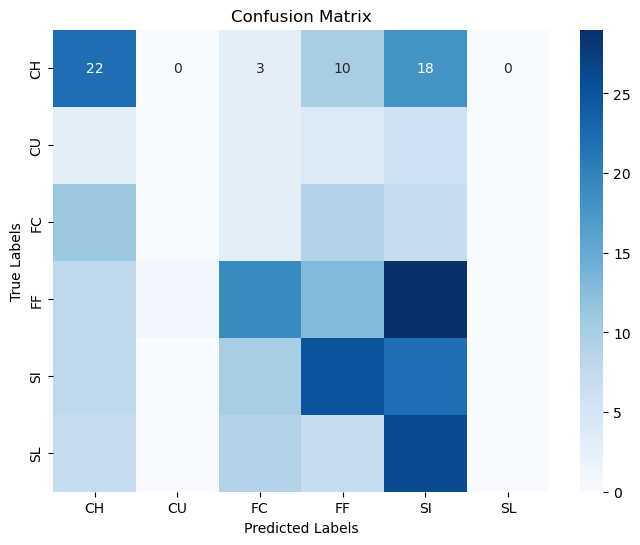

[[22  0  3 10 18  0]
 [ 3  0  3  4  6  0]
 [11  0  3  9  7  0]
 [ 8  1 19 13 29  0]
 [ 8  0 10 25 22  0]
 [ 7  0  9  7 26  0]]


InvalidArgumentError: Exception encountered when calling layer 'seq_self_attention_729' (type SeqSelfAttention).

{{function_node __wrapped__MatMul_device_/job:localhost/replica:0/task:0/device:CPU:0}} Matrix size-incompatible: In[0]: [21,11], In[1]: [64,32] [Op:MatMul] name: 

Call arguments received by layer 'seq_self_attention_729' (type SeqSelfAttention):
  • inputs=tf.Tensor(shape=(1, 21, 11), dtype=float32)
  • mask=None
  • kwargs={'training': 'None'}

In [120]:
#pitcher A confusion matrix

# create df
pitcher_a = pitchers[pitchers['pitcher_id'] == pitcher_a_id] # all rows of cleaned df for pitcher a
pitcher_a.reset_index(drop=True, inplace=True)

# DEFINE CONSTANTS
num_classes = pitcher_a['pitch_type'].nunique() # get the number of pitch types seen

max_at_bat = pitcher_a['pcount_at_bat'].max() #at bat with most number of pitches thrown in whole dataset
input_dim = max_at_bat



# test train split, split on whole games so keeps structure, 80-20 split
ngames = pitcher_a['game_pk'].unique() # number of unique games
train_ind = pitcher_a[pitcher_a['game_pk'] == ngames[math.ceil(0.7*len(ngames))]].index[0] # 80th % game index
test_ind = pitcher_a[pitcher_a['game_pk'] == ngames[math.ceil(0.85*len(ngames))]].index[0]

train = pitcher_a[:train_ind] # still includes all columns (game_pk and at_bat)
valid = pitcher_a[train_ind:test_ind]
test = pitcher_a[test_ind:]
valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)


labels = sorted((pitcher_a[test_ind:])['pitch_type'].unique())

# one hot encode pitch types
train = pd.get_dummies(train, columns=['pitch_type'], prefix='ptype')
valid = pd.get_dummies(valid, columns=['pitch_type'], prefix='ptype')
test = pd.get_dummies(test, columns=['pitch_type'], prefix='ptype')

# get the index of the columns containing pitch type info for y indexing
sel_col = [col for col in train.columns if col.startswith('ptype')]
pitch_cols = [train.columns.get_loc(col) for col in sel_col]
print(pitch_cols)

for col in pitch_cols:
  col_name = test.columns[col]
  print(col_name, test[col_name].mean())
#get y's
train_y = train.iloc[:, pitch_cols]
valid_y = valid.iloc[:, pitch_cols]
test_y = test.iloc[:, pitch_cols]

#percent fastball is test set
print("test pitches", test_y.shape[0])

# drop information we dont need anymore 'game_pk' etc
cols_to_keep = [train.columns.get_loc('inning'), train.columns.get_loc('top'),train.columns.get_loc('pcount_pitcher'),
              train.columns.get_loc('balls'),train.columns.get_loc('strikes'),train.columns.get_loc('fouls'),train.columns.get_loc('outs'),
              train.columns.get_loc('stand'),train.columns.get_loc('b_height'),train.columns.get_loc('p_throws'),train.columns.get_loc('away_team_runs'),
              train.columns.get_loc('home_team_runs'),train.columns.get_loc('on_1b'),train.columns.get_loc('on_2b'),train.columns.get_loc('on_3b')]
cols_to_keep = cols_to_keep + pitch_cols #include cols for pitches seen

#tensify to get X's
ts_train_X = tensify2(train, max_at_bat, pitch_cols)
ts_valid_X = tensify2(valid, max_at_bat, pitch_cols)
ts_test_X = tensify2(test, max_at_bat, pitch_cols)

ts_train_X = ts_train_X[:, :, cols_to_keep]
ts_valid_X = ts_valid_X[:, :, cols_to_keep]
ts_test_X = ts_test_X[:, :, cols_to_keep]

#tranpose to fit into model
ts_train_X = np.transpose(ts_train_X, (0,2,1))
ts_valid_X = np.transpose(ts_valid_X, (0,2,1))
ts_test_X = np.transpose(ts_test_X, (0,2,1))

#best model
# Build Attn RNN
att_RNN = Sequential()
att_RNN.add(Masking(mask_value = -1.0, input_shape = (None, input_dim))) # mask 0's, input shape is max_at_bat (sequence_length)
att_RNN.add(SimpleRNN(units = pa_best_u1, return_sequences=True, use_bias = pa_best_bias,
                      kernel_regularizer=l2(pa_best_krval), recurrent_regularizer=l2(pa_best_rrval)))
att_RNN.add(SimpleRNN(units = pa_best_u2, return_sequences=True, use_bias = pa_best_bias,
                      kernel_regularizer=l2(pa_best_krval), recurrent_regularizer=l2(pa_best_rrval)))
att_RNN.add(SeqSelfAttention(attention_activation='tanh'))
att_RNN.add(GlobalAveragePooling1D())
att_RNN.add(Dense(num_classes, activation = 'softmax'))
att_RNN.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# fit attn model
att_RNN.fit(ts_train_X, train_y, epochs= pa_best_e, verbose=2)# evaluate model on test set



att_RNN_preds = att_RNN.predict(ts_test_X)

max_index_att = np.argmax(att_RNN_preds, axis=1) # find index of most likely prediction
one_hot_preds_att = np.zeros_like(att_RNN_preds)
one_hot_preds_att[np.arange(one_hot_preds_att.shape[0]), max_index_att] = 1 #creates new pred matrix with 1 as most likely, 0 else

#calculate accuracy
all_accuracy2 = np.mean(np.equal(test_y, one_hot_preds_att))
print("Accuracy: ", all_accuracy2)

correct_predictions_att = np.sum(np.all(test_y == one_hot_preds_att, axis=1))
total_predictions = test_y.shape[0]
attn_accuracy = (correct_predictions_att / total_predictions) * 100
print("Accuracy:", attn_accuracy, "%")

# confusion matrix
# confusion matrix
test_uncoded = pd.DataFrame(test_y.idxmax(axis=1), columns=['pitch_type'])
test_uncoded = [value[6:] if value.startswith("ptype_") else value for value in test_uncoded['pitch_type']]
one_hot_preds = pd.DataFrame(one_hot_preds_att)
one_hot_preds = pd.DataFrame(one_hot_preds.idxmax(axis=1), columns=['pitch_type'])
one_hot_preds = [test.columns[pitch_cols[i]] for i in (one_hot_preds.iloc[:,0])]
preds_uncoded = [value[6:] if value.startswith("ptype_") else value for value in one_hot_preds]

label_encoder = LabelEncoder()

# Fit and transform the labels
test_uncoded = label_encoder.fit_transform(test_uncoded)
test_uncoded = [float(item) for item in test_uncoded]
preds_uncoded = label_encoder.fit_transform(preds_uncoded)
preds_uncoded = [float(item) for item in preds_uncoded]

conf_mat_rnn = confusion_matrix(test_uncoded, preds_uncoded)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat_rnn,annot=True,fmt="d",cmap="Blues",xticklabels=labels,yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
print(conf_mat_rnn)

# attention heatmap
attention_layer = att_RNN.layers[3]

attention_weights = attention_layer.get_weights()[0]  # Assuming the weights are the first element

# Assuming X_sample is a single input sequence for which you want to visualize attention
X_sample = ts_train_X[0:1]

# Get the attention weights for the sample
sample_attention_weights = attention_layer(tf.constant(X_sample)).numpy()

# Reshape the attention weights for visualization
reshaped_attention_weights = np.squeeze(sample_attention_weights)

# Plot the attention heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(reshaped_attention_weights, cmap='viridis', annot=True, fmt=".2f", xticklabels=True, yticklabels=True)
plt.title("Self-Attention Heatmap")
plt.show()

<tf.Variable 'seq_self_attention_729/seq_self_attention_729_Add_Wt:0' shape=(64, 32) dtype=float32, numpy=
array([[ 0.18868762,  0.08471067, -0.07751323, ..., -0.04847208,
         0.0465765 , -0.06888177],
       [-0.10569489,  0.4428759 , -0.11528951, ..., -0.03856866,
         0.10925213, -0.16527775],
       [ 0.12574016,  0.07556145,  0.09815755, ..., -0.07955651,
         0.25841644,  0.2735277 ],
       ...,
       [-0.13538583, -0.22214983, -0.04757375, ..., -0.14720255,
        -0.05274171, -0.14774361],
       [-0.09558091, -0.01856267, -0.05521952, ...,  0.00694229,
         0.23528463,  0.17765208],
       [ 0.00319747,  0.05386454, -0.2799539 , ...,  0.00974921,
        -0.03724105,  0.20534419]], dtype=float32)>
(21, 11)
(1, 21, 64)


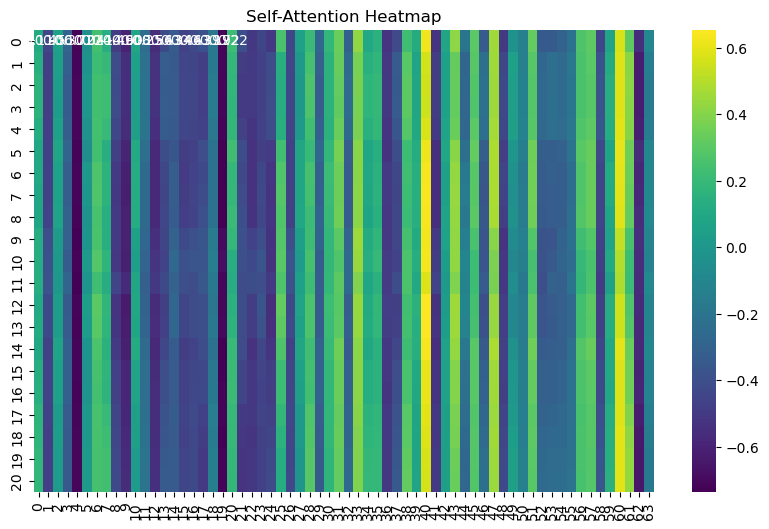

In [140]:
print(attention_layer.weights[0])
print(ts_train_X[0, :, :].shape)
sample_attention = att_RNN.layers[0](tf.constant(ts_train_X[3:4, :, :])).numpy()
sample_attention = att_RNN.layers[1](tf.constant(sample_attention)).numpy()
sample_attention = att_RNN.layers[2](tf.constant(sample_attention)).numpy()
sample_attention = attention_layer(tf.constant(sample_attention)).numpy()
print(sample_attention.shape)

reshaped_attention_weights = np.squeeze(sample_attention)

# Plot the attention heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(reshaped_attention_weights, cmap='viridis', annot=True, fmt=".2f", xticklabels=True, yticklabels=True)
plt.title("Self-Attention Heatmap")
plt.show()

[19, 20, 21, 22]
ptype_CU 0.25961538461538464
ptype_FF 0.11538461538461539
ptype_SI 0.5769230769230769
ptype_SL 0.04807692307692308
test pitches 104


/var/folders/38/kd_zrxks0fbgprr1jgmd1vd00000gn/T/ipykernel_71090/158079992.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  new_val.iloc[p,pitch_cols] = -1 # remove current pitch type


Epoch 1/20
35/35 - 1s - loss: 1.2358 - accuracy: 0.6249 - 830ms/epoch - 24ms/step
Epoch 2/20
35/35 - 0s - loss: 1.1508 - accuracy: 0.6501 - 135ms/epoch - 4ms/step
Epoch 3/20
35/35 - 0s - loss: 1.1374 - accuracy: 0.6492 - 145ms/epoch - 4ms/step
Epoch 4/20
35/35 - 0s - loss: 1.1218 - accuracy: 0.6510 - 159ms/epoch - 5ms/step
Epoch 5/20
35/35 - 0s - loss: 1.1075 - accuracy: 0.6519 - 159ms/epoch - 5ms/step
Epoch 6/20
35/35 - 0s - loss: 1.1053 - accuracy: 0.6537 - 165ms/epoch - 5ms/step
Epoch 7/20
35/35 - 0s - loss: 1.0958 - accuracy: 0.6519 - 161ms/epoch - 5ms/step
Epoch 8/20
35/35 - 0s - loss: 1.0916 - accuracy: 0.6555 - 159ms/epoch - 5ms/step
Epoch 9/20
35/35 - 0s - loss: 1.0780 - accuracy: 0.6528 - 160ms/epoch - 5ms/step
Epoch 10/20
35/35 - 0s - loss: 1.0771 - accuracy: 0.6619 - 161ms/epoch - 5ms/step
Epoch 11/20
35/35 - 0s - loss: 1.0638 - accuracy: 0.6628 - 159ms/epoch - 5ms/step
Epoch 12/20
35/35 - 0s - loss: 1.0649 - accuracy: 0.6646 - 159ms/epoch - 5ms/step
Epoch 13/20
35/35 - 0s -

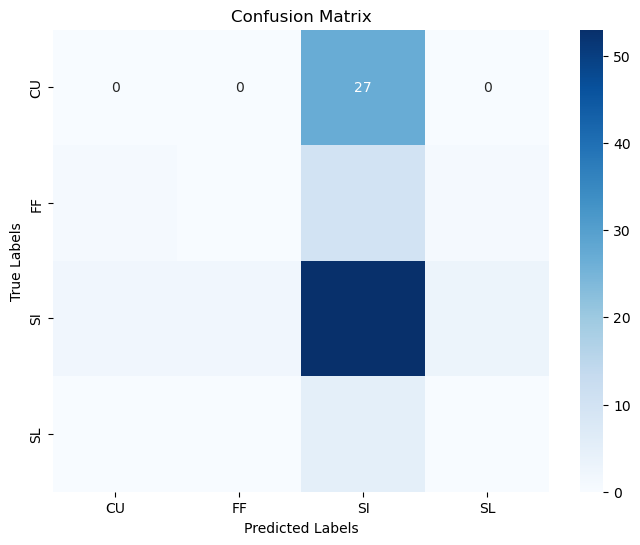

[[ 0  0 27  0]
 [ 1  0 10  1]
 [ 2  2 53  3]
 [ 0  0  5  0]]


In [116]:
# pitcher B confusion matrix


# create df
pitcher_b = pitchers[pitchers['pitcher_id'] == pitcher_b_id] # all rows of cleaned df for pitcher a
pitcher_b.reset_index(drop=True, inplace=True)

# DEFINE CONSTANTS
num_classes = pitcher_b['pitch_type'].nunique() # get the number of pitch types seen

max_at_bat = pitcher_b['pcount_at_bat'].max() #at bat with most number of pitches thrown in whole dataset
input_dim = max_at_bat

labels = sorted(pitcher_b['pitch_type'].unique())

# one hot encode pitch types
pitcher_b = pd.get_dummies(pitcher_b, columns=['pitch_type'], prefix='ptype')


# get the index of the columns containing pitch type info for y indexing
sel_col = [col for col in pitcher_b.columns if col.startswith('ptype')]
pitch_cols = [pitcher_b.columns.get_loc(col) for col in sel_col]
print(pitch_cols)

# test train split, split on whole games so keeps structure, 80-20 split
ngames = pitcher_b['game_pk'].unique() # number of unique games
train_ind = pitcher_b[pitcher_b['game_pk'] == ngames[math.ceil(0.7*len(ngames))]].index[0] # 80th % game index
test_ind = pitcher_b[pitcher_b['game_pk'] == ngames[math.ceil(0.85*len(ngames))]].index[0]

train = pitcher_b[:train_ind] # still includes all columns (game_pk and at_bat)
valid = pitcher_b[train_ind:test_ind]
test = pitcher_b[test_ind:]
valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

for col in pitch_cols:
  col_name = test.columns[col]
  print(col_name, test[col_name].mean())
#get y's
train_y = train.iloc[:, pitch_cols]
valid_y = valid.iloc[:, pitch_cols]
test_y = test.iloc[:, pitch_cols]

#percent fastball is test set
print("test pitches", test_y.shape[0])

# drop information we dont need anymore 'game_pk' etc
cols_to_keep = [train.columns.get_loc('inning'), train.columns.get_loc('top'),train.columns.get_loc('pcount_pitcher'),
              train.columns.get_loc('balls'),train.columns.get_loc('strikes'),train.columns.get_loc('fouls'),train.columns.get_loc('outs'),
              train.columns.get_loc('stand'),train.columns.get_loc('b_height'),train.columns.get_loc('p_throws'),train.columns.get_loc('away_team_runs'),
              train.columns.get_loc('home_team_runs'),train.columns.get_loc('on_1b'),train.columns.get_loc('on_2b'),train.columns.get_loc('on_3b')]
cols_to_keep = cols_to_keep + pitch_cols #include cols for pitches seen

#tensify to get X's
ts_train_X = tensify2(train, max_at_bat, pitch_cols)
ts_valid_X = tensify2(valid, max_at_bat, pitch_cols)
ts_test_X = tensify2(test, max_at_bat, pitch_cols)

ts_train_X = ts_train_X[:, :, cols_to_keep]
ts_valid_X = ts_valid_X[:, :, cols_to_keep]
ts_test_X = ts_test_X[:, :, cols_to_keep]

#tranpose to fit into model
ts_train_X = np.transpose(ts_train_X, (0,2,1))
ts_valid_X = np.transpose(ts_valid_X, (0,2,1))
ts_test_X = np.transpose(ts_test_X, (0,2,1))

#best model 
# Build Attn RNN
att_RNN = Sequential()
att_RNN.add(Masking(mask_value = -1.0, input_shape = (None, input_dim))) # mask 0's, input shape is max_at_bat (sequence_length)
att_RNN.add(SimpleRNN(units = pb_best_u1, return_sequences=True, use_bias = pb_best_bias,
                      kernel_regularizer=l2(pb_best_krval), recurrent_regularizer=l2(pb_best_rrval)))
att_RNN.add(SimpleRNN(units = pb_best_u2, return_sequences=True, use_bias = pb_best_bias,
                      kernel_regularizer=l2(pb_best_krval), recurrent_regularizer=l2(pb_best_rrval)))
att_RNN.add(SeqSelfAttention(attention_activation='tanh'))
att_RNN.add(GlobalAveragePooling1D())
att_RNN.add(Dense(num_classes, activation = 'softmax'))
att_RNN.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# fit attn model
att_RNN.fit(ts_train_X, train_y, epochs= pb_best_e, verbose=2)# evaluate model on test set



att_RNN_preds = att_RNN.predict(ts_test_X)

max_index_att = np.argmax(att_RNN_preds, axis=1) # find index of most likely prediction
one_hot_preds_att = np.zeros_like(att_RNN_preds)
one_hot_preds_att[np.arange(one_hot_preds_att.shape[0]), max_index_att] = 1 #creates new pred matrix with 1 as most likely, 0 else

#calculate accuracy
all_accuracy2 = np.mean(np.equal(test_y, one_hot_preds_att))
print("Accuracy: ", all_accuracy2)

correct_predictions_att = np.sum(np.all(test_y == one_hot_preds_att, axis=1))
total_predictions = test_y.shape[0]
attn_accuracy = (correct_predictions_att / total_predictions) * 100
print("Accuracy:", attn_accuracy, "%")

# confusion matrix
test_uncoded = pd.DataFrame(test_y.idxmax(axis=1), columns=['pitch_type'])
test_uncoded = [value[6:] if value.startswith("ptype_") else value for value in test_uncoded['pitch_type']]
one_hot_preds = pd.DataFrame(one_hot_preds_att)
one_hot_preds = pd.DataFrame(one_hot_preds.idxmax(axis=1), columns=['pitch_type'])
one_hot_preds = [test.columns[pitch_cols[i]] for i in (one_hot_preds.iloc[:,0])]
preds_uncoded = [value[6:] if value.startswith("ptype_") else value for value in one_hot_preds]


conf_mat_rnn = confusion_matrix(test_uncoded, preds_uncoded)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat_rnn,annot=True,fmt="d",cmap="Blues",xticklabels=labels,yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
print(conf_mat_rnn)

In [130]:
print(pa_bal_best_bal)

<function undersampled at 0x3410ffb00>


In [142]:
print(pb_best_acc)
print(pb_best_acc)
print(pb_best_bias)
print(pb_best_krval)
print(pb_best_rrval)
print(pb_best_u1)
print(pb_best_u2)
print(pb_best_e)

67.75510204081633
67.75510204081633
True
0
0.001
64
64
20
